  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [35]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['..','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['../../..', '..', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-Pharmacophore_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [2]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
# import seaborn as sb
# import matplotlib.pyplot as plt
# import scipy.stats as sps

# from scipy.spatial.distance import pdist, squareform, euclidean

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-12-20 19:18:06,132 - INFO: -  Excution started : 2024_12_20_19:18:06 
2024-12-20 19:18:06,133 - INFO: -  Pytorch version  : 2.2.0
2024-12-20 19:18:06,134 - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-12-20 19:18:06,135 - INFO: -  Pandas version: 2.2.2  


In [5]:
from src.utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ../output_10162023/compound_metadata_tpsa.csv
          + TPSA

In [6]:
WANDB_ACTIVE  = False
DATE          = 'yyyymmdd-hhmm'
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"
EMBEDDING_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINT_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/"
MODEL_SAVE_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/embedded_models"

LATENT_DIM    = 250
LATENT_DIM = 250
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)


## AUTOENCODER RUNMODE 
AE_RUNMODE = "snnl"
# AE_RUNMODE = 'base'
## 
# AE_DATETIME = "20240906_2201"     # SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
AE_DATETIME = "20240917_2004"     # SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3
##
# AE_CKPTTYPE = "BEST"
AE_CKPTTYPE = "LAST"
# df_header = pd.read_csv(HEADER_FILE).columns.to_list()
# header_cols

11
261


In [8]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
FINGERPRINT_SUFFIX = '-A'
FINGERPRINT_TRAINING_FILE   = f"3sample_pharmacophores_13740{FINGERPRINT_SUFFIX}_selcols0570_HashOrder_training.csv"
FINGERPRINT_VALIDATION_FILE = f"3sample_pharmacophores_13740{FINGERPRINT_SUFFIX}_selcols0570_HashOrder_validation.csv"
FINGERPRINT_TEST_FILE       = f"3sample_pharmacophores_13740{FINGERPRINT_SUFFIX}_selcols0570_HashOrder_test.csv"

print(FINGERPRINT_TRAINING_FILE)
print(FINGERPRINT_VALIDATION_FILE)
print(FINGERPRINT_TEST_FILE)

EMBEDDING_TRAINING_FILE   = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_training.csv'
EMBEDDING_VALIDATION_FILE = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_validation.csv'
EMBEDDING_TEST_FILE       = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_test.csv'

print()
print(EMBEDDING_TRAINING_FILE)
print(EMBEDDING_VALIDATION_FILE)
print(EMBEDDING_TEST_FILE)


3sample_pharmacophores_13740-A_selcols0570_HashOrder_training.csv
3sample_pharmacophores_13740-A_selcols0570_HashOrder_validation.csv
3sample_pharmacophores_13740-A_selcols0570_HashOrder_test.csv

3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_training.csv
3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_validation.csv
3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv


In [9]:
TRAIN_INPUT_X = os.path.join(EMBEDDING_INPUT_PATH, EMBEDDING_TRAINING_FILE)
TRAIN_INPUT_Y = os.path.join(FINGERPRINT_INPUT_PATH, FINGERPRINT_TRAINING_FILE)
TRAIN_INPUT_X
TRAIN_INPUT_Y

TEST_INPUT_X  = os.path.join(EMBEDDING_INPUT_PATH, EMBEDDING_TEST_FILE)
TEST_INPUT_Y  = os.path.join(FINGERPRINT_INPUT_PATH, FINGERPRINT_TEST_FILE)
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-A_selcols0570_HashOrder_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-A_selcols0570_HashOrder_test.csv'

## Helper routines

### Create Pharmacophores definitions 

In [10]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
# fingerprint_bins = [(0,3),(3,8)]
# fingerprint_bins = [(0,1),(1,2),(2,3),(3,4),(4,100)]
fingerprint_bins = [(0,3),(3,6),(6,9),(9,12),(12,100)]
sigFactory.SetBins(fingerprint_bins)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
bit_id = 0


print(f" Bins : {fingerprint_bins}   Size of fingerprint: {FINGERPRINT_LENGTH}")
# print(f" Bins : {bit_id:4d}   description:  {sigFactory.GetBitDescription(bit_id)}")

2024-12-20 19:19:10,607 - INFO: - Enabling RDKit 2023.03.3 jupyter extensions


/home/kevin/miniforge3/envs/cp311/share/RDKit/Data/BaseFeatures.fdef
 Bins : [(0, 3), (3, 6), (6, 9), (9, 12), (12, 100)]   Size of fingerprint: 13740


### Selected Bit columns for 1032 FP - Between 10% and 90% ??

In [10]:
## 1032 Fingerprint with bins:  [(0,3),(3,8)]
# selected_label_indices = np.array(
#       [  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
#         44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
#        127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
#        197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
#        267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
#        433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
#        639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])
 array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

### Selected Bit columns for 13740-A FP - Between 5% and 70%

In [11]:
## 13740 Fingerprint with bins:  [(0,1),(1,2),(2,3),(3,4),(4,100)]
# indices_pct_bw_10_90
# selected_label_indices = np.array(
# [    2,     3,     4,     6,     7,     8,    12,    13,    14,    17,    18,    21,    22,    23,    24,    33,    34,    41,    42,    43,
#     44,    46,    47,    48,    49,    51,    52,    53,    54,    56,    57,    58,    59,    67,    69,    77,    78,    79,    82,    83,
#     84,    86,    87,    88,    89,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   124,   133,   134,   144,   290,
#    291,   292,   347,   359,   383,   392,   397,   398,   402,   403,   404,   405,   472,   496,   511,   516,   517,   518,   573,   579,
#    585,   608,   609,   619,   624,   629,   630,   631,   686,   698,   722,   731,   736,   741,   742,   743,   744,   970,  1163,  1180,
#   1181,  1183,  1186,  1191,  1193,  1195,  1196,  1236,  1237,  1238,  1251,  1263,  1274,  1287,  1299,  1304,  1306,  1307,  1308,  1309,
#   1348,  1349,  1350,  1351,  1373,  1375,  1376,  1387,  1389,  1400,  1410,  1411,  1412,  1414,  1416,  1417,  1419,  1420,  1421,  1422,
#   1464,  1483,  1489,  1502,  1513,  1520,  1525,  1530,  1532,  1534,  1535,  1761,  1977,  1982,  1985,  1986,  1987,  2042,  2048,  2052,
#   2053,  2054,  2076,  2078,  2088,  2089,  2090,  2093,  2095,  2098,  2099,  2100,  2155,  2159,  2167,  2191,  2196,  2198,  2203,  2208,
#   2210,  2211,  2212,  2213,  2439,  2630,  2653,  2654,  2655,  2657,  2658,  2660,  2662,  2663,  2664,  2665,  2726,  2732,  2756,  2763,
#   2768,  2773,  2775,  2776,  2777,  2778,  2958,  3002,  3004,  3215,  3220,  3225,  3230,  3456,  4357,  4402,  4470,  4471,  4472,  4473,
#   4515,  4583,  4584,  4585,  4586,  4628,  4696,  5136,  5141,  5146,  5149,  5151,  5193,  5216,  5218,  5225,  5242,  5249,  5252,  5254,
#   5259,  5262,  5263,  5264,  5306,  5331,  5355,  5362,  5374,  5375,  5376,  5377,  5765,  5814,  5819,  5821,  5824,  5826,  5827,  5828,
#   5829,  5871,  5896,  5920,  5927,  5939,  5940,  5941,  5942,  6379,  7591,  7615,  7635,  7636,  7637,  7748,  7749,  7750,  8167,  8190,
#   8191,  8192,  8194,  8197,  8199,  8200,  8201,  8202,  8269,  8293,  8300,  8305,  8310,  8312,  8314,  8315,  8757,  8762,  8767,  9833,
#   9862,  9894,  9895,  9896,  9897,  9939,  9964,  9988, 10007, 10008, 10009, 10010, 10447, 10457, 10462])

### Selected Bit columns for 13740-A FP - Between 10% and 90%

In [11]:
## 13740 Fingerprint with bins:  [(0,1),(1,2),(2,3),(3,4),(4,100)]
# indices_pct_bw_10_90
# selected_label_indices = np.array(
# [    2,     3,     4,     6,     7,     8,    12,    13,    14,    17,    18,    21,    22,    23,    24,    33,    34,    41,    42,    43,
#     44,    46,    47,    48,    49,    51,    52,    53,    54,    56,    57,    58,    59,    67,    69,    77,    78,    79,    82,    83,
#     84,    86,    87,    88,    89,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   124,   133,   134,   144,   290,
#    291,   292,   347,   359,   383,   392,   397,   398,   402,   403,   404,   405,   472,   496,   511,   516,   517,   518,   573,   579,
#    585,   608,   609,   619,   624,   629,   630,   631,   686,   698,   722,   731,   736,   741,   742,   743,   744,   970,  1163,  1180,
#   1181,  1183,  1186,  1191,  1193,  1195,  1196,  1236,  1237,  1238,  1251,  1263,  1274,  1287,  1299,  1304,  1306,  1307,  1308,  1309,
#   1348,  1349,  1350,  1351,  1373,  1375,  1376,  1387,  1389,  1400,  1410,  1411,  1412,  1414,  1416,  1417,  1419,  1420,  1421,  1422,
#   1464,  1483,  1489,  1502,  1513,  1520,  1525,  1530,  1532,  1534,  1535,  1761,  1977,  1982,  1985,  1986,  1987,  2042,  2048,  2052,
#   2053,  2054,  2076,  2078,  2088,  2089,  2090,  2093,  2095,  2098,  2099,  2100,  2155,  2159,  2167,  2191,  2196,  2198,  2203,  2208,
#   2210,  2211,  2212,  2213,  2439,  2630,  2653,  2654,  2655,  2657,  2658,  2660,  2662,  2663,  2664,  2665,  2726,  2732,  2756,  2763,
#   2768,  2773,  2775,  2776,  2777,  2778,  2958,  3002,  3004,  3215,  3220,  3225,  3230,  3456,  4357,  4402,  4470,  4471,  4472,  4473,
#   4515,  4583,  4584,  4585,  4586,  4628,  4696,  5136,  5141,  5146,  5149,  5151,  5193,  5216,  5218,  5225,  5242,  5249,  5252,  5254,
#   5259,  5262,  5263,  5264,  5306,  5331,  5355,  5362,  5374,  5375,  5376,  5377,  5765,  5814,  5819,  5821,  5824,  5826,  5827,  5828,
#   5829,  5871,  5896,  5920,  5927,  5939,  5940,  5941,  5942,  6379,  7591,  7615,  7635,  7636,  7637,  7748,  7749,  7750,  8167,  8190,
#   8191,  8192,  8194,  8197,  8199,  8200,  8201,  8202,  8269,  8293,  8300,  8305,  8310,  8312,  8314,  8315,  8757,  8762,  8767,  9833,
#   9862,  9894,  9895,  9896,  9897,  9939,  9964,  9988, 10007, 10008, 10009, 10010, 10447, 10457, 10462])

### Selected Bit columns for 13740-A FP - Between 5% and 70%

In [13]:
## 13740 Fingerprint with bins:  [(0,1),(1,2),(2,3),(3,4),(4,100)]
# Between 5 and 70 percent -  indices_pct_bw_05_70 
selected_label_indicies = np.array( 
      [    1,     2,     3,     6,     7,     8,    12,    13,    18,    21,    22,    23,    33,    34,    41,    42,    43,    44,    46,    47,
          48,    51,    52,    53,    56,    57,    58,    59,    67,    69,    76,    77,    78,    79,    82,    83,    86,    87,    88,    89,
          98,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   123,   124,   131,   133,   134,   142,   144,   286,   289,
         290,   291,   292,   334,   347,   353,   359,   365,   380,   381,   382,   383,   387,   392,   393,   397,   398,   399,   402,   403,
         404,   405,   447,   460,   472,   489,   495,   496,   511,   516,   517,   518,   560,   573,   579,   583,   584,   585,   602,   607,
         608,   609,   619,   624,   625,   630,   673,   686,   692,   698,   704,   721,   722,   726,   731,   732,   736,   737,   741,   742,
         743,   744,   924,   969,   970,  1134,  1156,  1163,  1169,  1178,  1179,  1180,  1181,  1183,  1185,  1186,  1188,  1190,  1191,  1193,
        1194,  1195,  1196,  1234,  1235,  1236,  1237,  1238,  1251,  1260,  1261,  1262,  1263,  1274,  1276,  1282,  1284,  1285,  1287,  1297,
        1298,  1299,  1302,  1303,  1304,  1306,  1307,  1308,  1309,  1341,  1344,  1348,  1349,  1350,  1351,  1364,  1366,  1373,  1374,  1375,
        1376,  1387,  1389,  1395,  1397,  1398,  1399,  1400,  1410,  1411,  1412,  1414,  1415,  1416,  1417,  1419,  1420,  1421,  1422,  1461,
        1463,  1464,  1483,  1486,  1488,  1489,  1502,  1508,  1510,  1512,  1513,  1517,  1519,  1520,  1524,  1525,  1529,  1530,  1532,  1533,
        1534,  1535,  1690,  1715,  1739,  1756,  1759,  1761,  1976,  1977,  1982,  1984,  1985,  1986,  1987,  2042,  2048,  2052,  2053,  2054,
        2073,  2076,  2077,  2078,  2088,  2089,  2090,  2093,  2094,  2095,  2098,  2099,  2100,  2155,  2159,  2161,  2165,  2167,  2189,  2191,
        2196,  2197,  2198,  2200,  2203,  2206,  2208,  2210,  2211,  2212,  2213,  2393,  2438,  2439,  2607,  2609,  2630,  2632,  2633,  2653,
        2654,  2655,  2657,  2658,  2659,  2660,  2662,  2663,  2664,  2665,  2720,  2724,  2726,  2730,  2731,  2732,  2751,  2753,  2755,  2756,
        2760,  2761,  2762,  2763,  2767,  2768,  2772,  2773,  2775,  2776,  2777,  2778,  2956,  2958,  2982,  2999,  3002,  3003,  3004,  3197,
        3214,  3215,  3220,  3225,  3229,  3230,  3385,  3410,  3434,  3451,  3454,  3456,  4352,  4357,  4359,  4400,  4401,  4402,  4438,  4444,
        4451,  4461,  4466,  4470,  4471,  4472,  4473,  4512,  4513,  4514,  4515,  4540,  4561,  4564,  4579,  4583,  4584,  4585,  4586,  4628,
        4674,  4696,  4697,  4698,  4923,  5090,  5136,  5140,  5141,  5146,  5149,  5150,  5151,  5184,  5187,  5193,  5203,  5208,  5213,  5216,
        5217,  5218,  5225,  5227,  5235,  5240,  5241,  5242,  5248,  5249,  5252,  5254,  5257,  5259,  5262,  5263,  5264,  5306,  5316,  5323,
        5331,  5355,  5362,  5367,  5372,  5374,  5375,  5376,  5377,  5557,  5602,  5603,  5765,  5768,  5790,  5792,  5794,  5813,  5814,  5817,
        5819,  5821,  5822,  5823,  5824,  5826,  5827,  5828,  5829,  5871,  5881,  5896,  5920,  5927,  5932,  5937,  5939,  5940,  5941,  5942,
        6097,  6158,  6166,  6168,  6379,  6389,  6610,  7522,  7523,  7524,  7591,  7613,  7615,  7625,  7630,  7635,  7636,  7637,  7704,  7728,
        7747,  7748,  7749,  7750,  8146,  8167,  8170,  8190,  8191,  8192,  8194,  8195,  8196,  8197,  8199,  8200,  8201,  8202,  8253,  8259,
        8261,  8263,  8267,  8268,  8269,  8283,  8290,  8293,  8300,  8305,  8310,  8312,  8313,  8314,  8315,  8495,  8536,  8539,  8541,  8752,
        8757,  8762,  8767,  8993,  9833,  9862,  9885,  9889,  9890,  9894,  9895,  9896,  9897,  9927,  9938,  9939,  9963,  9964,  9988, 10007,
       10008, 10009, 10010, 10165, 10190, 10234, 10236, 10447, 10452, 10457, 10462, 10678, 10688])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
len(str_selected_label_indicies)

533

533

### Selected Bit columns for 13740-B FP - Between 5% and 70%

In [13]:
## 13740-B Fingerprint with bins:  [(0,3),(3,6),(6,9),(9,12),(12,100)]
# indicies_pct_bw_05_70 
selected_label_indicies = np.array([
           0,     2,     3,     4,     8,     9,    10,    12,    13,    14,    18,    19,    22,    23,    24,    31,    32,    33,    40,    41,
          42,    43,    45,    47,    48,    50,    52,    53,    54,    55,    56,    57,    58,    65,    66,    67,    75,    76,    77,    78,
          80,    82,    83,    84,    85,    86,    87,    88,    96,    97,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,
         120,   121,   122,   123,   130,   131,   132,   133,   140,   141,   142,   203,   204,   227,   228,   232,   233,   256,   257,   258,
         261,   262,   280,   284,   285,   288,   289,   293,   296,   297,   301,   302,   307,   312,   316,   317,   321,   322,   323,   328,
         329,   333,   335,   340,   341,   345,   346,   350,   351,   352,   357,   364,   365,   369,   370,   374,   375,   380,   391,   392,
         396,   401,   406,   410,   414,   415,   420,   429,   430,   435,   436,   441,   453,   454,   458,   459,   464,   465,   470,   478,
         482,   483,   484,   487,   488,   505,   506,   510,   511,   519,   522,   523,   527,   528,   532,   533,   538,   542,   543,   547,
         548,   549,   553,   554,   555,   559,   566,   567,   571,   572,   576,   577,   578,   583,   584,   591,   595,   596,   600,   601,
         606,   607,   618,   619,   622,   623,   627,   628,   632,   635,   636,   641,   646,   651,   655,   656,   660,   661,   662,   667,
         668,   672,   674,   679,   680,   684,   685,   689,   690,   691,   696,   703,   704,   708,   713,   714,   719,   730,   731,   735,
         740,   887,   906,   935,  1084,  1085,  1103,  1104,  1105,  1108,  1109,  1126,  1127,  1128,  1131,  1132,  1133,  1134,  1151,  1152,
        1153,  1156,  1160,  1176,  1197,  1200,  1201,  1202,  1204,  1205,  1206,  1209,  1210,  1211,  1214,  1216,  1217,  1220,  1221,  1222,
        1225,  1226,  1227,  1228,  1230,  1231,  1240,  1241,  1244,  1245,  1246,  1247,  1249,  1250,  1254,  1266,  1269,  1270,  1273,  1274,
        1278,  1279,  1297,  1301,  1310,  1311,  1313,  1314,  1315,  1317,  1318,  1319,  1320,  1322,  1323,  1324,  1326,  1327,  1329,  1330,
        1331,  1333,  1334,  1335,  1338,  1339,  1340,  1341,  1344,  1346,  1349,  1353,  1354,  1357,  1358,  1359,  1360,  1362,  1363,  1365,
        1367,  1373,  1378,  1379,  1382,  1383,  1384,  1386,  1387,  1391,  1396,  1406,  1423,  1424,  1426,  1427,  1428,  1431,  1432,  1435,
        1436,  1437,  1440,  1442,  1443,  1444,  1447,  1448,  1451,  1452,  1453,  1454,  1457,  1466,  1467,  1471,  1472,  1473,  1480,  1490,
        1491,  1492,  1495,  1653,  1657,  1673,  1696,  1697,  1895,  1898,  1899,  1900,  1918,  1919,  1923,  1924,  1927,  1928,  1948,  1952,
        1988,  1989,  1991,  1992,  1996,  1997,  2001,  2002,  2007,  2008,  2009,  2011,  2012,  2013,  2016,  2017,  2018,  2019,  2022,  2023,
        2028,  2031,  2032,  2035,  2036,  2037,  2038,  2040,  2041,  2043,  2045,  2046,  2047,  2052,  2056,  2057,  2060,  2061,  2062,  2064,
        2065,  2069,  2070,  2075,  2084,  2101,  2104,  2105,  2109,  2110,  2115,  2120,  2121,  2122,  2124,  2125,  2126,  2129,  2130,  2131,
        2132,  2135,  2136,  2143,  2144,  2145,  2148,  2149,  2150,  2151,  2153,  2154,  2158,  2159,  2165,  2168,  2169,  2170,  2182,  2183,
        2331,  2356,  2375,  2553,  2554,  2572,  2573,  2574,  2576,  2577,  2578,  2596,  2597,  2598,  2600,  2601,  2602,  2603,  2605,  2606,
        2608,  2621,  2622,  2625,  2626,  2627,  2628,  2629,  2630,  2634,  2645,  2648,  2649,  2652,  2653,  2656,  2657,  2661,  2666,  2667,
        2669,  2670,  2671,  2674,  2675,  2679,  2680,  2685,  2686,  2687,  2689,  2690,  2691,  2694,  2695,  2696,  2697,  2700,  2701,  2702,
        2706,  2708,  2709,  2710,  2713,  2714,  2715,  2716,  2718,  2721,  2723,  2724,  2733,  2734,  2735,  2738,  2740,  2747,  2758,  2895,
        2896,  2901,  2915,  2917,  2920,  2921,  2939,  2940,  2944,  3138,  3142,  3143,  3161,  3162,  3166,  3167,  3168,  3186,  3187,  3190,
        4267,  4295,  4324,  4364,  4369,  4380,  4384,  4385,  4389,  4395,  4408,  4409,  4413,  4414,  4438,  4477,  4482,  4487,  4493,  4497,
        4502,  4503,  4508,  4521,  4522,  4526,  4531,  4551,  4590,  4595,  4615,  4644,  5039,  5040,  5058,  5059,  5060,  5062,  5063,  5082,
        5083,  5087,  5088,  5091,  5112,  5116,  5153,  5154,  5155,  5156,  5157,  5160,  5161,  5162,  5165,  5171,  5172,  5173,  5175,  5176,
        5177,  5178,  5180,  5181,  5182,  5186,  5187,  5195,  5196,  5197,  5199,  5200,  5204,  5205,  5210,  5225,  5228,  5229,  5266,  5268,
        5269,  5270,  5273,  5274,  5286,  5288,  5289,  5293,  5294,  5295,  5300,  5312,  5317,  5318,  5323,  5717,  5718,  5736,  5737,  5738,
        5740,  5741,  5743,  5760,  5761,  5762,  5764,  5765,  5769,  5785,  5789,  5790,  5793,  5794,  5798,  5831,  5833,  5834,  5835,  5838,
        5839,  5840,  5851,  5853,  5856,  5858,  5859,  5865,  5875,  5882,  5888,  6303,  7435,  7525,  7528,  7529,  7534,  7544,  7548,  7549,
        7553,  7554,  7560,  7572,  7573,  7577,  7578,  7583,  7641,  7642,  7661,  7662,  7666,  7667,  7685,  7690,  7696,  8090,  8091,  8109,
        8110,  8111,  8113,  8114,  8115,  8133,  8134,  8135,  8137,  8138,  8139,  8140,  8142,  8158,  8159,  8162,  8163,  8166,  8167,  8171,
        8204,  8206,  8207,  8208,  8211,  8212,  8216,  8222,  8223,  8224,  8226,  8227,  8228,  8231,  8232,  8233,  8234,  8238,  8246,  8247,
        8252,  8253,  8255,  8261,  8433,  8452,  8454,  8656,  8675,  8676,  8679,  8680,  8698,  8699,  8704,  8705,  9785,  9804,  9808,  9832,
        9833,  9837,  9857,  9861,  9862,  9866,  9898,  9901,  9902,  9906,  9907,  9911,  9912,  9921,  9926,  9927,  9932,  9933,  9950,  9956,
       10127, 10370, 10375])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies 

803

## Create Pharmacophores definitions 

In [25]:
selected_label_descriptions = []
print()
print(f"  Bit    ROC_AUC     Description")
print(f"  ----   --------    -------------")

for idx, bit_id in enumerate(sorted(selected_label_indicies)):
    prefix = "         "
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {idx:5d}     {bit_id:5d}     {selected_label_descriptions[-1]}")


  Bit    ROC_AUC     Description
  ----   --------    -------------
     0         1     Acceptor Acceptor |0 1|1 0|
     1         2     Acceptor Acceptor |0 2|2 0|
     2         3     Acceptor Acceptor |0 3|3 0|
     3         6     Acceptor Aromatic |0 1|1 0|
     4         7     Acceptor Aromatic |0 2|2 0|
     5         8     Acceptor Aromatic |0 3|3 0|
     6        12     Acceptor Donor |0 2|2 0|
     7        13     Acceptor Donor |0 3|3 0|
     8        18     Acceptor Hydrophobe |0 3|3 0|
     9        21     Acceptor LumpedHydrophobe |0 1|1 0|
    10        22     Acceptor LumpedHydrophobe |0 2|2 0|
    11        23     Acceptor LumpedHydrophobe |0 3|3 0|
    12        33     Acceptor PosIonizable |0 3|3 0|
    13        34     Acceptor PosIonizable |0 4|4 0|
    14        41     Aromatic Aromatic |0 1|1 0|
    15        42     Aromatic Aromatic |0 2|2 0|
    16        43     Aromatic Aromatic |0 3|3 0|
    17        44     Aromatic Aromatic |0 4|4 0|
    18        46     

# Load Datasets - Embedded Features CSV files

## Training Data

In [14]:
df_train_x = pd.read_csv(TRAIN_INPUT_X)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [15]:
df_train_x.shape
df_train_x.info()
df_train_x.head(5)
df_train_x.iloc[:10,:17]

(277200, 261)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 261 entries, Metadata_Source to Feature_249
dtypes: float64(254), int64(2), object(5)
memory usage: 552.0+ MB


Metadata_Source                  Metadata_Batch     Metadata_Plate Metadata_Well Metadata_JCP2022        Metadata_Hash  \
0        source_1                 Batch5_20221030           UL001793           M26   JCP2022_006020 -9223347314827979542   
1       source_10      2021_06_22_U2OS_48_hr_run8  Dest210622-143628           M04   JCP2022_006020 -9223347314827979542   
2        source_3               CP_31_all_Phenix1           B040603b           G13   JCP2022_006020 -9223347314827979542   
3        source_6  p211004CPU2OS48hw384exp031JUMP       110000295562           M08   JCP2022_058905 -9223229703754907651   
4        source_3               CP_32_all_Phenix1           B40003aW           M08   JCP2022_058905 -9223229703754907651   

   Metadata_Bin  Metadata_TPSA  Metadata_lnTPSA  Metadata_log10TPSA  ...  Feature_240  Feature_241  Feature_242  Feature_243  \
0            10          71.18         4.265212            1.852358  ...     0.009390    -0.008253    -0.037940    -0.016286   
1            10          71.18         4.265212            1.852358  ...     0.095957     0.040152    -0.005584     0.046152   
2            10          71.18         4.265212            1.852358  ...     0.017318    -0.012258    -0.079632    -0.032763   
3            13          58.65         4.071588            1.768268  ...    -0.114507     0.006824    -0.183686     0.006500   
4            13          58.65         4.071588            1.768268  ...    -0.035176     0.004032    -0.049694     0.004337   

   Feature_244  Feature_245  Feature_246  Feature_247  Feature_248  Feature_249  
0     0.022038     0.005269    -0.018263     0.012688    -0.054655     0.004202  
1    -0.024817     0.049557    -0.078429     0.029078    -0.124861     0.021048  
2     0.054452     0.009448    -0.038036     0.030926    -0.111577     0.015640  
3    -0.066820     0.013238    -0.087850    -0.010228    -0.111716    -0.066975  
4    -0.024952     0.003663    -0.024778    -0.007309    -0.026831    -0.021770  

[5 rows x 261 columns]

Metadata_Source                  Metadata_Batch     Metadata_Plate Metadata_Well Metadata_JCP2022        Metadata_Hash  \
0        source_1                 Batch5_20221030           UL001793           M26   JCP2022_006020 -9223347314827979542   
1       source_10      2021_06_22_U2OS_48_hr_run8  Dest210622-143628           M04   JCP2022_006020 -9223347314827979542   
2        source_3               CP_31_all_Phenix1           B040603b           G13   JCP2022_006020 -9223347314827979542   
3        source_6  p211004CPU2OS48hw384exp031JUMP       110000295562           M08   JCP2022_058905 -9223229703754907651   
4        source_3               CP_32_all_Phenix1           B40003aW           M08   JCP2022_058905 -9223229703754907651   
5       source_10     2021_08_23_U2OS_48_hr_run18  Dest210823-174733           I13   JCP2022_058905 -9223229703754907651   
6        source_1                 Batch6_20221102           UL000587           O34   JCP2022_051160 -9223005963369866647   
7        source_6  p211109CPU2OS48hw384exp035JUMP       110000296167           H17   JCP2022_051160 -9223005963369866647   
8        source_3               CP_26_all_Phenix1            J12455b           H17   JCP2022_051160 -9223005963369866647   
9        source_2                20210712_Batch_5         1053597875           K10   JCP2022_038591 -9222975330808494972   

   Metadata_Bin  Metadata_TPSA  Metadata_lnTPSA  Metadata_log10TPSA  Metadata_Permiation  Feature_000  Feature_001  Feature_002  \
0            10          71.18         4.265212            1.852358                  0.0    -0.015171     0.019367     0.028378   
1            10          71.18         4.265212            1.852358                  0.0    -0.010611     0.055484     0.074405   
2            10          71.18         4.265212            1.852358                  0.0    -0.034933     0.035995     0.057973   
3            13          58.65         4.071588            1.768268                  0.0    -0.060865     0.105364     0.081075   
4            13          58.65         4.071588            1.768268                  0.0    -0.017895     0.029566     0.021643   
5            13          58.65         4.071588            1.768268                  0.0    -0.013673     0.021498     0.023179   
6             9          68.54         4.227418            1.835944                  0.0    -0.005095    -0.004506     0.005497   
7             9          68.54         4.227418            1.835944                  0.0    -0.001746    -0.001328     0.002128   
8             9          68.54         4.227418            1.835944                  0.0    -0.003108    -0.002429     0.004815   
9             4          51.22         3.936130            1.709440                  0.0    -0.068146     0.119861     0.092034   

   Feature_003  Feature_004  Feature_005  
0    -0.016473     0.000907     0.000136  
1     0.012844    -0.054465    -0.073002  
2    -0.034025    -0.006909     0.003759  
3    -0.089675     0.001371    -0.018347  
4    -0.026001     0.001391    -0.007012  
5    -0.016444     0.001591    -0.005686  
6     0.002307     0.001604     0.005705  
7     0.000823     0.000491     0.001583  
8     0.001964     0.001038     0.003301  
9    -0.102063     0.000730    -0.044893

In [16]:
df_train_y = pd.read_csv(TRAIN_INPUT_Y)

In [17]:
df_train_y.shape
df_train_y.info()
# df_train_y.iloc[ :10,:34]
df_train_y.iloc[ :10,-34:]
# df_train_y.iloc[-10:,:14]

(277200, 536)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 536 entries, Metadata_JCP2022 to 10688
dtypes: int64(535), object(1)
memory usage: 1.1+ GB


8752  8757  8762  8767  8993  9833  9862  9885  9889  9890  ...  10165  10190  10234  10236  10447  10452  10457  10462  10678  \
0     0     1     1     0     0     0     0     0     0     0  ...      0      0      1      0      0      0      0      0      1   
1     0     1     1     0     0     0     0     0     0     0  ...      0      0      1      0      0      0      0      0      1   
2     0     1     1     0     0     0     0     0     0     0  ...      0      0      1      0      0      0      0      0      1   
3     0     0     0     0     0     0     0     0     0     0  ...      0      0      0      0      0      0      0      0      0   
4     0     0     0     0     0     0     0     0     0     0  ...      0      0      0      0      0      0      0      0      0   
5     0     0     0     0     0     0     0     0     0     0  ...      0      0      0      0      0      0      0      0      0   
6     0     0     0     0     0     0     1     0     1     0  ...      0      0      0      0      0      0      0      0      0   
7     0     0     0     0     0     0     1     0     1     0  ...      0      0      0      0      0      0      0      0      0   
8     0     0     0     0     0     0     1     0     1     0  ...      0      0      0      0      0      0      0      0      0   
9     0     0     0     0     0     0     0     0     0     0  ...      0      0      0      0      0      0      0      0      0   

   10688  
0      0  
1      0  
2      0  
3      0  
4      0  
5      0  
6      0  
7      0  
8      0  
9      0  

[10 rows x 34 columns]

In [20]:
# str_selected_label_indicies[1]
# df_train_y.loc[ :10, '2']
# df_train_y.loc[ :10,  str_selected_label_indicies[1]]
# df_train_y.iloc[ :10]['2']
# df_train_y.iloc[ :10, 3:4]

In [18]:
# selected_label_indicies
df_train_x.shape, type(df_train_x) 
df_train_y.shape, type(df_train_y)

((277200, 261), pandas.core.frame.DataFrame)

((277200, 536), pandas.core.frame.DataFrame)

## Determine Selected bits Frequency 

In [301]:
# df_train_y_deduped = df_train_y.drop_duplicates('Metadata_JCP2022' )
# df_train_y_deduped

In [19]:
bit_counter = np.asarray(df_train_y.iloc[:, 3:].sum(axis=0)).squeeze()
bit_counter_pct = (bit_counter // 3) / 92400

In [20]:
bit_counter_pct

array([0.09689394, 0.45611472, 0.30867965, 0.5984632 , 0.66185065, 0.57580087, 0.51557359, 0.32611472, 0.57057359, 0.46718615, 0.50362554,
       0.45951299, 0.10806277, 0.24264069, 0.2902381 , 0.15652597, 0.26061688, 0.62286797, 0.29690476, 0.49771645, 0.38479437, 0.47918831,
       0.37472944, 0.41936147, 0.30619048, 0.1517316 , 0.25636364, 0.64477273, 0.10858225, 0.20494589, 0.05722944, 0.1394697 , 0.14502165,
       0.36010823, 0.63441558, 0.3712013 , 0.19401515, 0.3303355 , 0.28027056, 0.65650433, 0.09288961, 0.15646104, 0.45209957, 0.37987013,
       0.26931818, 0.63440476, 0.24902597, 0.19098485, 0.28790043, 0.66895022, 0.14715368, 0.0733658 , 0.20201299, 0.06395022, 0.10687229,
       0.39940476, 0.06752165, 0.1727381 , 0.05391775, 0.08761905, 0.41520563, 0.27189394, 0.54397186, 0.07777056, 0.21547619, 0.07979437,
       0.365     , 0.0822619 , 0.0587013 , 0.05546537, 0.07724026, 0.22411255, 0.09874459, 0.22347403, 0.08241342, 0.20369048, 0.14703463,
       0.05818182, 0.489274

In [ ]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
# select_indices = np.arange(0,1032)
print(f"\n Indicies corresponding to bits with a frequency between 10 and 90 percent:")
# selected_label_indices = select_indices[bit_counter_select]
# selected_label_pct  = bit_counter_pct[bit_counter_select]
# selected_label_indices
# selected_label_pct

len(selected_label_indicies), len(selected_label_descriptions), len(bit_counter_pct)
bit_counter_pct.min(), bit_counter_pct.max(), bit_counter_pct.mean() 

print(" NUM     BIT     PERCENT    DESCRIPTION")
print(" ------  ------  --------- ------------------------------")
 
for idx in range(len(selected_label_indicies)):
    print(f" {idx:5d}    {selected_label_indicies[idx]:5d}   {bit_counter_pct[idx]*100:6.2f}   {selected_label_descriptions[idx]}     " )
# for idx, (bit, pct) in enumerate(selected_label_indicies, bit_counter_pct):
    # print(f" {idx:5d}  {bit:3d}         {pct*100:.2f}")

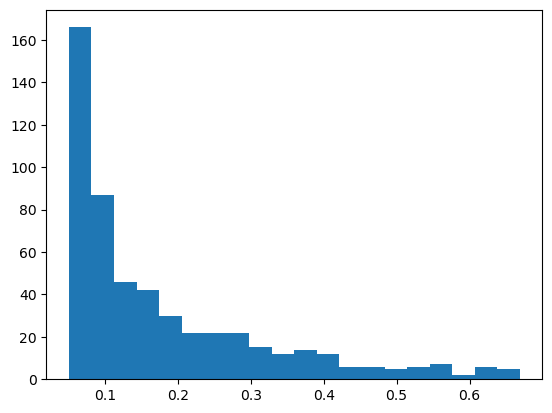

In [38]:
_ = plt.hist(bit_counter_pct, bins=20)

## Test Data 

In [39]:
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-A_selcols0570_HashOrder_test.csv'

In [40]:
df_test_x = pd.read_csv(TEST_INPUT_X )

In [41]:
df_test_x.info()
df_test_x.shape
df_test_x.columns
df_test_x.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Columns: 261 entries, Metadata_Source to Feature_249
dtypes: float64(254), int64(2), object(5)
memory usage: 25.1+ MB


(12600, 261)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_240', 'Feature_241', 'Feature_242', 'Feature_243', 'Feature_244', 'Feature_245', 'Feature_246', 'Feature_247',
       'Feature_248', 'Feature_249'],
      dtype='object', length=261)

Metadata_Source                  Metadata_Batch Metadata_Plate Metadata_Well Metadata_JCP2022        Metadata_Hash  \
0        source_9                   20210914-Run9     GR00003302           H45   JCP2022_004021  6703456398488902534   
1        source_9                   20210914-Run9     GR00003301           H21   JCP2022_004021  6703456398488902534   
2        source_9                   20210914-Run9     GR00003303           X45   JCP2022_004021  6703456398488902534   
3        source_3               CP_32_all_Phenix1       B40803aW           P21   JCP2022_102146  6704177726803547665   
4        source_6  p210928CPU2OS48hw384exp030JUMP   110000296383           P21   JCP2022_102146  6704177726803547665   

   Metadata_Bin  Metadata_TPSA  Metadata_lnTPSA  Metadata_log10TPSA  Metadata_Permiation  Feature_000  Feature_001  
0             6          58.04         4.061132            1.763727                  0.0     0.916451     0.872596  
1             6          58.04         4.061132            1.763727                  0.0     0.719237     0.682143  
2             6          58.04         4.061132            1.763727                  0.0     0.798004     0.805205  
3             1          86.51         4.460260            1.937066                  0.0    -0.134616    -0.200266  
4             1          86.51         4.460260            1.937066                  0.0    -0.031706    -0.148909

In [42]:
df_test_y = pd.read_csv(TEST_INPUT_Y )
df_train_y.shape
df_train_y.info()
# df_train_y.iloc[:3,:14]
df_train_y.iloc[:5, -34:]

(277200, 536)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 536 entries, Metadata_JCP2022 to 10688
dtypes: int64(535), object(1)
memory usage: 1.1+ GB


8752  8757  8762  8767  8993  9833  9862  9885  9889  9890  ...  10165  10190  10234  10236  10447  10452  10457  10462  10678  \
0     0     1     1     0     0     0     0     0     0     0  ...      0      0      1      0      0      0      0      0      1   
1     0     1     1     0     0     0     0     0     0     0  ...      0      0      1      0      0      0      0      0      1   
2     0     1     1     0     0     0     0     0     0     0  ...      0      0      1      0      0      0      0      0      1   
3     0     0     0     0     0     0     0     0     0     0  ...      0      0      0      0      0      0      0      0      0   
4     0     0     0     0     0     0     0     0     0     0  ...      0      0      0      0      0      0      0      0      0   

   10688  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 34 columns]

In [43]:
df_test_x.shape, type(df_test_x) 
df_test_y.shape, type(df_test_y)


((12600, 261), pandas.core.frame.DataFrame)

((12600, 536), pandas.core.frame.DataFrame)

## Other input preprocessing

### Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



### Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

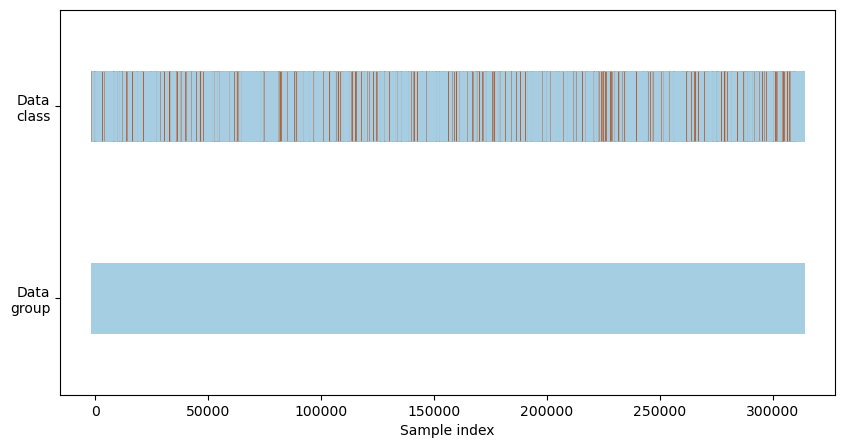

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

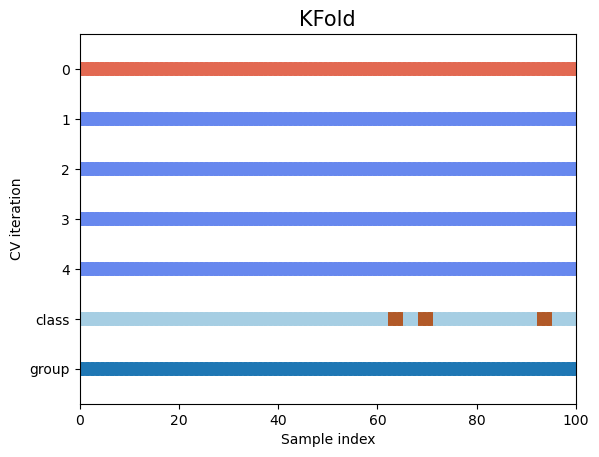

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

### Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# **[Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

## Setup

In [44]:
try:
    del X_DATA, Y_DATA, X_TEST, Y_TEST
except:
    pass
# train_y.head()

In [45]:
X_DATA = df_train_x.iloc[:, 11:]    ## bal_train_X
X_TEST = df_test_x.iloc[:, 11:] 


In [46]:
Best_Estimators = []
df_metrics = pd.DataFrame()

In [47]:
RANDOM_STATE = 6666
NUM_JOBS = 1
Y_OFFSET = 3
parm_C = 0.025
parm_solver = 'lbfgs'

In [48]:
# PARM_SET = lr_grid_parameters
# PARM_SET
# RANDOM_STATE
len(selected_label_indicies)
bit_counter_pct.shape
# # selected_label_indicies
# df_train_y.iloc[:10,0]
# df_train_y.iloc[:10,'0']

533

(533,)

In [54]:
i = 32
FP_BIT = selected_label_indicies[i]
df_col_number = i + Y_OFFSET
print(f" i: {i}  FP Bit: {FP_BIT}, col nbr(w/ offset): {df_col_number}   str_selected_label_indices: {str_selected_label_indicies[i]}")
selected_label_indicies[i], bit_counter_pct[i] 
df_train_y.iloc[1:10, df_col_number]
df_train_y.loc[1:10, str_selected_label_indicies[i]]

 i: 32  FP Bit: 78, col nbr(w/ offset): 35   str_selected_label_indices: 78


(78, 0.14502164502164502)

1    1
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 78, dtype: int64

1     1
2     1
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
Name: 78, dtype: int64

## Training

In [55]:
for i in range(len(selected_label_indicies)):
    df_col_number = i + Y_OFFSET
    FP_BIT = selected_label_indicies[i]
    FP_NAME = str_selected_label_indicies[i]
    print(f" Index: {i}  -- FP Bit: {FP_BIT} - Column name: {FP_NAME}")

    Y_DATA = df_train_y.iloc[:, df_col_number]
    Y_TEST = df_test_y.iloc[:, df_col_number]
    logreg = LogisticRegression(penalty = 'l2',
                                C=parm_C,
                                random_state = RANDOM_STATE,
                                max_iter = 5000,
                                tol = 1e-5,
                                n_jobs = 1,
                                class_weight=None,
                                solver = parm_solver,
                                verbose = 0)

    clf = logreg.fit(X_DATA, Y_DATA)
    Y_PRED = clf.predict(X_TEST)
    Y_SCORE = clf.predict_proba(X_TEST)

    compute_metrics(Y_TEST, Y_PRED)
    roc_auc = skm.roc_auc_score(Y_TEST, Y_SCORE[:,1])
    precisions, recalls, f1s, supports = skm.precision_recall_fscore_support(Y_TEST, Y_PRED)
    print(f" roc_auc: {roc_auc:.5f}")

    # reordered_col_names = ['Y_bit','param_C', 'param_solver',  'Y_bit_pct', 'mean_test_score',
    #                        'precision', 'accuracy', 'recall',  'f1', 'std_test_score',
    #                        'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
    #                        'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    #                        'params', 'random_seed']
    _tmp_dict = {'Y_bit'             : FP_BIT,
                 'Y_bit_pct'         : bit_counter_pct[i],
                 'param_C'           : parm_C,
                 'param_solver'      : parm_solver,
                 'mean_test_score'   : roc_auc,
                 'precision'         : precisions[1],
                 'accuracy'          : skm.accuracy_score(Y_TEST, Y_PRED,),
                 'recall'            : recalls[1],
                 'f1'                : f1s[1],
                 'Y_bit_description' : selected_label_descriptions[i],
                 'params'            : "none",
                 'random_seed'       : RANDOM_STATE}
    _tmp_df = pd.DataFrame(_tmp_dict, index = [FP_BIT])
    # _tmp_df

    df_metrics = pd.concat((df_metrics, _tmp_df))
    df_metrics.shape
    df_metrics

    # if i == 5:
    #     print(f" index: {i} FP_BIT: {FP_BIT} -- break")
    #     break

 Index: 0  -- FP Bit: 1 - Column name: 1
Classification Metrics
-----------------------
 Accuracy: 0.90746     Precision: 1.00000     Recall: 0.00086     F1: 0.00171 


 True + labels:          1167     ratio to total:  0.09262
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11434     ratio to total:  0.90746
 roc_auc: 0.59713


(1, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1      1   0.096894    0.025        lbfgs         0.597127        1.0   0.90746  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   

  params  random_seed  
1   none         6666

 Index: 1  -- FP Bit: 2 - Column name: 2
Classification Metrics
-----------------------
 Accuracy: 0.55802     Precision: 0.52553     Recall: 0.03133     F1: 0.05913 


 True + labels:          5586     ratio to total:  0.44333
 Predicted + labels:      333     ratio to total:  0.02643
 True/Predicted Match:   7031     ratio to total:  0.55802
 roc_auc: 0.55308


(2, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1      1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2      2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   

  params  random_seed  
1   none         6666  
2   none         6666

 Index: 2  -- FP Bit: 3 - Column name: 3
Classification Metrics
-----------------------
 Accuracy: 0.69778     Precision: 0.33333     Recall: 0.00184     F1: 0.00366 


 True + labels:          3801     ratio to total:  0.30167
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:   8792     ratio to total:  0.69778
 roc_auc: 0.53018


(3, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1      1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2      2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   
3      3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663  Acceptor Acceptor |0 3|3 0|   

  params  random_seed  
1   none         6666  
2   none         6666  
3   none         6666

 Index: 3  -- FP Bit: 6 - Column name: 6
Classification Metrics
-----------------------
 Accuracy: 0.59944     Precision: 0.60029     Recall: 0.99165     F1: 0.74786 


 True + labels:          7548     ratio to total:  0.59905
 Predicted + labels:    12469     ratio to total:  0.98960
 True/Predicted Match:   7553     ratio to total:  0.59944
 roc_auc: 0.55846


(4, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1      1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2      2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   
3      3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663  Acceptor Acceptor |0 3|3 0|   
6      6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864  Acceptor Aromatic |0 1|1 0|   

  params  random_seed  
1   none         6666  
2   none         6666  
3   none         6666  
6   none         6666

 Index: 4  -- FP Bit: 7 - Column name: 7
Classification Metrics
-----------------------
 Accuracy: 0.66365     Precision: 0.66531     Recall: 0.99487     F1: 0.79738 


 True + labels:          8382     ratio to total:  0.66524
 Predicted + labels:    12534     ratio to total:  0.99476
 True/Predicted Match:   8362     ratio to total:  0.66365
 roc_auc: 0.57724


(5, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1      1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2      2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   
3      3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663  Acceptor Acceptor |0 3|3 0|   
6      6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864  Acceptor Aromatic |0 1|1 0|   
7      7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380  Acceptor Aromatic |0 2|2 0|   

  params  random_seed  
1   none         6666  
2   none         6666  
3   none         6666  
6   none         6666  
7   none         6666

 Index: 5  -- FP Bit: 8 - Column name: 8
Classification Metrics
-----------------------
 Accuracy: 0.58016     Precision: 0.58448     Recall: 0.95525     F1: 0.72522 


 True + labels:          7308     ratio to total:  0.58000
 Predicted + labels:    11944     ratio to total:  0.94794
 True/Predicted Match:   7310     ratio to total:  0.58016
 roc_auc: 0.57185


(6, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1      1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2      2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   
3      3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663  Acceptor Acceptor |0 3|3 0|   
6      6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864  Acceptor Aromatic |0 1|1 0|   
7      7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380  Acceptor Aromatic |0 2|2 0|   
8      8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223  Acceptor Aromatic |0 3|3 0|   

  params  random_seed  
1   none         6666  
2   none         6666  
3   none         6666  
6   none         6666  
7   none         6666  
8   none         6666

 Index: 6  -- FP Bit: 12 - Column name: 12
Classification Metrics
-----------------------
 Accuracy: 0.52175     Precision: 0.51637     Recall: 0.89134     F1: 0.65392 


 True + labels:          6387     ratio to total:  0.50690
 Predicted + labels:    11025     ratio to total:  0.87500
 True/Predicted Match:   6574     ratio to total:  0.52175
 roc_auc: 0.54204


(7, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663  Acceptor Acceptor |0 3|3 0|   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864  Acceptor Aromatic |0 1|1 0|   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380  Acceptor Aromatic |0 2|2 0|   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223  Acceptor Aromatic |0 3|3 0|   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917     Acceptor Donor |0 2|2 0|   

   params  random_seed  
1    none         6666  
2    none         6666  
3    none         6666  
6    none         6666  
7    none         6666  
8    none         6666  
12   none         6666

 Index: 7  -- FP Bit: 13 - Column name: 13
Classification Metrics
-----------------------
 Accuracy: 0.68278     Precision: 0.46296     Recall: 0.00626     F1: 0.01235 


 True + labels:          3993     ratio to total:  0.31690
 Predicted + labels:       54     ratio to total:  0.00429
 True/Predicted Match:   8603     ratio to total:  0.68278
 roc_auc: 0.56472


(8, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712  Acceptor Acceptor |0 1|1 0|   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132  Acceptor Acceptor |0 2|2 0|   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663  Acceptor Acceptor |0 3|3 0|   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864  Acceptor Aromatic |0 1|1 0|   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380  Acceptor Aromatic |0 2|2 0|   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223  Acceptor Aromatic |0 3|3 0|   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917     Acceptor Donor |0 2|2 0|   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355     Acceptor Donor |0 3|3 0|   

   params  random_seed  
1    none         6666  
2    none         6666  
3    none         6666  
6    none         6666  
7    none         6666  
8    none         6666  
12   none         6666  
13   none         6666

 Index: 8  -- FP Bit: 18 - Column name: 18
Classification Metrics
-----------------------
 Accuracy: 0.57413     Precision: 0.57465     Recall: 0.99586     F1: 0.72877 


 True + labels:          7239     ratio to total:  0.57452
 Predicted + labels:    12545     ratio to total:  0.99563
 True/Predicted Match:   7234     ratio to total:  0.57413
 roc_auc: 0.54503


(9, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   

                Y_bit_description params  random_seed  
1     Acceptor Acceptor |0 1|1 0|   none         6666  
2     Acceptor Acceptor |0 2|2 0|   none         6666  
3     Acceptor Acceptor |0 3|3 0|   none         6666  
6     Acceptor Aromatic |0 1|1 0|   none         6666  
7     Acceptor Aromatic |0 2|2 0|   none         6666  
8     Acceptor Aromatic |0 3|3 0|   none         6666  
12       Acceptor Donor |0 2|2 0|   none         6666  
13       Acceptor Donor |0 3|3 0|   none         6666  
18  Acceptor Hydrophobe |0 3|3 0|   none         6666

 Index: 9  -- FP Bit: 21 - Column name: 21
Classification Metrics
-----------------------
 Accuracy: 0.54770     Precision: 0.57653     Recall: 0.16011     F1: 0.25062 


 True + labels:          5952     ratio to total:  0.47238
 Predicted + labels:     1653     ratio to total:  0.13119
 True/Predicted Match:   6901     ratio to total:  0.54770
 roc_auc: 0.57456


(10, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666

 Index: 10  -- FP Bit: 22 - Column name: 22
Classification Metrics
-----------------------
 Accuracy: 0.53214     Precision: 0.52500     Recall: 0.66571     F1: 0.58704 


 True + labels:          6294     ratio to total:  0.49952
 Predicted + labels:     7981     ratio to total:  0.63341
 True/Predicted Match:   6705     ratio to total:  0.53214
 roc_auc: 0.56363


(11, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666

 Index: 11  -- FP Bit: 23 - Column name: 23
Classification Metrics
-----------------------
 Accuracy: 0.56230     Precision: 0.59151     Recall: 0.14711     F1: 0.23562 


 True + labels:          5778     ratio to total:  0.45857
 Predicted + labels:     1437     ratio to total:  0.11405
 True/Predicted Match:   7085     ratio to total:  0.56230
 roc_auc: 0.57492


(12, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666

 Index: 12  -- FP Bit: 33 - Column name: 33
Classification Metrics
-----------------------
 Accuracy: 0.90222     Precision: 0.25000     Recall: 0.00081     F1: 0.00162 


 True + labels:          1230     ratio to total:  0.09762
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11368     ratio to total:  0.90222
 roc_auc: 0.60627


(13, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666

 Index: 13  -- FP Bit: 34 - Column name: 34
Classification Metrics
-----------------------
 Accuracy: 0.76524     Precision: 0.68367     Recall: 0.02238     F1: 0.04334 


 True + labels:          2994     ratio to total:  0.23762
 Predicted + labels:       98     ratio to total:  0.00778
 True/Predicted Match:   9642     ratio to total:  0.76524
 roc_auc: 0.62278


(14, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666

 Index: 14  -- FP Bit: 41 - Column name: 41
Classification Metrics
-----------------------
 Accuracy: 0.71143     Precision: 0.54128     Recall: 0.01619     F1: 0.03143 


 True + labels:          3645     ratio to total:  0.28929
 Predicted + labels:      109     ratio to total:  0.00865
 True/Predicted Match:   8964     ratio to total:  0.71143
 roc_auc: 0.58197


(15, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666

 Index: 15  -- FP Bit: 42 - Column name: 42
Classification Metrics
-----------------------
 Accuracy: 0.84302     Precision: 0.31818     Recall: 0.00714     F1: 0.01396 


 True + labels:          1962     ratio to total:  0.15571
 Predicted + labels:       44     ratio to total:  0.00349
 True/Predicted Match:  10622     ratio to total:  0.84302
 roc_auc: 0.58824


(16, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666

 Index: 16  -- FP Bit: 43 - Column name: 43
Classification Metrics
-----------------------
 Accuracy: 0.72548     Precision: 0.52284     Recall: 0.02970     F1: 0.05621 


 True + labels:          3468     ratio to total:  0.27524
 Predicted + labels:      197     ratio to total:  0.01563
 True/Predicted Match:   9141     ratio to total:  0.72548
 roc_auc: 0.60650


(17, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666

 Index: 17  -- FP Bit: 44 - Column name: 44
Classification Metrics
-----------------------
 Accuracy: 0.61698     Precision: 0.61865     Recall: 0.97457     F1: 0.75685 


 True + labels:          7707     ratio to total:  0.61167
 Predicted + labels:    12141     ratio to total:  0.96357
 True/Predicted Match:   7774     ratio to total:  0.61698
 roc_auc: 0.63931


(18, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666

 Index: 18  -- FP Bit: 46 - Column name: 46
Classification Metrics
-----------------------
 Accuracy: 0.70095     Precision: 0.51282     Recall: 0.03180     F1: 0.05988 


 True + labels:          3774     ratio to total:  0.29952
 Predicted + labels:      234     ratio to total:  0.01857
 True/Predicted Match:   8832     ratio to total:  0.70095
 roc_auc: 0.58243


(19, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666

 Index: 19  -- FP Bit: 47 - Column name: 47
Classification Metrics
-----------------------
 Accuracy: 0.53595     Precision: 0.56275     Recall: 0.29047     F1: 0.38316 


 True + labels:          6252     ratio to total:  0.49619
 Predicted + labels:     3227     ratio to total:  0.25611
 True/Predicted Match:   6753     ratio to total:  0.53595
 roc_auc: 0.55600


(20, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666  
47             Aromatic Donor |0 2|2 0|   none         6666

 Index: 20  -- FP Bit: 48 - Column name: 48
Classification Metrics
-----------------------
 Accuracy: 0.62286     Precision: 0.52903     Recall: 0.01722     F1: 0.03336 


 True + labels:          4761     ratio to total:  0.37786
 Predicted + labels:      155     ratio to total:  0.01230
 True/Predicted Match:   7848     ratio to total:  0.62286
 roc_auc: 0.54000


(21, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666  
47             Aromatic Donor |0 2|2 0|   none         6666  
48             Aromatic Donor |0 3|3 0|   none         6666

 Index: 21  -- FP Bit: 51 - Column name: 51
Classification Metrics
-----------------------
 Accuracy: 0.54429     Precision: 0.61597     Recall: 0.15790     F1: 0.25137 


 True + labels:          6105     ratio to total:  0.48452
 Predicted + labels:     1565     ratio to total:  0.12421
 True/Predicted Match:   6858     ratio to total:  0.54429
 roc_auc: 0.56504


(22, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666  
47             Aromatic Donor |0 2|2 0|   none         6666  
48             Aromatic Donor |0 3|3 0|   none         6666  
51        Aromatic Hydrophobe |0 1|1 0|   none         6666

 Index: 22  -- FP Bit: 52 - Column name: 52
Classification Metrics
-----------------------
 Accuracy: 0.62198     Precision: 0.55600     Recall: 0.02901     F1: 0.05515 


 True + labels:          4791     ratio to total:  0.38024
 Predicted + labels:      250     ratio to total:  0.01984
 True/Predicted Match:   7837     ratio to total:  0.62198
 roc_auc: 0.55926


(23, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666  
47             Aromatic Donor |0 2|2 0|   none         6666  
48             Aromatic Donor |0 3|3 0|   none         6666  
51        Aromatic Hydrophobe |0 1|1 0|   none         6666  
52        Aromatic Hydrophobe |0 2|2 0|   none         6666

 Index: 23  -- FP Bit: 53 - Column name: 53
Classification Metrics
-----------------------
 Accuracy: 0.58929     Precision: 0.63444     Recall: 0.11577     F1: 0.19580 


 True + labels:          5442     ratio to total:  0.43190
 Predicted + labels:      993     ratio to total:  0.07881
 True/Predicted Match:   7425     ratio to total:  0.58929
 roc_auc: 0.59986


(24, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666  
47             Aromatic Donor |0 2|2 0|   none         6666  
48             Aromatic Donor |0 3|3 0|   none         6666  
51        Aromatic Hydrophobe |0 1|1 0|

 Index: 24  -- FP Bit: 56 - Column name: 56
Classification Metrics
-----------------------
 Accuracy: 0.69905     Precision: 0.63846     Recall: 0.02168     F1: 0.04194 


 True + labels:          3828     ratio to total:  0.30381
 Predicted + labels:      130     ratio to total:  0.01032
 True/Predicted Match:   8808     ratio to total:  0.69905
 roc_auc: 0.58188


(25, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Aromatic Donor |0 1|1 0|   none         6666  
47             Aromatic Donor |0 2|2 0|   none         6666

 Index: 25  -- FP Bit: 57 - Column name: 57
Classification Metrics
-----------------------
 Accuracy: 0.84651     Precision: 0.20690     Recall: 0.00313     F1: 0.00617 


 True + labels:          1917     ratio to total:  0.15214
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  10666     ratio to total:  0.84651
 roc_auc: 0.58456


(26, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 0|   none         6666  
44          Aromatic Aromatic |0 4|4 0|   none         6666  
46             Ar

 Index: 26  -- FP Bit: 58 - Column name: 58
Classification Metrics
-----------------------
 Accuracy: 0.73500     Precision: 0.59474     Recall: 0.03348     F1: 0.06339 


 True + labels:          3375     ratio to total:  0.26786
 Predicted + labels:      190     ratio to total:  0.01508
 True/Predicted Match:   9261     ratio to total:  0.73500
 roc_auc: 0.61291


(27, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         6666  
42          Aromatic Aromatic |0 2|2 0|   none         6666  
43          Aromatic Aromatic |0 3|3 

 Index: 27  -- FP Bit: 59 - Column name: 59
Classification Metrics
-----------------------
 Accuracy: 0.64056     Precision: 0.64339     Recall: 0.97973     F1: 0.77671 


 True + labels:          8040     ratio to total:  0.63810
 Predicted + labels:    12243     ratio to total:  0.97167
 True/Predicted Match:   8071     ratio to total:  0.64056
 roc_auc: 0.64346


(28, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Acceptor PosIonizable |0 4|4 0|   none         6666  
41          Aromatic Aromatic |0 1|1 0|   none         66

 Index: 28  -- FP Bit: 67 - Column name: 67
Classification Metrics
-----------------------
 Accuracy: 0.89841     Precision: 0.30769     Recall: 0.00314     F1: 0.00621 


 True + labels:          1275     ratio to total:  0.10119
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11320     ratio to total:  0.89841
 roc_auc: 0.61755


(29, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|3 0|   none         6666  
33      Acceptor PosIonizable |0 3|3 0|   none         6666  
34      Accepto

 Index: 29  -- FP Bit: 69 - Column name: 69
Classification Metrics
-----------------------
 Accuracy: 0.79833     Precision: 0.77273     Recall: 0.02626     F1: 0.05080 


 True + labels:          2589     ratio to total:  0.20548
 Predicted + labels:       88     ratio to total:  0.00698
 True/Predicted Match:  10059     ratio to total:  0.79833
 roc_auc: 0.61856


(30, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         6666  
22  Acceptor LumpedHydrophobe |0 2|2 0|   none         6666  
23  Acceptor LumpedHydrophobe |0 3|

 Index: 30  -- FP Bit: 76 - Column name: 76
Classification Metrics
-----------------------
 Accuracy: 0.94405     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           705     ratio to total:  0.05595
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11895     ratio to total:  0.94405
 roc_auc: 0.55945


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(31, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acceptor Hydrophobe |0 3|3 0|   none         6666  
21  Acceptor LumpedHydrophobe |0 1|1 0|   none         

 Index: 31  -- FP Bit: 77 - Column name: 77
Classification Metrics
-----------------------
 Accuracy: 0.86429     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1710     ratio to total:  0.13571
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  10890     ratio to total:  0.86429
 roc_auc: 0.56580


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(32, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 2|2 0|   none         6666  
13             Acceptor Donor |0 3|3 0|   none         6666  
18        Acc

 Index: 32  -- FP Bit: 78 - Column name: 78
Classification Metrics
-----------------------
 Accuracy: 0.85437     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1833     ratio to total:  0.14548
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  10765     ratio to total:  0.85437
 roc_auc: 0.58305


(33, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none         6666  
8           Acceptor Aromatic |0 3|3 0|   none         6666  
12             Acceptor Donor |0 

 Index: 33  -- FP Bit: 79 - Column name: 79
Classification Metrics
-----------------------
 Accuracy: 0.64905     Precision: 0.56696     Recall: 0.02853     F1: 0.05432 


 True + labels:          4452     ratio to total:  0.35333
 Predicted + labels:      224     ratio to total:  0.01778
 True/Predicted Match:   8178     ratio to total:  0.64905
 roc_auc: 0.58783


(34, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6           Acceptor Aromatic |0 1|1 0|   none         6666  
7           Acceptor Aromatic |0 2|2 0|   none       

 Index: 34  -- FP Bit: 82 - Column name: 82
Classification Metrics
-----------------------
 Accuracy: 0.63698     Precision: 0.63728     Recall: 0.99863     F1: 0.77805 


 True + labels:          8028     ratio to total:  0.63714
 Predicted + labels:    12580     ratio to total:  0.99841
 True/Predicted Match:   8026     ratio to total:  0.63698
 roc_auc: 0.54192


(35, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |0 2|2 0|   none         6666  
3           Acceptor Acceptor |0 3|3 0|   none         6666  
6          

 Index: 35  -- FP Bit: 83 - Column name: 83
Classification Metrics
-----------------------
 Accuracy: 0.62683     Precision: 0.64356     Recall: 0.01374     F1: 0.02690 


 True + labels:          4731     ratio to total:  0.37548
 Predicted + labels:      101     ratio to total:  0.00802
 True/Predicted Match:   7898     ratio to total:  0.62683
 roc_auc: 0.53519


(36, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   

                      Y_bit_description params  random_seed  
1           Acceptor Acceptor |0 1|1 0|   none         6666  
2           Acceptor Acceptor |

 Index: 36  -- FP Bit: 86 - Column name: 86
Classification Metrics
-----------------------
 Accuracy: 0.79730     Precision: 0.37500     Recall: 0.00946     F1: 0.01845 


 True + labels:          2538     ratio to total:  0.20143
 Predicted + labels:       64     ratio to total:  0.00508
 True/Predicted Match:  10046     ratio to total:  0.79730
 roc_auc: 0.58896


(37, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86     86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   

                      Y_bit_description params  ran

 Index: 37  -- FP Bit: 87 - Column name: 87
Classification Metrics
-----------------------
 Accuracy: 0.67952     Precision: 0.35714     Recall: 0.00373     F1: 0.00737 


 True + labels:          4026     ratio to total:  0.31952
 Predicted + labels:       42     ratio to total:  0.00333
 True/Predicted Match:   8562     ratio to total:  0.67952
 roc_auc: 0.54110


(38, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86     86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87     87   0.330335    0.025        lbfgs         0

 Index: 38  -- FP Bit: 88 - Column name: 88
Classification Metrics
-----------------------
 Accuracy: 0.72206     Precision: 0.64865     Recall: 0.00683     F1: 0.01352 


 True + labels:          3513     ratio to total:  0.27881
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:   9098     ratio to total:  0.72206
 roc_auc: 0.56013


(39, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86     86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87     87   0.330335    0.025        lbfgs         0

 Index: 39  -- FP Bit: 89 - Column name: 89
Classification Metrics
-----------------------
 Accuracy: 0.64619     Precision: 0.64632     Recall: 0.99889     F1: 0.78482 


 True + labels:          8139     ratio to total:  0.64595
 Predicted + labels:    12579     ratio to total:  0.99833
 True/Predicted Match:   8142     ratio to total:  0.64619
 roc_auc: 0.55583


(40, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86     86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87     87   0.330335    0.025        lbfgs         0

 Index: 40  -- FP Bit: 98 - Column name: 98
Classification Metrics
-----------------------
 Accuracy: 0.91222     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1104     ratio to total:  0.08762
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11494     ratio to total:  0.91222
 roc_auc: 0.60713


(41, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86     86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87     87   0.330335    0.025        lbfgs         0

 Index: 41  -- FP Bit: 99 - Column name: 99
Classification Metrics
-----------------------
 Accuracy: 0.84103     Precision: 0.60870     Recall: 0.01391     F1: 0.02720 


 True + labels:          2013     ratio to total:  0.15976
 Predicted + labels:       46     ratio to total:  0.00365
 True/Predicted Match:  10597     ratio to total:  0.84103
 roc_auc: 0.63446


(42, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1       1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2       2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3       3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6       6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7       7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8       8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12     12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13     13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18     18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21     21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22     22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23     23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34     34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41     41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42     42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44     44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46     46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47     47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48     48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51     51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52     52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53     53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56     56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57     57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59     59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69     69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76     76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77     77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78     78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79     79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82     82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83     83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86     86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87     87   0.330335    0.025        lbfgs         0

 Index: 42  -- FP Bit: 106 - Column name: 106
Classification Metrics
-----------------------
 Accuracy: 0.55294     Precision: 0.56829     Recall: 0.08538     F1: 0.14845 


 True + labels:          5751     ratio to total:  0.45643
 Predicted + labels:      864     ratio to total:  0.06857
 True/Predicted Match:   6967     ratio to total:  0.55294
 roc_auc: 0.55833


(43, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 43  -- FP Bit: 107 - Column name: 107
Classification Metrics
-----------------------
 Accuracy: 0.60952     Precision: 0.57000     Recall: 0.03446     F1: 0.06499 


 True + labels:          4962     ratio to total:  0.39381
 Predicted + labels:      300     ratio to total:  0.02381
 True/Predicted Match:   7680     ratio to total:  0.60952
 roc_auc: 0.57249


(44, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 44  -- FP Bit: 108 - Column name: 108
Classification Metrics
-----------------------
 Accuracy: 0.72984     Precision: 0.41803     Recall: 0.01507     F1: 0.02909 


 True + labels:          3384     ratio to total:  0.26857
 Predicted + labels:      122     ratio to total:  0.00968
 True/Predicted Match:   9196     ratio to total:  0.72984
 roc_auc: 0.58273


(45, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 45  -- FP Bit: 109 - Column name: 109
Classification Metrics
-----------------------
 Accuracy: 0.64087     Precision: 0.64162     Recall: 0.99653     F1: 0.78063 


 True + labels:          8079     ratio to total:  0.64119
 Predicted + labels:    12548     ratio to total:  0.99587
 True/Predicted Match:   8075     ratio to total:  0.64087
 roc_auc: 0.58037


(46, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 46  -- FP Bit: 111 - Column name: 111
Classification Metrics
-----------------------
 Accuracy: 0.74683     Precision: 0.45833     Recall: 0.00691     F1: 0.01361 


 True + labels:          3186     ratio to total:  0.25286
 Predicted + labels:       48     ratio to total:  0.00381
 True/Predicted Match:   9410     ratio to total:  0.74683
 roc_auc: 0.58870


(47, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 47  -- FP Bit: 112 - Column name: 112
Classification Metrics
-----------------------
 Accuracy: 0.79817     Precision: 0.38235     Recall: 0.00513     F1: 0.01012 


 True + labels:          2535     ratio to total:  0.20119
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:  10057     ratio to total:  0.79817
 roc_auc: 0.58775


(48, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 48  -- FP Bit: 113 - Column name: 113
Classification Metrics
-----------------------
 Accuracy: 0.70508     Precision: 0.50926     Recall: 0.02957     F1: 0.05589 


 True + labels:          3720     ratio to total:  0.29524
 Predicted + labels:      216     ratio to total:  0.01714
 True/Predicted Match:   8884     ratio to total:  0.70508
 roc_auc: 0.61618


(49, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 49  -- FP Bit: 114 - Column name: 114
Classification Metrics
-----------------------
 Accuracy: 0.66810     Precision: 0.67019     Recall: 0.98941     F1: 0.79910 


 True + labels:          8406     ratio to total:  0.66714
 Predicted + labels:    12410     ratio to total:  0.98492
 True/Predicted Match:   8418     ratio to total:  0.66810
 roc_auc: 0.62209


(50, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 50  -- FP Bit: 122 - Column name: 122
Classification Metrics
-----------------------
 Accuracy: 0.85746     Precision: 0.46667     Recall: 0.00780     F1: 0.01535 


 True + labels:          1794     ratio to total:  0.14238
 Predicted + labels:       30     ratio to total:  0.00238
 True/Predicted Match:  10804     ratio to total:  0.85746
 roc_auc: 0.60857


(51, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 51  -- FP Bit: 123 - Column name: 123
Classification Metrics
-----------------------
 Accuracy: 0.92786     Precision: 0.71429     Recall: 0.00548     F1: 0.01088 


 True + labels:           912     ratio to total:  0.07238
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11691     ratio to total:  0.92786
 roc_auc: 0.62589


(52, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 52  -- FP Bit: 124 - Column name: 124
Classification Metrics
-----------------------
 Accuracy: 0.80548     Precision: 0.80723     Recall: 0.02678     F1: 0.05184 


 True + labels:          2502     ratio to total:  0.19857
 Predicted + labels:       83     ratio to total:  0.00659
 True/Predicted Match:  10149     ratio to total:  0.80548
 roc_auc: 0.62082


(53, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 53  -- FP Bit: 131 - Column name: 131
Classification Metrics
-----------------------
 Accuracy: 0.94206     Precision: 0.40000     Recall: 0.00274     F1: 0.00545 


 True + labels:           729     ratio to total:  0.05786
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11870     ratio to total:  0.94206
 roc_auc: 0.62833


(54, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 54  -- FP Bit: 133 - Column name: 133
Classification Metrics
-----------------------
 Accuracy: 0.88246     Precision: 0.10345     Recall: 0.00206     F1: 0.00403 


 True + labels:          1458     ratio to total:  0.11571
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  11119     ratio to total:  0.88246
 roc_auc: 0.63966


(55, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 55  -- FP Bit: 134 - Column name: 134
Classification Metrics
-----------------------
 Accuracy: 0.62913     Precision: 0.62246     Recall: 0.14222     F1: 0.23154 


 True + labels:          4950     ratio to total:  0.39286
 Predicted + labels:     1131     ratio to total:  0.08976
 True/Predicted Match:   7927     ratio to total:  0.62913
 roc_auc: 0.64621


(56, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 56  -- FP Bit: 142 - Column name: 142
Classification Metrics
-----------------------
 Accuracy: 0.93992     Precision: 0.40000     Recall: 0.00265     F1: 0.00526 


 True + labels:           756     ratio to total:  0.06000
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11843     ratio to total:  0.93992
 roc_auc: 0.60226


(57, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 57  -- FP Bit: 144 - Column name: 144
Classification Metrics
-----------------------
 Accuracy: 0.82937     Precision: 0.83562     Recall: 0.02774     F1: 0.05370 


 True + labels:          2199     ratio to total:  0.17452
 Predicted + labels:       73     ratio to total:  0.00579
 True/Predicted Match:  10450     ratio to total:  0.82937
 roc_auc: 0.59899


(58, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 58  -- FP Bit: 286 - Column name: 286
Classification Metrics
-----------------------
 Accuracy: 0.95230     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           600     ratio to total:  0.04762
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11999     ratio to total:  0.95230
 roc_auc: 0.54387


(59, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 59  -- FP Bit: 289 - Column name: 289
Classification Metrics
-----------------------
 Accuracy: 0.91540     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1065     ratio to total:  0.08452
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11534     ratio to total:  0.91540
 roc_auc: 0.59297


(60, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
8        8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
12      12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
13      13   0.326115    0.025        lbfgs         0.564722   0.462963  0.682778  0.006261  0.012355   
18      18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
21      21   0.467186    0.025        lbfgs         0.574559   0.576528  0.547698  0.160114  0.250625   
22      22   0.503626    0.025        lbfgs         0.563635   0.524997  0.532143  0.665713  0.587040   
23      23   0.459513    0.025        lbfgs         0.574925   0.591510  0.562302  0.147110  0.235620   
33      33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
34      34   0.242641    0.025        lbfgs         0.622779   0.683673  0.765238  0.022378  0.043338   
41      41   0.290238    0.025        lbfgs         0.581974   0.541284  0.711429  0.016187  0.031433   
42      42   0.156526    0.025        lbfgs         0.588244   0.318182  0.843016  0.007136  0.013958   
43      43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
44      44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
46      46   0.296905    0.025        lbfgs         0.582433   0.512821  0.700952  0.031797  0.059880   
47      47   0.497716    0.025        lbfgs         0.555997   0.562752  0.535952  0.290467  0.383163   
48      48   0.384794    0.025        lbfgs         0.539998   0.529032  0.622857  0.017223  0.033360   
51      51   0.479188    0.025        lbfgs         0.565037   0.615974  0.544286  0.157903  0.251369   
52      52   0.374729    0.025        lbfgs         0.559258   0.556000  0.621984  0.029013  0.055148   
53      53   0.419361    0.025        lbfgs         0.599862   0.634441  0.589286  0.115766  0.195804   
56      56   0.306190    0.025        lbfgs         0.581880   0.638462  0.699048  0.021682  0.041940   
57      57   0.151732    0.025        lbfgs         0.584561   0.206897  0.846508  0.003130  0.006166   
58      58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
59      59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
67      67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
69      69   0.204946    0.025        lbfgs         0.618558   0.772727  0.798333  0.026265  0.050803   
76      76   0.057229    0.025        lbfgs         0.559449   0.000000  0.944048  0.000000  0.000000   
77      77   0.139470    0.025        lbfgs         0.565803   0.000000  0.864286  0.000000  0.000000   
78      78   0.145022    0.025        lbfgs         0.583053   0.000000  0.854365  0.000000  0.000000   
79      79   0.360108    0.025        lbfgs         0.587828   0.566964  0.649048  0.028527  0.054320   
82      82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
83      83   0.371201    0.025        lbfgs         0.535190   0.643564  0.626825  0.013739  0.026904   
86      86   0.194015    0.025        lbfgs         0.588965   0.375000  0.797302  0.009456  0.018447   
87      87   0.

 Index: 60  -- FP Bit: 290 - Column name: 290
Classification Metrics
-----------------------
 Accuracy: 0.59817     Precision: 0.47619     Recall: 0.00395     F1: 0.00784 


 True + labels:          5061     ratio to total:  0.40167
 Predicted + labels:       42     ratio to total:  0.00333
 True/Predicted Match:   7537     ratio to total:  0.59817
 roc_auc: 0.54942


(61, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
142    142   0.067522    0.025        lbfgs         0.602260   0.400000  0.939921  0.002646  0.005256   
144    144   0.172738    0.025        lbfgs         0.598990   0.835616  0.829365  0.027740  0.053697   
286    286   0.053918    0.025        lbfgs         0.543871   0.000000  0.952302  0.000000  0.000000   
289    289   0.087619    0.025        lbfgs         0.592972   0.000000  0.915397  0.000000  0.000000   
290    290   0.415206    0.025        lbfgs         0.549423   0.476190  0.598175  0.003952  0.007839   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
142         LumpedHydrophobe PosIonizable |0 2|2 0|   none         6666  
144         LumpedHydrophobe PosIonizable |0 4|4 0|   none         6666  
286  Acceptor Acceptor Acceptor |0 4 3|4 0 3|3 3 0|   none         6666  
289  Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|   none         6666  
290  Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|   none         6666  

[61 rows x 12 columns]

 Index: 61  -- FP Bit: 291 - Column name: 291
Classification Metrics
-----------------------
 Accuracy: 0.73794     Precision: 0.22222     Recall: 0.00061     F1: 0.00121 


 True + labels:          3297     ratio to total:  0.26167
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:   9298     ratio to total:  0.73794
 roc_auc: 0.53561


(62, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
144    144   0.172738    0.025        lbfgs         0.598990   0.835616  0.829365  0.027740  0.053697   
286    286   0.053918    0.025        lbfgs         0.543871   0.000000  0.952302  0.000000  0.000000   
289    289   0.087619    0.025        lbfgs         0.592972   0.000000  0.915397  0.000000  0.000000   
290    290   0.415206    0.025        lbfgs         0.549423   0.476190  0.598175  0.003952  0.007839   
291    291   0.271894    0.025        lbfgs         0.535615   0.222222  0.737937  0.000607  0.001210   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
144         LumpedHydrophobe PosIonizable |0 4|4 0|   none         6666  
286  Acceptor Acceptor Acceptor |0 4 3|4 0 3|3 3 0|   none         6666  
289  Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|   none         6666  
290  Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|   none         6666  
291  Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|   none         6666  

[62 rows x 12 columns]

 Index: 62  -- FP Bit: 292 - Column name: 292
Classification Metrics
-----------------------
 Accuracy: 0.53976     Precision: 0.53993     Recall: 0.95513     F1: 0.68988 


 True + labels:          6753     ratio to total:  0.53595
 Predicted + labels:    11946     ratio to total:  0.94810
 True/Predicted Match:   6801     ratio to total:  0.53976
 roc_auc: 0.52881


(63, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
286    286   0.053918    0.025        lbfgs         0.543871   0.000000  0.952302  0.000000  0.000000   
289    289   0.087619    0.025        lbfgs         0.592972   0.000000  0.915397  0.000000  0.000000   
290    290   0.415206    0.025        lbfgs         0.549423   0.476190  0.598175  0.003952  0.007839   
291    291   0.271894    0.025        lbfgs         0.535615   0.222222  0.737937  0.000607  0.001210   
292    292   0.543972    0.025        lbfgs         0.528814   0.539930  0.539762  0.955131  0.689876   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
286  Acceptor Acceptor Acceptor |0 4 3|4 0 3|3 3 0|   none         6666  
289  Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|   none         6666  
290  Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|   none         6666  
291  Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|   none         6666  
292  Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|   none         6666  

[63 rows x 12 columns]

 Index: 63  -- FP Bit: 334 - Column name: 334
Classification Metrics
-----------------------
 Accuracy: 0.92714     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           918     ratio to total:  0.07286
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11682     ratio to total:  0.92714
 roc_auc: 0.57628


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(64, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
289    289   0.087619    0.025        lbfgs         0.592972   0.000000  0.915397  0.000000  0.000000   
290    290   0.415206    0.025        lbfgs         0.549423   0.476190  0.598175  0.003952  0.007839   
291    291   0.271894    0.025        lbfgs         0.535615   0.222222  0.737937  0.000607  0.001210   
292    292   0.543972    0.025        lbfgs         0.528814   0.539930  0.539762  0.955131  0.689876   
334    334   0.077771    0.025        lbfgs         0.576275   0.000000  0.927143  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
289  Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|   none         6666  
290  Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|   none         6666  
291  Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|   none         6666  
292  Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|   none         6666  
334  Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|   none         6666  

[64 rows x 12 columns]

 Index: 64  -- FP Bit: 347 - Column name: 347
Classification Metrics
-----------------------
 Accuracy: 0.78833     Precision: 0.50000     Recall: 0.00037     F1: 0.00075 


 True + labels:          2667     ratio to total:  0.21167
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:   9933     ratio to total:  0.78833
 roc_auc: 0.56566


(65, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
290    290   0.415206    0.025        lbfgs         0.549423   0.476190  0.598175  0.003952  0.007839   
291    291   0.271894    0.025        lbfgs         0.535615   0.222222  0.737937  0.000607  0.001210   
292    292   0.543972    0.025        lbfgs         0.528814   0.539930  0.539762  0.955131  0.689876   
334    334   0.077771    0.025        lbfgs         0.576275   0.000000  0.927143  0.000000  0.000000   
347    347   0.215476    0.025        lbfgs         0.565664   0.500000  0.788333  0.000375  0.000749   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
290  Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|   none         6666  
291  Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|   none         6666  
292  Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|   none         6666  
334  Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|   none         6666  
347  Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|   none         6666  

[65 rows x 12 columns]

 Index: 65  -- FP Bit: 353 - Column name: 353
Classification Metrics
-----------------------
 Accuracy: 0.91786     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1035     ratio to total:  0.08214
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11565     ratio to total:  0.91786
 roc_auc: 0.56535


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(66, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
291    291   0.271894    0.025        lbfgs         0.535615   0.222222  0.737937  0.000607  0.001210   
292    292   0.543972    0.025        lbfgs         0.528814   0.539930  0.539762  0.955131  0.689876   
334    334   0.077771    0.025        lbfgs         0.576275   0.000000  0.927143  0.000000  0.000000   
347    347   0.215476    0.025        lbfgs         0.565664   0.500000  0.788333  0.000375  0.000749   
353    353   0.079794    0.025        lbfgs         0.565346   0.000000  0.917857  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
291  Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|   none         6666  
292  Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|   none         6666  
334  Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|   none         6666  
347  Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|   none         6666  
353  Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|   none         6666  

[66 rows x 12 columns]

 Index: 66  -- FP Bit: 359 - Column name: 359
Classification Metrics
-----------------------
 Accuracy: 0.64214     Precision: 0.71429     Recall: 0.00111     F1: 0.00221 


 True + labels:          4512     ratio to total:  0.35810
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:   8091     ratio to total:  0.64214
 roc_auc: 0.53409


(67, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
292    292   0.543972    0.025        lbfgs         0.528814   0.539930  0.539762  0.955131  0.689876   
334    334   0.077771    0.025        lbfgs         0.576275   0.000000  0.927143  0.000000  0.000000   
347    347   0.215476    0.025        lbfgs         0.565664   0.500000  0.788333  0.000375  0.000749   
353    353   0.079794    0.025        lbfgs         0.565346   0.000000  0.917857  0.000000  0.000000   
359    359   0.365000    0.025        lbfgs         0.534085   0.714286  0.642143  0.001108  0.002213   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
292  Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|   none         6666  
334  Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|   none         6666  
347  Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|   none         6666  
353  Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|   none         6666  
359  Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|   none         6666  

[67 rows x 12 columns]

 Index: 67  -- FP Bit: 365 - Column name: 365
Classification Metrics
-----------------------
 Accuracy: 0.91119     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1119     ratio to total:  0.08881
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11481     ratio to total:  0.91119
 roc_auc: 0.54945


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(68, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
334    334   0.077771    0.025        lbfgs         0.576275   0.000000  0.927143  0.000000  0.000000   
347    347   0.215476    0.025        lbfgs         0.565664   0.500000  0.788333  0.000375  0.000749   
353    353   0.079794    0.025        lbfgs         0.565346   0.000000  0.917857  0.000000  0.000000   
359    359   0.365000    0.025        lbfgs         0.534085   0.714286  0.642143  0.001108  0.002213   
365    365   0.082262    0.025        lbfgs         0.549448   0.000000  0.911190  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
334  Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|   none         6666  
347  Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|   none         6666  
353  Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|   none         6666  
359  Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|   none         6666  
365  Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  

[68 rows x 12 columns]

 Index: 68  -- FP Bit: 380 - Column name: 380
Classification Metrics
-----------------------
 Accuracy: 0.94262     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           723     ratio to total:  0.05738
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11877     ratio to total:  0.94262
 roc_auc: 0.50520


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(69, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
347    347   0.215476    0.025        lbfgs         0.565664   0.500000  0.788333  0.000375  0.000749   
353    353   0.079794    0.025        lbfgs         0.565346   0.000000  0.917857  0.000000  0.000000   
359    359   0.365000    0.025        lbfgs         0.534085   0.714286  0.642143  0.001108  0.002213   
365    365   0.082262    0.025        lbfgs         0.549448   0.000000  0.911190  0.000000  0.000000   
380    380   0.058701    0.025        lbfgs         0.505200   0.000000  0.942619  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
347  Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|   none         6666  
353  Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|   none         6666  
359  Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|   none         6666  
365  Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
380  Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|   none         6666  

[69 rows x 12 columns]

 Index: 69  -- FP Bit: 381 - Column name: 381
Classification Metrics
-----------------------
 Accuracy: 0.94302     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           717     ratio to total:  0.05690
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11882     ratio to total:  0.94302
 roc_auc: 0.53915


(70, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
353    353   0.079794    0.025        lbfgs         0.565346   0.000000  0.917857  0.000000  0.000000   
359    359   0.365000    0.025        lbfgs         0.534085   0.714286  0.642143  0.001108  0.002213   
365    365   0.082262    0.025        lbfgs         0.549448   0.000000  0.911190  0.000000  0.000000   
380    380   0.058701    0.025        lbfgs         0.505200   0.000000  0.942619  0.000000  0.000000   
381    381   0.055465    0.025        lbfgs         0.539152   0.000000  0.943016  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
353  Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|   none         6666  
359  Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|   none         6666  
365  Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
380  Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|   none         6666  
381  Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|   none         6666  

[70 rows x 12 columns]

 Index: 70  -- FP Bit: 382 - Column name: 382
Classification Metrics
-----------------------
 Accuracy: 0.92738     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           915     ratio to total:  0.07262
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11685     ratio to total:  0.92738
 roc_auc: 0.54576


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(71, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
359    359   0.365000    0.025        lbfgs         0.534085   0.714286  0.642143  0.001108  0.002213   
365    365   0.082262    0.025        lbfgs         0.549448   0.000000  0.911190  0.000000  0.000000   
380    380   0.058701    0.025        lbfgs         0.505200   0.000000  0.942619  0.000000  0.000000   
381    381   0.055465    0.025        lbfgs         0.539152   0.000000  0.943016  0.000000  0.000000   
382    382   0.077240    0.025        lbfgs         0.545759   0.000000  0.927381  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
359  Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|   none         6666  
365  Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
380  Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|   none         6666  
381  Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|   none         6666  
382  Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|   none         6666  

[71 rows x 12 columns]

 Index: 71  -- FP Bit: 383 - Column name: 383
Classification Metrics
-----------------------
 Accuracy: 0.77817     Precision: 0.25000     Recall: 0.00036     F1: 0.00072 


 True + labels:          2793     ratio to total:  0.22167
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:   9805     ratio to total:  0.77817
 roc_auc: 0.55108


(72, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
365    365   0.082262    0.025        lbfgs         0.549448   0.000000  0.911190  0.000000  0.000000   
380    380   0.058701    0.025        lbfgs         0.505200   0.000000  0.942619  0.000000  0.000000   
381    381   0.055465    0.025        lbfgs         0.539152   0.000000  0.943016  0.000000  0.000000   
382    382   0.077240    0.025        lbfgs         0.545759   0.000000  0.927381  0.000000  0.000000   
383    383   0.224113    0.025        lbfgs         0.551080   0.250000  0.778175  0.000358  0.000715   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
365  Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
380  Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|   none         6666  
381  Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|   none         6666  
382  Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|   none         6666  
383  Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|   none         6666  

[72 rows x 12 columns]

 Index: 72  -- FP Bit: 387 - Column name: 387
Classification Metrics
-----------------------
 Accuracy: 0.90190     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1236     ratio to total:  0.09810
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11364     ratio to total:  0.90190
 roc_auc: 0.54315


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(73, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
380    380   0.058701    0.025        lbfgs         0.505200   0.000000  0.942619  0.000000  0.000000   
381    381   0.055465    0.025        lbfgs         0.539152   0.000000  0.943016  0.000000  0.000000   
382    382   0.077240    0.025        lbfgs         0.545759   0.000000  0.927381  0.000000  0.000000   
383    383   0.224113    0.025        lbfgs         0.551080   0.250000  0.778175  0.000358  0.000715   
387    387   0.098745    0.025        lbfgs         0.543149   0.000000  0.901905  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
380  Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|   none         6666  
381  Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|   none         6666  
382  Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|   none         6666  
383  Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|   none         6666  
387  Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  

[73 rows x 12 columns]

 Index: 73  -- FP Bit: 392 - Column name: 392
Classification Metrics
-----------------------
 Accuracy: 0.77516     Precision: 0.23077     Recall: 0.00106     F1: 0.00211 


 True + labels:          2826     ratio to total:  0.22429
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:   9767     ratio to total:  0.77516
 roc_auc: 0.53067


(74, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
381    381   0.055465    0.025        lbfgs         0.539152   0.000000  0.943016  0.000000  0.000000   
382    382   0.077240    0.025        lbfgs         0.545759   0.000000  0.927381  0.000000  0.000000   
383    383   0.224113    0.025        lbfgs         0.551080   0.250000  0.778175  0.000358  0.000715   
387    387   0.098745    0.025        lbfgs         0.543149   0.000000  0.901905  0.000000  0.000000   
392    392   0.223474    0.025        lbfgs         0.530673   0.230769  0.775159  0.001062  0.002113   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
381  Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|   none         6666  
382  Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|   none         6666  
383  Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|   none         6666  
387  Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
392  Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  

[74 rows x 12 columns]

 Index: 74  -- FP Bit: 393 - Column name: 393
Classification Metrics
-----------------------
 Accuracy: 0.92310     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           969     ratio to total:  0.07690
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11631     ratio to total:  0.92310
 roc_auc: 0.52853


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(75, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
382    382   0.077240    0.025        lbfgs         0.545759   0.000000  0.927381  0.000000  0.000000   
383    383   0.224113    0.025        lbfgs         0.551080   0.250000  0.778175  0.000358  0.000715   
387    387   0.098745    0.025        lbfgs         0.543149   0.000000  0.901905  0.000000  0.000000   
392    392   0.223474    0.025        lbfgs         0.530673   0.230769  0.775159  0.001062  0.002113   
393    393   0.082413    0.025        lbfgs         0.528527   0.000000  0.923095  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
382  Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|   none         6666  
383  Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|   none         6666  
387  Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
392  Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
393  Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|   none         6666  

[75 rows x 12 columns]

 Index: 75  -- FP Bit: 397 - Column name: 397
Classification Metrics
-----------------------
 Accuracy: 0.79556     Precision: 0.33333     Recall: 0.00078     F1: 0.00155 


 True + labels:          2574     ratio to total:  0.20429
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  10024     ratio to total:  0.79556
 roc_auc: 0.55769


(76, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
383    383   0.224113    0.025        lbfgs         0.551080   0.250000  0.778175  0.000358  0.000715   
387    387   0.098745    0.025        lbfgs         0.543149   0.000000  0.901905  0.000000  0.000000   
392    392   0.223474    0.025        lbfgs         0.530673   0.230769  0.775159  0.001062  0.002113   
393    393   0.082413    0.025        lbfgs         0.528527   0.000000  0.923095  0.000000  0.000000   
397    397   0.203690    0.025        lbfgs         0.557691   0.333333  0.795556  0.000777  0.001550   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
383  Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|   none         6666  
387  Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
392  Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
393  Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|   none         6666  
397  Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  

[76 rows x 12 columns]

 Index: 76  -- FP Bit: 398 - Column name: 398
Classification Metrics
-----------------------
 Accuracy: 0.85214     Precision: 0.50000     Recall: 0.00054     F1: 0.00107 


 True + labels:          1863     ratio to total:  0.14786
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  10737     ratio to total:  0.85214
 roc_auc: 0.55185


(77, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
387    387   0.098745    0.025        lbfgs         0.543149   0.000000  0.901905  0.000000  0.000000   
392    392   0.223474    0.025        lbfgs         0.530673   0.230769  0.775159  0.001062  0.002113   
393    393   0.082413    0.025        lbfgs         0.528527   0.000000  0.923095  0.000000  0.000000   
397    397   0.203690    0.025        lbfgs         0.557691   0.333333  0.795556  0.000777  0.001550   
398    398   0.147035    0.025        lbfgs         0.551849   0.500000  0.852143  0.000537  0.001072   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
387  Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
392  Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
393  Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|   none         6666  
397  Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
398  Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|   none         6666  

[77 rows x 12 columns]

 Index: 77  -- FP Bit: 399 - Column name: 399
Classification Metrics
-----------------------
 Accuracy: 0.94214     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           729     ratio to total:  0.05786
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11871     ratio to total:  0.94214
 roc_auc: 0.53785


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(78, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
392    392   0.223474    0.025        lbfgs         0.530673   0.230769  0.775159  0.001062  0.002113   
393    393   0.082413    0.025        lbfgs         0.528527   0.000000  0.923095  0.000000  0.000000   
397    397   0.203690    0.025        lbfgs         0.557691   0.333333  0.795556  0.000777  0.001550   
398    398   0.147035    0.025        lbfgs         0.551849   0.500000  0.852143  0.000537  0.001072   
399    399   0.058182    0.025        lbfgs         0.537852   0.000000  0.942143  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
392  Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
393  Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|   none         6666  
397  Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
398  Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|   none         6666  
399  Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  

[78 rows x 12 columns]

 Index: 78  -- FP Bit: 402 - Column name: 402
Classification Metrics
-----------------------
 Accuracy: 0.53563     Precision: 0.53834     Recall: 0.22867     F1: 0.32099 


 True + labels:          6048     ratio to total:  0.48000
 Predicted + labels:     2569     ratio to total:  0.20389
 True/Predicted Match:   6749     ratio to total:  0.53563
 roc_auc: 0.54525


(79, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
393    393   0.082413    0.025        lbfgs         0.528527   0.000000  0.923095  0.000000  0.000000   
397    397   0.203690    0.025        lbfgs         0.557691   0.333333  0.795556  0.000777  0.001550   
398    398   0.147035    0.025        lbfgs         0.551849   0.500000  0.852143  0.000537  0.001072   
399    399   0.058182    0.025        lbfgs         0.537852   0.000000  0.942143  0.000000  0.000000   
402    402   0.489275    0.025        lbfgs         0.545254   0.538342  0.535635  0.228671  0.320993   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
393  Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|   none         6666  
397  Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
398  Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|   none         6666  
399  Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
402  Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  

[79 rows x 12 columns]

 Index: 79  -- FP Bit: 403 - Column name: 403
Classification Metrics
-----------------------
 Accuracy: 0.54079     Precision: 0.53994     Recall: 0.88448     F1: 0.67054 


 True + labels:          6657     ratio to total:  0.52833
 Predicted + labels:    10905     ratio to total:  0.86548
 True/Predicted Match:   6814     ratio to total:  0.54079
 roc_auc: 0.56292


(80, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
397    397   0.203690    0.025        lbfgs         0.557691   0.333333  0.795556  0.000777  0.001550   
398    398   0.147035    0.025        lbfgs         0.551849   0.500000  0.852143  0.000537  0.001072   
399    399   0.058182    0.025        lbfgs         0.537852   0.000000  0.942143  0.000000  0.000000   
402    402   0.489275    0.025        lbfgs         0.545254   0.538342  0.535635  0.228671  0.320993   
403    403   0.529870    0.025        lbfgs         0.562924   0.539936  0.540794  0.884482  0.670539   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
397  Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
398  Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|   none         6666  
399  Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
402  Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
403  Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  

[80 rows x 12 columns]

 Index: 80  -- FP Bit: 404 - Column name: 404
Classification Metrics
-----------------------
 Accuracy: 0.56016     Precision: 0.52659     Recall: 0.07272     F1: 0.12779 


 True + labels:          5583     ratio to total:  0.44310
 Predicted + labels:      771     ratio to total:  0.06119
 True/Predicted Match:   7058     ratio to total:  0.56016
 roc_auc: 0.56095


(81, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
398    398   0.147035    0.025        lbfgs         0.551849   0.500000  0.852143  0.000537  0.001072   
399    399   0.058182    0.025        lbfgs         0.537852   0.000000  0.942143  0.000000  0.000000   
402    402   0.489275    0.025        lbfgs         0.545254   0.538342  0.535635  0.228671  0.320993   
403    403   0.529870    0.025        lbfgs         0.562924   0.539936  0.540794  0.884482  0.670539   
404    404   0.448344    0.025        lbfgs         0.560953   0.526589  0.560159  0.072721  0.127794   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
398  Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|   none         6666  
399  Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
402  Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
403  Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
404  Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  

[81 rows x 12 columns]

 Index: 81  -- FP Bit: 405 - Column name: 405
Classification Metrics
-----------------------
 Accuracy: 0.60325     Precision: 0.60469     Recall: 0.99265     F1: 0.75155 


 True + labels:          7617     ratio to total:  0.60452
 Predicted + labels:    12504     ratio to total:  0.99238
 True/Predicted Match:   7601     ratio to total:  0.60325
 roc_auc: 0.55619


(82, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
399    399   0.058182    0.025        lbfgs         0.537852   0.000000  0.942143  0.000000  0.000000   
402    402   0.489275    0.025        lbfgs         0.545254   0.538342  0.535635  0.228671  0.320993   
403    403   0.529870    0.025        lbfgs         0.562924   0.539936  0.540794  0.884482  0.670539   
404    404   0.448344    0.025        lbfgs         0.560953   0.526589  0.560159  0.072721  0.127794   
405    405   0.612251    0.025        lbfgs         0.556188   0.604687  0.603254  0.992648  0.751553   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
399  Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
402  Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
403  Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
404  Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
405  Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  

[82 rows x 12 columns]

 Index: 82  -- FP Bit: 447 - Column name: 447
Classification Metrics
-----------------------
 Accuracy: 0.94452     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           699     ratio to total:  0.05548
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11901     ratio to total:  0.94452
 roc_auc: 0.59692


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(83, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
402    402   0.489275    0.025        lbfgs         0.545254   0.538342  0.535635  0.228671  0.320993   
403    403   0.529870    0.025        lbfgs         0.562924   0.539936  0.540794  0.884482  0.670539   
404    404   0.448344    0.025        lbfgs         0.560953   0.526589  0.560159  0.072721  0.127794   
405    405   0.612251    0.025        lbfgs         0.556188   0.604687  0.603254  0.992648  0.751553   
447    447   0.061613    0.025        lbfgs         0.596918   0.000000  0.944524  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
402  Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
403  Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
404  Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
405  Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
447     Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|   none         6666  

[83 rows x 12 columns]

 Index: 83  -- FP Bit: 460 - Column name: 460
Classification Metrics
-----------------------
 Accuracy: 0.91929     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1017     ratio to total:  0.08071
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11583     ratio to total:  0.91929
 roc_auc: 0.56101


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(84, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
403    403   0.529870    0.025        lbfgs         0.562924   0.539936  0.540794  0.884482  0.670539   
404    404   0.448344    0.025        lbfgs         0.560953   0.526589  0.560159  0.072721  0.127794   
405    405   0.612251    0.025        lbfgs         0.556188   0.604687  0.603254  0.992648  0.751553   
447    447   0.061613    0.025        lbfgs         0.596918   0.000000  0.944524  0.000000  0.000000   
460    460   0.082500    0.025        lbfgs         0.561006   0.000000  0.919286  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
403  Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
404  Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
405  Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
447     Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|   none         6666  
460     Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|   none         6666  

[84 rows x 12 columns]

 Index: 84  -- FP Bit: 472 - Column name: 472
Classification Metrics
-----------------------
 Accuracy: 0.69429     Precision: 0.58824     Recall: 0.00259     F1: 0.00517 


 True + labels:          3855     ratio to total:  0.30595
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:   8748     ratio to total:  0.69429
 roc_auc: 0.55344


(85, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
404    404   0.448344    0.025        lbfgs         0.560953   0.526589  0.560159  0.072721  0.127794   
405    405   0.612251    0.025        lbfgs         0.556188   0.604687  0.603254  0.992648  0.751553   
447    447   0.061613    0.025        lbfgs         0.596918   0.000000  0.944524  0.000000  0.000000   
460    460   0.082500    0.025        lbfgs         0.561006   0.000000  0.919286  0.000000  0.000000   
472    472   0.313842    0.025        lbfgs         0.553444   0.588235  0.694286  0.002594  0.005165   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
404  Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
405  Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
447     Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|   none         6666  
460     Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|   none         6666  
472     Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|   none         6666  

[85 rows x 12 columns]

 Index: 85  -- FP Bit: 489 - Column name: 489
Classification Metrics
-----------------------
 Accuracy: 0.92706     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           918     ratio to total:  0.07286
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11681     ratio to total:  0.92706
 roc_auc: 0.55302


(86, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
405    405   0.612251    0.025        lbfgs         0.556188   0.604687  0.603254  0.992648  0.751553   
447    447   0.061613    0.025        lbfgs         0.596918   0.000000  0.944524  0.000000  0.000000   
460    460   0.082500    0.025        lbfgs         0.561006   0.000000  0.919286  0.000000  0.000000   
472    472   0.313842    0.025        lbfgs         0.553444   0.588235  0.694286  0.002594  0.005165   
489    489   0.071472    0.025        lbfgs         0.553023   0.000000  0.927063  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
..                                              ...    ...          ...  
405  Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
447     Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|   none         6666  
460     Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|   none         6666  
472     Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|   none         6666  
489     Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|   none         6666  

[86 rows x 12 columns]

 Index: 86  -- FP Bit: 495 - Column name: 495
Classification Metrics
-----------------------
 Accuracy: 0.94817     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           651     ratio to total:  0.05167
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11947     ratio to total:  0.94817
 roc_auc: 0.56946


(87, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
447    447   0.061613    0.025        lbfgs         0.596918   0.000000  0.944524  0.000000  0.000000   
460    460   0.082500    0.025        lbfgs         0.561006   0.000000  0.919286  0.000000  0.000000   
472    472   0.313842    0.025        lbfgs         0.553444   0.588235  0.694286  0.002594  0.005165   
489    489   0.071472    0.025        lbfgs         0.553023   0.000000  0.927063  0.000000  0.000000   
495    495   0.056223    0.025        lbfgs         0.569457   0.000000  0.948175  0.000000  0.000000   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
..                                           ...    ...          ...  
447  Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|   none         6666  
460  Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|   none         6666  
472  Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|   none         6666  
489  Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|   none         6666  
495  Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|   none         6666  

[87 rows x 12 columns]

 Index: 87  -- FP Bit: 496 - Column name: 496
Classification Metrics
-----------------------
 Accuracy: 0.81960     Precision: 0.33333     Recall: 0.00088     F1: 0.00176 


 True + labels:          2271     ratio to total:  0.18024
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  10327     ratio to total:  0.81960
 roc_auc: 0.52974


(88, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
460    460   0.082500    0.025        lbfgs         0.561006   0.000000  0.919286  0.000000  0.000000   
472    472   0.313842    0.025        lbfgs         0.553444   0.588235  0.694286  0.002594  0.005165   
489    489   0.071472    0.025        lbfgs         0.553023   0.000000  0.927063  0.000000  0.000000   
495    495   0.056223    0.025        lbfgs         0.569457   0.000000  0.948175  0.000000  0.000000   
496    496   0.190162    0.025        lbfgs         0.529743   0.333333  0.819603  0.000881  0.001757   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
..                                           ...    ...          ...  
460  Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|   none         6666  
472  Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|   none         6666  
489  Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|   none         6666  
495  Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|   none         6666  
496  Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|   none         6666  

[88 rows x 12 columns]

 Index: 88  -- FP Bit: 511 - Column name: 511
Classification Metrics
-----------------------
 Accuracy: 0.90500     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1197     ratio to total:  0.09500
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11403     ratio to total:  0.90500
 roc_auc: 0.56208


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(89, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
472    472   0.313842    0.025        lbfgs         0.553444   0.588235  0.694286  0.002594  0.005165   
489    489   0.071472    0.025        lbfgs         0.553023   0.000000  0.927063  0.000000  0.000000   
495    495   0.056223    0.025        lbfgs         0.569457   0.000000  0.948175  0.000000  0.000000   
496    496   0.190162    0.025        lbfgs         0.529743   0.333333  0.819603  0.000881  0.001757   
511    511   0.100314    0.025        lbfgs         0.562082   0.000000  0.905000  0.000000  0.000000   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
..                                           ...    ...          ...  
472  Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|   none         6666  
489  Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|   none         6666  
495  Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|   none         6666  
496  Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|   none         6666  
511  Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|   none         6666  

[89 rows x 12 columns]

 Index: 89  -- FP Bit: 516 - Column name: 516
Classification Metrics
-----------------------
 Accuracy: 0.55397     Precision: 0.52981     Recall: 0.05500     F1: 0.09965 


 True + labels:          5655     ratio to total:  0.44881
 Predicted + labels:      587     ratio to total:  0.04659
 True/Predicted Match:   6980     ratio to total:  0.55397
 roc_auc: 0.53968


(90, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
489    489   0.071472    0.025        lbfgs         0.553023   0.000000  0.927063  0.000000  0.000000   
495    495   0.056223    0.025        lbfgs         0.569457   0.000000  0.948175  0.000000  0.000000   
496    496   0.190162    0.025        lbfgs         0.529743   0.333333  0.819603  0.000881  0.001757   
511    511   0.100314    0.025        lbfgs         0.562082   0.000000  0.905000  0.000000  0.000000   
516    516   0.462814    0.025        lbfgs         0.539677   0.529813  0.553968  0.054996  0.099648   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
..                                           ...    ...          ...  
489  Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|   none         6666  
495  Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|   none         6666  
496  Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|   none         6666  
511  Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|   none         6666  
516  Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|   none         6666  

[90 rows x 12 columns]

 Index: 90  -- FP Bit: 517 - Column name: 517
Classification Metrics
-----------------------
 Accuracy: 0.74056     Precision: 0.39130     Recall: 0.00276     F1: 0.00548 


 True + labels:          3264     ratio to total:  0.25905
 Predicted + labels:       23     ratio to total:  0.00183
 True/Predicted Match:   9331     ratio to total:  0.74056
 roc_auc: 0.56485


(91, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
495    495   0.056223    0.025        lbfgs         0.569457   0.000000  0.948175  0.000000  0.000000   
496    496   0.190162    0.025        lbfgs         0.529743   0.333333  0.819603  0.000881  0.001757   
511    511   0.100314    0.025        lbfgs         0.562082   0.000000  0.905000  0.000000  0.000000   
516    516   0.462814    0.025        lbfgs         0.539677   0.529813  0.553968  0.054996  0.099648   
517    517   0.273074    0.025        lbfgs         0.564848   0.391304  0.740556  0.002757  0.005476   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
..                                           ...    ...          ...  
495  Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|   none         6666  
496  Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|   none         6666  
511  Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|   none         6666  
516  Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
517  Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|   none         6666  

[91 rows x 12 columns]

 Index: 91  -- FP Bit: 518 - Column name: 518
Classification Metrics
-----------------------
 Accuracy: 0.56198     Precision: 0.56347     Recall: 0.97867     F1: 0.71518 


 True + labels:          7080     ratio to total:  0.56190
 Predicted + labels:    12297     ratio to total:  0.97595
 True/Predicted Match:   7081     ratio to total:  0.56198
 roc_auc: 0.53725


(92, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
496    496   0.190162    0.025        lbfgs         0.529743   0.333333  0.819603  0.000881  0.001757   
511    511   0.100314    0.025        lbfgs         0.562082   0.000000  0.905000  0.000000  0.000000   
516    516   0.462814    0.025        lbfgs         0.539677   0.529813  0.553968  0.054996  0.099648   
517    517   0.273074    0.025        lbfgs         0.564848   0.391304  0.740556  0.002757  0.005476   
518    518   0.565833    0.025        lbfgs         0.537247   0.563471  0.561984  0.978672  0.715178   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
..                                           ...    ...          ...  
496  Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|   none         6666  
511  Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|   none         6666  
516  Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
517  Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
518  Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|   none         6666  

[92 rows x 12 columns]

 Index: 92  -- FP Bit: 560 - Column name: 560
Classification Metrics
-----------------------
 Accuracy: 0.92405     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           957     ratio to total:  0.07595
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11643     ratio to total:  0.92405
 roc_auc: 0.58941


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(93, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
511    511   0.100314    0.025        lbfgs         0.562082   0.000000  0.905000  0.000000  0.000000   
516    516   0.462814    0.025        lbfgs         0.539677   0.529813  0.553968  0.054996  0.099648   
517    517   0.273074    0.025        lbfgs         0.564848   0.391304  0.740556  0.002757  0.005476   
518    518   0.565833    0.025        lbfgs         0.537247   0.563471  0.561984  0.978672  0.715178   
560    560   0.080758    0.025        lbfgs         0.589406   0.000000  0.924048  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
511       Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|   none         6666  
516       Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
517       Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
518       Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
560  Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  

[93 rows x 12 columns]

 Index: 93  -- FP Bit: 573 - Column name: 573
Classification Metrics
-----------------------
 Accuracy: 0.71651     Precision: 1.00000     Recall: 0.00028     F1: 0.00056 


 True + labels:          3573     ratio to total:  0.28357
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:   9028     ratio to total:  0.71651
 roc_auc: 0.54426


(94, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
516    516   0.462814    0.025        lbfgs         0.539677   0.529813  0.553968  0.054996  0.099648   
517    517   0.273074    0.025        lbfgs         0.564848   0.391304  0.740556  0.002757  0.005476   
518    518   0.565833    0.025        lbfgs         0.537247   0.563471  0.561984  0.978672  0.715178   
560    560   0.080758    0.025        lbfgs         0.589406   0.000000  0.924048  0.000000  0.000000   
573    573   0.288041    0.025        lbfgs         0.544260   1.000000  0.716508  0.000280  0.000560   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
516       Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
517       Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
518       Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
560  Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
573  Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  

[94 rows x 12 columns]

 Index: 94  -- FP Bit: 579 - Column name: 579
Classification Metrics
-----------------------
 Accuracy: 0.89810     Precision: 0.50000     Recall: 0.00156     F1: 0.00311 


 True + labels:          1284     ratio to total:  0.10190
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11316     ratio to total:  0.89810
 roc_auc: 0.59338


(95, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
517    517   0.273074    0.025        lbfgs         0.564848   0.391304  0.740556  0.002757  0.005476   
518    518   0.565833    0.025        lbfgs         0.537247   0.563471  0.561984  0.978672  0.715178   
560    560   0.080758    0.025        lbfgs         0.589406   0.000000  0.924048  0.000000  0.000000   
573    573   0.288041    0.025        lbfgs         0.544260   1.000000  0.716508  0.000280  0.000560   
579    579   0.103885    0.025        lbfgs         0.593378   0.500000  0.898095  0.001558  0.003106   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
517       Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
518       Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
560  Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
573  Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
579  Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  

[95 rows x 12 columns]

 Index: 95  -- FP Bit: 583 - Column name: 583
Classification Metrics
-----------------------
 Accuracy: 0.94563     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           684     ratio to total:  0.05429
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11915     ratio to total:  0.94563
 roc_auc: 0.55260


(96, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
518    518   0.565833    0.025        lbfgs         0.537247   0.563471  0.561984  0.978672  0.715178   
560    560   0.080758    0.025        lbfgs         0.589406   0.000000  0.924048  0.000000  0.000000   
573    573   0.288041    0.025        lbfgs         0.544260   1.000000  0.716508  0.000280  0.000560   
579    579   0.103885    0.025        lbfgs         0.593378   0.500000  0.898095  0.001558  0.003106   
583    583   0.052403    0.025        lbfgs         0.552603   0.000000  0.945635  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
518       Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
560  Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
573  Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
579  Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
583  Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  

[96 rows x 12 columns]

 Index: 96  -- FP Bit: 584 - Column name: 584
Classification Metrics
-----------------------
 Accuracy: 0.93833     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           777     ratio to total:  0.06167
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11823     ratio to total:  0.93833
 roc_auc: 0.57461


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(97, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
560    560   0.080758    0.025        lbfgs         0.589406   0.000000  0.924048  0.000000  0.000000   
573    573   0.288041    0.025        lbfgs         0.544260   1.000000  0.716508  0.000280  0.000560   
579    579   0.103885    0.025        lbfgs         0.593378   0.500000  0.898095  0.001558  0.003106   
583    583   0.052403    0.025        lbfgs         0.552603   0.000000  0.945635  0.000000  0.000000   
584    584   0.062165    0.025        lbfgs         0.574612   0.000000  0.938333  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
560  Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
573  Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
579  Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
583  Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
584  Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  

[97 rows x 12 columns]

 Index: 97  -- FP Bit: 585 - Column name: 585
Classification Metrics
-----------------------
 Accuracy: 0.62111     Precision: 0.48485     Recall: 0.00335     F1: 0.00666 


 True + labels:          4773     ratio to total:  0.37881
 Predicted + labels:       33     ratio to total:  0.00262
 True/Predicted Match:   7826     ratio to total:  0.62111
 roc_auc: 0.53894


(98, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
573    573   0.288041    0.025        lbfgs         0.544260   1.000000  0.716508  0.000280  0.000560   
579    579   0.103885    0.025        lbfgs         0.593378   0.500000  0.898095  0.001558  0.003106   
583    583   0.052403    0.025        lbfgs         0.552603   0.000000  0.945635  0.000000  0.000000   
584    584   0.062165    0.025        lbfgs         0.574612   0.000000  0.938333  0.000000  0.000000   
585    585   0.383810    0.025        lbfgs         0.538939   0.484848  0.621111  0.003352  0.006658   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
573  Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
579  Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
583  Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
584  Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
585  Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[98 rows x 12 columns]

 Index: 98  -- FP Bit: 602 - Column name: 602
Classification Metrics
-----------------------
 Accuracy: 0.92937     Precision: 0.66667     Recall: 0.00224     F1: 0.00447 


 True + labels:           891     ratio to total:  0.07071
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11710     ratio to total:  0.92937
 roc_auc: 0.53607


(99, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
579    579   0.103885    0.025        lbfgs         0.593378   0.500000  0.898095  0.001558  0.003106   
583    583   0.052403    0.025        lbfgs         0.552603   0.000000  0.945635  0.000000  0.000000   
584    584   0.062165    0.025        lbfgs         0.574612   0.000000  0.938333  0.000000  0.000000   
585    585   0.383810    0.025        lbfgs         0.538939   0.484848  0.621111  0.003352  0.006658   
602    602   0.071753    0.025        lbfgs         0.536069   0.666667  0.929365  0.002245  0.004474   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
579  Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
583  Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
584  Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
585  Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
602  Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  

[99 rows x 12 columns]

 Index: 99  -- FP Bit: 607 - Column name: 607
Classification Metrics
-----------------------
 Accuracy: 0.92087     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           996     ratio to total:  0.07905
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11603     ratio to total:  0.92087
 roc_auc: 0.52763


(100, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
583    583   0.052403    0.025        lbfgs         0.552603   0.000000  0.945635  0.000000  0.000000   
584    584   0.062165    0.025        lbfgs         0.574612   0.000000  0.938333  0.000000  0.000000   
585    585   0.383810    0.025        lbfgs         0.538939   0.484848  0.621111  0.003352  0.006658   
602    602   0.071753    0.025        lbfgs         0.536069   0.666667  0.929365  0.002245  0.004474   
607    607   0.081082    0.025        lbfgs         0.527630   0.000000  0.920873  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
583  Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
584  Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
585  Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
602  Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
607  Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  

[100 rows x 12 columns]

 Index: 100  -- FP Bit: 608 - Column name: 608
Classification Metrics
-----------------------
 Accuracy: 0.88825     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1407     ratio to total:  0.11167
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11192     ratio to total:  0.88825
 roc_auc: 0.54426


(101, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
584    584   0.062165    0.025        lbfgs         0.574612   0.000000  0.938333  0.000000  0.000000   
585    585   0.383810    0.025        lbfgs         0.538939   0.484848  0.621111  0.003352  0.006658   
602    602   0.071753    0.025        lbfgs         0.536069   0.666667  0.929365  0.002245  0.004474   
607    607   0.081082    0.025        lbfgs         0.527630   0.000000  0.920873  0.000000  0.000000   
608    608   0.113139    0.025        lbfgs         0.544264   0.000000  0.888254  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
584  Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
585  Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
602  Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
607  Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
608  Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  

[101 rows x 12 columns]

 Index: 101  -- FP Bit: 609 - Column name: 609
Classification Metrics
-----------------------
 Accuracy: 0.76238     Precision: 0.50000     Recall: 0.00067     F1: 0.00133 


 True + labels:          2994     ratio to total:  0.23762
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:   9606     ratio to total:  0.76238
 roc_auc: 0.53081


(102, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
585    585   0.383810    0.025        lbfgs         0.538939   0.484848  0.621111  0.003352  0.006658   
602    602   0.071753    0.025        lbfgs         0.536069   0.666667  0.929365  0.002245  0.004474   
607    607   0.081082    0.025        lbfgs         0.527630   0.000000  0.920873  0.000000  0.000000   
608    608   0.113139    0.025        lbfgs         0.544264   0.000000  0.888254  0.000000  0.000000   
609    609   0.245996    0.025        lbfgs         0.530806   0.500000  0.762381  0.000668  0.001334   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
585  Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
602  Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
607  Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
608  Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
609  Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[102 rows x 12 columns]

 Index: 102  -- FP Bit: 619 - Column name: 619
Classification Metrics
-----------------------
 Accuracy: 0.80627     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          2439     ratio to total:  0.19357
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  10159     ratio to total:  0.80627
 roc_auc: 0.53048


(103, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
602    602   0.071753    0.025        lbfgs         0.536069   0.666667  0.929365  0.002245  0.004474   
607    607   0.081082    0.025        lbfgs         0.527630   0.000000  0.920873  0.000000  0.000000   
608    608   0.113139    0.025        lbfgs         0.544264   0.000000  0.888254  0.000000  0.000000   
609    609   0.245996    0.025        lbfgs         0.530806   0.500000  0.762381  0.000668  0.001334   
619    619   0.179253    0.025        lbfgs         0.530481   0.000000  0.806270  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
602  Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
607  Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
608  Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
609  Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
619  Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  

[103 rows x 12 columns]

 Index: 103  -- FP Bit: 624 - Column name: 624
Classification Metrics
-----------------------
 Accuracy: 0.79627     Precision: 0.25000     Recall: 0.00039     F1: 0.00078 


 True + labels:          2565     ratio to total:  0.20357
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  10033     ratio to total:  0.79627
 roc_auc: 0.52958


(104, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
607    607   0.081082    0.025        lbfgs         0.527630   0.000000  0.920873  0.000000  0.000000   
608    608   0.113139    0.025        lbfgs         0.544264   0.000000  0.888254  0.000000  0.000000   
609    609   0.245996    0.025        lbfgs         0.530806   0.500000  0.762381  0.000668  0.001334   
619    619   0.179253    0.025        lbfgs         0.530481   0.000000  0.806270  0.000000  0.000000   
624    624   0.207803    0.025        lbfgs         0.529582   0.250000  0.796270  0.000390  0.000779   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
607  Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
608  Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
609  Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
619  Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
624  Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[104 rows x 12 columns]

 Index: 104  -- FP Bit: 625 - Column name: 625
Classification Metrics
-----------------------
 Accuracy: 0.90492     Precision: 0.33333     Recall: 0.00084     F1: 0.00167 


 True + labels:          1197     ratio to total:  0.09500
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11402     ratio to total:  0.90492
 roc_auc: 0.56640


(105, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
608    608   0.113139    0.025        lbfgs         0.544264   0.000000  0.888254  0.000000  0.000000   
609    609   0.245996    0.025        lbfgs         0.530806   0.500000  0.762381  0.000668  0.001334   
619    619   0.179253    0.025        lbfgs         0.530481   0.000000  0.806270  0.000000  0.000000   
624    624   0.207803    0.025        lbfgs         0.529582   0.250000  0.796270  0.000390  0.000779   
625    625   0.095584    0.025        lbfgs         0.566402   0.333333  0.904921  0.000835  0.001667   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
608  Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
609  Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
619  Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
624  Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
625  Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  

[105 rows x 12 columns]

 Index: 105  -- FP Bit: 630 - Column name: 630
Classification Metrics
-----------------------
 Accuracy: 0.52373     Precision: 0.55090     Recall: 0.10523     F1: 0.17670 


 True + labels:          6120     ratio to total:  0.48571
 Predicted + labels:     1169     ratio to total:  0.09278
 True/Predicted Match:   6599     ratio to total:  0.52373
 roc_auc: 0.53973


(106, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
609    609   0.245996    0.025        lbfgs         0.530806   0.500000  0.762381  0.000668  0.001334   
619    619   0.179253    0.025        lbfgs         0.530481   0.000000  0.806270  0.000000  0.000000   
624    624   0.207803    0.025        lbfgs         0.529582   0.250000  0.796270  0.000390  0.000779   
625    625   0.095584    0.025        lbfgs         0.566402   0.333333  0.904921  0.000835  0.001667   
630    630   0.486721    0.025        lbfgs         0.539733   0.550898  0.523730  0.105229  0.176705   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                ...    ...          ...  
609  Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
619  Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
624  Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
625  Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
630  Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[106 rows x 12 columns]

 Index: 106  -- FP Bit: 673 - Column name: 673
Classification Metrics
-----------------------
 Accuracy: 0.93024     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           879     ratio to total:  0.06976
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11721     ratio to total:  0.93024
 roc_auc: 0.57017


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(107, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
619    619   0.179253    0.025        lbfgs         0.530481   0.000000  0.806270  0.000000  0.000000   
624    624   0.207803    0.025        lbfgs         0.529582   0.250000  0.796270  0.000390  0.000779   
625    625   0.095584    0.025        lbfgs         0.566402   0.333333  0.904921  0.000835  0.001667   
630    630   0.486721    0.025        lbfgs         0.539733   0.550898  0.523730  0.105229  0.176705   
673    673   0.071017    0.025        lbfgs         0.570168   0.000000  0.930238  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
619   Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
624   Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
625   Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
630   Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
673  Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...   none         6666  

[107 rows x 12 columns]

 Index: 107  -- FP Bit: 686 - Column name: 686
Classification Metrics
-----------------------
 Accuracy: 0.83119     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          2127     ratio to total:  0.16881
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  10473     ratio to total:  0.83119
 roc_auc: 0.56206


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(108, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
624    624   0.207803    0.025        lbfgs         0.529582   0.250000  0.796270  0.000390  0.000779   
625    625   0.095584    0.025        lbfgs         0.566402   0.333333  0.904921  0.000835  0.001667   
630    630   0.486721    0.025        lbfgs         0.539733   0.550898  0.523730  0.105229  0.176705   
673    673   0.071017    0.025        lbfgs         0.570168   0.000000  0.930238  0.000000  0.000000   
686    686   0.172543    0.025        lbfgs         0.562063   0.000000  0.831190  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
624   Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
625   Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
630   Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
673  Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
686  Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...   none         6666  

[108 rows x 12 columns]

 Index: 108  -- FP Bit: 692 - Column name: 692
Classification Metrics
-----------------------
 Accuracy: 0.94286     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           720     ratio to total:  0.05714
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11880     ratio to total:  0.94286
 roc_auc: 0.55989


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(109, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
625    625   0.095584    0.025        lbfgs         0.566402   0.333333  0.904921  0.000835  0.001667   
630    630   0.486721    0.025        lbfgs         0.539733   0.550898  0.523730  0.105229  0.176705   
673    673   0.071017    0.025        lbfgs         0.570168   0.000000  0.930238  0.000000  0.000000   
686    686   0.172543    0.025        lbfgs         0.562063   0.000000  0.831190  0.000000  0.000000   
692    692   0.061407    0.025        lbfgs         0.559890   0.000000  0.942857  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
625   Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
630   Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
673  Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
686  Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...   none         6666  
692  Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...   none         6666  

[109 rows x 12 columns]

 Index: 109  -- FP Bit: 698 - Column name: 698
Classification Metrics
-----------------------
 Accuracy: 0.68849     Precision: 0.40000     Recall: 0.00051     F1: 0.00102 


 True + labels:          3924     ratio to total:  0.31143
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:   8675     ratio to total:  0.68849
 roc_auc: 0.53925


(110, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
630    630   0.486721    0.025        lbfgs         0.539733   0.550898  0.523730  0.105229  0.176705   
673    673   0.071017    0.025        lbfgs         0.570168   0.000000  0.930238  0.000000  0.000000   
686    686   0.172543    0.025        lbfgs         0.562063   0.000000  0.831190  0.000000  0.000000   
692    692   0.061407    0.025        lbfgs         0.559890   0.000000  0.942857  0.000000  0.000000   
698    698   0.316385    0.025        lbfgs         0.539245   0.400000  0.688492  0.000510  0.001018   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
630   Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
673  Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
686  Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...   none         6666  
692  Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
698  Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...   none         6666  

[110 rows x 12 columns]

 Index: 110  -- FP Bit: 704 - Column name: 704
Classification Metrics
-----------------------
 Accuracy: 0.92286     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           972     ratio to total:  0.07714
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11628     ratio to total:  0.92286
 roc_auc: 0.56349


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(111, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
673    673   0.071017    0.025        lbfgs         0.570168   0.000000  0.930238  0.000000  0.000000   
686    686   0.172543    0.025        lbfgs         0.562063   0.000000  0.831190  0.000000  0.000000   
692    692   0.061407    0.025        lbfgs         0.559890   0.000000  0.942857  0.000000  0.000000   
698    698   0.316385    0.025        lbfgs         0.539245   0.400000  0.688492  0.000510  0.001018   
704    704   0.071071    0.025        lbfgs         0.563491   0.000000  0.922857  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
673  Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
686  Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...   none         6666  
692  Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
698  Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
704  Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...   none         6666  

[111 rows x 12 columns]

 Index: 111  -- FP Bit: 721 - Column name: 721
Classification Metrics
-----------------------
 Accuracy: 0.93714     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           792     ratio to total:  0.06286
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11808     ratio to total:  0.93714
 roc_auc: 0.55167


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(112, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
686    686   0.172543    0.025        lbfgs         0.562063   0.000000  0.831190  0.000000  0.000000   
692    692   0.061407    0.025        lbfgs         0.559890   0.000000  0.942857  0.000000  0.000000   
698    698   0.316385    0.025        lbfgs         0.539245   0.400000  0.688492  0.000510  0.001018   
704    704   0.071071    0.025        lbfgs         0.563491   0.000000  0.922857  0.000000  0.000000   
721    721   0.062922    0.025        lbfgs         0.551671   0.000000  0.937143  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
686  Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...   none         6666  
692  Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
698  Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
704  Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...   none         6666  
721  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  

[112 rows x 12 columns]

 Index: 112  -- FP Bit: 722 - Column name: 722
Classification Metrics
-----------------------
 Accuracy: 0.80365     Precision: 0.14286     Recall: 0.00041     F1: 0.00081 


 True + labels:          2469     ratio to total:  0.19595
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  10126     ratio to total:  0.80365
 roc_auc: 0.53748


(113, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
692    692   0.061407    0.025        lbfgs         0.559890   0.000000  0.942857  0.000000  0.000000   
698    698   0.316385    0.025        lbfgs         0.539245   0.400000  0.688492  0.000510  0.001018   
704    704   0.071071    0.025        lbfgs         0.563491   0.000000  0.922857  0.000000  0.000000   
721    721   0.062922    0.025        lbfgs         0.551671   0.000000  0.937143  0.000000  0.000000   
722    722   0.192175    0.025        lbfgs         0.537481   0.142857  0.803651  0.000405  0.000808   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
692  Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
698  Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
704  Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...   none         6666  
721  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
722  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  

[113 rows x 12 columns]

 Index: 113  -- FP Bit: 726 - Column name: 726
Classification Metrics
-----------------------
 Accuracy: 0.94048     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           750     ratio to total:  0.05952
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11850     ratio to total:  0.94048
 roc_auc: 0.54542


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(114, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
698    698   0.316385    0.025        lbfgs         0.539245   0.400000  0.688492  0.000510  0.001018   
704    704   0.071071    0.025        lbfgs         0.563491   0.000000  0.922857  0.000000  0.000000   
721    721   0.062922    0.025        lbfgs         0.551671   0.000000  0.937143  0.000000  0.000000   
722    722   0.192175    0.025        lbfgs         0.537481   0.142857  0.803651  0.000405  0.000808   
726    726   0.056916    0.025        lbfgs         0.545422   0.000000  0.940476  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
698  Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
704  Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...   none         6666  
721  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
722  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
726  Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...   none         6666  

[114 rows x 12 columns]

 Index: 114  -- FP Bit: 731 - Column name: 731
Classification Metrics
-----------------------
 Accuracy: 0.84000     Precision: 0.20000     Recall: 0.00050     F1: 0.00099 


 True + labels:          2013     ratio to total:  0.15976
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  10584     ratio to total:  0.84000
 roc_auc: 0.55344


(115, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
704    704   0.071071    0.025        lbfgs         0.563491   0.000000  0.922857  0.000000  0.000000   
721    721   0.062922    0.025        lbfgs         0.551671   0.000000  0.937143  0.000000  0.000000   
722    722   0.192175    0.025        lbfgs         0.537481   0.142857  0.803651  0.000405  0.000808   
726    726   0.056916    0.025        lbfgs         0.545422   0.000000  0.940476  0.000000  0.000000   
731    731   0.159481    0.025        lbfgs         0.553436   0.200000  0.840000  0.000497  0.000991   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
704  Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...   none         6666  
721  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
722  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
726  Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
731  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  

[115 rows x 12 columns]

 Index: 115  -- FP Bit: 732 - Column name: 732
Classification Metrics
-----------------------
 Accuracy: 0.95333     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           588     ratio to total:  0.04667
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  12012     ratio to total:  0.95333
 roc_auc: 0.52822


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(116, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
721    721   0.062922    0.025        lbfgs         0.551671   0.000000  0.937143  0.000000  0.000000   
722    722   0.192175    0.025        lbfgs         0.537481   0.142857  0.803651  0.000405  0.000808   
726    726   0.056916    0.025        lbfgs         0.545422   0.000000  0.940476  0.000000  0.000000   
731    731   0.159481    0.025        lbfgs         0.553436   0.200000  0.840000  0.000497  0.000991   
732    732   0.051807    0.025        lbfgs         0.528219   0.000000  0.953333  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
721  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
722  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
726  Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
731  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
732  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  

[116 rows x 12 columns]

 Index: 116  -- FP Bit: 736 - Column name: 736
Classification Metrics
-----------------------
 Accuracy: 0.85063     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1881     ratio to total:  0.14929
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  10718     ratio to total:  0.85063
 roc_auc: 0.56429


(117, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
722    722   0.192175    0.025        lbfgs         0.537481   0.142857  0.803651  0.000405  0.000808   
726    726   0.056916    0.025        lbfgs         0.545422   0.000000  0.940476  0.000000  0.000000   
731    731   0.159481    0.025        lbfgs         0.553436   0.200000  0.840000  0.000497  0.000991   
732    732   0.051807    0.025        lbfgs         0.528219   0.000000  0.953333  0.000000  0.000000   
736    736   0.148279    0.025        lbfgs         0.564289   0.000000  0.850635  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
722  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
726  Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
731  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
732  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
736  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  

[117 rows x 12 columns]

 Index: 117  -- FP Bit: 737 - Column name: 737
Classification Metrics
-----------------------
 Accuracy: 0.89683     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1299     ratio to total:  0.10310
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11300     ratio to total:  0.89683
 roc_auc: 0.55994


(118, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
726    726   0.056916    0.025        lbfgs         0.545422   0.000000  0.940476  0.000000  0.000000   
731    731   0.159481    0.025        lbfgs         0.553436   0.200000  0.840000  0.000497  0.000991   
732    732   0.051807    0.025        lbfgs         0.528219   0.000000  0.953333  0.000000  0.000000   
736    736   0.148279    0.025        lbfgs         0.564289   0.000000  0.850635  0.000000  0.000000   
737    737   0.098734    0.025        lbfgs         0.559943   0.000000  0.896825  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
726  Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
731  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
732  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
736  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
737  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  

[118 rows x 12 columns]

 Index: 118  -- FP Bit: 741 - Column name: 741
Classification Metrics
-----------------------
 Accuracy: 0.59825     Precision: 0.51408     Recall: 0.02880     F1: 0.05454 


 True + labels:          5070     ratio to total:  0.40238
 Predicted + labels:      284     ratio to total:  0.02254
 True/Predicted Match:   7538     ratio to total:  0.59825
 roc_auc: 0.56164


(119, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
731    731   0.159481    0.025        lbfgs         0.553436   0.200000  0.840000  0.000497  0.000991   
732    732   0.051807    0.025        lbfgs         0.528219   0.000000  0.953333  0.000000  0.000000   
736    736   0.148279    0.025        lbfgs         0.564289   0.000000  0.850635  0.000000  0.000000   
737    737   0.098734    0.025        lbfgs         0.559943   0.000000  0.896825  0.000000  0.000000   
741    741   0.401753    0.025        lbfgs         0.561643   0.514085  0.598254  0.028797  0.054539   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
731  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
732  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
736  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
737  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
741  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[119 rows x 12 columns]

 Index: 119  -- FP Bit: 742 - Column name: 742
Classification Metrics
-----------------------
 Accuracy: 0.58492     Precision: 0.54624     Recall: 0.03592     F1: 0.06740 


 True + labels:          5262     ratio to total:  0.41762
 Predicted + labels:      346     ratio to total:  0.02746
 True/Predicted Match:   7370     ratio to total:  0.58492
 roc_auc: 0.55499


(120, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
732    732   0.051807    0.025        lbfgs         0.528219   0.000000  0.953333  0.000000  0.000000   
736    736   0.148279    0.025        lbfgs         0.564289   0.000000  0.850635  0.000000  0.000000   
737    737   0.098734    0.025        lbfgs         0.559943   0.000000  0.896825  0.000000  0.000000   
741    741   0.401753    0.025        lbfgs         0.561643   0.514085  0.598254  0.028797  0.054539   
742    742   0.420281    0.025        lbfgs         0.554990   0.546243  0.584921  0.035918  0.067404   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
732  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
736  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
737  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
741  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
742  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[120 rows x 12 columns]

 Index: 120  -- FP Bit: 743 - Column name: 743
Classification Metrics
-----------------------
 Accuracy: 0.63024     Precision: 0.45374     Recall: 0.02221     F1: 0.04234 


 True + labels:          4638     ratio to total:  0.36810
 Predicted + labels:      227     ratio to total:  0.01802
 True/Predicted Match:   7941     ratio to total:  0.63024
 roc_auc: 0.55946


(121, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
736    736   0.148279    0.025        lbfgs         0.564289   0.000000  0.850635  0.000000  0.000000   
737    737   0.098734    0.025        lbfgs         0.559943   0.000000  0.896825  0.000000  0.000000   
741    741   0.401753    0.025        lbfgs         0.561643   0.514085  0.598254  0.028797  0.054539   
742    742   0.420281    0.025        lbfgs         0.554990   0.546243  0.584921  0.035918  0.067404   
743    743   0.376017    0.025        lbfgs         0.559459   0.453744  0.630238  0.022208  0.042343   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
736  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
737  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
741  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
742  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
743  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[121 rows x 12 columns]

 Index: 121  -- FP Bit: 744 - Column name: 744
Classification Metrics
-----------------------
 Accuracy: 0.56278     Precision: 0.56388     Recall: 0.96769     F1: 0.71255 


 True + labels:          7056     ratio to total:  0.56000
 Predicted + labels:    12109     ratio to total:  0.96103
 True/Predicted Match:   7091     ratio to total:  0.56278
 roc_auc: 0.55941


(122, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
737    737   0.098734    0.025        lbfgs         0.559943   0.000000  0.896825  0.000000  0.000000   
741    741   0.401753    0.025        lbfgs         0.561643   0.514085  0.598254  0.028797  0.054539   
742    742   0.420281    0.025        lbfgs         0.554990   0.546243  0.584921  0.035918  0.067404   
743    743   0.376017    0.025        lbfgs         0.559459   0.453744  0.630238  0.022208  0.042343   
744    744   0.567814    0.025        lbfgs         0.559412   0.563878  0.562778  0.967687  0.712549   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
737  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
741  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
742  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
743  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
744  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[122 rows x 12 columns]

 Index: 122  -- FP Bit: 924 - Column name: 924
Classification Metrics
-----------------------
 Accuracy: 0.92770     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           909     ratio to total:  0.07214
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11689     ratio to total:  0.92770
 roc_auc: 0.59517


(123, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
741    741   0.401753    0.025        lbfgs         0.561643   0.514085  0.598254  0.028797  0.054539   
742    742   0.420281    0.025        lbfgs         0.554990   0.546243  0.584921  0.035918  0.067404   
743    743   0.376017    0.025        lbfgs         0.559459   0.453744  0.630238  0.022208  0.042343   
744    744   0.567814    0.025        lbfgs         0.559412   0.563878  0.562778  0.967687  0.712549   
924    924   0.074318    0.025        lbfgs         0.595173   0.000000  0.927698  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
741  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
742  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
743  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
744  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
924  Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...   none         6666  

[123 rows x 12 columns]

 Index: 123  -- FP Bit: 969 - Column name: 969
Classification Metrics
-----------------------
 Accuracy: 0.92175     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           984     ratio to total:  0.07810
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11614     ratio to total:  0.92175
 roc_auc: 0.60712


(124, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
742    742   0.420281    0.025        lbfgs         0.554990   0.546243  0.584921  0.035918  0.067404   
743    743   0.376017    0.025        lbfgs         0.559459   0.453744  0.630238  0.022208  0.042343   
744    744   0.567814    0.025        lbfgs         0.559412   0.563878  0.562778  0.967687  0.712549   
924    924   0.074318    0.025        lbfgs         0.595173   0.000000  0.927698  0.000000  0.000000   
969    969   0.090130    0.025        lbfgs         0.607119   0.000000  0.921746  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
742  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
743  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
744  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
924  Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
969  Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...   none         6666  

[124 rows x 12 columns]

 Index: 124  -- FP Bit: 970 - Column name: 970
Classification Metrics
-----------------------
 Accuracy: 0.84119     Precision: 0.74194     Recall: 0.01141     F1: 0.02247 


 True + labels:          2016     ratio to total:  0.16000
 Predicted + labels:       31     ratio to total:  0.00246
 True/Predicted Match:  10599     ratio to total:  0.84119
 roc_auc: 0.61974


(125, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1        1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2        2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3        3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6        6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7        7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
743    743   0.376017    0.025        lbfgs         0.559459   0.453744  0.630238  0.022208  0.042343   
744    744   0.567814    0.025        lbfgs         0.559412   0.563878  0.562778  0.967687  0.712549   
924    924   0.074318    0.025        lbfgs         0.595173   0.000000  0.927698  0.000000  0.000000   
969    969   0.090130    0.025        lbfgs         0.607119   0.000000  0.921746  0.000000  0.000000   
970    970   0.160758    0.025        lbfgs         0.619735   0.741935  0.841190  0.011409  0.022472   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
743  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
744  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
924  Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
969  Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...   none         6666  
970  Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...   none         6666  

[125 rows x 12 columns]

 Index: 125  -- FP Bit: 1134 - Column name: 1134
Classification Metrics
-----------------------
 Accuracy: 0.94302     Precision: 0.16667     Recall: 0.00140     F1: 0.00278 


 True + labels:           714     ratio to total:  0.05667
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11882     ratio to total:  0.94302
 roc_auc: 0.59467


(126, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
744     744   0.567814    0.025        lbfgs         0.559412   0.563878  0.562778  0.967687  0.712549   
924     924   0.074318    0.025        lbfgs         0.595173   0.000000  0.927698  0.000000  0.000000   
969     969   0.090130    0.025        lbfgs         0.607119   0.000000  0.921746  0.000000  0.000000   
970     970   0.160758    0.025        lbfgs         0.619735   0.741935  0.841190  0.011409  0.022472   
1134   1134   0.053344    0.025        lbfgs         0.594668   0.166667  0.943016  0.001401  0.002778   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
744   Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
924   Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
969   Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...   none         6666  
970   Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1134     Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|   none         6666  

[126 rows x 12 columns]

 Index: 126  -- FP Bit: 1156 - Column name: 1156
Classification Metrics
-----------------------
 Accuracy: 0.94714     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           666     ratio to total:  0.05286
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11934     ratio to total:  0.94714
 roc_auc: 0.56474


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(127, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
924     924   0.074318    0.025        lbfgs         0.595173   0.000000  0.927698  0.000000  0.000000   
969     969   0.090130    0.025        lbfgs         0.607119   0.000000  0.921746  0.000000  0.000000   
970     970   0.160758    0.025        lbfgs         0.619735   0.741935  0.841190  0.011409  0.022472   
1134   1134   0.053344    0.025        lbfgs         0.594668   0.166667  0.943016  0.001401  0.002778   
1156   1156   0.054091    0.025        lbfgs         0.564737   0.000000  0.947143  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
924   Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
969   Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...   none         6666  
970   Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1134     Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|   none         6666  
1156     Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  

[127 rows x 12 columns]

 Index: 127  -- FP Bit: 1163 - Column name: 1163
Classification Metrics
-----------------------
 Accuracy: 0.84222     Precision: 0.31034     Recall: 0.00455     F1: 0.00897 


 True + labels:          1977     ratio to total:  0.15690
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  10612     ratio to total:  0.84222
 roc_auc: 0.60403


(128, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
969     969   0.090130    0.025        lbfgs         0.607119   0.000000  0.921746  0.000000  0.000000   
970     970   0.160758    0.025        lbfgs         0.619735   0.741935  0.841190  0.011409  0.022472   
1134   1134   0.053344    0.025        lbfgs         0.594668   0.166667  0.943016  0.001401  0.002778   
1156   1156   0.054091    0.025        lbfgs         0.564737   0.000000  0.947143  0.000000  0.000000   
1163   1163   0.148474    0.025        lbfgs         0.604031   0.310345  0.842222  0.004552  0.008973   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
969   Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...   none         6666  
970   Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1134     Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|   none         6666  
1156     Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
1163     Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|   none         6666  

[128 rows x 12 columns]

 Index: 128  -- FP Bit: 1169 - Column name: 1169
Classification Metrics
-----------------------
 Accuracy: 0.94944     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           636     ratio to total:  0.05048
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11963     ratio to total:  0.94944
 roc_auc: 0.57674


(129, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
970     970   0.160758    0.025        lbfgs         0.619735   0.741935  0.841190  0.011409  0.022472   
1134   1134   0.053344    0.025        lbfgs         0.594668   0.166667  0.943016  0.001401  0.002778   
1156   1156   0.054091    0.025        lbfgs         0.564737   0.000000  0.947143  0.000000  0.000000   
1163   1163   0.148474    0.025        lbfgs         0.604031   0.310345  0.842222  0.004552  0.008973   
1169   1169   0.051494    0.025        lbfgs         0.576743   0.000000  0.949444  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
970   Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1134     Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|   none         6666  
1156     Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
1163     Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|   none         6666  
1169     Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|   none         6666  

[129 rows x 12 columns]

 Index: 129  -- FP Bit: 1178 - Column name: 1178
Classification Metrics
-----------------------
 Accuracy: 0.90603     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1179     ratio to total:  0.09357
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11416     ratio to total:  0.90603
 roc_auc: 0.58811


(130, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1134   1134   0.053344    0.025        lbfgs         0.594668   0.166667  0.943016  0.001401  0.002778   
1156   1156   0.054091    0.025        lbfgs         0.564737   0.000000  0.947143  0.000000  0.000000   
1163   1163   0.148474    0.025        lbfgs         0.604031   0.310345  0.842222  0.004552  0.008973   
1169   1169   0.051494    0.025        lbfgs         0.576743   0.000000  0.949444  0.000000  0.000000   
1178   1178   0.096916    0.025        lbfgs         0.588108   0.000000  0.906032  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1134  Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|   none         6666  
1156  Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
1163  Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|   none         6666  
1169  Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|   none         6666  
1178  Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  

[130 rows x 12 columns]

 Index: 130  -- FP Bit: 1179 - Column name: 1179
Classification Metrics
-----------------------
 Accuracy: 0.92063     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           999     ratio to total:  0.07929
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11600     ratio to total:  0.92063
 roc_auc: 0.60767


(131, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1156   1156   0.054091    0.025        lbfgs         0.564737   0.000000  0.947143  0.000000  0.000000   
1163   1163   0.148474    0.025        lbfgs         0.604031   0.310345  0.842222  0.004552  0.008973   
1169   1169   0.051494    0.025        lbfgs         0.576743   0.000000  0.949444  0.000000  0.000000   
1178   1178   0.096916    0.025        lbfgs         0.588108   0.000000  0.906032  0.000000  0.000000   
1179   1179   0.074351    0.025        lbfgs         0.607671   0.000000  0.920635  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1156  Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|   none         6666  
1163  Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|   none         6666  
1169  Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|   none         6666  
1178  Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
1179  Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|   none         6666  

[131 rows x 12 columns]

 Index: 131  -- FP Bit: 1180 - Column name: 1180
Classification Metrics
-----------------------
 Accuracy: 0.86992     Precision: 0.15789     Recall: 0.00185     F1: 0.00365 


 True + labels:          1626     ratio to total:  0.12905
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  10961     ratio to total:  0.86992
 roc_auc: 0.59279


(132, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1163   1163   0.148474    0.025        lbfgs         0.604031   0.310345  0.842222  0.004552  0.008973   
1169   1169   0.051494    0.025        lbfgs         0.576743   0.000000  0.949444  0.000000  0.000000   
1178   1178   0.096916    0.025        lbfgs         0.588108   0.000000  0.906032  0.000000  0.000000   
1179   1179   0.074351    0.025        lbfgs         0.607671   0.000000  0.920635  0.000000  0.000000   
1180   1180   0.128593    0.025        lbfgs         0.592789   0.157895  0.869921  0.001845  0.003647   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1163  Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|   none         6666  
1169  Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|   none         6666  
1178  Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
1179  Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|   none         6666  
1180  Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|   none         6666  

[132 rows x 12 columns]

 Index: 132  -- FP Bit: 1181 - Column name: 1181
Classification Metrics
-----------------------
 Accuracy: 0.61825     Precision: 0.54177     Recall: 0.04685     F1: 0.08625 


 True + labels:          4845     ratio to total:  0.38452
 Predicted + labels:      419     ratio to total:  0.03325
 True/Predicted Match:   7790     ratio to total:  0.61825
 roc_auc: 0.59244


(133, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1169   1169   0.051494    0.025        lbfgs         0.576743   0.000000  0.949444  0.000000  0.000000   
1178   1178   0.096916    0.025        lbfgs         0.588108   0.000000  0.906032  0.000000  0.000000   
1179   1179   0.074351    0.025        lbfgs         0.607671   0.000000  0.920635  0.000000  0.000000   
1180   1180   0.128593    0.025        lbfgs         0.592789   0.157895  0.869921  0.001845  0.003647   
1181   1181   0.392727    0.025        lbfgs         0.592440   0.541766  0.618254  0.046852  0.086246   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1169  Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|   none         6666  
1178  Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
1179  Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|   none         6666  
1180  Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|   none         6666  
1181  Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|   none         6666  

[133 rows x 12 columns]

 Index: 133  -- FP Bit: 1183 - Column name: 1183
Classification Metrics
-----------------------
 Accuracy: 0.88508     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1443     ratio to total:  0.11452
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11152     ratio to total:  0.88508
 roc_auc: 0.55583


(134, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1178   1178   0.096916    0.025        lbfgs         0.588108   0.000000  0.906032  0.000000  0.000000   
1179   1179   0.074351    0.025        lbfgs         0.607671   0.000000  0.920635  0.000000  0.000000   
1180   1180   0.128593    0.025        lbfgs         0.592789   0.157895  0.869921  0.001845  0.003647   
1181   1181   0.392727    0.025        lbfgs         0.592440   0.541766  0.618254  0.046852  0.086246   
1183   1183   0.110584    0.025        lbfgs         0.555825   0.000000  0.885079  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1178  Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|   none         6666  
1179  Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|   none         6666  
1180  Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|   none         6666  
1181  Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|   none         6666  
1183  Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  

[134 rows x 12 columns]

 Index: 134  -- FP Bit: 1185 - Column name: 1185
Classification Metrics
-----------------------
 Accuracy: 0.90913     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1143     ratio to total:  0.09071
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11455     ratio to total:  0.90913
 roc_auc: 0.59832


(135, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1179   1179   0.074351    0.025        lbfgs         0.607671   0.000000  0.920635  0.000000  0.000000   
1180   1180   0.128593    0.025        lbfgs         0.592789   0.157895  0.869921  0.001845  0.003647   
1181   1181   0.392727    0.025        lbfgs         0.592440   0.541766  0.618254  0.046852  0.086246   
1183   1183   0.110584    0.025        lbfgs         0.555825   0.000000  0.885079  0.000000  0.000000   
1185   1185   0.089610    0.025        lbfgs         0.598318   0.000000  0.909127  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1179  Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|   none         6666  
1180  Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|   none         6666  
1181  Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|   none         6666  
1183  Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
1185  Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|   none         6666  

[135 rows x 12 columns]

 Index: 135  -- FP Bit: 1186 - Column name: 1186
Classification Metrics
-----------------------
 Accuracy: 0.60444     Precision: 0.55619     Recall: 0.05790     F1: 0.10489 


 True + labels:          5043     ratio to total:  0.40024
 Predicted + labels:      525     ratio to total:  0.04167
 True/Predicted Match:   7616     ratio to total:  0.60444
 roc_auc: 0.59834


(136, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1180   1180   0.128593    0.025        lbfgs         0.592789   0.157895  0.869921  0.001845  0.003647   
1181   1181   0.392727    0.025        lbfgs         0.592440   0.541766  0.618254  0.046852  0.086246   
1183   1183   0.110584    0.025        lbfgs         0.555825   0.000000  0.885079  0.000000  0.000000   
1185   1185   0.089610    0.025        lbfgs         0.598318   0.000000  0.909127  0.000000  0.000000   
1186   1186   0.413636    0.025        lbfgs         0.598343   0.556190  0.604444  0.057902  0.104885   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1180  Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|   none         6666  
1181  Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|   none         6666  
1183  Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
1185  Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|   none         6666  
1186  Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|   none         6666  

[136 rows x 12 columns]

 Index: 136  -- FP Bit: 1188 - Column name: 1188
Classification Metrics
-----------------------
 Accuracy: 0.92730     Precision: 0.33333     Recall: 0.00109     F1: 0.00218 


 True + labels:           915     ratio to total:  0.07262
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11684     ratio to total:  0.92730
 roc_auc: 0.56801


(137, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1181   1181   0.392727    0.025        lbfgs         0.592440   0.541766  0.618254  0.046852  0.086246   
1183   1183   0.110584    0.025        lbfgs         0.555825   0.000000  0.885079  0.000000  0.000000   
1185   1185   0.089610    0.025        lbfgs         0.598318   0.000000  0.909127  0.000000  0.000000   
1186   1186   0.413636    0.025        lbfgs         0.598343   0.556190  0.604444  0.057902  0.104885   
1188   1188   0.075671    0.025        lbfgs         0.568013   0.333333  0.927302  0.001093  0.002179   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1181  Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|   none         6666  
1183  Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
1185  Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|   none         6666  
1186  Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|   none         6666  
1188  Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  

[137 rows x 12 columns]

 Index: 137  -- FP Bit: 1190 - Column name: 1190
Classification Metrics
-----------------------
 Accuracy: 0.92770     Precision: 0.14286     Recall: 0.00110     F1: 0.00219 


 True + labels:           906     ratio to total:  0.07190
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11689     ratio to total:  0.92770
 roc_auc: 0.58863


(138, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1183   1183   0.110584    0.025        lbfgs         0.555825   0.000000  0.885079  0.000000  0.000000   
1185   1185   0.089610    0.025        lbfgs         0.598318   0.000000  0.909127  0.000000  0.000000   
1186   1186   0.413636    0.025        lbfgs         0.598343   0.556190  0.604444  0.057902  0.104885   
1188   1188   0.075671    0.025        lbfgs         0.568013   0.333333  0.927302  0.001093  0.002179   
1190   1190   0.076006    0.025        lbfgs         0.588632   0.142857  0.927698  0.001104  0.002191   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1183  Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|   none         6666  
1185  Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|   none         6666  
1186  Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|   none         6666  
1188  Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
1190  Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  

[138 rows x 12 columns]

 Index: 138  -- FP Bit: 1191 - Column name: 1191
Classification Metrics
-----------------------
 Accuracy: 0.67302     Precision: 0.55682     Recall: 0.02367     F1: 0.04541 


 True + labels:          4140     ratio to total:  0.32857
 Predicted + labels:      176     ratio to total:  0.01397
 True/Predicted Match:   8480     ratio to total:  0.67302
 roc_auc: 0.59257


(139, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1185   1185   0.089610    0.025        lbfgs         0.598318   0.000000  0.909127  0.000000  0.000000   
1186   1186   0.413636    0.025        lbfgs         0.598343   0.556190  0.604444  0.057902  0.104885   
1188   1188   0.075671    0.025        lbfgs         0.568013   0.333333  0.927302  0.001093  0.002179   
1190   1190   0.076006    0.025        lbfgs         0.588632   0.142857  0.927698  0.001104  0.002191   
1191   1191   0.337543    0.025        lbfgs         0.592571   0.556818  0.673016  0.023671  0.045412   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1185  Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|   none         6666  
1186  Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|   none         6666  
1188  Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
1190  Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
1191  Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|   none         6666  

[139 rows x 12 columns]

 Index: 139  -- FP Bit: 1193 - Column name: 1193
Classification Metrics
-----------------------
 Accuracy: 0.80333     Precision: 0.54054     Recall: 0.00806     F1: 0.01589 


 True + labels:          2481     ratio to total:  0.19690
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10122     ratio to total:  0.80333
 roc_auc: 0.58771


(140, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1186   1186   0.413636    0.025        lbfgs         0.598343   0.556190  0.604444  0.057902  0.104885   
1188   1188   0.075671    0.025        lbfgs         0.568013   0.333333  0.927302  0.001093  0.002179   
1190   1190   0.076006    0.025        lbfgs         0.588632   0.142857  0.927698  0.001104  0.002191   
1191   1191   0.337543    0.025        lbfgs         0.592571   0.556818  0.673016  0.023671  0.045412   
1193   1193   0.197338    0.025        lbfgs         0.587708   0.540541  0.803333  0.008061  0.015886   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1186  Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|   none         6666  
1188  Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
1190  Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
1191  Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|   none         6666  
1193  Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  

[140 rows x 12 columns]

 Index: 140  -- FP Bit: 1194 - Column name: 1194
Classification Metrics
-----------------------
 Accuracy: 0.91683     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1038     ratio to total:  0.08238
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11552     ratio to total:  0.91683
 roc_auc: 0.57334


(141, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1188   1188   0.075671    0.025        lbfgs         0.568013   0.333333  0.927302  0.001093  0.002179   
1190   1190   0.076006    0.025        lbfgs         0.588632   0.142857  0.927698  0.001104  0.002191   
1191   1191   0.337543    0.025        lbfgs         0.592571   0.556818  0.673016  0.023671  0.045412   
1193   1193   0.197338    0.025        lbfgs         0.587708   0.540541  0.803333  0.008061  0.015886   
1194   1194   0.087532    0.025        lbfgs         0.573337   0.000000  0.916825  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1188  Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
1190  Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
1191  Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|   none         6666  
1193  Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
1194  Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  

[141 rows x 12 columns]

 Index: 141  -- FP Bit: 1195 - Column name: 1195
Classification Metrics
-----------------------
 Accuracy: 0.88405     Precision: 0.22222     Recall: 0.00415     F1: 0.00815 


 True + labels:          1446     ratio to total:  0.11476
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:  11139     ratio to total:  0.88405
 roc_auc: 0.59749


(142, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1190   1190   0.076006    0.025        lbfgs         0.588632   0.142857  0.927698  0.001104  0.002191   
1191   1191   0.337543    0.025        lbfgs         0.592571   0.556818  0.673016  0.023671  0.045412   
1193   1193   0.197338    0.025        lbfgs         0.587708   0.540541  0.803333  0.008061  0.015886   
1194   1194   0.087532    0.025        lbfgs         0.573337   0.000000  0.916825  0.000000  0.000000   
1195   1195   0.109881    0.025        lbfgs         0.597487   0.222222  0.884048  0.004149  0.008147   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1190  Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|   none         6666  
1191  Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|   none         6666  
1193  Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
1194  Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
1195  Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  

[142 rows x 12 columns]

 Index: 142  -- FP Bit: 1196 - Column name: 1196
Classification Metrics
-----------------------
 Accuracy: 0.68476     Precision: 0.51020     Recall: 0.01887     F1: 0.03639 


 True + labels:          3975     ratio to total:  0.31548
 Predicted + labels:      147     ratio to total:  0.01167
 True/Predicted Match:   8628     ratio to total:  0.68476
 roc_auc: 0.58516


(143, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1191   1191   0.337543    0.025        lbfgs         0.592571   0.556818  0.673016  0.023671  0.045412   
1193   1193   0.197338    0.025        lbfgs         0.587708   0.540541  0.803333  0.008061  0.015886   
1194   1194   0.087532    0.025        lbfgs         0.573337   0.000000  0.916825  0.000000  0.000000   
1195   1195   0.109881    0.025        lbfgs         0.597487   0.222222  0.884048  0.004149  0.008147   
1196   1196   0.323939    0.025        lbfgs         0.585159   0.510204  0.684762  0.018868  0.036390   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1191  Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|   none         6666  
1193  Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
1194  Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
1195  Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
1196  Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  

[143 rows x 12 columns]

 Index: 143  -- FP Bit: 1234 - Column name: 1234
Classification Metrics
-----------------------
 Accuracy: 0.95000     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           630     ratio to total:  0.05000
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11970     ratio to total:  0.95000
 roc_auc: 0.54261


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(144, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1193   1193   0.197338    0.025        lbfgs         0.587708   0.540541  0.803333  0.008061  0.015886   
1194   1194   0.087532    0.025        lbfgs         0.573337   0.000000  0.916825  0.000000  0.000000   
1195   1195   0.109881    0.025        lbfgs         0.597487   0.222222  0.884048  0.004149  0.008147   
1196   1196   0.323939    0.025        lbfgs         0.585159   0.510204  0.684762  0.018868  0.036390   
1234   1234   0.053203    0.025        lbfgs         0.542608   0.000000  0.950000  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1193  Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
1194  Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
1195  Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
1196  Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
1234     Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|   none         6666  

[144 rows x 12 columns]

 Index: 144  -- FP Bit: 1235 - Column name: 1235
Classification Metrics
-----------------------
 Accuracy: 0.91619     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1053     ratio to total:  0.08357
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11544     ratio to total:  0.91619
 roc_auc: 0.59456


(145, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1194   1194   0.087532    0.025        lbfgs         0.573337   0.000000  0.916825  0.000000  0.000000   
1195   1195   0.109881    0.025        lbfgs         0.597487   0.222222  0.884048  0.004149  0.008147   
1196   1196   0.323939    0.025        lbfgs         0.585159   0.510204  0.684762  0.018868  0.036390   
1234   1234   0.053203    0.025        lbfgs         0.542608   0.000000  0.950000  0.000000  0.000000   
1235   1235   0.081851    0.025        lbfgs         0.594564   0.000000  0.916190  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1194  Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|   none         6666  
1195  Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
1196  Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
1234     Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|   none         6666  
1235     Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|   none         6666  

[145 rows x 12 columns]

 Index: 145  -- FP Bit: 1236 - Column name: 1236
Classification Metrics
-----------------------
 Accuracy: 0.84119     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          2001     ratio to total:  0.15881
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  10599     ratio to total:  0.84119
 roc_auc: 0.52835


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(146, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1195   1195   0.109881    0.025        lbfgs         0.597487   0.222222  0.884048  0.004149  0.008147   
1196   1196   0.323939    0.025        lbfgs         0.585159   0.510204  0.684762  0.018868  0.036390   
1234   1234   0.053203    0.025        lbfgs         0.542608   0.000000  0.950000  0.000000  0.000000   
1235   1235   0.081851    0.025        lbfgs         0.594564   0.000000  0.916190  0.000000  0.000000   
1236   1236   0.164242    0.025        lbfgs         0.528350   0.000000  0.841190  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1195  Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
1196  Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
1234     Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|   none         6666  
1235     Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|   none         6666  
1236     Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  

[146 rows x 12 columns]

 Index: 146  -- FP Bit: 1237 - Column name: 1237
Classification Metrics
-----------------------
 Accuracy: 0.86500     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1698     ratio to total:  0.13476
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  10899     ratio to total:  0.86500
 roc_auc: 0.53501


(147, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1196   1196   0.323939    0.025        lbfgs         0.585159   0.510204  0.684762  0.018868  0.036390   
1234   1234   0.053203    0.025        lbfgs         0.542608   0.000000  0.950000  0.000000  0.000000   
1235   1235   0.081851    0.025        lbfgs         0.594564   0.000000  0.916190  0.000000  0.000000   
1236   1236   0.164242    0.025        lbfgs         0.528350   0.000000  0.841190  0.000000  0.000000   
1237   1237   0.139567    0.025        lbfgs         0.535012   0.000000  0.865000  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
1196  Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|   none         6666  
1234     Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|   none         6666  
1235     Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|   none         6666  
1236     Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
1237     Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  

[147 rows x 12 columns]

 Index: 147  -- FP Bit: 1238 - Column name: 1238
Classification Metrics
-----------------------
 Accuracy: 0.66349     Precision: 0.52857     Recall: 0.01742     F1: 0.03373 


 True + labels:          4248     ratio to total:  0.33714
 Predicted + labels:      140     ratio to total:  0.01111
 True/Predicted Match:   8360     ratio to total:  0.66349
 roc_auc: 0.54182


(148, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1234   1234   0.053203    0.025        lbfgs         0.542608   0.000000  0.950000  0.000000  0.000000   
1235   1235   0.081851    0.025        lbfgs         0.594564   0.000000  0.916190  0.000000  0.000000   
1236   1236   0.164242    0.025        lbfgs         0.528350   0.000000  0.841190  0.000000  0.000000   
1237   1237   0.139567    0.025        lbfgs         0.535012   0.000000  0.865000  0.000000  0.000000   
1238   1238   0.356407    0.025        lbfgs         0.541819   0.528571  0.663492  0.017420  0.033728   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1234  Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|   none         6666  
1235  Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|   none         6666  
1236  Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
1237  Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
1238  Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  

[148 rows x 12 columns]

 Index: 148  -- FP Bit: 1251 - Column name: 1251
Classification Metrics
-----------------------
 Accuracy: 0.74889     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          3162     ratio to total:  0.25095
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:   9436     ratio to total:  0.74889
 roc_auc: 0.53624


(149, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1235   1235   0.081851    0.025        lbfgs         0.594564   0.000000  0.916190  0.000000  0.000000   
1236   1236   0.164242    0.025        lbfgs         0.528350   0.000000  0.841190  0.000000  0.000000   
1237   1237   0.139567    0.025        lbfgs         0.535012   0.000000  0.865000  0.000000  0.000000   
1238   1238   0.356407    0.025        lbfgs         0.541819   0.528571  0.663492  0.017420  0.033728   
1251   1251   0.254426    0.025        lbfgs         0.536244   0.000000  0.748889  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1235  Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|   none         6666  
1236  Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
1237  Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
1238  Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
1251  Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|   none         6666  

[149 rows x 12 columns]

 Index: 149  -- FP Bit: 1260 - Column name: 1260
Classification Metrics
-----------------------
 Accuracy: 0.90444     Precision: 0.16667     Recall: 0.00083     F1: 0.00166 


 True + labels:          1200     ratio to total:  0.09524
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11396     ratio to total:  0.90444
 roc_auc: 0.56900


(150, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1236   1236   0.164242    0.025        lbfgs         0.528350   0.000000  0.841190  0.000000  0.000000   
1237   1237   0.139567    0.025        lbfgs         0.535012   0.000000  0.865000  0.000000  0.000000   
1238   1238   0.356407    0.025        lbfgs         0.541819   0.528571  0.663492  0.017420  0.033728   
1251   1251   0.254426    0.025        lbfgs         0.536244   0.000000  0.748889  0.000000  0.000000   
1260   1260   0.091331    0.025        lbfgs         0.568998   0.166667  0.904444  0.000833  0.001658   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1236  Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
1237  Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
1238  Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
1251  Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|   none         6666  
1260  Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|   none         6666  

[150 rows x 12 columns]

 Index: 150  -- FP Bit: 1261 - Column name: 1261
Classification Metrics
-----------------------
 Accuracy: 0.93167     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           861     ratio to total:  0.06833
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11739     ratio to total:  0.93167
 roc_auc: 0.51389


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(151, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1237   1237   0.139567    0.025        lbfgs         0.535012   0.000000  0.865000  0.000000  0.000000   
1238   1238   0.356407    0.025        lbfgs         0.541819   0.528571  0.663492  0.017420  0.033728   
1251   1251   0.254426    0.025        lbfgs         0.536244   0.000000  0.748889  0.000000  0.000000   
1260   1260   0.091331    0.025        lbfgs         0.568998   0.166667  0.904444  0.000833  0.001658   
1261   1261   0.075303    0.025        lbfgs         0.513893   0.000000  0.931667  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1237  Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
1238  Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
1251  Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|   none         6666  
1260  Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|   none         6666  
1261  Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|   none         6666  

[151 rows x 12 columns]

 Index: 151  -- FP Bit: 1262 - Column name: 1262
Classification Metrics
-----------------------
 Accuracy: 0.92905     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           894     ratio to total:  0.07095
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11706     ratio to total:  0.92905
 roc_auc: 0.53335


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(152, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1238   1238   0.356407    0.025        lbfgs         0.541819   0.528571  0.663492  0.017420  0.033728   
1251   1251   0.254426    0.025        lbfgs         0.536244   0.000000  0.748889  0.000000  0.000000   
1260   1260   0.091331    0.025        lbfgs         0.568998   0.166667  0.904444  0.000833  0.001658   
1261   1261   0.075303    0.025        lbfgs         0.513893   0.000000  0.931667  0.000000  0.000000   
1262   1262   0.074524    0.025        lbfgs         0.533347   0.000000  0.929048  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1238  Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
1251  Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|   none         6666  
1260  Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|   none         6666  
1261  Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|   none         6666  
1262  Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|   none         6666  

[152 rows x 12 columns]

 Index: 152  -- FP Bit: 1263 - Column name: 1263
Classification Metrics
-----------------------
 Accuracy: 0.65341     Precision: 0.50588     Recall: 0.00984     F1: 0.01931 


 True + labels:          4368     ratio to total:  0.34667
 Predicted + labels:       85     ratio to total:  0.00675
 True/Predicted Match:   8233     ratio to total:  0.65341
 roc_auc: 0.54087


(153, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1251   1251   0.254426    0.025        lbfgs         0.536244   0.000000  0.748889  0.000000  0.000000   
1260   1260   0.091331    0.025        lbfgs         0.568998   0.166667  0.904444  0.000833  0.001658   
1261   1261   0.075303    0.025        lbfgs         0.513893   0.000000  0.931667  0.000000  0.000000   
1262   1262   0.074524    0.025        lbfgs         0.533347   0.000000  0.929048  0.000000  0.000000   
1263   1263   0.355119    0.025        lbfgs         0.540868   0.505882  0.653413  0.009844  0.019313   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1251  Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|   none         6666  
1260  Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|   none         6666  
1261  Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|   none         6666  
1262  Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|   none         6666  
1263  Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|   none         6666  

[153 rows x 12 columns]

 Index: 153  -- FP Bit: 1274 - Column name: 1274
Classification Metrics
-----------------------
 Accuracy: 0.87532     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1560     ratio to total:  0.12381
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  11029     ratio to total:  0.87532
 roc_auc: 0.58456


(154, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1260   1260   0.091331    0.025        lbfgs         0.568998   0.166667  0.904444  0.000833  0.001658   
1261   1261   0.075303    0.025        lbfgs         0.513893   0.000000  0.931667  0.000000  0.000000   
1262   1262   0.074524    0.025        lbfgs         0.533347   0.000000  0.929048  0.000000  0.000000   
1263   1263   0.355119    0.025        lbfgs         0.540868   0.505882  0.653413  0.009844  0.019313   
1274   1274   0.117024    0.025        lbfgs         0.584564   0.000000  0.875317  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1260  Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|   none         6666  
1261  Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|   none         6666  
1262  Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|   none         6666  
1263  Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|   none         6666  
1274  Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  

[154 rows x 12 columns]

 Index: 154  -- FP Bit: 1276 - Column name: 1276
Classification Metrics
-----------------------
 Accuracy: 0.92905     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           894     ratio to total:  0.07095
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11706     ratio to total:  0.92905
 roc_auc: 0.53201


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(155, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1261   1261   0.075303    0.025        lbfgs         0.513893   0.000000  0.931667  0.000000  0.000000   
1262   1262   0.074524    0.025        lbfgs         0.533347   0.000000  0.929048  0.000000  0.000000   
1263   1263   0.355119    0.025        lbfgs         0.540868   0.505882  0.653413  0.009844  0.019313   
1274   1274   0.117024    0.025        lbfgs         0.584564   0.000000  0.875317  0.000000  0.000000   
1276   1276   0.077857    0.025        lbfgs         0.532008   0.000000  0.929048  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1261  Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|   none         6666  
1262  Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|   none         6666  
1263  Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|   none         6666  
1274  Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
1276  Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|   none         6666  

[155 rows x 12 columns]

 Index: 155  -- FP Bit: 1282 - Column name: 1282
Classification Metrics
-----------------------
 Accuracy: 0.94738     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           663     ratio to total:  0.05262
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11937     ratio to total:  0.94738
 roc_auc: 0.51295


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(156, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1262   1262   0.074524    0.025        lbfgs         0.533347   0.000000  0.929048  0.000000  0.000000   
1263   1263   0.355119    0.025        lbfgs         0.540868   0.505882  0.653413  0.009844  0.019313   
1274   1274   0.117024    0.025        lbfgs         0.584564   0.000000  0.875317  0.000000  0.000000   
1276   1276   0.077857    0.025        lbfgs         0.532008   0.000000  0.929048  0.000000  0.000000   
1282   1282   0.057262    0.025        lbfgs         0.512954   0.000000  0.947381  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1262  Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|   none         6666  
1263  Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|   none         6666  
1274  Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
1276  Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|   none         6666  
1282  Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|   none         6666  

[156 rows x 12 columns]

 Index: 156  -- FP Bit: 1284 - Column name: 1284
Classification Metrics
-----------------------
 Accuracy: 0.94397     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           705     ratio to total:  0.05595
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11894     ratio to total:  0.94397
 roc_auc: 0.56862


(157, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1263   1263   0.355119    0.025        lbfgs         0.540868   0.505882  0.653413  0.009844  0.019313   
1274   1274   0.117024    0.025        lbfgs         0.584564   0.000000  0.875317  0.000000  0.000000   
1276   1276   0.077857    0.025        lbfgs         0.532008   0.000000  0.929048  0.000000  0.000000   
1282   1282   0.057262    0.025        lbfgs         0.512954   0.000000  0.947381  0.000000  0.000000   
1284   1284   0.053398    0.025        lbfgs         0.568617   0.000000  0.943968  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1263  Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|   none         6666  
1274  Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
1276  Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|   none         6666  
1282  Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|   none         6666  
1284  Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|   none         6666  

[157 rows x 12 columns]

 Index: 157  -- FP Bit: 1285 - Column name: 1285
Classification Metrics
-----------------------
 Accuracy: 0.91714     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1044     ratio to total:  0.08286
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11556     ratio to total:  0.91714
 roc_auc: 0.54867


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(158, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1274   1274   0.117024    0.025        lbfgs         0.584564   0.000000  0.875317  0.000000  0.000000   
1276   1276   0.077857    0.025        lbfgs         0.532008   0.000000  0.929048  0.000000  0.000000   
1282   1282   0.057262    0.025        lbfgs         0.512954   0.000000  0.947381  0.000000  0.000000   
1284   1284   0.053398    0.025        lbfgs         0.568617   0.000000  0.943968  0.000000  0.000000   
1285   1285   0.085758    0.025        lbfgs         0.548668   0.000000  0.917143  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1274  Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
1276  Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|   none         6666  
1282  Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|   none         6666  
1284  Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|   none         6666  
1285  Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|   none         6666  

[158 rows x 12 columns]

 Index: 158  -- FP Bit: 1287 - Column name: 1287
Classification Metrics
-----------------------
 Accuracy: 0.74437     Precision: 0.72414     Recall: 0.00649     F1: 0.01287 


 True + labels:          3234     ratio to total:  0.25667
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:   9379     ratio to total:  0.74437
 roc_auc: 0.54173


(159, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1276   1276   0.077857    0.025        lbfgs         0.532008   0.000000  0.929048  0.000000  0.000000   
1282   1282   0.057262    0.025        lbfgs         0.512954   0.000000  0.947381  0.000000  0.000000   
1284   1284   0.053398    0.025        lbfgs         0.568617   0.000000  0.943968  0.000000  0.000000   
1285   1285   0.085758    0.025        lbfgs         0.548668   0.000000  0.917143  0.000000  0.000000   
1287   1287   0.256331    0.025        lbfgs         0.541730   0.724138  0.744365  0.006494  0.012872   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1276  Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|   none         6666  
1282  Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|   none         6666  
1284  Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|   none         6666  
1285  Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|   none         6666  
1287  Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  

[159 rows x 12 columns]

 Index: 159  -- FP Bit: 1297 - Column name: 1297
Classification Metrics
-----------------------
 Accuracy: 0.91500     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11529     ratio to total:  0.91500
 roc_auc: 0.57982


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(160, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1282   1282   0.057262    0.025        lbfgs         0.512954   0.000000  0.947381  0.000000  0.000000   
1284   1284   0.053398    0.025        lbfgs         0.568617   0.000000  0.943968  0.000000  0.000000   
1285   1285   0.085758    0.025        lbfgs         0.548668   0.000000  0.917143  0.000000  0.000000   
1287   1287   0.256331    0.025        lbfgs         0.541730   0.724138  0.744365  0.006494  0.012872   
1297   1297   0.091017    0.025        lbfgs         0.579821   0.000000  0.915000  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1282  Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|   none         6666  
1284  Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|   none         6666  
1285  Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|   none         6666  
1287  Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
1297  Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  

[160 rows x 12 columns]

 Index: 160  -- FP Bit: 1298 - Column name: 1298
Classification Metrics
-----------------------
 Accuracy: 0.94071     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           747     ratio to total:  0.05929
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11853     ratio to total:  0.94071
 roc_auc: 0.57550


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(161, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1284   1284   0.053398    0.025        lbfgs         0.568617   0.000000  0.943968  0.000000  0.000000   
1285   1285   0.085758    0.025        lbfgs         0.548668   0.000000  0.917143  0.000000  0.000000   
1287   1287   0.256331    0.025        lbfgs         0.541730   0.724138  0.744365  0.006494  0.012872   
1297   1297   0.091017    0.025        lbfgs         0.579821   0.000000  0.915000  0.000000  0.000000   
1298   1298   0.060130    0.025        lbfgs         0.575500   0.000000  0.940714  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1284  Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|   none         6666  
1285  Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|   none         6666  
1287  Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
1297  Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
1298  Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|   none         6666  

[161 rows x 12 columns]

 Index: 161  -- FP Bit: 1299 - Column name: 1299
Classification Metrics
-----------------------
 Accuracy: 0.60587     Precision: 0.36170     Recall: 0.00343     F1: 0.00680 


 True + labels:          4953     ratio to total:  0.39310
 Predicted + labels:       47     ratio to total:  0.00373
 True/Predicted Match:   7634     ratio to total:  0.60587
 roc_auc: 0.52597


(162, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1285   1285   0.085758    0.025        lbfgs         0.548668   0.000000  0.917143  0.000000  0.000000   
1287   1287   0.256331    0.025        lbfgs         0.541730   0.724138  0.744365  0.006494  0.012872   
1297   1297   0.091017    0.025        lbfgs         0.579821   0.000000  0.915000  0.000000  0.000000   
1298   1298   0.060130    0.025        lbfgs         0.575500   0.000000  0.940714  0.000000  0.000000   
1299   1299   0.400963    0.025        lbfgs         0.525968   0.361702  0.605873  0.003432  0.006800   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1285  Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|   none         6666  
1287  Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
1297  Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
1298  Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1299  Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|   none         6666  

[162 rows x 12 columns]

 Index: 162  -- FP Bit: 1302 - Column name: 1302
Classification Metrics
-----------------------
 Accuracy: 0.91889     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1020     ratio to total:  0.08095
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11578     ratio to total:  0.91889
 roc_auc: 0.57388


(163, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1287   1287   0.256331    0.025        lbfgs         0.541730   0.724138  0.744365  0.006494  0.012872   
1297   1297   0.091017    0.025        lbfgs         0.579821   0.000000  0.915000  0.000000  0.000000   
1298   1298   0.060130    0.025        lbfgs         0.575500   0.000000  0.940714  0.000000  0.000000   
1299   1299   0.400963    0.025        lbfgs         0.525968   0.361702  0.605873  0.003432  0.006800   
1302   1302   0.089621    0.025        lbfgs         0.573877   0.000000  0.918889  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1287  Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
1297  Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
1298  Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1299  Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1302  Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  

[163 rows x 12 columns]

 Index: 163  -- FP Bit: 1303 - Column name: 1303
Classification Metrics
-----------------------
 Accuracy: 0.94071     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           747     ratio to total:  0.05929
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11853     ratio to total:  0.94071
 roc_auc: 0.52853


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(164, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1297   1297   0.091017    0.025        lbfgs         0.579821   0.000000  0.915000  0.000000  0.000000   
1298   1298   0.060130    0.025        lbfgs         0.575500   0.000000  0.940714  0.000000  0.000000   
1299   1299   0.400963    0.025        lbfgs         0.525968   0.361702  0.605873  0.003432  0.006800   
1302   1302   0.089621    0.025        lbfgs         0.573877   0.000000  0.918889  0.000000  0.000000   
1303   1303   0.061504    0.025        lbfgs         0.528532   0.000000  0.940714  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1297  Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
1298  Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1299  Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1302  Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
1303  Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|   none         6666  

[164 rows x 12 columns]

 Index: 164  -- FP Bit: 1304 - Column name: 1304
Classification Metrics
-----------------------
 Accuracy: 0.80349     Precision: 0.42857     Recall: 0.00121     F1: 0.00242 


 True + labels:          2475     ratio to total:  0.19643
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  10124     ratio to total:  0.80349
 roc_auc: 0.55032


(165, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1298   1298   0.060130    0.025        lbfgs         0.575500   0.000000  0.940714  0.000000  0.000000   
1299   1299   0.400963    0.025        lbfgs         0.525968   0.361702  0.605873  0.003432  0.006800   
1302   1302   0.089621    0.025        lbfgs         0.573877   0.000000  0.918889  0.000000  0.000000   
1303   1303   0.061504    0.025        lbfgs         0.528532   0.000000  0.940714  0.000000  0.000000   
1304   1304   0.210260    0.025        lbfgs         0.550322   0.428571  0.803492  0.001212  0.002417   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1298  Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1299  Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1302  Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
1303  Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|   none         6666  
1304  Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|   none         6666  

[165 rows x 12 columns]

 Index: 165  -- FP Bit: 1306 - Column name: 1306
Classification Metrics
-----------------------
 Accuracy: 0.78048     Precision: 0.37755     Recall: 0.01349     F1: 0.02606 


 True + labels:          2742     ratio to total:  0.21762
 Predicted + labels:       98     ratio to total:  0.00778
 True/Predicted Match:   9834     ratio to total:  0.78048
 roc_auc: 0.56217


(166, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1299   1299   0.400963    0.025        lbfgs         0.525968   0.361702  0.605873  0.003432  0.006800   
1302   1302   0.089621    0.025        lbfgs         0.573877   0.000000  0.918889  0.000000  0.000000   
1303   1303   0.061504    0.025        lbfgs         0.528532   0.000000  0.940714  0.000000  0.000000   
1304   1304   0.210260    0.025        lbfgs         0.550322   0.428571  0.803492  0.001212  0.002417   
1306   1306   0.223788    0.025        lbfgs         0.562174   0.377551  0.780476  0.013494  0.026056   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1299  Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1302  Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
1303  Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|   none         6666  
1304  Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1306  Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  

[166 rows x 12 columns]

 Index: 166  -- FP Bit: 1307 - Column name: 1307
Classification Metrics
-----------------------
 Accuracy: 0.61683     Precision: 0.47651     Recall: 0.01473     F1: 0.02857 


 True + labels:          4821     ratio to total:  0.38262
 Predicted + labels:      149     ratio to total:  0.01183
 True/Predicted Match:   7772     ratio to total:  0.61683
 roc_auc: 0.54813


(167, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1302   1302   0.089621    0.025        lbfgs         0.573877   0.000000  0.918889  0.000000  0.000000   
1303   1303   0.061504    0.025        lbfgs         0.528532   0.000000  0.940714  0.000000  0.000000   
1304   1304   0.210260    0.025        lbfgs         0.550322   0.428571  0.803492  0.001212  0.002417   
1306   1306   0.223788    0.025        lbfgs         0.562174   0.377551  0.780476  0.013494  0.026056   
1307   1307   0.385768    0.025        lbfgs         0.548134   0.476510  0.616825  0.014727  0.028571   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1302  Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
1303  Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|   none         6666  
1304  Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1306  Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1307  Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  

[167 rows x 12 columns]

 Index: 167  -- FP Bit: 1308 - Column name: 1308
Classification Metrics
-----------------------
 Accuracy: 0.72532     Precision: 0.47826     Recall: 0.00636     F1: 0.01255 


 True + labels:          3459     ratio to total:  0.27452
 Predicted + labels:       46     ratio to total:  0.00365
 True/Predicted Match:   9139     ratio to total:  0.72532
 roc_auc: 0.54625


(168, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1303   1303   0.061504    0.025        lbfgs         0.528532   0.000000  0.940714  0.000000  0.000000   
1304   1304   0.210260    0.025        lbfgs         0.550322   0.428571  0.803492  0.001212  0.002417   
1306   1306   0.223788    0.025        lbfgs         0.562174   0.377551  0.780476  0.013494  0.026056   
1307   1307   0.385768    0.025        lbfgs         0.548134   0.476510  0.616825  0.014727  0.028571   
1308   1308   0.285227    0.025        lbfgs         0.546249   0.478261  0.725317  0.006360  0.012553   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1303  Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|   none         6666  
1304  Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1306  Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1307  Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1308  Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  

[168 rows x 12 columns]

 Index: 168  -- FP Bit: 1309 - Column name: 1309
Classification Metrics
-----------------------
 Accuracy: 0.54429     Precision: 0.54522     Recall: 0.97665     F1: 0.69978 


 True + labels:          6852     ratio to total:  0.54381
 Predicted + labels:    12274     ratio to total:  0.97413
 True/Predicted Match:   6858     ratio to total:  0.54429
 roc_auc: 0.53778


(169, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1304   1304   0.210260    0.025        lbfgs         0.550322   0.428571  0.803492  0.001212  0.002417   
1306   1306   0.223788    0.025        lbfgs         0.562174   0.377551  0.780476  0.013494  0.026056   
1307   1307   0.385768    0.025        lbfgs         0.548134   0.476510  0.616825  0.014727  0.028571   
1308   1308   0.285227    0.025        lbfgs         0.546249   0.478261  0.725317  0.006360  0.012553   
1309   1309   0.552121    0.025        lbfgs         0.537779   0.545218  0.544286  0.976649  0.699780   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
1304  Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1306  Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1307  Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1308  Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1309  Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  

[169 rows x 12 columns]

 Index: 169  -- FP Bit: 1341 - Column name: 1341
Classification Metrics
-----------------------
 Accuracy: 0.92071     Precision: 0.33333     Recall: 0.00301     F1: 0.00597 


 True + labels:           996     ratio to total:  0.07905
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11601     ratio to total:  0.92071
 roc_auc: 0.58667


(170, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1306   1306   0.223788    0.025        lbfgs         0.562174   0.377551  0.780476  0.013494  0.026056   
1307   1307   0.385768    0.025        lbfgs         0.548134   0.476510  0.616825  0.014727  0.028571   
1308   1308   0.285227    0.025        lbfgs         0.546249   0.478261  0.725317  0.006360  0.012553   
1309   1309   0.552121    0.025        lbfgs         0.537779   0.545218  0.544286  0.976649  0.699780   
1341   1341   0.075444    0.025        lbfgs         0.586673   0.333333  0.920714  0.003012  0.005970   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1306       Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1307       Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1308       Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1309       Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
1341  Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|   none         6666  

[170 rows x 12 columns]

 Index: 170  -- FP Bit: 1344 - Column name: 1344
Classification Metrics
-----------------------
 Accuracy: 0.93238     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           852     ratio to total:  0.06762
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11748     ratio to total:  0.93238
 roc_auc: 0.55211


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(171, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1307   1307   0.385768    0.025        lbfgs         0.548134   0.476510  0.616825  0.014727  0.028571   
1308   1308   0.285227    0.025        lbfgs         0.546249   0.478261  0.725317  0.006360  0.012553   
1309   1309   0.552121    0.025        lbfgs         0.537779   0.545218  0.544286  0.976649  0.699780   
1341   1341   0.075444    0.025        lbfgs         0.586673   0.333333  0.920714  0.003012  0.005970   
1344   1344   0.065487    0.025        lbfgs         0.552111   0.000000  0.932381  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1307       Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1308       Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1309       Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
1341  Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|   none         6666  
1344  Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|   none         6666  

[171 rows x 12 columns]

 Index: 171  -- FP Bit: 1348 - Column name: 1348
Classification Metrics
-----------------------
 Accuracy: 0.88738     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1416     ratio to total:  0.11238
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11181     ratio to total:  0.88738
 roc_auc: 0.55484


(172, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1308   1308   0.285227    0.025        lbfgs         0.546249   0.478261  0.725317  0.006360  0.012553   
1309   1309   0.552121    0.025        lbfgs         0.537779   0.545218  0.544286  0.976649  0.699780   
1341   1341   0.075444    0.025        lbfgs         0.586673   0.333333  0.920714  0.003012  0.005970   
1344   1344   0.065487    0.025        lbfgs         0.552111   0.000000  0.932381  0.000000  0.000000   
1348   1348   0.119448    0.025        lbfgs         0.554844   0.000000  0.887381  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1308       Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1309       Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
1341  Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|   none         6666  
1344  Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|   none         6666  
1348  Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  

[172 rows x 12 columns]

 Index: 172  -- FP Bit: 1349 - Column name: 1349
Classification Metrics
-----------------------
 Accuracy: 0.86984     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1629     ratio to total:  0.12929
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  10960     ratio to total:  0.86984
 roc_auc: 0.57615


(173, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1309   1309   0.552121    0.025        lbfgs         0.537779   0.545218  0.544286  0.976649  0.699780   
1341   1341   0.075444    0.025        lbfgs         0.586673   0.333333  0.920714  0.003012  0.005970   
1344   1344   0.065487    0.025        lbfgs         0.552111   0.000000  0.932381  0.000000  0.000000   
1348   1348   0.119448    0.025        lbfgs         0.554844   0.000000  0.887381  0.000000  0.000000   
1349   1349   0.127727    0.025        lbfgs         0.576146   0.000000  0.869841  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1309       Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
1341  Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|   none         6666  
1344  Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|   none         6666  
1348  Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
1349  Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  

[173 rows x 12 columns]

 Index: 173  -- FP Bit: 1350 - Column name: 1350
Classification Metrics
-----------------------
 Accuracy: 0.87222     Precision: 0.14286     Recall: 0.00062     F1: 0.00124 


 True + labels:          1605     ratio to total:  0.12738
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  10990     ratio to total:  0.87222
 roc_auc: 0.57741


(174, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1341   1341   0.075444    0.025        lbfgs         0.586673   0.333333  0.920714  0.003012  0.005970   
1344   1344   0.065487    0.025        lbfgs         0.552111   0.000000  0.932381  0.000000  0.000000   
1348   1348   0.119448    0.025        lbfgs         0.554844   0.000000  0.887381  0.000000  0.000000   
1349   1349   0.127727    0.025        lbfgs         0.576146   0.000000  0.869841  0.000000  0.000000   
1350   1350   0.133160    0.025        lbfgs         0.577409   0.142857  0.872222  0.000623  0.001241   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1341  Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|   none         6666  
1344  Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|   none         6666  
1348  Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
1349  Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
1350  Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  

[174 rows x 12 columns]

 Index: 174  -- FP Bit: 1351 - Column name: 1351
Classification Metrics
-----------------------
 Accuracy: 0.57437     Precision: 0.54826     Recall: 0.10397     F1: 0.17480 


 True + labels:          5463     ratio to total:  0.43357
 Predicted + labels:     1036     ratio to total:  0.08222
 True/Predicted Match:   7237     ratio to total:  0.57437
 roc_auc: 0.58086


(175, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1344   1344   0.065487    0.025        lbfgs         0.552111   0.000000  0.932381  0.000000  0.000000   
1348   1348   0.119448    0.025        lbfgs         0.554844   0.000000  0.887381  0.000000  0.000000   
1349   1349   0.127727    0.025        lbfgs         0.576146   0.000000  0.869841  0.000000  0.000000   
1350   1350   0.133160    0.025        lbfgs         0.577409   0.142857  0.872222  0.000623  0.001241   
1351   1351   0.439232    0.025        lbfgs         0.580861   0.548263  0.574365  0.103972  0.174796   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1344  Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|   none         6666  
1348  Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
1349  Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
1350  Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
1351  Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  

[175 rows x 12 columns]

 Index: 175  -- FP Bit: 1364 - Column name: 1364
Classification Metrics
-----------------------
 Accuracy: 0.92063     Precision: 1.00000     Recall: 0.00498     F1: 0.00990 


 True + labels:          1005     ratio to total:  0.07976
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11600     ratio to total:  0.92063
 roc_auc: 0.60791


(176, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1348   1348   0.119448    0.025        lbfgs         0.554844   0.000000  0.887381  0.000000  0.000000   
1349   1349   0.127727    0.025        lbfgs         0.576146   0.000000  0.869841  0.000000  0.000000   
1350   1350   0.133160    0.025        lbfgs         0.577409   0.142857  0.872222  0.000623  0.001241   
1351   1351   0.439232    0.025        lbfgs         0.580861   0.548263  0.574365  0.103972  0.174796   
1364   1364   0.080314    0.025        lbfgs         0.607907   1.000000  0.920635  0.004975  0.009901   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1348  Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
1349  Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
1350  Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
1351  Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
1364  Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  

[176 rows x 12 columns]

 Index: 176  -- FP Bit: 1366 - Column name: 1366
Classification Metrics
-----------------------
 Accuracy: 0.94341     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           711     ratio to total:  0.05643
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11887     ratio to total:  0.94341
 roc_auc: 0.59410


(177, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1349   1349   0.127727    0.025        lbfgs         0.576146   0.000000  0.869841  0.000000  0.000000   
1350   1350   0.133160    0.025        lbfgs         0.577409   0.142857  0.872222  0.000623  0.001241   
1351   1351   0.439232    0.025        lbfgs         0.580861   0.548263  0.574365  0.103972  0.174796   
1364   1364   0.080314    0.025        lbfgs         0.607907   1.000000  0.920635  0.004975  0.009901   
1366   1366   0.053182    0.025        lbfgs         0.594104   0.000000  0.943413  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1349  Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
1350  Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
1351  Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
1364  Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
1366  Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  

[177 rows x 12 columns]

 Index: 177  -- FP Bit: 1373 - Column name: 1373
Classification Metrics
-----------------------
 Accuracy: 0.88175     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1482     ratio to total:  0.11762
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11110     ratio to total:  0.88175
 roc_auc: 0.55756


(178, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1350   1350   0.133160    0.025        lbfgs         0.577409   0.142857  0.872222  0.000623  0.001241   
1351   1351   0.439232    0.025        lbfgs         0.580861   0.548263  0.574365  0.103972  0.174796   
1364   1364   0.080314    0.025        lbfgs         0.607907   1.000000  0.920635  0.004975  0.009901   
1366   1366   0.053182    0.025        lbfgs         0.594104   0.000000  0.943413  0.000000  0.000000   
1373   1373   0.115931    0.025        lbfgs         0.557564   0.000000  0.881746  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1350  Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
1351  Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
1364  Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
1366  Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
1373  Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|   none         6666  

[178 rows x 12 columns]

 Index: 178  -- FP Bit: 1374 - Column name: 1374
Classification Metrics
-----------------------
 Accuracy: 0.92738     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           915     ratio to total:  0.07262
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11685     ratio to total:  0.92738
 roc_auc: 0.57298


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(179, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1351   1351   0.439232    0.025        lbfgs         0.580861   0.548263  0.574365  0.103972  0.174796   
1364   1364   0.080314    0.025        lbfgs         0.607907   1.000000  0.920635  0.004975  0.009901   
1366   1366   0.053182    0.025        lbfgs         0.594104   0.000000  0.943413  0.000000  0.000000   
1373   1373   0.115931    0.025        lbfgs         0.557564   0.000000  0.881746  0.000000  0.000000   
1374   1374   0.070108    0.025        lbfgs         0.572980   0.000000  0.927381  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1351  Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
1364  Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
1366  Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
1373  Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|   none         6666  
1374  Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  

[179 rows x 12 columns]

 Index: 179  -- FP Bit: 1375 - Column name: 1375
Classification Metrics
-----------------------
 Accuracy: 0.89548     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1314     ratio to total:  0.10429
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11283     ratio to total:  0.89548
 roc_auc: 0.59310


(180, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1364   1364   0.080314    0.025        lbfgs         0.607907   1.000000  0.920635  0.004975  0.009901   
1366   1366   0.053182    0.025        lbfgs         0.594104   0.000000  0.943413  0.000000  0.000000   
1373   1373   0.115931    0.025        lbfgs         0.557564   0.000000  0.881746  0.000000  0.000000   
1374   1374   0.070108    0.025        lbfgs         0.572980   0.000000  0.927381  0.000000  0.000000   
1375   1375   0.101732    0.025        lbfgs         0.593103   0.000000  0.895476  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1364  Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
1366  Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
1373  Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|   none         6666  
1374  Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
1375  Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  

[180 rows x 12 columns]

 Index: 180  -- FP Bit: 1376 - Column name: 1376
Classification Metrics
-----------------------
 Accuracy: 0.55198     Precision: 0.56775     Recall: 0.17566     F1: 0.26831 


 True + labels:          5892     ratio to total:  0.46762
 Predicted + labels:     1823     ratio to total:  0.14468
 True/Predicted Match:   6955     ratio to total:  0.55198
 roc_auc: 0.58545


(181, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1366   1366   0.053182    0.025        lbfgs         0.594104   0.000000  0.943413  0.000000  0.000000   
1373   1373   0.115931    0.025        lbfgs         0.557564   0.000000  0.881746  0.000000  0.000000   
1374   1374   0.070108    0.025        lbfgs         0.572980   0.000000  0.927381  0.000000  0.000000   
1375   1375   0.101732    0.025        lbfgs         0.593103   0.000000  0.895476  0.000000  0.000000   
1376   1376   0.467175    0.025        lbfgs         0.585446   0.567745  0.551984  0.175662  0.268308   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1366  Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
1373  Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|   none         6666  
1374  Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
1375  Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
1376  Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[181 rows x 12 columns]

 Index: 181  -- FP Bit: 1387 - Column name: 1387
Classification Metrics
-----------------------
 Accuracy: 0.85492     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1827     ratio to total:  0.14500
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  10772     ratio to total:  0.85492
 roc_auc: 0.53566


(182, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1373   1373   0.115931    0.025        lbfgs         0.557564   0.000000  0.881746  0.000000  0.000000   
1374   1374   0.070108    0.025        lbfgs         0.572980   0.000000  0.927381  0.000000  0.000000   
1375   1375   0.101732    0.025        lbfgs         0.593103   0.000000  0.895476  0.000000  0.000000   
1376   1376   0.467175    0.025        lbfgs         0.585446   0.567745  0.551984  0.175662  0.268308   
1387   1387   0.136364    0.025        lbfgs         0.535657   0.000000  0.854921  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1373  Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|   none         6666  
1374  Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
1375  Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
1376  Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
1387  Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  

[182 rows x 12 columns]

 Index: 182  -- FP Bit: 1389 - Column name: 1389
Classification Metrics
-----------------------
 Accuracy: 0.79429     Precision: 0.25581     Recall: 0.00428     F1: 0.00842 


 True + labels:          2571     ratio to total:  0.20405
 Predicted + labels:       43     ratio to total:  0.00341
 True/Predicted Match:  10008     ratio to total:  0.79429
 roc_auc: 0.59292


(183, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1374   1374   0.070108    0.025        lbfgs         0.572980   0.000000  0.927381  0.000000  0.000000   
1375   1375   0.101732    0.025        lbfgs         0.593103   0.000000  0.895476  0.000000  0.000000   
1376   1376   0.467175    0.025        lbfgs         0.585446   0.567745  0.551984  0.175662  0.268308   
1387   1387   0.136364    0.025        lbfgs         0.535657   0.000000  0.854921  0.000000  0.000000   
1389   1389   0.202435    0.025        lbfgs         0.592915   0.255814  0.794286  0.004278  0.008416   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1374  Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
1375  Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
1376  Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
1387  Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
1389  Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|   none         6666  

[183 rows x 12 columns]

 Index: 183  -- FP Bit: 1395 - Column name: 1395
Classification Metrics
-----------------------
 Accuracy: 0.90587     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1185     ratio to total:  0.09405
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11414     ratio to total:  0.90587
 roc_auc: 0.56455


(184, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1375   1375   0.101732    0.025        lbfgs         0.593103   0.000000  0.895476  0.000000  0.000000   
1376   1376   0.467175    0.025        lbfgs         0.585446   0.567745  0.551984  0.175662  0.268308   
1387   1387   0.136364    0.025        lbfgs         0.535657   0.000000  0.854921  0.000000  0.000000   
1389   1389   0.202435    0.025        lbfgs         0.592915   0.255814  0.794286  0.004278  0.008416   
1395   1395   0.095314    0.025        lbfgs         0.564554   0.000000  0.905873  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1375  Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
1376  Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
1387  Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
1389  Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|   none         6666  
1395  Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  

[184 rows x 12 columns]

 Index: 184  -- FP Bit: 1397 - Column name: 1397
Classification Metrics
-----------------------
 Accuracy: 0.91508     Precision: 1.00000     Recall: 0.00093     F1: 0.00187 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11530     ratio to total:  0.91508
 roc_auc: 0.57917


(185, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1376   1376   0.467175    0.025        lbfgs         0.585446   0.567745  0.551984  0.175662  0.268308   
1387   1387   0.136364    0.025        lbfgs         0.535657   0.000000  0.854921  0.000000  0.000000   
1389   1389   0.202435    0.025        lbfgs         0.592915   0.255814  0.794286  0.004278  0.008416   
1395   1395   0.095314    0.025        lbfgs         0.564554   0.000000  0.905873  0.000000  0.000000   
1397   1397   0.089773    0.025        lbfgs         0.579173   1.000000  0.915079  0.000934  0.001866   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1376  Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
1387  Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
1389  Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|   none         6666  
1395  Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
1397  Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  

[185 rows x 12 columns]

 Index: 185  -- FP Bit: 1398 - Column name: 1398
Classification Metrics
-----------------------
 Accuracy: 0.93310     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           843     ratio to total:  0.06690
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11757     ratio to total:  0.93310
 roc_auc: 0.59112


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(186, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1387   1387   0.136364    0.025        lbfgs         0.535657   0.000000  0.854921  0.000000  0.000000   
1389   1389   0.202435    0.025        lbfgs         0.592915   0.255814  0.794286  0.004278  0.008416   
1395   1395   0.095314    0.025        lbfgs         0.564554   0.000000  0.905873  0.000000  0.000000   
1397   1397   0.089773    0.025        lbfgs         0.579173   1.000000  0.915079  0.000934  0.001866   
1398   1398   0.061797    0.025        lbfgs         0.591116   0.000000  0.933095  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1387  Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
1389  Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|   none         6666  
1395  Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
1397  Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
1398  Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  

[186 rows x 12 columns]

 Index: 186  -- FP Bit: 1399 - Column name: 1399
Classification Metrics
-----------------------
 Accuracy: 0.91786     Precision: 0.50000     Recall: 0.00290     F1: 0.00576 


 True + labels:          1035     ratio to total:  0.08214
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11565     ratio to total:  0.91786
 roc_auc: 0.59401


(187, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1389   1389   0.202435    0.025        lbfgs         0.592915   0.255814  0.794286  0.004278  0.008416   
1395   1395   0.095314    0.025        lbfgs         0.564554   0.000000  0.905873  0.000000  0.000000   
1397   1397   0.089773    0.025        lbfgs         0.579173   1.000000  0.915079  0.000934  0.001866   
1398   1398   0.061797    0.025        lbfgs         0.591116   0.000000  0.933095  0.000000  0.000000   
1399   1399   0.083842    0.025        lbfgs         0.594012   0.500000  0.917857  0.002899  0.005764   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1389  Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|   none         6666  
1395  Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
1397  Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
1398  Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
1399  Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  

[187 rows x 12 columns]

 Index: 187  -- FP Bit: 1400 - Column name: 1400
Classification Metrics
-----------------------
 Accuracy: 0.62206     Precision: 0.56568     Recall: 0.05535     F1: 0.10083 


 True + labels:          4824     ratio to total:  0.38286
 Predicted + labels:      472     ratio to total:  0.03746
 True/Predicted Match:   7838     ratio to total:  0.62206
 roc_auc: 0.58827


(188, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1395   1395   0.095314    0.025        lbfgs         0.564554   0.000000  0.905873  0.000000  0.000000   
1397   1397   0.089773    0.025        lbfgs         0.579173   1.000000  0.915079  0.000934  0.001866   
1398   1398   0.061797    0.025        lbfgs         0.591116   0.000000  0.933095  0.000000  0.000000   
1399   1399   0.083842    0.025        lbfgs         0.594012   0.500000  0.917857  0.002899  0.005764   
1400   1400   0.387673    0.025        lbfgs         0.588270   0.565678  0.622063  0.055348  0.100831   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1395  Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
1397  Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
1398  Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
1399  Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
1400  Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[188 rows x 12 columns]

 Index: 188  -- FP Bit: 1410 - Column name: 1410
Classification Metrics
-----------------------
 Accuracy: 0.82262     Precision: 0.20000     Recall: 0.00045     F1: 0.00089 


 True + labels:          2232     ratio to total:  0.17714
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  10365     ratio to total:  0.82262
 roc_auc: 0.56683


(189, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1397   1397   0.089773    0.025        lbfgs         0.579173   1.000000  0.915079  0.000934  0.001866   
1398   1398   0.061797    0.025        lbfgs         0.591116   0.000000  0.933095  0.000000  0.000000   
1399   1399   0.083842    0.025        lbfgs         0.594012   0.500000  0.917857  0.002899  0.005764   
1400   1400   0.387673    0.025        lbfgs         0.588270   0.565678  0.622063  0.055348  0.100831   
1410   1410   0.177067    0.025        lbfgs         0.566832   0.200000  0.822619  0.000448  0.000894   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1397  Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
1398  Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
1399  Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
1400  Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
1410  Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  

[189 rows x 12 columns]

 Index: 189  -- FP Bit: 1411 - Column name: 1411
Classification Metrics
-----------------------
 Accuracy: 0.86556     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1692     ratio to total:  0.13429
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  10906     ratio to total:  0.86556
 roc_auc: 0.55444


(190, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1398   1398   0.061797    0.025        lbfgs         0.591116   0.000000  0.933095  0.000000  0.000000   
1399   1399   0.083842    0.025        lbfgs         0.594012   0.500000  0.917857  0.002899  0.005764   
1400   1400   0.387673    0.025        lbfgs         0.588270   0.565678  0.622063  0.055348  0.100831   
1410   1410   0.177067    0.025        lbfgs         0.566832   0.200000  0.822619  0.000448  0.000894   
1411   1411   0.128149    0.025        lbfgs         0.554438   0.000000  0.865556  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1398  Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
1399  Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
1400  Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
1410  Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
1411  Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  

[190 rows x 12 columns]

 Index: 190  -- FP Bit: 1412 - Column name: 1412
Classification Metrics
-----------------------
 Accuracy: 0.60857     Precision: 0.61066     Recall: 0.98868     F1: 0.75499 


 True + labels:          7686     ratio to total:  0.61000
 Predicted + labels:    12444     ratio to total:  0.98762
 True/Predicted Match:   7668     ratio to total:  0.60857
 roc_auc: 0.58410


(191, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1399   1399   0.083842    0.025        lbfgs         0.594012   0.500000  0.917857  0.002899  0.005764   
1400   1400   0.387673    0.025        lbfgs         0.588270   0.565678  0.622063  0.055348  0.100831   
1410   1410   0.177067    0.025        lbfgs         0.566832   0.200000  0.822619  0.000448  0.000894   
1411   1411   0.128149    0.025        lbfgs         0.554438   0.000000  0.865556  0.000000  0.000000   
1412   1412   0.617522    0.025        lbfgs         0.584097   0.610656  0.608571  0.988681  0.754993   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1399  Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
1400  Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
1410  Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
1411  Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
1412  Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  

[191 rows x 12 columns]

 Index: 191  -- FP Bit: 1414 - Column name: 1414
Classification Metrics
-----------------------
 Accuracy: 0.87357     Precision: 0.50000     Recall: 0.00126     F1: 0.00250 


 True + labels:          1593     ratio to total:  0.12643
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11007     ratio to total:  0.87357
 roc_auc: 0.55291


(192, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1400   1400   0.387673    0.025        lbfgs         0.588270   0.565678  0.622063  0.055348  0.100831   
1410   1410   0.177067    0.025        lbfgs         0.566832   0.200000  0.822619  0.000448  0.000894   
1411   1411   0.128149    0.025        lbfgs         0.554438   0.000000  0.865556  0.000000  0.000000   
1412   1412   0.617522    0.025        lbfgs         0.584097   0.610656  0.608571  0.988681  0.754993   
1414   1414   0.129654    0.025        lbfgs         0.552912   0.500000  0.873571  0.001255  0.002505   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1400  Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
1410  Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
1411  Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
1412  Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
1414  Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  

[192 rows x 12 columns]

 Index: 192  -- FP Bit: 1415 - Column name: 1415
Classification Metrics
-----------------------
 Accuracy: 0.93333     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           840     ratio to total:  0.06667
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11760     ratio to total:  0.93333
 roc_auc: 0.57221


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(193, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1410   1410   0.177067    0.025        lbfgs         0.566832   0.200000  0.822619  0.000448  0.000894   
1411   1411   0.128149    0.025        lbfgs         0.554438   0.000000  0.865556  0.000000  0.000000   
1412   1412   0.617522    0.025        lbfgs         0.584097   0.610656  0.608571  0.988681  0.754993   
1414   1414   0.129654    0.025        lbfgs         0.552912   0.500000  0.873571  0.001255  0.002505   
1415   1415   0.060357    0.025        lbfgs         0.572210   0.000000  0.933333  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1410  Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
1411  Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
1412  Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
1414  Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
1415  Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[193 rows x 12 columns]

 Index: 193  -- FP Bit: 1416 - Column name: 1416
Classification Metrics
-----------------------
 Accuracy: 0.90190     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1233     ratio to total:  0.09786
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11364     ratio to total:  0.90190
 roc_auc: 0.59433


(194, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1411   1411   0.128149    0.025        lbfgs         0.554438   0.000000  0.865556  0.000000  0.000000   
1412   1412   0.617522    0.025        lbfgs         0.584097   0.610656  0.608571  0.988681  0.754993   
1414   1414   0.129654    0.025        lbfgs         0.552912   0.500000  0.873571  0.001255  0.002505   
1415   1415   0.060357    0.025        lbfgs         0.572210   0.000000  0.933333  0.000000  0.000000   
1416   1416   0.100400    0.025        lbfgs         0.594330   0.000000  0.901905  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1411  Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
1412  Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
1414  Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
1415  Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
1416  Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  

[194 rows x 12 columns]

 Index: 194  -- FP Bit: 1417 - Column name: 1417
Classification Metrics
-----------------------
 Accuracy: 0.61143     Precision: 0.51786     Recall: 0.01775     F1: 0.03432 


 True + labels:          4902     ratio to total:  0.38905
 Predicted + labels:      168     ratio to total:  0.01333
 True/Predicted Match:   7704     ratio to total:  0.61143
 roc_auc: 0.55052


(195, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1412   1412   0.617522    0.025        lbfgs         0.584097   0.610656  0.608571  0.988681  0.754993   
1414   1414   0.129654    0.025        lbfgs         0.552912   0.500000  0.873571  0.001255  0.002505   
1415   1415   0.060357    0.025        lbfgs         0.572210   0.000000  0.933333  0.000000  0.000000   
1416   1416   0.100400    0.025        lbfgs         0.594330   0.000000  0.901905  0.000000  0.000000   
1417   1417   0.384946    0.025        lbfgs         0.550523   0.517857  0.611429  0.017748  0.034320   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1412  Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
1414  Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
1415  Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
1416  Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
1417  Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  

[195 rows x 12 columns]

 Index: 195  -- FP Bit: 1419 - Column name: 1419
Classification Metrics
-----------------------
 Accuracy: 0.61143     Precision: 0.57692     Recall: 0.04540     F1: 0.08418 


 True + labels:          4956     ratio to total:  0.39333
 Predicted + labels:      390     ratio to total:  0.03095
 True/Predicted Match:   7704     ratio to total:  0.61143
 roc_auc: 0.56834


(196, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1414   1414   0.129654    0.025        lbfgs         0.552912   0.500000  0.873571  0.001255  0.002505   
1415   1415   0.060357    0.025        lbfgs         0.572210   0.000000  0.933333  0.000000  0.000000   
1416   1416   0.100400    0.025        lbfgs         0.594330   0.000000  0.901905  0.000000  0.000000   
1417   1417   0.384946    0.025        lbfgs         0.550523   0.517857  0.611429  0.017748  0.034320   
1419   1419   0.397424    0.025        lbfgs         0.568338   0.576923  0.611429  0.045400  0.084175   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1414  Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
1415  Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
1416  Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
1417  Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
1419  Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  

[196 rows x 12 columns]

 Index: 196  -- FP Bit: 1420 - Column name: 1420
Classification Metrics
-----------------------
 Accuracy: 0.71603     Precision: 0.34375     Recall: 0.00618     F1: 0.01215 


 True + labels:          3558     ratio to total:  0.28238
 Predicted + labels:       64     ratio to total:  0.00508
 True/Predicted Match:   9022     ratio to total:  0.71603
 roc_auc: 0.54182


(197, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1415   1415   0.060357    0.025        lbfgs         0.572210   0.000000  0.933333  0.000000  0.000000   
1416   1416   0.100400    0.025        lbfgs         0.594330   0.000000  0.901905  0.000000  0.000000   
1417   1417   0.384946    0.025        lbfgs         0.550523   0.517857  0.611429  0.017748  0.034320   
1419   1419   0.397424    0.025        lbfgs         0.568338   0.576923  0.611429  0.045400  0.084175   
1420   1420   0.279026    0.025        lbfgs         0.541823   0.343750  0.716032  0.006183  0.012148   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1415  Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
1416  Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
1417  Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
1419  Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
1420  Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[197 rows x 12 columns]

 Index: 197  -- FP Bit: 1421 - Column name: 1421
Classification Metrics
-----------------------
 Accuracy: 0.71563     Precision: 0.40541     Recall: 0.01688     F1: 0.03241 


 True + labels:          3555     ratio to total:  0.28214
 Predicted + labels:      148     ratio to total:  0.01175
 True/Predicted Match:   9017     ratio to total:  0.71563
 roc_auc: 0.57965


(198, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1416   1416   0.100400    0.025        lbfgs         0.594330   0.000000  0.901905  0.000000  0.000000   
1417   1417   0.384946    0.025        lbfgs         0.550523   0.517857  0.611429  0.017748  0.034320   
1419   1419   0.397424    0.025        lbfgs         0.568338   0.576923  0.611429  0.045400  0.084175   
1420   1420   0.279026    0.025        lbfgs         0.541823   0.343750  0.716032  0.006183  0.012148   
1421   1421   0.280325    0.025        lbfgs         0.579648   0.405405  0.715635  0.016878  0.032406   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1416  Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
1417  Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
1419  Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
1420  Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
1421  Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[198 rows x 12 columns]

 Index: 198  -- FP Bit: 1422 - Column name: 1422
Classification Metrics
-----------------------
 Accuracy: 0.62278     Precision: 0.62444     Recall: 0.98775     F1: 0.76516 


 True + labels:          7839     ratio to total:  0.62214
 Predicted + labels:    12400     ratio to total:  0.98413
 True/Predicted Match:   7847     ratio to total:  0.62278
 roc_auc: 0.59910


(199, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1417   1417   0.384946    0.025        lbfgs         0.550523   0.517857  0.611429  0.017748  0.034320   
1419   1419   0.397424    0.025        lbfgs         0.568338   0.576923  0.611429  0.045400  0.084175   
1420   1420   0.279026    0.025        lbfgs         0.541823   0.343750  0.716032  0.006183  0.012148   
1421   1421   0.280325    0.025        lbfgs         0.579648   0.405405  0.715635  0.016878  0.032406   
1422   1422   0.627370    0.025        lbfgs         0.599097   0.624435  0.622778  0.987754  0.765156   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
1417  Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
1419  Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
1420  Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
1421  Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
1422  Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[199 rows x 12 columns]

 Index: 199  -- FP Bit: 1461 - Column name: 1461
Classification Metrics
-----------------------
 Accuracy: 0.95159     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           609     ratio to total:  0.04833
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11990     ratio to total:  0.95159
 roc_auc: 0.58898


(200, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1419   1419   0.397424    0.025        lbfgs         0.568338   0.576923  0.611429  0.045400  0.084175   
1420   1420   0.279026    0.025        lbfgs         0.541823   0.343750  0.716032  0.006183  0.012148   
1421   1421   0.280325    0.025        lbfgs         0.579648   0.405405  0.715635  0.016878  0.032406   
1422   1422   0.627370    0.025        lbfgs         0.599097   0.624435  0.622778  0.987754  0.765156   
1461   1461   0.054253    0.025        lbfgs         0.588984   0.000000  0.951587  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1419   Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
1420   Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
1421   Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
1422   Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
1461  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  

[200 rows x 12 columns]

 Index: 200  -- FP Bit: 1463 - Column name: 1463
Classification Metrics
-----------------------
 Accuracy: 0.91389     Precision: 0.14286     Recall: 0.00093     F1: 0.00184 


 True + labels:          1080     ratio to total:  0.08571
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11515     ratio to total:  0.91389
 roc_auc: 0.60099


(201, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1420   1420   0.279026    0.025        lbfgs         0.541823   0.343750  0.716032  0.006183  0.012148   
1421   1421   0.280325    0.025        lbfgs         0.579648   0.405405  0.715635  0.016878  0.032406   
1422   1422   0.627370    0.025        lbfgs         0.599097   0.624435  0.622778  0.987754  0.765156   
1461   1461   0.054253    0.025        lbfgs         0.588984   0.000000  0.951587  0.000000  0.000000   
1463   1463   0.090639    0.025        lbfgs         0.600985   0.142857  0.913889  0.000926  0.001840   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1420   Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
1421   Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
1422   Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
1461  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1463  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  

[201 rows x 12 columns]

 Index: 201  -- FP Bit: 1464 - Column name: 1464
Classification Metrics
-----------------------
 Accuracy: 0.67976     Precision: 0.56338     Recall: 0.02954     F1: 0.05614 


 True + labels:          4062     ratio to total:  0.32238
 Predicted + labels:      213     ratio to total:  0.01690
 True/Predicted Match:   8565     ratio to total:  0.67976
 roc_auc: 0.59891


(202, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1421   1421   0.280325    0.025        lbfgs         0.579648   0.405405  0.715635  0.016878  0.032406   
1422   1422   0.627370    0.025        lbfgs         0.599097   0.624435  0.622778  0.987754  0.765156   
1461   1461   0.054253    0.025        lbfgs         0.588984   0.000000  0.951587  0.000000  0.000000   
1463   1463   0.090639    0.025        lbfgs         0.600985   0.142857  0.913889  0.000926  0.001840   
1464   1464   0.324437    0.025        lbfgs         0.598913   0.563380  0.679762  0.029542  0.056140   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1421   Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
1422   Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
1461  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1463  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1464  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  

[202 rows x 12 columns]

 Index: 202  -- FP Bit: 1483 - Column name: 1483
Classification Metrics
-----------------------
 Accuracy: 0.88365     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1449     ratio to total:  0.11500
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  11134     ratio to total:  0.88365
 roc_auc: 0.63018


(203, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1422   1422   0.627370    0.025        lbfgs         0.599097   0.624435  0.622778  0.987754  0.765156   
1461   1461   0.054253    0.025        lbfgs         0.588984   0.000000  0.951587  0.000000  0.000000   
1463   1463   0.090639    0.025        lbfgs         0.600985   0.142857  0.913889  0.000926  0.001840   
1464   1464   0.324437    0.025        lbfgs         0.598913   0.563380  0.679762  0.029542  0.056140   
1483   1483   0.109307    0.025        lbfgs         0.630177   0.000000  0.883651  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1422   Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
1461  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1463  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1464  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1483  Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...   none         6666  

[203 rows x 12 columns]

 Index: 203  -- FP Bit: 1486 - Column name: 1486
Classification Metrics
-----------------------
 Accuracy: 0.89810     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1281     ratio to total:  0.10167
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11316     ratio to total:  0.89810
 roc_auc: 0.57509


(204, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1461   1461   0.054253    0.025        lbfgs         0.588984   0.000000  0.951587  0.000000  0.000000   
1463   1463   0.090639    0.025        lbfgs         0.600985   0.142857  0.913889  0.000926  0.001840   
1464   1464   0.324437    0.025        lbfgs         0.598913   0.563380  0.679762  0.029542  0.056140   
1483   1483   0.109307    0.025        lbfgs         0.630177   0.000000  0.883651  0.000000  0.000000   
1486   1486   0.099167    0.025        lbfgs         0.575090   0.000000  0.898095  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1461  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1463  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1464  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1483  Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
1486  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  

[204 rows x 12 columns]

 Index: 204  -- FP Bit: 1488 - Column name: 1488
Classification Metrics
-----------------------
 Accuracy: 0.92524     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           939     ratio to total:  0.07452
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11658     ratio to total:  0.92524
 roc_auc: 0.59728


(205, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1463   1463   0.090639    0.025        lbfgs         0.600985   0.142857  0.913889  0.000926  0.001840   
1464   1464   0.324437    0.025        lbfgs         0.598913   0.563380  0.679762  0.029542  0.056140   
1483   1483   0.109307    0.025        lbfgs         0.630177   0.000000  0.883651  0.000000  0.000000   
1486   1486   0.099167    0.025        lbfgs         0.575090   0.000000  0.898095  0.000000  0.000000   
1488   1488   0.073117    0.025        lbfgs         0.597282   0.000000  0.925238  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1463  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1464  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1483  Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
1486  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1488  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  

[205 rows x 12 columns]

 Index: 205  -- FP Bit: 1489 - Column name: 1489
Classification Metrics
-----------------------
 Accuracy: 0.66095     Precision: 0.54313     Recall: 0.03954     F1: 0.07372 


 True + labels:          4299     ratio to total:  0.34119
 Predicted + labels:      313     ratio to total:  0.02484
 True/Predicted Match:   8328     ratio to total:  0.66095
 roc_auc: 0.60667


(206, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1464   1464   0.324437    0.025        lbfgs         0.598913   0.563380  0.679762  0.029542  0.056140   
1483   1483   0.109307    0.025        lbfgs         0.630177   0.000000  0.883651  0.000000  0.000000   
1486   1486   0.099167    0.025        lbfgs         0.575090   0.000000  0.898095  0.000000  0.000000   
1488   1488   0.073117    0.025        lbfgs         0.597282   0.000000  0.925238  0.000000  0.000000   
1489   1489   0.358929    0.025        lbfgs         0.606668   0.543131  0.660952  0.039544  0.073721   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1464  Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
1483  Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
1486  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1488  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1489  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  

[206 rows x 12 columns]

 Index: 206  -- FP Bit: 1502 - Column name: 1502
Classification Metrics
-----------------------
 Accuracy: 0.89103     Precision: 0.14286     Recall: 0.00073     F1: 0.00145 


 True + labels:          1368     ratio to total:  0.10857
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11227     ratio to total:  0.89103
 roc_auc: 0.59372


(207, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1483   1483   0.109307    0.025        lbfgs         0.630177   0.000000  0.883651  0.000000  0.000000   
1486   1486   0.099167    0.025        lbfgs         0.575090   0.000000  0.898095  0.000000  0.000000   
1488   1488   0.073117    0.025        lbfgs         0.597282   0.000000  0.925238  0.000000  0.000000   
1489   1489   0.358929    0.025        lbfgs         0.606668   0.543131  0.660952  0.039544  0.073721   
1502   1502   0.101342    0.025        lbfgs         0.593724   0.142857  0.891032  0.000731  0.001455   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1483  Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...   none         6666  
1486  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1488  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1489  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1502  Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...   none         6666  

[207 rows x 12 columns]

 Index: 207  -- FP Bit: 1508 - Column name: 1508
Classification Metrics
-----------------------
 Accuracy: 0.94683     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           669     ratio to total:  0.05310
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11930     ratio to total:  0.94683
 roc_auc: 0.59565


(208, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1486   1486   0.099167    0.025        lbfgs         0.575090   0.000000  0.898095  0.000000  0.000000   
1488   1488   0.073117    0.025        lbfgs         0.597282   0.000000  0.925238  0.000000  0.000000   
1489   1489   0.358929    0.025        lbfgs         0.606668   0.543131  0.660952  0.039544  0.073721   
1502   1502   0.101342    0.025        lbfgs         0.593724   0.142857  0.891032  0.000731  0.001455   
1508   1508   0.054134    0.025        lbfgs         0.595646   0.000000  0.946825  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1486  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1488  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1489  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1502  Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...   none         6666  
1508  Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...   none         6666  

[208 rows x 12 columns]

 Index: 208  -- FP Bit: 1510 - Column name: 1510
Classification Metrics
-----------------------
 Accuracy: 0.93460     Precision: 1.00000     Recall: 0.00121     F1: 0.00242 


 True + labels:           825     ratio to total:  0.06548
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11776     ratio to total:  0.93460
 roc_auc: 0.57472


(209, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1488   1488   0.073117    0.025        lbfgs         0.597282   0.000000  0.925238  0.000000  0.000000   
1489   1489   0.358929    0.025        lbfgs         0.606668   0.543131  0.660952  0.039544  0.073721   
1502   1502   0.101342    0.025        lbfgs         0.593724   0.142857  0.891032  0.000731  0.001455   
1508   1508   0.054134    0.025        lbfgs         0.595646   0.000000  0.946825  0.000000  0.000000   
1510   1510   0.067955    0.025        lbfgs         0.574723   1.000000  0.934603  0.001212  0.002421   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1488  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1489  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1502  Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...   none         6666  
1508  Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...   none         6666  
1510  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  

[209 rows x 12 columns]

 Index: 209  -- FP Bit: 1512 - Column name: 1512
Classification Metrics
-----------------------
 Accuracy: 0.94341     Precision: 0.25000     Recall: 0.00141     F1: 0.00280 


 True + labels:           711     ratio to total:  0.05643
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11887     ratio to total:  0.94341
 roc_auc: 0.62990


(210, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1489   1489   0.358929    0.025        lbfgs         0.606668   0.543131  0.660952  0.039544  0.073721   
1502   1502   0.101342    0.025        lbfgs         0.593724   0.142857  0.891032  0.000731  0.001455   
1508   1508   0.054134    0.025        lbfgs         0.595646   0.000000  0.946825  0.000000  0.000000   
1510   1510   0.067955    0.025        lbfgs         0.574723   1.000000  0.934603  0.001212  0.002421   
1512   1512   0.064080    0.025        lbfgs         0.629896   0.250000  0.943413  0.001406  0.002797   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1489  Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...   none         6666  
1502  Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...   none         6666  
1508  Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...   none         6666  
1510  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1512  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  

[210 rows x 12 columns]

 Index: 210  -- FP Bit: 1513 - Column name: 1513
Classification Metrics
-----------------------
 Accuracy: 0.72159     Precision: 0.59055     Recall: 0.02124     F1: 0.04101 


 True + labels:          3531     ratio to total:  0.28024
 Predicted + labels:      127     ratio to total:  0.01008
 True/Predicted Match:   9092     ratio to total:  0.72159
 roc_auc: 0.60922


(211, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1502   1502   0.101342    0.025        lbfgs         0.593724   0.142857  0.891032  0.000731  0.001455   
1508   1508   0.054134    0.025        lbfgs         0.595646   0.000000  0.946825  0.000000  0.000000   
1510   1510   0.067955    0.025        lbfgs         0.574723   1.000000  0.934603  0.001212  0.002421   
1512   1512   0.064080    0.025        lbfgs         0.629896   0.250000  0.943413  0.001406  0.002797   
1513   1513   0.286872    0.025        lbfgs         0.609224   0.590551  0.721587  0.021240  0.041006   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1502  Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...   none         6666  
1508  Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...   none         6666  
1510  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1512  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1513  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  

[211 rows x 12 columns]

 Index: 211  -- FP Bit: 1517 - Column name: 1517
Classification Metrics
-----------------------
 Accuracy: 0.93508     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           816     ratio to total:  0.06476
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11782     ratio to total:  0.93508
 roc_auc: 0.58937


(212, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1508   1508   0.054134    0.025        lbfgs         0.595646   0.000000  0.946825  0.000000  0.000000   
1510   1510   0.067955    0.025        lbfgs         0.574723   1.000000  0.934603  0.001212  0.002421   
1512   1512   0.064080    0.025        lbfgs         0.629896   0.250000  0.943413  0.001406  0.002797   
1513   1513   0.286872    0.025        lbfgs         0.609224   0.590551  0.721587  0.021240  0.041006   
1517   1517   0.063647    0.025        lbfgs         0.589372   0.000000  0.935079  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1508  Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...   none         6666  
1510  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1512  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1513  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1517  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  

[212 rows x 12 columns]

 Index: 212  -- FP Bit: 1519 - Column name: 1519
Classification Metrics
-----------------------
 Accuracy: 0.90111     Precision: 0.18182     Recall: 0.00161     F1: 0.00320 


 True + labels:          1239     ratio to total:  0.09833
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  11354     ratio to total:  0.90111
 roc_auc: 0.61014


(213, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1510   1510   0.067955    0.025        lbfgs         0.574723   1.000000  0.934603  0.001212  0.002421   
1512   1512   0.064080    0.025        lbfgs         0.629896   0.250000  0.943413  0.001406  0.002797   
1513   1513   0.286872    0.025        lbfgs         0.609224   0.590551  0.721587  0.021240  0.041006   
1517   1517   0.063647    0.025        lbfgs         0.589372   0.000000  0.935079  0.000000  0.000000   
1519   1519   0.095963    0.025        lbfgs         0.610144   0.181818  0.901111  0.001614  0.003200   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1510  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1512  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1513  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1517  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1519  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  

[213 rows x 12 columns]

 Index: 213  -- FP Bit: 1520 - Column name: 1520
Classification Metrics
-----------------------
 Accuracy: 0.68175     Precision: 0.51955     Recall: 0.02315     F1: 0.04433 


 True + labels:          4017     ratio to total:  0.31881
 Predicted + labels:      179     ratio to total:  0.01421
 True/Predicted Match:   8590     ratio to total:  0.68175
 roc_auc: 0.59915


(214, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1512   1512   0.064080    0.025        lbfgs         0.629896   0.250000  0.943413  0.001406  0.002797   
1513   1513   0.286872    0.025        lbfgs         0.609224   0.590551  0.721587  0.021240  0.041006   
1517   1517   0.063647    0.025        lbfgs         0.589372   0.000000  0.935079  0.000000  0.000000   
1519   1519   0.095963    0.025        lbfgs         0.610144   0.181818  0.901111  0.001614  0.003200   
1520   1520   0.321364    0.025        lbfgs         0.599153   0.519553  0.681746  0.023152  0.044328   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1512  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1513  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1517  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1519  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1520  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  

[214 rows x 12 columns]

 Index: 214  -- FP Bit: 1524 - Column name: 1524
Classification Metrics
-----------------------
 Accuracy: 0.94095     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           744     ratio to total:  0.05905
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11856     ratio to total:  0.94095
 roc_auc: 0.60579


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(215, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1513   1513   0.286872    0.025        lbfgs         0.609224   0.590551  0.721587  0.021240  0.041006   
1517   1517   0.063647    0.025        lbfgs         0.589372   0.000000  0.935079  0.000000  0.000000   
1519   1519   0.095963    0.025        lbfgs         0.610144   0.181818  0.901111  0.001614  0.003200   
1520   1520   0.321364    0.025        lbfgs         0.599153   0.519553  0.681746  0.023152  0.044328   
1524   1524   0.056061    0.025        lbfgs         0.605788   0.000000  0.940952  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1513  Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
1517  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1519  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1520  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1524  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  

[215 rows x 12 columns]

 Index: 215  -- FP Bit: 1525 - Column name: 1525
Classification Metrics
-----------------------
 Accuracy: 0.68040     Precision: 0.52857     Recall: 0.01834     F1: 0.03545 


 True + labels:          4035     ratio to total:  0.32024
 Predicted + labels:      140     ratio to total:  0.01111
 True/Predicted Match:   8573     ratio to total:  0.68040
 roc_auc: 0.58959


(216, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1517   1517   0.063647    0.025        lbfgs         0.589372   0.000000  0.935079  0.000000  0.000000   
1519   1519   0.095963    0.025        lbfgs         0.610144   0.181818  0.901111  0.001614  0.003200   
1520   1520   0.321364    0.025        lbfgs         0.599153   0.519553  0.681746  0.023152  0.044328   
1524   1524   0.056061    0.025        lbfgs         0.605788   0.000000  0.940952  0.000000  0.000000   
1525   1525   0.330022    0.025        lbfgs         0.589595   0.528571  0.680397  0.018340  0.035449   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1517  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1519  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1520  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1524  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1525  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  

[216 rows x 12 columns]

 Index: 216  -- FP Bit: 1529 - Column name: 1529
Classification Metrics
-----------------------
 Accuracy: 0.95127     Precision: 0.25000     Recall: 0.00163     F1: 0.00325 


 True + labels:           612     ratio to total:  0.04857
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11986     ratio to total:  0.95127
 roc_auc: 0.61000


(217, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1519   1519   0.095963    0.025        lbfgs         0.610144   0.181818  0.901111  0.001614  0.003200   
1520   1520   0.321364    0.025        lbfgs         0.599153   0.519553  0.681746  0.023152  0.044328   
1524   1524   0.056061    0.025        lbfgs         0.605788   0.000000  0.940952  0.000000  0.000000   
1525   1525   0.330022    0.025        lbfgs         0.589595   0.528571  0.680397  0.018340  0.035449   
1529   1529   0.050574    0.025        lbfgs         0.609999   0.250000  0.951270  0.001634  0.003247   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1519  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1520  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1524  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1525  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1529  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  

[217 rows x 12 columns]

 Index: 217  -- FP Bit: 1530 - Column name: 1530
Classification Metrics
-----------------------
 Accuracy: 0.71730     Precision: 0.45098     Recall: 0.01295     F1: 0.02518 


 True + labels:          3552     ratio to total:  0.28190
 Predicted + labels:      102     ratio to total:  0.00810
 True/Predicted Match:   9038     ratio to total:  0.71730
 roc_auc: 0.59315


(218, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1520   1520   0.321364    0.025        lbfgs         0.599153   0.519553  0.681746  0.023152  0.044328   
1524   1524   0.056061    0.025        lbfgs         0.605788   0.000000  0.940952  0.000000  0.000000   
1525   1525   0.330022    0.025        lbfgs         0.589595   0.528571  0.680397  0.018340  0.035449   
1529   1529   0.050574    0.025        lbfgs         0.609999   0.250000  0.951270  0.001634  0.003247   
1530   1530   0.288723    0.025        lbfgs         0.593153   0.450980  0.717302  0.012950  0.025178   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1520  Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...   none         6666  
1524  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1525  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1529  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1530  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  

[218 rows x 12 columns]

 Index: 218  -- FP Bit: 1532 - Column name: 1532
Classification Metrics
-----------------------
 Accuracy: 0.78627     Precision: 0.58140     Recall: 0.00926     F1: 0.01823 


 True + labels:          2700     ratio to total:  0.21429
 Predicted + labels:       43     ratio to total:  0.00341
 True/Predicted Match:   9907     ratio to total:  0.78627
 roc_auc: 0.58392


(219, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1524   1524   0.056061    0.025        lbfgs         0.605788   0.000000  0.940952  0.000000  0.000000   
1525   1525   0.330022    0.025        lbfgs         0.589595   0.528571  0.680397  0.018340  0.035449   
1529   1529   0.050574    0.025        lbfgs         0.609999   0.250000  0.951270  0.001634  0.003247   
1530   1530   0.288723    0.025        lbfgs         0.593153   0.450980  0.717302  0.012950  0.025178   
1532   1532   0.219502    0.025        lbfgs         0.583921   0.581395  0.786270  0.009259  0.018228   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1524  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1525  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1529  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1530  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1532  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[219 rows x 12 columns]

 Index: 219  -- FP Bit: 1533 - Column name: 1533
Classification Metrics
-----------------------
 Accuracy: 0.91429     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11520     ratio to total:  0.91429
 roc_auc: 0.56172


(220, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1525   1525   0.330022    0.025        lbfgs         0.589595   0.528571  0.680397  0.018340  0.035449   
1529   1529   0.050574    0.025        lbfgs         0.609999   0.250000  0.951270  0.001634  0.003247   
1530   1530   0.288723    0.025        lbfgs         0.593153   0.450980  0.717302  0.012950  0.025178   
1532   1532   0.219502    0.025        lbfgs         0.583921   0.581395  0.786270  0.009259  0.018228   
1533   1533   0.089264    0.025        lbfgs         0.561722   0.000000  0.914286  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1525  Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...   none         6666  
1529  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1530  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1532  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1533  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[220 rows x 12 columns]

 Index: 220  -- FP Bit: 1534 - Column name: 1534
Classification Metrics
-----------------------
 Accuracy: 0.87833     Precision: 0.20000     Recall: 0.00396     F1: 0.00777 


 True + labels:          1515     ratio to total:  0.12024
 Predicted + labels:       30     ratio to total:  0.00238
 True/Predicted Match:  11067     ratio to total:  0.87833
 roc_auc: 0.59926


(221, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1529   1529   0.050574    0.025        lbfgs         0.609999   0.250000  0.951270  0.001634  0.003247   
1530   1530   0.288723    0.025        lbfgs         0.593153   0.450980  0.717302  0.012950  0.025178   
1532   1532   0.219502    0.025        lbfgs         0.583921   0.581395  0.786270  0.009259  0.018228   
1533   1533   0.089264    0.025        lbfgs         0.561722   0.000000  0.914286  0.000000  0.000000   
1534   1534   0.116093    0.025        lbfgs         0.599262   0.200000  0.878333  0.003960  0.007767   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1529  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1530  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1532  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1533  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1534  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[221 rows x 12 columns]

 Index: 221  -- FP Bit: 1535 - Column name: 1535
Classification Metrics
-----------------------
 Accuracy: 0.64746     Precision: 0.55425     Recall: 0.04220     F1: 0.07842 


 True + labels:          4479     ratio to total:  0.35548
 Predicted + labels:      341     ratio to total:  0.02706
 True/Predicted Match:   8158     ratio to total:  0.64746
 roc_auc: 0.59377


(222, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1530   1530   0.288723    0.025        lbfgs         0.593153   0.450980  0.717302  0.012950  0.025178   
1532   1532   0.219502    0.025        lbfgs         0.583921   0.581395  0.786270  0.009259  0.018228   
1533   1533   0.089264    0.025        lbfgs         0.561722   0.000000  0.914286  0.000000  0.000000   
1534   1534   0.116093    0.025        lbfgs         0.599262   0.200000  0.878333  0.003960  0.007767   
1535   1535   0.364004    0.025        lbfgs         0.593771   0.554252  0.647460  0.042197  0.078423   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1530  Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...   none         6666  
1532  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1533  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1534  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1535  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[222 rows x 12 columns]

 Index: 222  -- FP Bit: 1690 - Column name: 1690
Classification Metrics
-----------------------
 Accuracy: 0.91246     Precision: 0.52000     Recall: 0.01178     F1: 0.02303 


 True + labels:          1104     ratio to total:  0.08762
 Predicted + labels:       25     ratio to total:  0.00198
 True/Predicted Match:  11497     ratio to total:  0.91246
 roc_auc: 0.58776


(223, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1532   1532   0.219502    0.025        lbfgs         0.583921   0.581395  0.786270  0.009259  0.018228   
1533   1533   0.089264    0.025        lbfgs         0.561722   0.000000  0.914286  0.000000  0.000000   
1534   1534   0.116093    0.025        lbfgs         0.599262   0.200000  0.878333  0.003960  0.007767   
1535   1535   0.364004    0.025        lbfgs         0.593771   0.554252  0.647460  0.042197  0.078423   
1690   1690   0.090714    0.025        lbfgs         0.587756   0.520000  0.912460  0.011775  0.023029   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1532  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1533  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1534  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1535  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1690  Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...   none         6666  

[223 rows x 12 columns]

 Index: 223  -- FP Bit: 1715 - Column name: 1715
Classification Metrics
-----------------------
 Accuracy: 0.90532     Precision: 0.21053     Recall: 0.00338     F1: 0.00666 


 True + labels:          1182     ratio to total:  0.09381
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  11407     ratio to total:  0.90532
 roc_auc: 0.60493


(224, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1533   1533   0.089264    0.025        lbfgs         0.561722   0.000000  0.914286  0.000000  0.000000   
1534   1534   0.116093    0.025        lbfgs         0.599262   0.200000  0.878333  0.003960  0.007767   
1535   1535   0.364004    0.025        lbfgs         0.593771   0.554252  0.647460  0.042197  0.078423   
1690   1690   0.090714    0.025        lbfgs         0.587756   0.520000  0.912460  0.011775  0.023029   
1715   1715   0.096061    0.025        lbfgs         0.604927   0.210526  0.905317  0.003384  0.006661   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1533  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1534  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1535  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1690  Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...   none         6666  
1715  Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...   none         6666  

[224 rows x 12 columns]

 Index: 224  -- FP Bit: 1739 - Column name: 1739
Classification Metrics
-----------------------
 Accuracy: 0.92722     Precision: 0.75000     Recall: 0.00651     F1: 0.01292 


 True + labels:           921     ratio to total:  0.07310
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11683     ratio to total:  0.92722
 roc_auc: 0.63137


(225, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1534   1534   0.116093    0.025        lbfgs         0.599262   0.200000  0.878333  0.003960  0.007767   
1535   1535   0.364004    0.025        lbfgs         0.593771   0.554252  0.647460  0.042197  0.078423   
1690   1690   0.090714    0.025        lbfgs         0.587756   0.520000  0.912460  0.011775  0.023029   
1715   1715   0.096061    0.025        lbfgs         0.604927   0.210526  0.905317  0.003384  0.006661   
1739   1739   0.065487    0.025        lbfgs         0.631372   0.750000  0.927222  0.006515  0.012917   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1534  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1535  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1690  Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...   none         6666  
1715  Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
1739  Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...   none         6666  

[225 rows x 12 columns]

 Index: 225  -- FP Bit: 1756 - Column name: 1756
Classification Metrics
-----------------------
 Accuracy: 0.93627     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           801     ratio to total:  0.06357
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11797     ratio to total:  0.93627
 roc_auc: 0.59135


(226, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1535   1535   0.364004    0.025        lbfgs         0.593771   0.554252  0.647460  0.042197  0.078423   
1690   1690   0.090714    0.025        lbfgs         0.587756   0.520000  0.912460  0.011775  0.023029   
1715   1715   0.096061    0.025        lbfgs         0.604927   0.210526  0.905317  0.003384  0.006661   
1739   1739   0.065487    0.025        lbfgs         0.631372   0.750000  0.927222  0.006515  0.012917   
1756   1756   0.069080    0.025        lbfgs         0.591349   0.000000  0.936270  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1535  Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
1690  Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...   none         6666  
1715  Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
1739  Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...   none         6666  
1756  Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...   none         6666  

[226 rows x 12 columns]

 Index: 226  -- FP Bit: 1759 - Column name: 1759
Classification Metrics
-----------------------
 Accuracy: 0.91889     Precision: 0.57143     Recall: 0.00391     F1: 0.00777 


 True + labels:          1023     ratio to total:  0.08119
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11578     ratio to total:  0.91889
 roc_auc: 0.61105


(227, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1690   1690   0.090714    0.025        lbfgs         0.587756   0.520000  0.912460  0.011775  0.023029   
1715   1715   0.096061    0.025        lbfgs         0.604927   0.210526  0.905317  0.003384  0.006661   
1739   1739   0.065487    0.025        lbfgs         0.631372   0.750000  0.927222  0.006515  0.012917   
1756   1756   0.069080    0.025        lbfgs         0.591349   0.000000  0.936270  0.000000  0.000000   
1759   1759   0.087792    0.025        lbfgs         0.611051   0.571429  0.918889  0.003910  0.007767   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1690  Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...   none         6666  
1715  Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
1739  Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...   none         6666  
1756  Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...   none         6666  
1759  Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  

[227 rows x 12 columns]

 Index: 227  -- FP Bit: 1761 - Column name: 1761
Classification Metrics
-----------------------
 Accuracy: 0.86024     Precision: 0.77551     Recall: 0.02125     F1: 0.04137 


 True + labels:          1788     ratio to total:  0.14190
 Predicted + labels:       49     ratio to total:  0.00389
 True/Predicted Match:  10839     ratio to total:  0.86024
 roc_auc: 0.61692


(228, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1715   1715   0.096061    0.025        lbfgs         0.604927   0.210526  0.905317  0.003384  0.006661   
1739   1739   0.065487    0.025        lbfgs         0.631372   0.750000  0.927222  0.006515  0.012917   
1756   1756   0.069080    0.025        lbfgs         0.591349   0.000000  0.936270  0.000000  0.000000   
1759   1759   0.087792    0.025        lbfgs         0.611051   0.571429  0.918889  0.003910  0.007767   
1761   1761   0.136861    0.025        lbfgs         0.616923   0.775510  0.860238  0.021253  0.041372   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1715  Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...   none         6666  
1739  Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...   none         6666  
1756  Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...   none         6666  
1759  Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
1761  Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...   none         6666  

[228 rows x 12 columns]

 Index: 228  -- FP Bit: 1976 - Column name: 1976
Classification Metrics
-----------------------
 Accuracy: 0.93381     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           834     ratio to total:  0.06619
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11766     ratio to total:  0.93381
 roc_auc: 0.58154


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(229, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1739   1739   0.065487    0.025        lbfgs         0.631372   0.750000  0.927222  0.006515  0.012917   
1756   1756   0.069080    0.025        lbfgs         0.591349   0.000000  0.936270  0.000000  0.000000   
1759   1759   0.087792    0.025        lbfgs         0.611051   0.571429  0.918889  0.003910  0.007767   
1761   1761   0.136861    0.025        lbfgs         0.616923   0.775510  0.860238  0.021253  0.041372   
1976   1976   0.067132    0.025        lbfgs         0.581541   0.000000  0.933810  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1739  Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...   none         6666  
1756  Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...   none         6666  
1759  Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
1761  Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1976           Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  

[229 rows x 12 columns]

 Index: 229  -- FP Bit: 1977 - Column name: 1977
Classification Metrics
-----------------------
 Accuracy: 0.75810     Precision: 0.41176     Recall: 0.00230     F1: 0.00457 


 True + labels:          3045     ratio to total:  0.24167
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:   9552     ratio to total:  0.75810
 roc_auc: 0.57384


(230, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1756   1756   0.069080    0.025        lbfgs         0.591349   0.000000  0.936270  0.000000  0.000000   
1759   1759   0.087792    0.025        lbfgs         0.611051   0.571429  0.918889  0.003910  0.007767   
1761   1761   0.136861    0.025        lbfgs         0.616923   0.775510  0.860238  0.021253  0.041372   
1976   1976   0.067132    0.025        lbfgs         0.581541   0.000000  0.933810  0.000000  0.000000   
1977   1977   0.244968    0.025        lbfgs         0.573840   0.411765  0.758095  0.002299  0.004572   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1756  Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...   none         6666  
1759  Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
1761  Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1976           Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1977           Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  

[230 rows x 12 columns]

 Index: 230  -- FP Bit: 1982 - Column name: 1982
Classification Metrics
-----------------------
 Accuracy: 0.86341     Precision: 0.27778     Recall: 0.00292     F1: 0.00578 


 True + labels:          1713     ratio to total:  0.13595
 Predicted + labels:       18     ratio to total:  0.00143
 True/Predicted Match:  10879     ratio to total:  0.86341
 roc_auc: 0.59630


(231, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1759   1759   0.087792    0.025        lbfgs         0.611051   0.571429  0.918889  0.003910  0.007767   
1761   1761   0.136861    0.025        lbfgs         0.616923   0.775510  0.860238  0.021253  0.041372   
1976   1976   0.067132    0.025        lbfgs         0.581541   0.000000  0.933810  0.000000  0.000000   
1977   1977   0.244968    0.025        lbfgs         0.573840   0.411765  0.758095  0.002299  0.004572   
1982   1982   0.140249    0.025        lbfgs         0.596301   0.277778  0.863413  0.002919  0.005777   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1759  Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
1761  Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1976           Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1977           Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1982           Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  

[231 rows x 12 columns]

 Index: 231  -- FP Bit: 1984 - Column name: 1984
Classification Metrics
-----------------------
 Accuracy: 0.95024     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           627     ratio to total:  0.04976
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11973     ratio to total:  0.95024
 roc_auc: 0.56624


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(232, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1761   1761   0.136861    0.025        lbfgs         0.616923   0.775510  0.860238  0.021253  0.041372   
1976   1976   0.067132    0.025        lbfgs         0.581541   0.000000  0.933810  0.000000  0.000000   
1977   1977   0.244968    0.025        lbfgs         0.573840   0.411765  0.758095  0.002299  0.004572   
1982   1982   0.140249    0.025        lbfgs         0.596301   0.277778  0.863413  0.002919  0.005777   
1984   1984   0.050639    0.025        lbfgs         0.566240   0.000000  0.950238  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
1761  Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...   none         6666  
1976           Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1977           Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1982           Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1984           Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|   none         6666  

[232 rows x 12 columns]

 Index: 232  -- FP Bit: 1985 - Column name: 1985
Classification Metrics
-----------------------
 Accuracy: 0.88500     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1449     ratio to total:  0.11500
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11151     ratio to total:  0.88500
 roc_auc: 0.57223


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(233, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1976   1976   0.067132    0.025        lbfgs         0.581541   0.000000  0.933810  0.000000  0.000000   
1977   1977   0.244968    0.025        lbfgs         0.573840   0.411765  0.758095  0.002299  0.004572   
1982   1982   0.140249    0.025        lbfgs         0.596301   0.277778  0.863413  0.002919  0.005777   
1984   1984   0.050639    0.025        lbfgs         0.566240   0.000000  0.950238  0.000000  0.000000   
1985   1985   0.121147    0.025        lbfgs         0.572231   0.000000  0.885000  0.000000  0.000000   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
1976  Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
1977  Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1982  Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1984  Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1985  Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  

[233 rows x 12 columns]

 Index: 233  -- FP Bit: 1986 - Column name: 1986
Classification Metrics
-----------------------
 Accuracy: 0.88040     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1506     ratio to total:  0.11952
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11093     ratio to total:  0.88040
 roc_auc: 0.58948


(234, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1977   1977   0.244968    0.025        lbfgs         0.573840   0.411765  0.758095  0.002299  0.004572   
1982   1982   0.140249    0.025        lbfgs         0.596301   0.277778  0.863413  0.002919  0.005777   
1984   1984   0.050639    0.025        lbfgs         0.566240   0.000000  0.950238  0.000000  0.000000   
1985   1985   0.121147    0.025        lbfgs         0.572231   0.000000  0.885000  0.000000  0.000000   
1986   1986   0.120238    0.025        lbfgs         0.589483   0.000000  0.880397  0.000000  0.000000   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
1977  Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
1982  Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1984  Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1985  Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1986  Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  

[234 rows x 12 columns]

 Index: 234  -- FP Bit: 1987 - Column name: 1987
Classification Metrics
-----------------------
 Accuracy: 0.73024     Precision: 0.50000     Recall: 0.01559     F1: 0.03024 


 True + labels:          3399     ratio to total:  0.26976
 Predicted + labels:      106     ratio to total:  0.00841
 True/Predicted Match:   9201     ratio to total:  0.73024
 roc_auc: 0.57998


(235, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1982   1982   0.140249    0.025        lbfgs         0.596301   0.277778  0.863413  0.002919  0.005777   
1984   1984   0.050639    0.025        lbfgs         0.566240   0.000000  0.950238  0.000000  0.000000   
1985   1985   0.121147    0.025        lbfgs         0.572231   0.000000  0.885000  0.000000  0.000000   
1986   1986   0.120238    0.025        lbfgs         0.589483   0.000000  0.880397  0.000000  0.000000   
1987   1987   0.279913    0.025        lbfgs         0.579979   0.500000  0.730238  0.015593  0.030243   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
1982  Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
1984  Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1985  Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1986  Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1987  Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  

[235 rows x 12 columns]

 Index: 235  -- FP Bit: 2042 - Column name: 2042
Classification Metrics
-----------------------
 Accuracy: 0.71587     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          3579     ratio to total:  0.28405
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:   9020     ratio to total:  0.71587
 roc_auc: 0.51638


(236, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1984   1984   0.050639    0.025        lbfgs         0.566240   0.000000  0.950238  0.000000  0.000000   
1985   1985   0.121147    0.025        lbfgs         0.572231   0.000000  0.885000  0.000000  0.000000   
1986   1986   0.120238    0.025        lbfgs         0.589483   0.000000  0.880397  0.000000  0.000000   
1987   1987   0.279913    0.025        lbfgs         0.579979   0.500000  0.730238  0.015593  0.030243   
2042   2042   0.292056    0.025        lbfgs         0.516381   0.000000  0.715873  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
1984       Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|   none         6666  
1985       Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1986       Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1987       Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
2042  Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  

[236 rows x 12 columns]

 Index: 236  -- FP Bit: 2048 - Column name: 2048
Classification Metrics
-----------------------
 Accuracy: 0.88238     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1482     ratio to total:  0.11762
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11118     ratio to total:  0.88238
 roc_auc: 0.54035


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(237, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1985   1985   0.121147    0.025        lbfgs         0.572231   0.000000  0.885000  0.000000  0.000000   
1986   1986   0.120238    0.025        lbfgs         0.589483   0.000000  0.880397  0.000000  0.000000   
1987   1987   0.279913    0.025        lbfgs         0.579979   0.500000  0.730238  0.015593  0.030243   
2042   2042   0.292056    0.025        lbfgs         0.516381   0.000000  0.715873  0.000000  0.000000   
2048   2048   0.118636    0.025        lbfgs         0.540347   0.000000  0.882381  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
1985       Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
1986       Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1987       Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
2042  Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
2048  Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  

[237 rows x 12 columns]

 Index: 237  -- FP Bit: 2052 - Column name: 2052
Classification Metrics
-----------------------
 Accuracy: 0.85786     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1791     ratio to total:  0.14214
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  10809     ratio to total:  0.85786
 roc_auc: 0.57629


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(238, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1986   1986   0.120238    0.025        lbfgs         0.589483   0.000000  0.880397  0.000000  0.000000   
1987   1987   0.279913    0.025        lbfgs         0.579979   0.500000  0.730238  0.015593  0.030243   
2042   2042   0.292056    0.025        lbfgs         0.516381   0.000000  0.715873  0.000000  0.000000   
2048   2048   0.118636    0.025        lbfgs         0.540347   0.000000  0.882381  0.000000  0.000000   
2052   2052   0.140682    0.025        lbfgs         0.576289   0.000000  0.857857  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
1986       Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
1987       Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
2042  Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
2048  Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
2052  Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  

[238 rows x 12 columns]

 Index: 238  -- FP Bit: 2053 - Column name: 2053
Classification Metrics
-----------------------
 Accuracy: 0.89095     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1374     ratio to total:  0.10905
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11226     ratio to total:  0.89095
 roc_auc: 0.53704


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(239, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
1987   1987   0.279913    0.025        lbfgs         0.579979   0.500000  0.730238  0.015593  0.030243   
2042   2042   0.292056    0.025        lbfgs         0.516381   0.000000  0.715873  0.000000  0.000000   
2048   2048   0.118636    0.025        lbfgs         0.540347   0.000000  0.882381  0.000000  0.000000   
2052   2052   0.140682    0.025        lbfgs         0.576289   0.000000  0.857857  0.000000  0.000000   
2053   2053   0.110238    0.025        lbfgs         0.537036   0.000000  0.890952  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
1987       Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
2042  Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
2048  Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
2052  Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
2053  Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  

[239 rows x 12 columns]

 Index: 239  -- FP Bit: 2054 - Column name: 2054
Classification Metrics
-----------------------
 Accuracy: 0.59040     Precision: 0.41026     Recall: 0.00310     F1: 0.00616 


 True + labels:          5154     ratio to total:  0.40905
 Predicted + labels:       39     ratio to total:  0.00310
 True/Predicted Match:   7439     ratio to total:  0.59040
 roc_auc: 0.53656


(240, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2042   2042   0.292056    0.025        lbfgs         0.516381   0.000000  0.715873  0.000000  0.000000   
2048   2048   0.118636    0.025        lbfgs         0.540347   0.000000  0.882381  0.000000  0.000000   
2052   2052   0.140682    0.025        lbfgs         0.576289   0.000000  0.857857  0.000000  0.000000   
2053   2053   0.110238    0.025        lbfgs         0.537036   0.000000  0.890952  0.000000  0.000000   
2054   2054   0.414329    0.025        lbfgs         0.536560   0.410256  0.590397  0.003104  0.006162   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2042  Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|   none         6666  
2048  Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
2052  Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
2053  Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
2054  Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[240 rows x 12 columns]

 Index: 240  -- FP Bit: 2073 - Column name: 2073
Classification Metrics
-----------------------
 Accuracy: 0.94373     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           708     ratio to total:  0.05619
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11891     ratio to total:  0.94373
 roc_auc: 0.54294


(241, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2048   2048   0.118636    0.025        lbfgs         0.540347   0.000000  0.882381  0.000000  0.000000   
2052   2052   0.140682    0.025        lbfgs         0.576289   0.000000  0.857857  0.000000  0.000000   
2053   2053   0.110238    0.025        lbfgs         0.537036   0.000000  0.890952  0.000000  0.000000   
2054   2054   0.414329    0.025        lbfgs         0.536560   0.410256  0.590397  0.003104  0.006162   
2073   2073   0.056905    0.025        lbfgs         0.542937   0.000000  0.943730  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2048  Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|   none         6666  
2052  Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
2053  Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
2054  Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
2073  Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  

[241 rows x 12 columns]

 Index: 241  -- FP Bit: 2076 - Column name: 2076
Classification Metrics
-----------------------
 Accuracy: 0.88849     Precision: 0.33333     Recall: 0.00071     F1: 0.00142 


 True + labels:          1404     ratio to total:  0.11143
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11195     ratio to total:  0.88849
 roc_auc: 0.57298


(242, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2052   2052   0.140682    0.025        lbfgs         0.576289   0.000000  0.857857  0.000000  0.000000   
2053   2053   0.110238    0.025        lbfgs         0.537036   0.000000  0.890952  0.000000  0.000000   
2054   2054   0.414329    0.025        lbfgs         0.536560   0.410256  0.590397  0.003104  0.006162   
2073   2073   0.056905    0.025        lbfgs         0.542937   0.000000  0.943730  0.000000  0.000000   
2076   2076   0.117987    0.025        lbfgs         0.572981   0.333333  0.888492  0.000712  0.001421   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2052  Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
2053  Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
2054  Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
2073  Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
2076  Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  

[242 rows x 12 columns]

 Index: 242  -- FP Bit: 2077 - Column name: 2077
Classification Metrics
-----------------------
 Accuracy: 0.93183     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           858     ratio to total:  0.06810
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11741     ratio to total:  0.93183
 roc_auc: 0.55768


(243, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2053   2053   0.110238    0.025        lbfgs         0.537036   0.000000  0.890952  0.000000  0.000000   
2054   2054   0.414329    0.025        lbfgs         0.536560   0.410256  0.590397  0.003104  0.006162   
2073   2073   0.056905    0.025        lbfgs         0.542937   0.000000  0.943730  0.000000  0.000000   
2076   2076   0.117987    0.025        lbfgs         0.572981   0.333333  0.888492  0.000712  0.001421   
2077   2077   0.069307    0.025        lbfgs         0.557682   0.000000  0.931825  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2053  Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
2054  Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
2073  Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
2076  Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
2077  Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  

[243 rows x 12 columns]

 Index: 243  -- FP Bit: 2078 - Column name: 2078
Classification Metrics
-----------------------
 Accuracy: 0.77278     Precision: 0.47059     Recall: 0.00280     F1: 0.00556 


 True + labels:          2862     ratio to total:  0.22714
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:   9737     ratio to total:  0.77278
 roc_auc: 0.54534


(244, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2054   2054   0.414329    0.025        lbfgs         0.536560   0.410256  0.590397  0.003104  0.006162   
2073   2073   0.056905    0.025        lbfgs         0.542937   0.000000  0.943730  0.000000  0.000000   
2076   2076   0.117987    0.025        lbfgs         0.572981   0.333333  0.888492  0.000712  0.001421   
2077   2077   0.069307    0.025        lbfgs         0.557682   0.000000  0.931825  0.000000  0.000000   
2078   2078   0.240108    0.025        lbfgs         0.545341   0.470588  0.772778  0.002795  0.005557   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2054  Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
2073  Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
2076  Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
2077  Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
2078  Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[244 rows x 12 columns]

 Index: 244  -- FP Bit: 2088 - Column name: 2088
Classification Metrics
-----------------------
 Accuracy: 0.79802     Precision: 0.33333     Recall: 0.00039     F1: 0.00079 


 True + labels:          2544     ratio to total:  0.20190
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  10055     ratio to total:  0.79802
 roc_auc: 0.54351


(245, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2073   2073   0.056905    0.025        lbfgs         0.542937   0.000000  0.943730  0.000000  0.000000   
2076   2076   0.117987    0.025        lbfgs         0.572981   0.333333  0.888492  0.000712  0.001421   
2077   2077   0.069307    0.025        lbfgs         0.557682   0.000000  0.931825  0.000000  0.000000   
2078   2078   0.240108    0.025        lbfgs         0.545341   0.470588  0.772778  0.002795  0.005557   
2088   2088   0.201526    0.025        lbfgs         0.543511   0.333333  0.798016  0.000393  0.000785   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2073  Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|   none         6666  
2076  Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
2077  Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
2078  Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
2088  Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  

[245 rows x 12 columns]

 Index: 245  -- FP Bit: 2089 - Column name: 2089
Classification Metrics
-----------------------
 Accuracy: 0.88183     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1488     ratio to total:  0.11810
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11111     ratio to total:  0.88183
 roc_auc: 0.54616


(246, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2076   2076   0.117987    0.025        lbfgs         0.572981   0.333333  0.888492  0.000712  0.001421   
2077   2077   0.069307    0.025        lbfgs         0.557682   0.000000  0.931825  0.000000  0.000000   
2078   2078   0.240108    0.025        lbfgs         0.545341   0.470588  0.772778  0.002795  0.005557   
2088   2088   0.201526    0.025        lbfgs         0.543511   0.333333  0.798016  0.000393  0.000785   
2089   2089   0.120119    0.025        lbfgs         0.546163   0.000000  0.881825  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2076  Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
2077  Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
2078  Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
2088  Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
2089  Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  

[246 rows x 12 columns]

 Index: 246  -- FP Bit: 2090 - Column name: 2090
Classification Metrics
-----------------------
 Accuracy: 0.53968     Precision: 0.53829     Recall: 0.99200     F1: 0.69789 


 True + labels:          6753     ratio to total:  0.53595
 Predicted + labels:    12445     ratio to total:  0.98770
 True/Predicted Match:   6800     ratio to total:  0.53968
 roc_auc: 0.53144


(247, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2077   2077   0.069307    0.025        lbfgs         0.557682   0.000000  0.931825  0.000000  0.000000   
2078   2078   0.240108    0.025        lbfgs         0.545341   0.470588  0.772778  0.002795  0.005557   
2088   2088   0.201526    0.025        lbfgs         0.543511   0.333333  0.798016  0.000393  0.000785   
2089   2089   0.120119    0.025        lbfgs         0.546163   0.000000  0.881825  0.000000  0.000000   
2090   2090   0.544535    0.025        lbfgs         0.531443   0.538288  0.539683  0.992004  0.697885   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2077  Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
2078  Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
2088  Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
2089  Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
2090  Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  

[247 rows x 12 columns]

 Index: 247  -- FP Bit: 2093 - Column name: 2093
Classification Metrics
-----------------------
 Accuracy: 0.83135     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          2124     ratio to total:  0.16857
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  10475     ratio to total:  0.83135
 roc_auc: 0.52979


(248, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2078   2078   0.240108    0.025        lbfgs         0.545341   0.470588  0.772778  0.002795  0.005557   
2088   2088   0.201526    0.025        lbfgs         0.543511   0.333333  0.798016  0.000393  0.000785   
2089   2089   0.120119    0.025        lbfgs         0.546163   0.000000  0.881825  0.000000  0.000000   
2090   2090   0.544535    0.025        lbfgs         0.531443   0.538288  0.539683  0.992004  0.697885   
2093   2093   0.171071    0.025        lbfgs         0.529793   0.000000  0.831349  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2078  Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
2088  Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
2089  Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
2090  Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
2093  Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[248 rows x 12 columns]

 Index: 248  -- FP Bit: 2094 - Column name: 2094
Classification Metrics
-----------------------
 Accuracy: 0.90349     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1215     ratio to total:  0.09643
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11384     ratio to total:  0.90349
 roc_auc: 0.53519


(249, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2088   2088   0.201526    0.025        lbfgs         0.543511   0.333333  0.798016  0.000393  0.000785   
2089   2089   0.120119    0.025        lbfgs         0.546163   0.000000  0.881825  0.000000  0.000000   
2090   2090   0.544535    0.025        lbfgs         0.531443   0.538288  0.539683  0.992004  0.697885   
2093   2093   0.171071    0.025        lbfgs         0.529793   0.000000  0.831349  0.000000  0.000000   
2094   2094   0.089600    0.025        lbfgs         0.535193   0.000000  0.903492  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2088  Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
2089  Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
2090  Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
2093  Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
2094  Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  

[249 rows x 12 columns]

 Index: 249  -- FP Bit: 2095 - Column name: 2095
Classification Metrics
-----------------------
 Accuracy: 0.67278     Precision: 0.55446     Recall: 0.01355     F1: 0.02645 


 True + labels:          4134     ratio to total:  0.32810
 Predicted + labels:      101     ratio to total:  0.00802
 True/Predicted Match:   8477     ratio to total:  0.67278
 roc_auc: 0.55518


(250, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2089   2089   0.120119    0.025        lbfgs         0.546163   0.000000  0.881825  0.000000  0.000000   
2090   2090   0.544535    0.025        lbfgs         0.531443   0.538288  0.539683  0.992004  0.697885   
2093   2093   0.171071    0.025        lbfgs         0.529793   0.000000  0.831349  0.000000  0.000000   
2094   2094   0.089600    0.025        lbfgs         0.535193   0.000000  0.903492  0.000000  0.000000   
2095   2095   0.335487    0.025        lbfgs         0.555181   0.554455  0.672778  0.013546  0.026446   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2089  Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
2090  Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
2093  Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
2094  Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
2095  Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  

[250 rows x 12 columns]

 Index: 250  -- FP Bit: 2098 - Column name: 2098
Classification Metrics
-----------------------
 Accuracy: 0.56056     Precision: 0.56070     Recall: 0.99277     F1: 0.71665 


 True + labels:          7053     ratio to total:  0.55976
 Predicted + labels:    12488     ratio to total:  0.99111
 True/Predicted Match:   7063     ratio to total:  0.56056
 roc_auc: 0.54121


(251, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2090   2090   0.544535    0.025        lbfgs         0.531443   0.538288  0.539683  0.992004  0.697885   
2093   2093   0.171071    0.025        lbfgs         0.529793   0.000000  0.831349  0.000000  0.000000   
2094   2094   0.089600    0.025        lbfgs         0.535193   0.000000  0.903492  0.000000  0.000000   
2095   2095   0.335487    0.025        lbfgs         0.555181   0.554455  0.672778  0.013546  0.026446   
2098   2098   0.559123    0.025        lbfgs         0.541213   0.560698  0.560556  0.992769  0.716647   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2090  Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
2093  Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
2094  Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
2095  Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
2098  Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[251 rows x 12 columns]

 Index: 251  -- FP Bit: 2099 - Column name: 2099
Classification Metrics
-----------------------
 Accuracy: 0.69056     Precision: 0.59615     Recall: 0.00793     F1: 0.01565 


 True + labels:          3909     ratio to total:  0.31024
 Predicted + labels:       52     ratio to total:  0.00413
 True/Predicted Match:   8701     ratio to total:  0.69056
 roc_auc: 0.53014


(252, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2093   2093   0.171071    0.025        lbfgs         0.529793   0.000000  0.831349  0.000000  0.000000   
2094   2094   0.089600    0.025        lbfgs         0.535193   0.000000  0.903492  0.000000  0.000000   
2095   2095   0.335487    0.025        lbfgs         0.555181   0.554455  0.672778  0.013546  0.026446   
2098   2098   0.559123    0.025        lbfgs         0.541213   0.560698  0.560556  0.992769  0.716647   
2099   2099   0.308929    0.025        lbfgs         0.530142   0.596154  0.690556  0.007930  0.015653   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2093  Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
2094  Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
2095  Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
2098  Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
2099  Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[252 rows x 12 columns]

 Index: 252  -- FP Bit: 2100 - Column name: 2100
Classification Metrics
-----------------------
 Accuracy: 0.64992     Precision: 0.64979     Recall: 0.99951     F1: 0.78758 


 True + labels:          8181     ratio to total:  0.64929
 Predicted + labels:    12584     ratio to total:  0.99873
 True/Predicted Match:   8189     ratio to total:  0.64992
 roc_auc: 0.55470


(253, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2094   2094   0.089600    0.025        lbfgs         0.535193   0.000000  0.903492  0.000000  0.000000   
2095   2095   0.335487    0.025        lbfgs         0.555181   0.554455  0.672778  0.013546  0.026446   
2098   2098   0.559123    0.025        lbfgs         0.541213   0.560698  0.560556  0.992769  0.716647   
2099   2099   0.308929    0.025        lbfgs         0.530142   0.596154  0.690556  0.007930  0.015653   
2100   2100   0.661320    0.025        lbfgs         0.554702   0.649793  0.649921  0.999511  0.787575   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
2094  Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
2095  Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
2098  Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
2099  Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
2100  Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[253 rows x 12 columns]

 Index: 253  -- FP Bit: 2155 - Column name: 2155
Classification Metrics
-----------------------
 Accuracy: 0.85587     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1815     ratio to total:  0.14405
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  10784     ratio to total:  0.85587
 roc_auc: 0.53742


(254, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2095   2095   0.335487    0.025        lbfgs         0.555181   0.554455  0.672778  0.013546  0.026446   
2098   2098   0.559123    0.025        lbfgs         0.541213   0.560698  0.560556  0.992769  0.716647   
2099   2099   0.308929    0.025        lbfgs         0.530142   0.596154  0.690556  0.007930  0.015653   
2100   2100   0.661320    0.025        lbfgs         0.554702   0.649793  0.649921  0.999511  0.787575   
2155   2155   0.155747    0.025        lbfgs         0.537416   0.000000  0.855873  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2095      Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
2098      Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
2099      Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
2100      Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
2155  Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...   none         6666  

[254 rows x 12 columns]

 Index: 254  -- FP Bit: 2159 - Column name: 2159
Classification Metrics
-----------------------
 Accuracy: 0.89325     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1338     ratio to total:  0.10619
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11255     ratio to total:  0.89325
 roc_auc: 0.57811


(255, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2098   2098   0.559123    0.025        lbfgs         0.541213   0.560698  0.560556  0.992769  0.716647   
2099   2099   0.308929    0.025        lbfgs         0.530142   0.596154  0.690556  0.007930  0.015653   
2100   2100   0.661320    0.025        lbfgs         0.554702   0.649793  0.649921  0.999511  0.787575   
2155   2155   0.155747    0.025        lbfgs         0.537416   0.000000  0.855873  0.000000  0.000000   
2159   2159   0.100790    0.025        lbfgs         0.578112   0.000000  0.893254  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2098      Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
2099      Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
2100      Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
2155  Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...   none         6666  
2159  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  

[255 rows x 12 columns]

 Index: 255  -- FP Bit: 2161 - Column name: 2161
Classification Metrics
-----------------------
 Accuracy: 0.94810     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           654     ratio to total:  0.05190
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11946     ratio to total:  0.94810
 roc_auc: 0.56404


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(256, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2099   2099   0.308929    0.025        lbfgs         0.530142   0.596154  0.690556  0.007930  0.015653   
2100   2100   0.661320    0.025        lbfgs         0.554702   0.649793  0.649921  0.999511  0.787575   
2155   2155   0.155747    0.025        lbfgs         0.537416   0.000000  0.855873  0.000000  0.000000   
2159   2159   0.100790    0.025        lbfgs         0.578112   0.000000  0.893254  0.000000  0.000000   
2161   2161   0.055022    0.025        lbfgs         0.564036   0.000000  0.948095  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2099      Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
2100      Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
2155  Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...   none         6666  
2159  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
2161  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...   none         6666  

[256 rows x 12 columns]

 Index: 256  -- FP Bit: 2165 - Column name: 2165
Classification Metrics
-----------------------
 Accuracy: 0.95095     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           618     ratio to total:  0.04905
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11982     ratio to total:  0.95095
 roc_auc: 0.56527


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(257, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2100   2100   0.661320    0.025        lbfgs         0.554702   0.649793  0.649921  0.999511  0.787575   
2155   2155   0.155747    0.025        lbfgs         0.537416   0.000000  0.855873  0.000000  0.000000   
2159   2159   0.100790    0.025        lbfgs         0.578112   0.000000  0.893254  0.000000  0.000000   
2161   2161   0.055022    0.025        lbfgs         0.564036   0.000000  0.948095  0.000000  0.000000   
2165   2165   0.051959    0.025        lbfgs         0.565269   0.000000  0.950952  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2100      Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
2155  Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...   none         6666  
2159  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
2161  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...   none         6666  
2165  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...   none         6666  

[257 rows x 12 columns]

 Index: 257  -- FP Bit: 2167 - Column name: 2167
Classification Metrics
-----------------------
 Accuracy: 0.65810     Precision: 0.37143     Recall: 0.00302     F1: 0.00600 


 True + labels:          4299     ratio to total:  0.34119
 Predicted + labels:       35     ratio to total:  0.00278
 True/Predicted Match:   8292     ratio to total:  0.65810
 roc_auc: 0.52292


(258, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2155   2155   0.155747    0.025        lbfgs         0.537416   0.000000  0.855873  0.000000  0.000000   
2159   2159   0.100790    0.025        lbfgs         0.578112   0.000000  0.893254  0.000000  0.000000   
2161   2161   0.055022    0.025        lbfgs         0.564036   0.000000  0.948095  0.000000  0.000000   
2165   2165   0.051959    0.025        lbfgs         0.565269   0.000000  0.950952  0.000000  0.000000   
2167   2167   0.342002    0.025        lbfgs         0.522915   0.371429  0.658095  0.003024  0.005999   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2155  Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...   none         6666  
2159  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
2161  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...   none         6666  
2165  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...   none         6666  
2167  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  

[258 rows x 12 columns]

 Index: 258  -- FP Bit: 2189 - Column name: 2189
Classification Metrics
-----------------------
 Accuracy: 0.94921     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           639     ratio to total:  0.05071
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11960     ratio to total:  0.94921
 roc_auc: 0.53954


(259, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2159   2159   0.100790    0.025        lbfgs         0.578112   0.000000  0.893254  0.000000  0.000000   
2161   2161   0.055022    0.025        lbfgs         0.564036   0.000000  0.948095  0.000000  0.000000   
2165   2165   0.051959    0.025        lbfgs         0.565269   0.000000  0.950952  0.000000  0.000000   
2167   2167   0.342002    0.025        lbfgs         0.522915   0.371429  0.658095  0.003024  0.005999   
2189   2189   0.058366    0.025        lbfgs         0.539536   0.000000  0.949206  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2159  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
2161  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...   none         6666  
2165  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...   none         6666  
2167  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
2189  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...   none         6666  

[259 rows x 12 columns]

 Index: 259  -- FP Bit: 2191 - Column name: 2191
Classification Metrics
-----------------------
 Accuracy: 0.81984     Precision: 0.33333     Recall: 0.00088     F1: 0.00176 


 True + labels:          2268     ratio to total:  0.18000
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  10330     ratio to total:  0.81984
 roc_auc: 0.54384


(260, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2161   2161   0.055022    0.025        lbfgs         0.564036   0.000000  0.948095  0.000000  0.000000   
2165   2165   0.051959    0.025        lbfgs         0.565269   0.000000  0.950952  0.000000  0.000000   
2167   2167   0.342002    0.025        lbfgs         0.522915   0.371429  0.658095  0.003024  0.005999   
2189   2189   0.058366    0.025        lbfgs         0.539536   0.000000  0.949206  0.000000  0.000000   
2191   2191   0.181721    0.025        lbfgs         0.543838   0.333333  0.819841  0.000882  0.001759   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2161  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...   none         6666  
2165  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...   none         6666  
2167  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
2189  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...   none         6666  
2191  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  

[260 rows x 12 columns]

 Index: 260  -- FP Bit: 2196 - Column name: 2196
Classification Metrics
-----------------------
 Accuracy: 0.89325     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1344     ratio to total:  0.10667
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11255     ratio to total:  0.89325
 roc_auc: 0.55817


(261, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2165   2165   0.051959    0.025        lbfgs         0.565269   0.000000  0.950952  0.000000  0.000000   
2167   2167   0.342002    0.025        lbfgs         0.522915   0.371429  0.658095  0.003024  0.005999   
2189   2189   0.058366    0.025        lbfgs         0.539536   0.000000  0.949206  0.000000  0.000000   
2191   2191   0.181721    0.025        lbfgs         0.543838   0.333333  0.819841  0.000882  0.001759   
2196   2196   0.111526    0.025        lbfgs         0.558168   0.000000  0.893254  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2165  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...   none         6666  
2167  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
2189  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...   none         6666  
2191  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
2196  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...   none         6666  

[261 rows x 12 columns]

 Index: 261  -- FP Bit: 2197 - Column name: 2197
Classification Metrics
-----------------------
 Accuracy: 0.90960     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1137     ratio to total:  0.09024
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11461     ratio to total:  0.90960
 roc_auc: 0.54436


(262, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2167   2167   0.342002    0.025        lbfgs         0.522915   0.371429  0.658095  0.003024  0.005999   
2189   2189   0.058366    0.025        lbfgs         0.539536   0.000000  0.949206  0.000000  0.000000   
2191   2191   0.181721    0.025        lbfgs         0.543838   0.333333  0.819841  0.000882  0.001759   
2196   2196   0.111526    0.025        lbfgs         0.558168   0.000000  0.893254  0.000000  0.000000   
2197   2197   0.092554    0.025        lbfgs         0.544358   0.000000  0.909603  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2167  Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
2189  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...   none         6666  
2191  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
2196  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...   none         6666  
2197  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...   none         6666  

[262 rows x 12 columns]

 Index: 262  -- FP Bit: 2198 - Column name: 2198
Classification Metrics
-----------------------
 Accuracy: 0.71929     Precision: 0.40909     Recall: 0.00766     F1: 0.01504 


 True + labels:          3525     ratio to total:  0.27976
 Predicted + labels:       66     ratio to total:  0.00524
 True/Predicted Match:   9063     ratio to total:  0.71929
 roc_auc: 0.55230


(263, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2189   2189   0.058366    0.025        lbfgs         0.539536   0.000000  0.949206  0.000000  0.000000   
2191   2191   0.181721    0.025        lbfgs         0.543838   0.333333  0.819841  0.000882  0.001759   
2196   2196   0.111526    0.025        lbfgs         0.558168   0.000000  0.893254  0.000000  0.000000   
2197   2197   0.092554    0.025        lbfgs         0.544358   0.000000  0.909603  0.000000  0.000000   
2198   2198   0.291255    0.025        lbfgs         0.552304   0.409091  0.719286  0.007660  0.015038   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2189  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...   none         6666  
2191  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
2196  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...   none         6666  
2197  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...   none         6666  
2198  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  

[263 rows x 12 columns]

 Index: 263  -- FP Bit: 2200 - Column name: 2200
Classification Metrics
-----------------------
 Accuracy: 0.94190     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           732     ratio to total:  0.05810
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11868     ratio to total:  0.94190
 roc_auc: 0.57298


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(264, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2191   2191   0.181721    0.025        lbfgs         0.543838   0.333333  0.819841  0.000882  0.001759   
2196   2196   0.111526    0.025        lbfgs         0.558168   0.000000  0.893254  0.000000  0.000000   
2197   2197   0.092554    0.025        lbfgs         0.544358   0.000000  0.909603  0.000000  0.000000   
2198   2198   0.291255    0.025        lbfgs         0.552304   0.409091  0.719286  0.007660  0.015038   
2200   2200   0.052359    0.025        lbfgs         0.572980   0.000000  0.941905  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2191  Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
2196  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...   none         6666  
2197  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...   none         6666  
2198  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
2200  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...   none         6666  

[264 rows x 12 columns]

 Index: 264  -- FP Bit: 2203 - Column name: 2203
Classification Metrics
-----------------------
 Accuracy: 0.72024     Precision: 0.46154     Recall: 0.00511     F1: 0.01011 


 True + labels:          3522     ratio to total:  0.27952
 Predicted + labels:       39     ratio to total:  0.00310
 True/Predicted Match:   9075     ratio to total:  0.72024
 roc_auc: 0.55088


(265, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2196   2196   0.111526    0.025        lbfgs         0.558168   0.000000  0.893254  0.000000  0.000000   
2197   2197   0.092554    0.025        lbfgs         0.544358   0.000000  0.909603  0.000000  0.000000   
2198   2198   0.291255    0.025        lbfgs         0.552304   0.409091  0.719286  0.007660  0.015038   
2200   2200   0.052359    0.025        lbfgs         0.572980   0.000000  0.941905  0.000000  0.000000   
2203   2203   0.288171    0.025        lbfgs         0.550877   0.461538  0.720238  0.005111  0.010110   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2196  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...   none         6666  
2197  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...   none         6666  
2198  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
2200  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...   none         6666  
2203  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  

[265 rows x 12 columns]

 Index: 265  -- FP Bit: 2206 - Column name: 2206
Classification Metrics
-----------------------
 Accuracy: 0.94714     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           666     ratio to total:  0.05286
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11934     ratio to total:  0.94714
 roc_auc: 0.52554


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(266, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2197   2197   0.092554    0.025        lbfgs         0.544358   0.000000  0.909603  0.000000  0.000000   
2198   2198   0.291255    0.025        lbfgs         0.552304   0.409091  0.719286  0.007660  0.015038   
2200   2200   0.052359    0.025        lbfgs         0.572980   0.000000  0.941905  0.000000  0.000000   
2203   2203   0.288171    0.025        lbfgs         0.550877   0.461538  0.720238  0.005111  0.010110   
2206   2206   0.055584    0.025        lbfgs         0.525544   0.000000  0.947143  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2197  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...   none         6666  
2198  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
2200  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...   none         6666  
2203  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
2206  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...   none         6666  

[266 rows x 12 columns]

 Index: 266  -- FP Bit: 2208 - Column name: 2208
Classification Metrics
-----------------------
 Accuracy: 0.77619     Precision: 0.50000     Recall: 0.00248     F1: 0.00494 


 True + labels:          2820     ratio to total:  0.22381
 Predicted + labels:       14     ratio to total:  0.00111
 True/Predicted Match:   9780     ratio to total:  0.77619
 roc_auc: 0.54222


(267, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2198   2198   0.291255    0.025        lbfgs         0.552304   0.409091  0.719286  0.007660  0.015038   
2200   2200   0.052359    0.025        lbfgs         0.572980   0.000000  0.941905  0.000000  0.000000   
2203   2203   0.288171    0.025        lbfgs         0.550877   0.461538  0.720238  0.005111  0.010110   
2206   2206   0.055584    0.025        lbfgs         0.525544   0.000000  0.947143  0.000000  0.000000   
2208   2208   0.224297    0.025        lbfgs         0.542224   0.500000  0.776190  0.002482  0.004940   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2198  Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
2200  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...   none         6666  
2203  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
2206  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...   none         6666  
2208  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  

[267 rows x 12 columns]

 Index: 267  -- FP Bit: 2210 - Column name: 2210
Classification Metrics
-----------------------
 Accuracy: 0.84437     Precision: 0.18519     Recall: 0.00257     F1: 0.00507 


 True + labels:          1944     ratio to total:  0.15429
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:  10639     ratio to total:  0.84437
 roc_auc: 0.57932


(268, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2200   2200   0.052359    0.025        lbfgs         0.572980   0.000000  0.941905  0.000000  0.000000   
2203   2203   0.288171    0.025        lbfgs         0.550877   0.461538  0.720238  0.005111  0.010110   
2206   2206   0.055584    0.025        lbfgs         0.525544   0.000000  0.947143  0.000000  0.000000   
2208   2208   0.224297    0.025        lbfgs         0.542224   0.500000  0.776190  0.002482  0.004940   
2210   2210   0.154762    0.025        lbfgs         0.579323   0.185185  0.844365  0.002572  0.005074   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2200  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...   none         6666  
2203  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
2206  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...   none         6666  
2208  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
2210  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  

[268 rows x 12 columns]

 Index: 268  -- FP Bit: 2211 - Column name: 2211
Classification Metrics
-----------------------
 Accuracy: 0.74024     Precision: 0.26316     Recall: 0.00153     F1: 0.00305 


 True + labels:          3264     ratio to total:  0.25905
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:   9327     ratio to total:  0.74024
 roc_auc: 0.53708


(269, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2203   2203   0.288171    0.025        lbfgs         0.550877   0.461538  0.720238  0.005111  0.010110   
2206   2206   0.055584    0.025        lbfgs         0.525544   0.000000  0.947143  0.000000  0.000000   
2208   2208   0.224297    0.025        lbfgs         0.542224   0.500000  0.776190  0.002482  0.004940   
2210   2210   0.154762    0.025        lbfgs         0.579323   0.185185  0.844365  0.002572  0.005074   
2211   2211   0.264264    0.025        lbfgs         0.537076   0.263158  0.740238  0.001532  0.003046   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2203  Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
2206  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...   none         6666  
2208  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
2210  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
2211  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  

[269 rows x 12 columns]

 Index: 269  -- FP Bit: 2212 - Column name: 2212
Classification Metrics
-----------------------
 Accuracy: 0.78048     Precision: 0.36364     Recall: 0.00290     F1: 0.00575 


 True + labels:          2760     ratio to total:  0.21905
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:   9834     ratio to total:  0.78048
 roc_auc: 0.55992


(270, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2206   2206   0.055584    0.025        lbfgs         0.525544   0.000000  0.947143  0.000000  0.000000   
2208   2208   0.224297    0.025        lbfgs         0.542224   0.500000  0.776190  0.002482  0.004940   
2210   2210   0.154762    0.025        lbfgs         0.579323   0.185185  0.844365  0.002572  0.005074   
2211   2211   0.264264    0.025        lbfgs         0.537076   0.263158  0.740238  0.001532  0.003046   
2212   2212   0.222738    0.025        lbfgs         0.559919   0.363636  0.780476  0.002899  0.005751   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2206  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...   none         6666  
2208  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
2210  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
2211  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
2212  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  

[270 rows x 12 columns]

 Index: 270  -- FP Bit: 2213 - Column name: 2213
Classification Metrics
-----------------------
 Accuracy: 0.54071     Precision: 0.53955     Recall: 0.36799     F1: 0.43755 


 True + labels:          6117     ratio to total:  0.48548
 Predicted + labels:     4172     ratio to total:  0.33111
 True/Predicted Match:   6813     ratio to total:  0.54071
 roc_auc: 0.54223


(271, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2208   2208   0.224297    0.025        lbfgs         0.542224   0.500000  0.776190  0.002482  0.004940   
2210   2210   0.154762    0.025        lbfgs         0.579323   0.185185  0.844365  0.002572  0.005074   
2211   2211   0.264264    0.025        lbfgs         0.537076   0.263158  0.740238  0.001532  0.003046   
2212   2212   0.222738    0.025        lbfgs         0.559919   0.363636  0.780476  0.002899  0.005751   
2213   2213   0.502154    0.025        lbfgs         0.542230   0.539549  0.540714  0.367991  0.437555   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2208  Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
2210  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
2211  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
2212  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
2213  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  

[271 rows x 12 columns]

 Index: 271  -- FP Bit: 2393 - Column name: 2393
Classification Metrics
-----------------------
 Accuracy: 0.92690     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           918     ratio to total:  0.07286
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11679     ratio to total:  0.92690
 roc_auc: 0.61871


(272, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2210   2210   0.154762    0.025        lbfgs         0.579323   0.185185  0.844365  0.002572  0.005074   
2211   2211   0.264264    0.025        lbfgs         0.537076   0.263158  0.740238  0.001532  0.003046   
2212   2212   0.222738    0.025        lbfgs         0.559919   0.363636  0.780476  0.002899  0.005751   
2213   2213   0.502154    0.025        lbfgs         0.542230   0.539549  0.540714  0.367991  0.437555   
2393   2393   0.076580    0.025        lbfgs         0.618706   0.000000  0.926905  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2210  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
2211  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
2212  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
2213  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
2393    Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  

[272 rows x 12 columns]

 Index: 272  -- FP Bit: 2438 - Column name: 2438
Classification Metrics
-----------------------
 Accuracy: 0.92746     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           912     ratio to total:  0.07238
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11686     ratio to total:  0.92746
 roc_auc: 0.61045


(273, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2211   2211   0.264264    0.025        lbfgs         0.537076   0.263158  0.740238  0.001532  0.003046   
2212   2212   0.222738    0.025        lbfgs         0.559919   0.363636  0.780476  0.002899  0.005751   
2213   2213   0.502154    0.025        lbfgs         0.542230   0.539549  0.540714  0.367991  0.437555   
2393   2393   0.076580    0.025        lbfgs         0.618706   0.000000  0.926905  0.000000  0.000000   
2438   2438   0.075216    0.025        lbfgs         0.610455   0.000000  0.927460  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2211  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
2212  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
2213  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
2393    Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
2438    Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  

[273 rows x 12 columns]

 Index: 273  -- FP Bit: 2439 - Column name: 2439
Classification Metrics
-----------------------
 Accuracy: 0.87881     Precision: 0.40625     Recall: 0.00855     F1: 0.01674 


 True + labels:          1521     ratio to total:  0.12071
 Predicted + labels:       32     ratio to total:  0.00254
 True/Predicted Match:  11073     ratio to total:  0.87881
 roc_auc: 0.63229


(274, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2212   2212   0.222738    0.025        lbfgs         0.559919   0.363636  0.780476  0.002899  0.005751   
2213   2213   0.502154    0.025        lbfgs         0.542230   0.539549  0.540714  0.367991  0.437555   
2393   2393   0.076580    0.025        lbfgs         0.618706   0.000000  0.926905  0.000000  0.000000   
2438   2438   0.075216    0.025        lbfgs         0.610455   0.000000  0.927460  0.000000  0.000000   
2439   2439   0.118290    0.025        lbfgs         0.632285   0.406250  0.878810  0.008547  0.016742   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2212  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
2213  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
2393    Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
2438    Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
2439    Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  

[274 rows x 12 columns]

 Index: 274  -- FP Bit: 2607 - Column name: 2607
Classification Metrics
-----------------------
 Accuracy: 0.90341     Precision: 0.25000     Recall: 0.00082     F1: 0.00164 


 True + labels:          1215     ratio to total:  0.09643
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11383     ratio to total:  0.90341
 roc_auc: 0.56314


(275, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2213   2213   0.502154    0.025        lbfgs         0.542230   0.539549  0.540714  0.367991  0.437555   
2393   2393   0.076580    0.025        lbfgs         0.618706   0.000000  0.926905  0.000000  0.000000   
2438   2438   0.075216    0.025        lbfgs         0.610455   0.000000  0.927460  0.000000  0.000000   
2439   2439   0.118290    0.025        lbfgs         0.632285   0.406250  0.878810  0.008547  0.016742   
2607   2607   0.097110    0.025        lbfgs         0.563143   0.250000  0.903413  0.000823  0.001641   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2213  Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
2393    Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
2438    Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
2439    Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
2607  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...   none         6666  

[275 rows x 12 columns]

 Index: 275  -- FP Bit: 2609 - Column name: 2609
Classification Metrics
-----------------------
 Accuracy: 0.93937     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           762     ratio to total:  0.06048
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11836     ratio to total:  0.93937
 roc_auc: 0.58274


(276, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2393   2393   0.076580    0.025        lbfgs         0.618706   0.000000  0.926905  0.000000  0.000000   
2438   2438   0.075216    0.025        lbfgs         0.610455   0.000000  0.927460  0.000000  0.000000   
2439   2439   0.118290    0.025        lbfgs         0.632285   0.406250  0.878810  0.008547  0.016742   
2607   2607   0.097110    0.025        lbfgs         0.563143   0.250000  0.903413  0.000823  0.001641   
2609   2609   0.056861    0.025        lbfgs         0.582743   0.000000  0.939365  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2393    Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
2438    Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
2439    Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
2607  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...   none         6666  
2609  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...   none         6666  

[276 rows x 12 columns]

 Index: 276  -- FP Bit: 2630 - Column name: 2630
Classification Metrics
-----------------------
 Accuracy: 0.69032     Precision: 0.45283     Recall: 0.00616     F1: 0.01215 


 True + labels:          3897     ratio to total:  0.30929
 Predicted + labels:       53     ratio to total:  0.00421
 True/Predicted Match:   8698     ratio to total:  0.69032
 roc_auc: 0.55110


(277, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2438   2438   0.075216    0.025        lbfgs         0.610455   0.000000  0.927460  0.000000  0.000000   
2439   2439   0.118290    0.025        lbfgs         0.632285   0.406250  0.878810  0.008547  0.016742   
2607   2607   0.097110    0.025        lbfgs         0.563143   0.250000  0.903413  0.000823  0.001641   
2609   2609   0.056861    0.025        lbfgs         0.582743   0.000000  0.939365  0.000000  0.000000   
2630   2630   0.301623    0.025        lbfgs         0.551099   0.452830  0.690317  0.006159  0.012152   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2438    Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
2439    Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
2607  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...   none         6666  
2609  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...   none         6666  
2630  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  

[277 rows x 12 columns]

 Index: 277  -- FP Bit: 2632 - Column name: 2632
Classification Metrics
-----------------------
 Accuracy: 0.93183     Precision: 0.44444     Recall: 0.00466     F1: 0.00923 


 True + labels:           858     ratio to total:  0.06810
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11741     ratio to total:  0.93183
 roc_auc: 0.59761


(278, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2439   2439   0.118290    0.025        lbfgs         0.632285   0.406250  0.878810  0.008547  0.016742   
2607   2607   0.097110    0.025        lbfgs         0.563143   0.250000  0.903413  0.000823  0.001641   
2609   2609   0.056861    0.025        lbfgs         0.582743   0.000000  0.939365  0.000000  0.000000   
2630   2630   0.301623    0.025        lbfgs         0.551099   0.452830  0.690317  0.006159  0.012152   
2632   2632   0.068842    0.025        lbfgs         0.597612   0.444444  0.931825  0.004662  0.009227   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2439    Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
2607  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...   none         6666  
2609  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...   none         6666  
2630  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
2632  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...   none         6666  

[278 rows x 12 columns]

 Index: 278  -- FP Bit: 2633 - Column name: 2633
Classification Metrics
-----------------------
 Accuracy: 0.91627     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1050     ratio to total:  0.08333
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11545     ratio to total:  0.91627
 roc_auc: 0.56686


(279, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2607   2607   0.097110    0.025        lbfgs         0.563143   0.250000  0.903413  0.000823  0.001641   
2609   2609   0.056861    0.025        lbfgs         0.582743   0.000000  0.939365  0.000000  0.000000   
2630   2630   0.301623    0.025        lbfgs         0.551099   0.452830  0.690317  0.006159  0.012152   
2632   2632   0.068842    0.025        lbfgs         0.597612   0.444444  0.931825  0.004662  0.009227   
2633   2633   0.075303    0.025        lbfgs         0.566864   0.000000  0.916270  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2607  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...   none         6666  
2609  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...   none         6666  
2630  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
2632  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...   none         6666  
2633  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...   none         6666  

[279 rows x 12 columns]

 Index: 279  -- FP Bit: 2653 - Column name: 2653
Classification Metrics
-----------------------
 Accuracy: 0.72976     Precision: 0.45455     Recall: 0.00883     F1: 0.01732 


 True + labels:          3399     ratio to total:  0.26976
 Predicted + labels:       66     ratio to total:  0.00524
 True/Predicted Match:   9195     ratio to total:  0.72976
 roc_auc: 0.56391


(280, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2609   2609   0.056861    0.025        lbfgs         0.582743   0.000000  0.939365  0.000000  0.000000   
2630   2630   0.301623    0.025        lbfgs         0.551099   0.452830  0.690317  0.006159  0.012152   
2632   2632   0.068842    0.025        lbfgs         0.597612   0.444444  0.931825  0.004662  0.009227   
2633   2633   0.075303    0.025        lbfgs         0.566864   0.000000  0.916270  0.000000  0.000000   
2653   2653   0.264048    0.025        lbfgs         0.563905   0.454545  0.729762  0.008826  0.017316   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2609  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...   none         6666  
2630  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
2632  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...   none         6666  
2633  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...   none         6666  
2653  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  

[280 rows x 12 columns]

 Index: 280  -- FP Bit: 2654 - Column name: 2654
Classification Metrics
-----------------------
 Accuracy: 0.82849     Precision: 0.26667     Recall: 0.00186     F1: 0.00369 


 True + labels:          2154     ratio to total:  0.17095
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  10439     ratio to total:  0.82849
 roc_auc: 0.57308


(281, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2630   2630   0.301623    0.025        lbfgs         0.551099   0.452830  0.690317  0.006159  0.012152   
2632   2632   0.068842    0.025        lbfgs         0.597612   0.444444  0.931825  0.004662  0.009227   
2633   2633   0.075303    0.025        lbfgs         0.566864   0.000000  0.916270  0.000000  0.000000   
2653   2653   0.264048    0.025        lbfgs         0.563905   0.454545  0.729762  0.008826  0.017316   
2654   2654   0.168918    0.025        lbfgs         0.573078   0.266667  0.828492  0.001857  0.003688   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2630  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
2632  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...   none         6666  
2633  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...   none         6666  
2653  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
2654  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...   none         6666  

[281 rows x 12 columns]

 Index: 281  -- FP Bit: 2655 - Column name: 2655
Classification Metrics
-----------------------
 Accuracy: 0.58175     Precision: 0.58357     Recall: 0.98296     F1: 0.73235 


 True + labels:          7335     ratio to total:  0.58214
 Predicted + labels:    12355     ratio to total:  0.98056
 True/Predicted Match:   7330     ratio to total:  0.58175
 roc_auc: 0.56786


(282, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2632   2632   0.068842    0.025        lbfgs         0.597612   0.444444  0.931825  0.004662  0.009227   
2633   2633   0.075303    0.025        lbfgs         0.566864   0.000000  0.916270  0.000000  0.000000   
2653   2653   0.264048    0.025        lbfgs         0.563905   0.454545  0.729762  0.008826  0.017316   
2654   2654   0.168918    0.025        lbfgs         0.573078   0.266667  0.828492  0.001857  0.003688   
2655   2655   0.577511    0.025        lbfgs         0.567860   0.583569  0.581746  0.982958  0.732351   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2632  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...   none         6666  
2633  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...   none         6666  
2653  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
2654  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...   none         6666  
2655  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  

[282 rows x 12 columns]

 Index: 282  -- FP Bit: 2657 - Column name: 2657
Classification Metrics
-----------------------
 Accuracy: 0.79381     Precision: 0.32558     Recall: 0.00542     F1: 0.01066 


 True + labels:          2583     ratio to total:  0.20500
 Predicted + labels:       43     ratio to total:  0.00341
 True/Predicted Match:  10002     ratio to total:  0.79381
 roc_auc: 0.55235


(283, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2633   2633   0.075303    0.025        lbfgs         0.566864   0.000000  0.916270  0.000000  0.000000   
2653   2653   0.264048    0.025        lbfgs         0.563905   0.454545  0.729762  0.008826  0.017316   
2654   2654   0.168918    0.025        lbfgs         0.573078   0.266667  0.828492  0.001857  0.003688   
2655   2655   0.577511    0.025        lbfgs         0.567860   0.583569  0.581746  0.982958  0.732351   
2657   2657   0.203333    0.025        lbfgs         0.552354   0.325581  0.793810  0.005420  0.010663   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2633  Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...   none         6666  
2653  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
2654  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...   none         6666  
2655  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
2657  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  

[283 rows x 12 columns]

 Index: 283  -- FP Bit: 2658 - Column name: 2658
Classification Metrics
-----------------------
 Accuracy: 0.87333     Precision: 0.25000     Recall: 0.00189     F1: 0.00375 


 True + labels:          1590     ratio to total:  0.12619
 Predicted + labels:       12     ratio to total:  0.00095
 True/Predicted Match:  11004     ratio to total:  0.87333
 roc_auc: 0.58262


(284, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2653   2653   0.264048    0.025        lbfgs         0.563905   0.454545  0.729762  0.008826  0.017316   
2654   2654   0.168918    0.025        lbfgs         0.573078   0.266667  0.828492  0.001857  0.003688   
2655   2655   0.577511    0.025        lbfgs         0.567860   0.583569  0.581746  0.982958  0.732351   
2657   2657   0.203333    0.025        lbfgs         0.552354   0.325581  0.793810  0.005420  0.010663   
2658   2658   0.124491    0.025        lbfgs         0.582622   0.250000  0.873333  0.001887  0.003745   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2653  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
2654  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...   none         6666  
2655  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
2657  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
2658  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  

[284 rows x 12 columns]

 Index: 284  -- FP Bit: 2659 - Column name: 2659
Classification Metrics
-----------------------
 Accuracy: 0.90341     Precision: 0.30769     Recall: 0.00330     F1: 0.00653 


 True + labels:          1212     ratio to total:  0.09619
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11383     ratio to total:  0.90341
 roc_auc: 0.59337


(285, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2654   2654   0.168918    0.025        lbfgs         0.573078   0.266667  0.828492  0.001857  0.003688   
2655   2655   0.577511    0.025        lbfgs         0.567860   0.583569  0.581746  0.982958  0.732351   
2657   2657   0.203333    0.025        lbfgs         0.552354   0.325581  0.793810  0.005420  0.010663   
2658   2658   0.124491    0.025        lbfgs         0.582622   0.250000  0.873333  0.001887  0.003745   
2659   2659   0.097554    0.025        lbfgs         0.593372   0.307692  0.903413  0.003300  0.006531   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2654  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...   none         6666  
2655  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
2657  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
2658  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
2659  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  

[285 rows x 12 columns]

 Index: 285  -- FP Bit: 2660 - Column name: 2660
Classification Metrics
-----------------------
 Accuracy: 0.60016     Precision: 0.54000     Recall: 0.02669     F1: 0.05087 


 True + labels:          5058     ratio to total:  0.40143
 Predicted + labels:      250     ratio to total:  0.01984
 True/Predicted Match:   7562     ratio to total:  0.60016
 roc_auc: 0.55253


(286, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2655   2655   0.577511    0.025        lbfgs         0.567860   0.583569  0.581746  0.982958  0.732351   
2657   2657   0.203333    0.025        lbfgs         0.552354   0.325581  0.793810  0.005420  0.010663   
2658   2658   0.124491    0.025        lbfgs         0.582622   0.250000  0.873333  0.001887  0.003745   
2659   2659   0.097554    0.025        lbfgs         0.593372   0.307692  0.903413  0.003300  0.006531   
2660   2660   0.398117    0.025        lbfgs         0.552530   0.540000  0.600159  0.026690  0.050867   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2655  Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
2657  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
2658  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
2659  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
2660  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  

[286 rows x 12 columns]

 Index: 286  -- FP Bit: 2662 - Column name: 2662
Classification Metrics
-----------------------
 Accuracy: 0.59452     Precision: 0.58571     Recall: 0.03966     F1: 0.07429 


 True + labels:          5169     ratio to total:  0.41024
 Predicted + labels:      350     ratio to total:  0.02778
 True/Predicted Match:   7491     ratio to total:  0.59452
 roc_auc: 0.55860


(287, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2657   2657   0.203333    0.025        lbfgs         0.552354   0.325581  0.793810  0.005420  0.010663   
2658   2658   0.124491    0.025        lbfgs         0.582622   0.250000  0.873333  0.001887  0.003745   
2659   2659   0.097554    0.025        lbfgs         0.593372   0.307692  0.903413  0.003300  0.006531   
2660   2660   0.398117    0.025        lbfgs         0.552530   0.540000  0.600159  0.026690  0.050867   
2662   2662   0.412597    0.025        lbfgs         0.558604   0.585714  0.594524  0.039660  0.074289   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2657  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
2658  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
2659  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
2660  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
2662  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  

[287 rows x 12 columns]

 Index: 287  -- FP Bit: 2663 - Column name: 2663
Classification Metrics
-----------------------
 Accuracy: 0.66452     Precision: 0.56604     Recall: 0.02119     F1: 0.04084 


 True + labels:          4248     ratio to total:  0.33714
 Predicted + labels:      159     ratio to total:  0.01262
 True/Predicted Match:   8373     ratio to total:  0.66452
 roc_auc: 0.56833


(288, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2658   2658   0.124491    0.025        lbfgs         0.582622   0.250000  0.873333  0.001887  0.003745   
2659   2659   0.097554    0.025        lbfgs         0.593372   0.307692  0.903413  0.003300  0.006531   
2660   2660   0.398117    0.025        lbfgs         0.552530   0.540000  0.600159  0.026690  0.050867   
2662   2662   0.412597    0.025        lbfgs         0.558604   0.585714  0.594524  0.039660  0.074289   
2663   2663   0.331212    0.025        lbfgs         0.568329   0.566038  0.664524  0.021186  0.040844   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2658  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
2659  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
2660  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
2662  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
2663  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  

[288 rows x 12 columns]

 Index: 288  -- FP Bit: 2664 - Column name: 2664
Classification Metrics
-----------------------
 Accuracy: 0.77198     Precision: 0.39706     Recall: 0.00944     F1: 0.01845 


 True + labels:          2859     ratio to total:  0.22690
 Predicted + labels:       68     ratio to total:  0.00540
 True/Predicted Match:   9727     ratio to total:  0.77198
 roc_auc: 0.58166


(289, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2659   2659   0.097554    0.025        lbfgs         0.593372   0.307692  0.903413  0.003300  0.006531   
2660   2660   0.398117    0.025        lbfgs         0.552530   0.540000  0.600159  0.026690  0.050867   
2662   2662   0.412597    0.025        lbfgs         0.558604   0.585714  0.594524  0.039660  0.074289   
2663   2663   0.331212    0.025        lbfgs         0.568329   0.566038  0.664524  0.021186  0.040844   
2664   2664   0.232165    0.025        lbfgs         0.581664   0.397059  0.771984  0.009444  0.018449   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2659  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
2660  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
2662  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
2663  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
2664  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  

[289 rows x 12 columns]

 Index: 289  -- FP Bit: 2665 - Column name: 2665
Classification Metrics
-----------------------
 Accuracy: 0.55063     Precision: 0.55497     Recall: 0.91291     F1: 0.69030 


 True + labels:          6912     ratio to total:  0.54857
 Predicted + labels:    11370     ratio to total:  0.90238
 True/Predicted Match:   6938     ratio to total:  0.55063
 roc_auc: 0.57367


(290, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2660   2660   0.398117    0.025        lbfgs         0.552530   0.540000  0.600159  0.026690  0.050867   
2662   2662   0.412597    0.025        lbfgs         0.558604   0.585714  0.594524  0.039660  0.074289   
2663   2663   0.331212    0.025        lbfgs         0.568329   0.566038  0.664524  0.021186  0.040844   
2664   2664   0.232165    0.025        lbfgs         0.581664   0.397059  0.771984  0.009444  0.018449   
2665   2665   0.547522    0.025        lbfgs         0.573666   0.554969  0.550635  0.912905  0.690296   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2660  Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
2662  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
2663  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
2664  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
2665  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  

[290 rows x 12 columns]

 Index: 290  -- FP Bit: 2720 - Column name: 2720
Classification Metrics
-----------------------
 Accuracy: 0.94595     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           681     ratio to total:  0.05405
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11919     ratio to total:  0.94595
 roc_auc: 0.59243


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(291, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2662   2662   0.412597    0.025        lbfgs         0.558604   0.585714  0.594524  0.039660  0.074289   
2663   2663   0.331212    0.025        lbfgs         0.568329   0.566038  0.664524  0.021186  0.040844   
2664   2664   0.232165    0.025        lbfgs         0.581664   0.397059  0.771984  0.009444  0.018449   
2665   2665   0.547522    0.025        lbfgs         0.573666   0.554969  0.550635  0.912905  0.690296   
2720   2720   0.055552    0.025        lbfgs         0.592433   0.000000  0.945952  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2662  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
2663  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
2664  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
2665  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
2720  Acceptor Hydrophobe LumpedHydrophobe |0 2 2|2 ...   none         6666  

[291 rows x 12 columns]

 Index: 291  -- FP Bit: 2724 - Column name: 2724
Classification Metrics
-----------------------
 Accuracy: 0.91071     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1125     ratio to total:  0.08929
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11475     ratio to total:  0.91071
 roc_auc: 0.58114


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(292, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2663   2663   0.331212    0.025        lbfgs         0.568329   0.566038  0.664524  0.021186  0.040844   
2664   2664   0.232165    0.025        lbfgs         0.581664   0.397059  0.771984  0.009444  0.018449   
2665   2665   0.547522    0.025        lbfgs         0.573666   0.554969  0.550635  0.912905  0.690296   
2720   2720   0.055552    0.025        lbfgs         0.592433   0.000000  0.945952  0.000000  0.000000   
2724   2724   0.088193    0.025        lbfgs         0.581136   0.000000  0.910714  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2663  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
2664  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
2665  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
2720  Acceptor Hydrophobe LumpedHydrophobe |0 2 2|2 ...   none         6666  
2724  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  

[292 rows x 12 columns]

 Index: 292  -- FP Bit: 2726 - Column name: 2726
Classification Metrics
-----------------------
 Accuracy: 0.84492     Precision: 0.21739     Recall: 0.00258     F1: 0.00509 


 True + labels:          1941     ratio to total:  0.15405
 Predicted + labels:       23     ratio to total:  0.00183
 True/Predicted Match:  10646     ratio to total:  0.84492
 roc_auc: 0.61324


(293, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2664   2664   0.232165    0.025        lbfgs         0.581664   0.397059  0.771984  0.009444  0.018449   
2665   2665   0.547522    0.025        lbfgs         0.573666   0.554969  0.550635  0.912905  0.690296   
2720   2720   0.055552    0.025        lbfgs         0.592433   0.000000  0.945952  0.000000  0.000000   
2724   2724   0.088193    0.025        lbfgs         0.581136   0.000000  0.910714  0.000000  0.000000   
2726   2726   0.151580    0.025        lbfgs         0.613245   0.217391  0.844921  0.002576  0.005092   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2664  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
2665  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
2720  Acceptor Hydrophobe LumpedHydrophobe |0 2 2|2 ...   none         6666  
2724  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2726  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  

[293 rows x 12 columns]

 Index: 293  -- FP Bit: 2730 - Column name: 2730
Classification Metrics
-----------------------
 Accuracy: 0.90238     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1230     ratio to total:  0.09762
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11370     ratio to total:  0.90238
 roc_auc: 0.58031


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(294, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2665   2665   0.547522    0.025        lbfgs         0.573666   0.554969  0.550635  0.912905  0.690296   
2720   2720   0.055552    0.025        lbfgs         0.592433   0.000000  0.945952  0.000000  0.000000   
2724   2724   0.088193    0.025        lbfgs         0.581136   0.000000  0.910714  0.000000  0.000000   
2726   2726   0.151580    0.025        lbfgs         0.613245   0.217391  0.844921  0.002576  0.005092   
2730   2730   0.095628    0.025        lbfgs         0.580311   0.000000  0.902381  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2665  Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
2720  Acceptor Hydrophobe LumpedHydrophobe |0 2 2|2 ...   none         6666  
2724  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2726  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2730  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  

[294 rows x 12 columns]

 Index: 294  -- FP Bit: 2731 - Column name: 2731
Classification Metrics
-----------------------
 Accuracy: 0.90032     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1254     ratio to total:  0.09952
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11344     ratio to total:  0.90032
 roc_auc: 0.59011


(295, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2720   2720   0.055552    0.025        lbfgs         0.592433   0.000000  0.945952  0.000000  0.000000   
2724   2724   0.088193    0.025        lbfgs         0.581136   0.000000  0.910714  0.000000  0.000000   
2726   2726   0.151580    0.025        lbfgs         0.613245   0.217391  0.844921  0.002576  0.005092   
2730   2730   0.095628    0.025        lbfgs         0.580311   0.000000  0.902381  0.000000  0.000000   
2731   2731   0.095335    0.025        lbfgs         0.590113   0.000000  0.900317  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2720  Acceptor Hydrophobe LumpedHydrophobe |0 2 2|2 ...   none         6666  
2724  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2726  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2730  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2731  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  

[295 rows x 12 columns]

 Index: 295  -- FP Bit: 2732 - Column name: 2732
Classification Metrics
-----------------------
 Accuracy: 0.54159     Precision: 0.54023     Recall: 0.82224     F1: 0.65205 


 True + labels:          6582     ratio to total:  0.52238
 Predicted + labels:    10018     ratio to total:  0.79508
 True/Predicted Match:   6824     ratio to total:  0.54159
 roc_auc: 0.58494


(296, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2724   2724   0.088193    0.025        lbfgs         0.581136   0.000000  0.910714  0.000000  0.000000   
2726   2726   0.151580    0.025        lbfgs         0.613245   0.217391  0.844921  0.002576  0.005092   
2730   2730   0.095628    0.025        lbfgs         0.580311   0.000000  0.902381  0.000000  0.000000   
2731   2731   0.095335    0.025        lbfgs         0.590113   0.000000  0.900317  0.000000  0.000000   
2732   2732   0.529361    0.025        lbfgs         0.584944   0.540228  0.541587  0.822242  0.652048   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2724  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2726  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2730  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2731  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2732  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  

[296 rows x 12 columns]

 Index: 296  -- FP Bit: 2751 - Column name: 2751
Classification Metrics
-----------------------
 Accuracy: 0.92421     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           954     ratio to total:  0.07571
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11645     ratio to total:  0.92421
 roc_auc: 0.56898


(297, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2726   2726   0.151580    0.025        lbfgs         0.613245   0.217391  0.844921  0.002576  0.005092   
2730   2730   0.095628    0.025        lbfgs         0.580311   0.000000  0.902381  0.000000  0.000000   
2731   2731   0.095335    0.025        lbfgs         0.590113   0.000000  0.900317  0.000000  0.000000   
2732   2732   0.529361    0.025        lbfgs         0.584944   0.540228  0.541587  0.822242  0.652048   
2751   2751   0.075130    0.025        lbfgs         0.568981   0.000000  0.924206  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2726  Acceptor Hydrophobe LumpedHydrophobe |0 2 3|2 ...   none         6666  
2730  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2731  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2732  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2751  Acceptor Hydrophobe LumpedHydrophobe |0 3 3|3 ...   none         6666  

[297 rows x 12 columns]

 Index: 297  -- FP Bit: 2753 - Column name: 2753
Classification Metrics
-----------------------
 Accuracy: 0.91746     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1038     ratio to total:  0.08238
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11560     ratio to total:  0.91746
 roc_auc: 0.55602


(298, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2730   2730   0.095628    0.025        lbfgs         0.580311   0.000000  0.902381  0.000000  0.000000   
2731   2731   0.095335    0.025        lbfgs         0.590113   0.000000  0.900317  0.000000  0.000000   
2732   2732   0.529361    0.025        lbfgs         0.584944   0.540228  0.541587  0.822242  0.652048   
2751   2751   0.075130    0.025        lbfgs         0.568981   0.000000  0.924206  0.000000  0.000000   
2753   2753   0.082045    0.025        lbfgs         0.556022   0.000000  0.917460  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2730  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2731  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2732  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2751  Acceptor Hydrophobe LumpedHydrophobe |0 3 3|3 ...   none         6666  
2753  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  

[298 rows x 12 columns]

 Index: 298  -- FP Bit: 2755 - Column name: 2755
Classification Metrics
-----------------------
 Accuracy: 0.92246     Precision: 0.25000     Recall: 0.00103     F1: 0.00204 


 True + labels:           975     ratio to total:  0.07738
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11623     ratio to total:  0.92246
 roc_auc: 0.61717


(299, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2731   2731   0.095335    0.025        lbfgs         0.590113   0.000000  0.900317  0.000000  0.000000   
2732   2732   0.529361    0.025        lbfgs         0.584944   0.540228  0.541587  0.822242  0.652048   
2751   2751   0.075130    0.025        lbfgs         0.568981   0.000000  0.924206  0.000000  0.000000   
2753   2753   0.082045    0.025        lbfgs         0.556022   0.000000  0.917460  0.000000  0.000000   
2755   2755   0.075703    0.025        lbfgs         0.617171   0.250000  0.922460  0.001026  0.002043   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2731  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2732  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2751  Acceptor Hydrophobe LumpedHydrophobe |0 3 3|3 ...   none         6666  
2753  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2755  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  

[299 rows x 12 columns]

 Index: 299  -- FP Bit: 2756 - Column name: 2756
Classification Metrics
-----------------------
 Accuracy: 0.67357     Precision: 0.45775     Recall: 0.01585     F1: 0.03064 


 True + labels:          4101     ratio to total:  0.32548
 Predicted + labels:      142     ratio to total:  0.01127
 True/Predicted Match:   8487     ratio to total:  0.67357
 roc_auc: 0.56094


(300, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2732   2732   0.529361    0.025        lbfgs         0.584944   0.540228  0.541587  0.822242  0.652048   
2751   2751   0.075130    0.025        lbfgs         0.568981   0.000000  0.924206  0.000000  0.000000   
2753   2753   0.082045    0.025        lbfgs         0.556022   0.000000  0.917460  0.000000  0.000000   
2755   2755   0.075703    0.025        lbfgs         0.617171   0.250000  0.922460  0.001026  0.002043   
2756   2756   0.324654    0.025        lbfgs         0.560936   0.457746  0.673571  0.015850  0.030639   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2732  Acceptor Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
2751  Acceptor Hydrophobe LumpedHydrophobe |0 3 3|3 ...   none         6666  
2753  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2755  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2756  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  

[300 rows x 12 columns]

 Index: 300  -- FP Bit: 2760 - Column name: 2760
Classification Metrics
-----------------------
 Accuracy: 0.94214     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           726     ratio to total:  0.05762
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11871     ratio to total:  0.94214
 roc_auc: 0.55113


(301, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2751   2751   0.075130    0.025        lbfgs         0.568981   0.000000  0.924206  0.000000  0.000000   
2753   2753   0.082045    0.025        lbfgs         0.556022   0.000000  0.917460  0.000000  0.000000   
2755   2755   0.075703    0.025        lbfgs         0.617171   0.250000  0.922460  0.001026  0.002043   
2756   2756   0.324654    0.025        lbfgs         0.560936   0.457746  0.673571  0.015850  0.030639   
2760   2760   0.063030    0.025        lbfgs         0.551132   0.000000  0.942143  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2751  Acceptor Hydrophobe LumpedHydrophobe |0 3 3|3 ...   none         6666  
2753  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2755  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2756  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2760  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  

[301 rows x 12 columns]

 Index: 301  -- FP Bit: 2761 - Column name: 2761
Classification Metrics
-----------------------
 Accuracy: 0.94238     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           723     ratio to total:  0.05738
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11874     ratio to total:  0.94238
 roc_auc: 0.59606


(302, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2753   2753   0.082045    0.025        lbfgs         0.556022   0.000000  0.917460  0.000000  0.000000   
2755   2755   0.075703    0.025        lbfgs         0.617171   0.250000  0.922460  0.001026  0.002043   
2756   2756   0.324654    0.025        lbfgs         0.560936   0.457746  0.673571  0.015850  0.030639   
2760   2760   0.063030    0.025        lbfgs         0.551132   0.000000  0.942143  0.000000  0.000000   
2761   2761   0.055703    0.025        lbfgs         0.596065   0.000000  0.942381  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2753  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2755  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2756  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2760  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2761  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  

[302 rows x 12 columns]

 Index: 302  -- FP Bit: 2762 - Column name: 2762
Classification Metrics
-----------------------
 Accuracy: 0.91794     Precision: 0.25000     Recall: 0.00097     F1: 0.00193 


 True + labels:          1032     ratio to total:  0.08190
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11566     ratio to total:  0.91794
 roc_auc: 0.59377


(303, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2755   2755   0.075703    0.025        lbfgs         0.617171   0.250000  0.922460  0.001026  0.002043   
2756   2756   0.324654    0.025        lbfgs         0.560936   0.457746  0.673571  0.015850  0.030639   
2760   2760   0.063030    0.025        lbfgs         0.551132   0.000000  0.942143  0.000000  0.000000   
2761   2761   0.055703    0.025        lbfgs         0.596065   0.000000  0.942381  0.000000  0.000000   
2762   2762   0.086526    0.025        lbfgs         0.593766   0.250000  0.917937  0.000969  0.001931   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2755  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2756  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2760  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2761  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2762  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  

[303 rows x 12 columns]

 Index: 303  -- FP Bit: 2763 - Column name: 2763
Classification Metrics
-----------------------
 Accuracy: 0.66151     Precision: 0.49632     Recall: 0.03167     F1: 0.05954 


 True + labels:          4263     ratio to total:  0.33833
 Predicted + labels:      272     ratio to total:  0.02159
 True/Predicted Match:   8335     ratio to total:  0.66151
 roc_auc: 0.58837


(304, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2756   2756   0.324654    0.025        lbfgs         0.560936   0.457746  0.673571  0.015850  0.030639   
2760   2760   0.063030    0.025        lbfgs         0.551132   0.000000  0.942143  0.000000  0.000000   
2761   2761   0.055703    0.025        lbfgs         0.596065   0.000000  0.942381  0.000000  0.000000   
2762   2762   0.086526    0.025        lbfgs         0.593766   0.250000  0.917937  0.000969  0.001931   
2763   2763   0.339004    0.025        lbfgs         0.588366   0.496324  0.661508  0.031668  0.059537   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2756  Acceptor Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
2760  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2761  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2762  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2763  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  

[304 rows x 12 columns]

 Index: 304  -- FP Bit: 2767 - Column name: 2767
Classification Metrics
-----------------------
 Accuracy: 0.93690     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           792     ratio to total:  0.06286
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11805     ratio to total:  0.93690
 roc_auc: 0.61911


(305, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2760   2760   0.063030    0.025        lbfgs         0.551132   0.000000  0.942143  0.000000  0.000000   
2761   2761   0.055703    0.025        lbfgs         0.596065   0.000000  0.942381  0.000000  0.000000   
2762   2762   0.086526    0.025        lbfgs         0.593766   0.250000  0.917937  0.000969  0.001931   
2763   2763   0.339004    0.025        lbfgs         0.588366   0.496324  0.661508  0.031668  0.059537   
2767   2767   0.061277    0.025        lbfgs         0.619106   0.000000  0.936905  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2760  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2761  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2762  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2763  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2767  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  

[305 rows x 12 columns]

 Index: 305  -- FP Bit: 2768 - Column name: 2768
Classification Metrics
-----------------------
 Accuracy: 0.65897     Precision: 0.52792     Recall: 0.02414     F1: 0.04617 


 True + labels:          4308     ratio to total:  0.34190
 Predicted + labels:      197     ratio to total:  0.01563
 True/Predicted Match:   8303     ratio to total:  0.65897
 roc_auc: 0.58888


(306, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2761   2761   0.055703    0.025        lbfgs         0.596065   0.000000  0.942381  0.000000  0.000000   
2762   2762   0.086526    0.025        lbfgs         0.593766   0.250000  0.917937  0.000969  0.001931   
2763   2763   0.339004    0.025        lbfgs         0.588366   0.496324  0.661508  0.031668  0.059537   
2767   2767   0.061277    0.025        lbfgs         0.619106   0.000000  0.936905  0.000000  0.000000   
2768   2768   0.345823    0.025        lbfgs         0.588875   0.527919  0.658968  0.024141  0.046171   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2761  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2762  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2763  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2767  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2768  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  

[306 rows x 12 columns]

 Index: 306  -- FP Bit: 2772 - Column name: 2772
Classification Metrics
-----------------------
 Accuracy: 0.94889     Precision: 0.66667     Recall: 0.00310     F1: 0.00617 


 True + labels:           645     ratio to total:  0.05119
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11956     ratio to total:  0.94889
 roc_auc: 0.62701


(307, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2762   2762   0.086526    0.025        lbfgs         0.593766   0.250000  0.917937  0.000969  0.001931   
2763   2763   0.339004    0.025        lbfgs         0.588366   0.496324  0.661508  0.031668  0.059537   
2767   2767   0.061277    0.025        lbfgs         0.619106   0.000000  0.936905  0.000000  0.000000   
2768   2768   0.345823    0.025        lbfgs         0.588875   0.527919  0.658968  0.024141  0.046171   
2772   2772   0.051147    0.025        lbfgs         0.627012   0.666667  0.948889  0.003101  0.006173   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2762  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2763  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2767  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2768  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2772  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  

[307 rows x 12 columns]

 Index: 307  -- FP Bit: 2773 - Column name: 2773
Classification Metrics
-----------------------
 Accuracy: 0.68976     Precision: 0.50909     Recall: 0.02147     F1: 0.04121 


 True + labels:          3912     ratio to total:  0.31048
 Predicted + labels:      165     ratio to total:  0.01310
 True/Predicted Match:   8691     ratio to total:  0.68976
 roc_auc: 0.58985


(308, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2763   2763   0.339004    0.025        lbfgs         0.588366   0.496324  0.661508  0.031668  0.059537   
2767   2767   0.061277    0.025        lbfgs         0.619106   0.000000  0.936905  0.000000  0.000000   
2768   2768   0.345823    0.025        lbfgs         0.588875   0.527919  0.658968  0.024141  0.046171   
2772   2772   0.051147    0.025        lbfgs         0.627012   0.666667  0.948889  0.003101  0.006173   
2773   2773   0.311082    0.025        lbfgs         0.589846   0.509091  0.689762  0.021472  0.041207   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2763  Acceptor Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
2767  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2768  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2772  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2773  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  

[308 rows x 12 columns]

 Index: 308  -- FP Bit: 2775 - Column name: 2775
Classification Metrics
-----------------------
 Accuracy: 0.79056     Precision: 0.41935     Recall: 0.00494     F1: 0.00976 


 True + labels:          2634     ratio to total:  0.20905
 Predicted + labels:       31     ratio to total:  0.00246
 True/Predicted Match:   9961     ratio to total:  0.79056
 roc_auc: 0.57977


(309, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2767   2767   0.061277    0.025        lbfgs         0.619106   0.000000  0.936905  0.000000  0.000000   
2768   2768   0.345823    0.025        lbfgs         0.588875   0.527919  0.658968  0.024141  0.046171   
2772   2772   0.051147    0.025        lbfgs         0.627012   0.666667  0.948889  0.003101  0.006173   
2773   2773   0.311082    0.025        lbfgs         0.589846   0.509091  0.689762  0.021472  0.041207   
2775   2775   0.213593    0.025        lbfgs         0.579773   0.419355  0.790556  0.004935  0.009756   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2767  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2768  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2772  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2773  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2775  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[309 rows x 12 columns]

 Index: 309  -- FP Bit: 2776 - Column name: 2776
Classification Metrics
-----------------------
 Accuracy: 0.84230     Precision: 0.29412     Recall: 0.00253     F1: 0.00501 


 True + labels:          1980     ratio to total:  0.15714
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  10613     ratio to total:  0.84230
 roc_auc: 0.57066


(310, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2768   2768   0.345823    0.025        lbfgs         0.588875   0.527919  0.658968  0.024141  0.046171   
2772   2772   0.051147    0.025        lbfgs         0.627012   0.666667  0.948889  0.003101  0.006173   
2773   2773   0.311082    0.025        lbfgs         0.589846   0.509091  0.689762  0.021472  0.041207   
2775   2775   0.213593    0.025        lbfgs         0.579773   0.419355  0.790556  0.004935  0.009756   
2776   2776   0.150595    0.025        lbfgs         0.570665   0.294118  0.842302  0.002525  0.005008   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2768  Acceptor Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
2772  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2773  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2775  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2776  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[310 rows x 12 columns]

 Index: 310  -- FP Bit: 2777 - Column name: 2777
Classification Metrics
-----------------------
 Accuracy: 0.78944     Precision: 0.36232     Recall: 0.00949     F1: 0.01850 


 True + labels:          2634     ratio to total:  0.20905
 Predicted + labels:       69     ratio to total:  0.00548
 True/Predicted Match:   9947     ratio to total:  0.78944
 roc_auc: 0.59624


(311, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2772   2772   0.051147    0.025        lbfgs         0.627012   0.666667  0.948889  0.003101  0.006173   
2773   2773   0.311082    0.025        lbfgs         0.589846   0.509091  0.689762  0.021472  0.041207   
2775   2775   0.213593    0.025        lbfgs         0.579773   0.419355  0.790556  0.004935  0.009756   
2776   2776   0.150595    0.025        lbfgs         0.570665   0.294118  0.842302  0.002525  0.005008   
2777   2777   0.208074    0.025        lbfgs         0.596237   0.362319  0.789444  0.009491  0.018498   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2772  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2773  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2775  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2776  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2777  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[311 rows x 12 columns]

 Index: 311  -- FP Bit: 2778 - Column name: 2778
Classification Metrics
-----------------------
 Accuracy: 0.54984     Precision: 0.54980     Recall: 0.82531     F1: 0.65995 


 True + labels:          6669     ratio to total:  0.52929
 Predicted + labels:    10011     ratio to total:  0.79452
 True/Predicted Match:   6928     ratio to total:  0.54984
 roc_auc: 0.60326


(312, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2773   2773   0.311082    0.025        lbfgs         0.589846   0.509091  0.689762  0.021472  0.041207   
2775   2775   0.213593    0.025        lbfgs         0.579773   0.419355  0.790556  0.004935  0.009756   
2776   2776   0.150595    0.025        lbfgs         0.570665   0.294118  0.842302  0.002525  0.005008   
2777   2777   0.208074    0.025        lbfgs         0.596237   0.362319  0.789444  0.009491  0.018498   
2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2773  Acceptor Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
2775  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2776  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2777  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2778  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[312 rows x 12 columns]

 Index: 312  -- FP Bit: 2956 - Column name: 2956
Classification Metrics
-----------------------
 Accuracy: 0.95540     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           561     ratio to total:  0.04452
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  12038     ratio to total:  0.95540
 roc_auc: 0.59276


(313, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2775   2775   0.213593    0.025        lbfgs         0.579773   0.419355  0.790556  0.004935  0.009756   
2776   2776   0.150595    0.025        lbfgs         0.570665   0.294118  0.842302  0.002525  0.005008   
2777   2777   0.208074    0.025        lbfgs         0.596237   0.362319  0.789444  0.009491  0.018498   
2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   
2956   2956   0.050877    0.025        lbfgs         0.592756   0.000000  0.955397  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2775  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2776  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2777  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2778  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2956  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 2|...   none         6666  

[313 rows x 12 columns]

 Index: 313  -- FP Bit: 2958 - Column name: 2958
Classification Metrics
-----------------------
 Accuracy: 0.86317     Precision: 0.59459     Recall: 0.01271     F1: 0.02489 


 True + labels:          1731     ratio to total:  0.13738
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10876     ratio to total:  0.86317
 roc_auc: 0.62738


(314, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2776   2776   0.150595    0.025        lbfgs         0.570665   0.294118  0.842302  0.002525  0.005008   
2777   2777   0.208074    0.025        lbfgs         0.596237   0.362319  0.789444  0.009491  0.018498   
2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   
2956   2956   0.050877    0.025        lbfgs         0.592756   0.000000  0.955397  0.000000  0.000000   
2958   2958   0.139838    0.025        lbfgs         0.627381   0.594595  0.863175  0.012709  0.024887   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2776  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2777  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2778  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2956  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 2|...   none         6666  
2958  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 4|...   none         6666  

[314 rows x 12 columns]

 Index: 314  -- FP Bit: 2982 - Column name: 2982
Classification Metrics
-----------------------
 Accuracy: 0.92127     Precision: 0.70000     Recall: 0.00703     F1: 0.01392 


 True + labels:           996     ratio to total:  0.07905
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11608     ratio to total:  0.92127
 roc_auc: 0.64358


(315, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2777   2777   0.208074    0.025        lbfgs         0.596237   0.362319  0.789444  0.009491  0.018498   
2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   
2956   2956   0.050877    0.025        lbfgs         0.592756   0.000000  0.955397  0.000000  0.000000   
2958   2958   0.139838    0.025        lbfgs         0.627381   0.594595  0.863175  0.012709  0.024887   
2982   2982   0.077955    0.025        lbfgs         0.643583   0.700000  0.921270  0.007028  0.013917   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2777  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2778  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2956  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 2|...   none         6666  
2958  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 4|...   none         6666  
2982  Acceptor Hydrophobe PosIonizable |0 3 4|3 0 4|...   none         6666  

[315 rows x 12 columns]

 Index: 315  -- FP Bit: 2999 - Column name: 2999
Classification Metrics
-----------------------
 Accuracy: 0.93619     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           801     ratio to total:  0.06357
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11796     ratio to total:  0.93619
 roc_auc: 0.60906


(316, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   
2956   2956   0.050877    0.025        lbfgs         0.592756   0.000000  0.955397  0.000000  0.000000   
2958   2958   0.139838    0.025        lbfgs         0.627381   0.594595  0.863175  0.012709  0.024887   
2982   2982   0.077955    0.025        lbfgs         0.643583   0.700000  0.921270  0.007028  0.013917   
2999   2999   0.073225    0.025        lbfgs         0.609064   0.000000  0.936190  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2778  Acceptor Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
2956  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 2|...   none         6666  
2958  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 4|...   none         6666  
2982  Acceptor Hydrophobe PosIonizable |0 3 4|3 0 4|...   none         6666  
2999  Acceptor Hydrophobe PosIonizable |0 4 3|4 0 4|...   none         6666  

[316 rows x 12 columns]

 Index: 316  -- FP Bit: 3002 - Column name: 3002
Classification Metrics
-----------------------
 Accuracy: 0.87548     Precision: 0.42857     Recall: 0.00575     F1: 0.01134 


 True + labels:          1566     ratio to total:  0.12429
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  11031     ratio to total:  0.87548
 roc_auc: 0.61894


(317, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2956   2956   0.050877    0.025        lbfgs         0.592756   0.000000  0.955397  0.000000  0.000000   
2958   2958   0.139838    0.025        lbfgs         0.627381   0.594595  0.863175  0.012709  0.024887   
2982   2982   0.077955    0.025        lbfgs         0.643583   0.700000  0.921270  0.007028  0.013917   
2999   2999   0.073225    0.025        lbfgs         0.609064   0.000000  0.936190  0.000000  0.000000   
3002   3002   0.126050    0.025        lbfgs         0.618944   0.428571  0.875476  0.005747  0.011342   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2956  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 2|...   none         6666  
2958  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 4|...   none         6666  
2982  Acceptor Hydrophobe PosIonizable |0 3 4|3 0 4|...   none         6666  
2999  Acceptor Hydrophobe PosIonizable |0 4 3|4 0 4|...   none         6666  
3002  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  

[317 rows x 12 columns]

 Index: 317  -- FP Bit: 3003 - Column name: 3003
Classification Metrics
-----------------------
 Accuracy: 0.94468     Precision: 0.33333     Recall: 0.00144     F1: 0.00286 


 True + labels:           696     ratio to total:  0.05524
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11903     ratio to total:  0.94468
 roc_auc: 0.64130


(318, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2958   2958   0.139838    0.025        lbfgs         0.627381   0.594595  0.863175  0.012709  0.024887   
2982   2982   0.077955    0.025        lbfgs         0.643583   0.700000  0.921270  0.007028  0.013917   
2999   2999   0.073225    0.025        lbfgs         0.609064   0.000000  0.936190  0.000000  0.000000   
3002   3002   0.126050    0.025        lbfgs         0.618944   0.428571  0.875476  0.005747  0.011342   
3003   3003   0.057186    0.025        lbfgs         0.641303   0.333333  0.944683  0.001437  0.002861   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2958  Acceptor Hydrophobe PosIonizable |0 2 4|2 0 4|...   none         6666  
2982  Acceptor Hydrophobe PosIonizable |0 3 4|3 0 4|...   none         6666  
2999  Acceptor Hydrophobe PosIonizable |0 4 3|4 0 4|...   none         6666  
3002  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
3003  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 3|...   none         6666  

[318 rows x 12 columns]

 Index: 318  -- FP Bit: 3004 - Column name: 3004
Classification Metrics
-----------------------
 Accuracy: 0.84143     Precision: 0.81034     Recall: 0.02311     F1: 0.04493 


 True + labels:          2034     ratio to total:  0.16143
 Predicted + labels:       58     ratio to total:  0.00460
 True/Predicted Match:  10602     ratio to total:  0.84143
 roc_auc: 0.61609


(319, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2982   2982   0.077955    0.025        lbfgs         0.643583   0.700000  0.921270  0.007028  0.013917   
2999   2999   0.073225    0.025        lbfgs         0.609064   0.000000  0.936190  0.000000  0.000000   
3002   3002   0.126050    0.025        lbfgs         0.618944   0.428571  0.875476  0.005747  0.011342   
3003   3003   0.057186    0.025        lbfgs         0.641303   0.333333  0.944683  0.001437  0.002861   
3004   3004   0.163506    0.025        lbfgs         0.616086   0.810345  0.841429  0.023107  0.044933   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2982  Acceptor Hydrophobe PosIonizable |0 3 4|3 0 4|...   none         6666  
2999  Acceptor Hydrophobe PosIonizable |0 4 3|4 0 4|...   none         6666  
3002  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
3003  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 3|...   none         6666  
3004  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  

[319 rows x 12 columns]

 Index: 319  -- FP Bit: 3197 - Column name: 3197
Classification Metrics
-----------------------
 Accuracy: 0.92381     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           954     ratio to total:  0.07571
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11640     ratio to total:  0.92381
 roc_auc: 0.61301


(320, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
2999   2999   0.073225    0.025        lbfgs         0.609064   0.000000  0.936190  0.000000  0.000000   
3002   3002   0.126050    0.025        lbfgs         0.618944   0.428571  0.875476  0.005747  0.011342   
3003   3003   0.057186    0.025        lbfgs         0.641303   0.333333  0.944683  0.001437  0.002861   
3004   3004   0.163506    0.025        lbfgs         0.616086   0.810345  0.841429  0.023107  0.044933   
3197   3197   0.069794    0.025        lbfgs         0.613013   0.000000  0.923810  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
2999  Acceptor Hydrophobe PosIonizable |0 4 3|4 0 4|...   none         6666  
3002  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
3003  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 3|...   none         6666  
3004  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
3197  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[320 rows x 12 columns]

 Index: 320  -- FP Bit: 3214 - Column name: 3214
Classification Metrics
-----------------------
 Accuracy: 0.94746     Precision: 0.25000     Recall: 0.00152     F1: 0.00301 


 True + labels:           660     ratio to total:  0.05238
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11938     ratio to total:  0.94746
 roc_auc: 0.63554


(321, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3002   3002   0.126050    0.025        lbfgs         0.618944   0.428571  0.875476  0.005747  0.011342   
3003   3003   0.057186    0.025        lbfgs         0.641303   0.333333  0.944683  0.001437  0.002861   
3004   3004   0.163506    0.025        lbfgs         0.616086   0.810345  0.841429  0.023107  0.044933   
3197   3197   0.069794    0.025        lbfgs         0.613013   0.000000  0.923810  0.000000  0.000000   
3214   3214   0.052835    0.025        lbfgs         0.635535   0.250000  0.947460  0.001515  0.003012   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3002  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
3003  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 3|...   none         6666  
3004  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
3197  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3214  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[321 rows x 12 columns]

 Index: 321  -- FP Bit: 3215 - Column name: 3215
Classification Metrics
-----------------------
 Accuracy: 0.76119     Precision: 0.53782     Recall: 0.02121     F1: 0.04080 


 True + labels:          3018     ratio to total:  0.23952
 Predicted + labels:      119     ratio to total:  0.00944
 True/Predicted Match:   9591     ratio to total:  0.76119
 roc_auc: 0.61589


(322, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3003   3003   0.057186    0.025        lbfgs         0.641303   0.333333  0.944683  0.001437  0.002861   
3004   3004   0.163506    0.025        lbfgs         0.616086   0.810345  0.841429  0.023107  0.044933   
3197   3197   0.069794    0.025        lbfgs         0.613013   0.000000  0.923810  0.000000  0.000000   
3214   3214   0.052835    0.025        lbfgs         0.635535   0.250000  0.947460  0.001515  0.003012   
3215   3215   0.240260    0.025        lbfgs         0.615889   0.537815  0.761190  0.021206  0.040803   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3003  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 3|...   none         6666  
3004  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
3197  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3214  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3215  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[322 rows x 12 columns]

 Index: 322  -- FP Bit: 3220 - Column name: 3220
Classification Metrics
-----------------------
 Accuracy: 0.75373     Precision: 0.51020     Recall: 0.01610     F1: 0.03122 


 True + labels:          3105     ratio to total:  0.24643
 Predicted + labels:       98     ratio to total:  0.00778
 True/Predicted Match:   9497     ratio to total:  0.75373
 roc_auc: 0.60785


(323, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3004   3004   0.163506    0.025        lbfgs         0.616086   0.810345  0.841429  0.023107  0.044933   
3197   3197   0.069794    0.025        lbfgs         0.613013   0.000000  0.923810  0.000000  0.000000   
3214   3214   0.052835    0.025        lbfgs         0.635535   0.250000  0.947460  0.001515  0.003012   
3215   3215   0.240260    0.025        lbfgs         0.615889   0.537815  0.761190  0.021206  0.040803   
3220   3220   0.256407    0.025        lbfgs         0.607855   0.510204  0.753730  0.016103  0.031221   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3004  Acceptor Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
3197  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3214  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3215  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3220  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[323 rows x 12 columns]

 Index: 323  -- FP Bit: 3225 - Column name: 3225
Classification Metrics
-----------------------
 Accuracy: 0.77476     Precision: 0.48193     Recall: 0.01411     F1: 0.02742 


 True + labels:          2835     ratio to total:  0.22500
 Predicted + labels:       83     ratio to total:  0.00659
 True/Predicted Match:   9762     ratio to total:  0.77476
 roc_auc: 0.61885


(324, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3197   3197   0.069794    0.025        lbfgs         0.613013   0.000000  0.923810  0.000000  0.000000   
3214   3214   0.052835    0.025        lbfgs         0.635535   0.250000  0.947460  0.001515  0.003012   
3215   3215   0.240260    0.025        lbfgs         0.615889   0.537815  0.761190  0.021206  0.040803   
3220   3220   0.256407    0.025        lbfgs         0.607855   0.510204  0.753730  0.016103  0.031221   
3225   3225   0.225649    0.025        lbfgs         0.618846   0.481928  0.774762  0.014109  0.027416   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3197  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3214  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3215  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3220  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3225  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[324 rows x 12 columns]

 Index: 324  -- FP Bit: 3229 - Column name: 3229
Classification Metrics
-----------------------
 Accuracy: 0.94198     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           720     ratio to total:  0.05714
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  11869     ratio to total:  0.94198
 roc_auc: 0.62560


(325, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3214   3214   0.052835    0.025        lbfgs         0.635535   0.250000  0.947460  0.001515  0.003012   
3215   3215   0.240260    0.025        lbfgs         0.615889   0.537815  0.761190  0.021206  0.040803   
3220   3220   0.256407    0.025        lbfgs         0.607855   0.510204  0.753730  0.016103  0.031221   
3225   3225   0.225649    0.025        lbfgs         0.618846   0.481928  0.774762  0.014109  0.027416   
3229   3229   0.052110    0.025        lbfgs         0.625599   0.000000  0.941984  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3214  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3215  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3220  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3225  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
3229  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[325 rows x 12 columns]

 Index: 325  -- FP Bit: 3230 - Column name: 3230
Classification Metrics
-----------------------
 Accuracy: 0.87810     Precision: 0.67442     Recall: 0.01870     F1: 0.03639 


 True + labels:          1551     ratio to total:  0.12310
 Predicted + labels:       43     ratio to total:  0.00341
 True/Predicted Match:  11064     ratio to total:  0.87810
 roc_auc: 0.60417


(332, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3410   3410   0.071104    0.025        lbfgs         0.609198   0.444444  0.931825  0.004662  0.009227   
3434   3434   0.054286    0.025        lbfgs         0.621715   1.000000  0.942302  0.002743  0.005472   
3451   3451   0.058344    0.025        lbfgs         0.579908   0.000000  0.942778  0.000000  0.000000   
3454   3454   0.055455    0.025        lbfgs         0.586080   0.333333  0.950159  0.001595  0.003175   
3456   3456   0.119784    0.025        lbfgs         0.604169   0.674419  0.878095  0.018698  0.036386   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3410  Acceptor LumpedHydrophobe PosIonizable |0 2 4|...   none         6666  
3434  Acceptor LumpedHydrophobe PosIonizable |0 3 4|...   none         6666  
3451  Acceptor LumpedHydrophobe PosIonizable |0 4 3|...   none         6666  
3454  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
3456  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  

[332 rows x 12 columns]

 Index: 332  -- FP Bit: 4352 - Column name: 4352
Classification Metrics
-----------------------
 Accuracy: 0.94492     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           690     ratio to total:  0.05476
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11906     ratio to total:  0.94492
 roc_auc: 0.59252


(333, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3434   3434   0.054286    0.025        lbfgs         0.621715   1.000000  0.942302  0.002743  0.005472   
3451   3451   0.058344    0.025        lbfgs         0.579908   0.000000  0.942778  0.000000  0.000000   
3454   3454   0.055455    0.025        lbfgs         0.586080   0.333333  0.950159  0.001595  0.003175   
3456   3456   0.119784    0.025        lbfgs         0.604169   0.674419  0.878095  0.018698  0.036386   
4352   4352   0.058366    0.025        lbfgs         0.592523   0.000000  0.944921  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3434  Acceptor LumpedHydrophobe PosIonizable |0 3 4|...   none         6666  
3451  Acceptor LumpedHydrophobe PosIonizable |0 4 3|...   none         6666  
3454  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
3456  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
4352     Aromatic Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  

[333 rows x 12 columns]

 Index: 333  -- FP Bit: 4357 - Column name: 4357
Classification Metrics
-----------------------
 Accuracy: 0.87119     Precision: 0.50000     Recall: 0.00801     F1: 0.01577 


 True + labels:          1623     ratio to total:  0.12881
 Predicted + labels:       26     ratio to total:  0.00206
 True/Predicted Match:  10977     ratio to total:  0.87119
 roc_auc: 0.59938


(334, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3451   3451   0.058344    0.025        lbfgs         0.579908   0.000000  0.942778  0.000000  0.000000   
3454   3454   0.055455    0.025        lbfgs         0.586080   0.333333  0.950159  0.001595  0.003175   
3456   3456   0.119784    0.025        lbfgs         0.604169   0.674419  0.878095  0.018698  0.036386   
4352   4352   0.058366    0.025        lbfgs         0.592523   0.000000  0.944921  0.000000  0.000000   
4357   4357   0.127857    0.025        lbfgs         0.599380   0.500000  0.871190  0.008010  0.015767   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3451  Acceptor LumpedHydrophobe PosIonizable |0 4 3|...   none         6666  
3454  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
3456  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
4352     Aromatic Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
4357     Aromatic Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  

[334 rows x 12 columns]

 Index: 334  -- FP Bit: 4359 - Column name: 4359
Classification Metrics
-----------------------
 Accuracy: 0.94357     Precision: 0.15385     Recall: 0.00285     F1: 0.00559 


 True + labels:           702     ratio to total:  0.05571
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11889     ratio to total:  0.94357
 roc_auc: 0.61514


(335, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3454   3454   0.055455    0.025        lbfgs         0.586080   0.333333  0.950159  0.001595  0.003175   
3456   3456   0.119784    0.025        lbfgs         0.604169   0.674419  0.878095  0.018698  0.036386   
4352   4352   0.058366    0.025        lbfgs         0.592523   0.000000  0.944921  0.000000  0.000000   
4357   4357   0.127857    0.025        lbfgs         0.599380   0.500000  0.871190  0.008010  0.015767   
4359   4359   0.055465    0.025        lbfgs         0.615138   0.153846  0.943571  0.002849  0.005594   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3454  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
3456  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
4352     Aromatic Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
4357     Aromatic Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
4359     Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  

[335 rows x 12 columns]

 Index: 335  -- FP Bit: 4400 - Column name: 4400
Classification Metrics
-----------------------
 Accuracy: 0.91294     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1095     ratio to total:  0.08690
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11503     ratio to total:  0.91294
 roc_auc: 0.54396


(336, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
3456   3456   0.119784    0.025        lbfgs         0.604169   0.674419  0.878095  0.018698  0.036386   
4352   4352   0.058366    0.025        lbfgs         0.592523   0.000000  0.944921  0.000000  0.000000   
4357   4357   0.127857    0.025        lbfgs         0.599380   0.500000  0.871190  0.008010  0.015767   
4359   4359   0.055465    0.025        lbfgs         0.615138   0.153846  0.943571  0.002849  0.005594   
4400   4400   0.089361    0.025        lbfgs         0.543964   0.000000  0.912937  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
3456  Acceptor LumpedHydrophobe PosIonizable |0 4 4|...   none         6666  
4352     Aromatic Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
4357     Aromatic Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
4359     Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
4400        Aromatic Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  

[336 rows x 12 columns]

 Index: 336  -- FP Bit: 4401 - Column name: 4401
Classification Metrics
-----------------------
 Accuracy: 0.95421     Precision: 0.33333     Recall: 0.00174     F1: 0.00345 


 True + labels:           576     ratio to total:  0.04571
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  12023     ratio to total:  0.95421
 roc_auc: 0.56627


(337, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4352   4352   0.058366    0.025        lbfgs         0.592523   0.000000  0.944921  0.000000  0.000000   
4357   4357   0.127857    0.025        lbfgs         0.599380   0.500000  0.871190  0.008010  0.015767   
4359   4359   0.055465    0.025        lbfgs         0.615138   0.153846  0.943571  0.002849  0.005594   
4400   4400   0.089361    0.025        lbfgs         0.543964   0.000000  0.912937  0.000000  0.000000   
4401   4401   0.051028    0.025        lbfgs         0.566271   0.333333  0.954206  0.001736  0.003454   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
4352  Aromatic Aromatic Aromatic |0 4 3|4 0 1|3 1 0|   none         6666  
4357  Aromatic Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
4359  Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
4400     Aromatic Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
4401     Aromatic Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  

[337 rows x 12 columns]

 Index: 337  -- FP Bit: 4402 - Column name: 4402
Classification Metrics
-----------------------
 Accuracy: 0.88730     Precision: 0.46154     Recall: 0.00423     F1: 0.00838 


 True + labels:          1419     ratio to total:  0.11262
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11180     ratio to total:  0.88730
 roc_auc: 0.59594


(338, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4357   4357   0.127857    0.025        lbfgs         0.599380   0.500000  0.871190  0.008010  0.015767   
4359   4359   0.055465    0.025        lbfgs         0.615138   0.153846  0.943571  0.002849  0.005594   
4400   4400   0.089361    0.025        lbfgs         0.543964   0.000000  0.912937  0.000000  0.000000   
4401   4401   0.051028    0.025        lbfgs         0.566271   0.333333  0.954206  0.001736  0.003454   
4402   4402   0.109740    0.025        lbfgs         0.595939   0.461538  0.887302  0.004228  0.008380   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
4357  Aromatic Aromatic Aromatic |0 4 4|4 0 1|4 1 0|   none         6666  
4359  Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
4400     Aromatic Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
4401     Aromatic Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
4402     Aromatic Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  

[338 rows x 12 columns]

 Index: 338  -- FP Bit: 4438 - Column name: 4438
Classification Metrics
-----------------------
 Accuracy: 0.92206     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           978     ratio to total:  0.07762
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11618     ratio to total:  0.92206
 roc_auc: 0.61741


(339, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4359   4359   0.055465    0.025        lbfgs         0.615138   0.153846  0.943571  0.002849  0.005594   
4400   4400   0.089361    0.025        lbfgs         0.543964   0.000000  0.912937  0.000000  0.000000   
4401   4401   0.051028    0.025        lbfgs         0.566271   0.333333  0.954206  0.001736  0.003454   
4402   4402   0.109740    0.025        lbfgs         0.595939   0.461538  0.887302  0.004228  0.008380   
4438   4438   0.072652    0.025        lbfgs         0.617410   0.000000  0.922063  0.000000  0.000000   

                                   Y_bit_description params  random_seed  
1                        Acceptor Acceptor |0 1|1 0|   none         6666  
2                        Acceptor Acceptor |0 2|2 0|   none         6666  
3                        Acceptor Acceptor |0 3|3 0|   none         6666  
6                        Acceptor Aromatic |0 1|1 0|   none         6666  
7                        Acceptor Aromatic |0 2|2 0|   none         6666  
...                                              ...    ...          ...  
4359  Aromatic Aromatic Aromatic |0 4 4|4 0 3|4 3 0|   none         6666  
4400     Aromatic Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
4401     Aromatic Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
4402     Aromatic Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
4438     Aromatic Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  

[339 rows x 12 columns]

 Index: 339  -- FP Bit: 4444 - Column name: 4444
Classification Metrics
-----------------------
 Accuracy: 0.94238     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           723     ratio to total:  0.05738
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11874     ratio to total:  0.94238
 roc_auc: 0.58907


(340, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4400   4400   0.089361    0.025        lbfgs         0.543964   0.000000  0.912937  0.000000  0.000000   
4401   4401   0.051028    0.025        lbfgs         0.566271   0.333333  0.954206  0.001736  0.003454   
4402   4402   0.109740    0.025        lbfgs         0.595939   0.461538  0.887302  0.004228  0.008380   
4438   4438   0.072652    0.025        lbfgs         0.617410   0.000000  0.922063  0.000000  0.000000   
4444   4444   0.053701    0.025        lbfgs         0.589072   0.000000  0.942381  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4400  Aromatic Aromatic Donor |0 1 4|1 0 2|4 2 0|   none         6666  
4401  Aromatic Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
4402  Aromatic Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
4438  Aromatic Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
4444  Aromatic Aromatic Donor |0 3 3|3 0 2|3 2 0|   none         6666  

[340 rows x 12 columns]

 Index: 340  -- FP Bit: 4451 - Column name: 4451
Classification Metrics
-----------------------
 Accuracy: 0.94246     Precision: 0.10000     Recall: 0.00139     F1: 0.00275 


 True + labels:           717     ratio to total:  0.05690
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11875     ratio to total:  0.94246
 roc_auc: 0.61791


(341, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4401   4401   0.051028    0.025        lbfgs         0.566271   0.333333  0.954206  0.001736  0.003454   
4402   4402   0.109740    0.025        lbfgs         0.595939   0.461538  0.887302  0.004228  0.008380   
4438   4438   0.072652    0.025        lbfgs         0.617410   0.000000  0.922063  0.000000  0.000000   
4444   4444   0.053701    0.025        lbfgs         0.589072   0.000000  0.942381  0.000000  0.000000   
4451   4451   0.054654    0.025        lbfgs         0.617906   0.100000  0.942460  0.001395  0.002751   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4401  Aromatic Aromatic Donor |0 1 4|1 0 3|4 3 0|   none         6666  
4402  Aromatic Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
4438  Aromatic Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
4444  Aromatic Aromatic Donor |0 3 3|3 0 2|3 2 0|   none         6666  
4451  Aromatic Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  

[341 rows x 12 columns]

 Index: 341  -- FP Bit: 4461 - Column name: 4461
Classification Metrics
-----------------------
 Accuracy: 0.94532     Precision: 1.00000     Recall: 0.00145     F1: 0.00289 


 True + labels:           690     ratio to total:  0.05476
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11911     ratio to total:  0.94532
 roc_auc: 0.58930


(342, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4402   4402   0.109740    0.025        lbfgs         0.595939   0.461538  0.887302  0.004228  0.008380   
4438   4438   0.072652    0.025        lbfgs         0.617410   0.000000  0.922063  0.000000  0.000000   
4444   4444   0.053701    0.025        lbfgs         0.589072   0.000000  0.942381  0.000000  0.000000   
4451   4451   0.054654    0.025        lbfgs         0.617906   0.100000  0.942460  0.001395  0.002751   
4461   4461   0.057262    0.025        lbfgs         0.589295   1.000000  0.945317  0.001449  0.002894   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4402  Aromatic Aromatic Donor |0 1 4|1 0 4|4 4 0|   none         6666  
4438  Aromatic Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
4444  Aromatic Aromatic Donor |0 3 3|3 0 2|3 2 0|   none         6666  
4451  Aromatic Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
4461  Aromatic Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  

[342 rows x 12 columns]

 Index: 342  -- FP Bit: 4466 - Column name: 4466
Classification Metrics
-----------------------
 Accuracy: 0.94810     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           654     ratio to total:  0.05190
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11946     ratio to total:  0.94810
 roc_auc: 0.58586


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(343, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4438   4438   0.072652    0.025        lbfgs         0.617410   0.000000  0.922063  0.000000  0.000000   
4444   4444   0.053701    0.025        lbfgs         0.589072   0.000000  0.942381  0.000000  0.000000   
4451   4451   0.054654    0.025        lbfgs         0.617906   0.100000  0.942460  0.001395  0.002751   
4461   4461   0.057262    0.025        lbfgs         0.589295   1.000000  0.945317  0.001449  0.002894   
4466   4466   0.054004    0.025        lbfgs         0.585862   0.000000  0.948095  0.000000  0.000000   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4438  Aromatic Aromatic Donor |0 3 2|3 0 1|2 1 0|   none         6666  
4444  Aromatic Aromatic Donor |0 3 3|3 0 2|3 2 0|   none         6666  
4451  Aromatic Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
4461  Aromatic Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
4466  Aromatic Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  

[343 rows x 12 columns]

 Index: 343  -- FP Bit: 4470 - Column name: 4470
Classification Metrics
-----------------------
 Accuracy: 0.84865     Precision: 0.27027     Recall: 0.00529     F1: 0.01038 


 True + labels:          1890     ratio to total:  0.15000
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10693     ratio to total:  0.84865
 roc_auc: 0.56493


(344, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4444   4444   0.053701    0.025        lbfgs         0.589072   0.000000  0.942381  0.000000  0.000000   
4451   4451   0.054654    0.025        lbfgs         0.617906   0.100000  0.942460  0.001395  0.002751   
4461   4461   0.057262    0.025        lbfgs         0.589295   1.000000  0.945317  0.001449  0.002894   
4466   4466   0.054004    0.025        lbfgs         0.585862   0.000000  0.948095  0.000000  0.000000   
4470   4470   0.155022    0.025        lbfgs         0.564931   0.270270  0.848651  0.005291  0.010379   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4444  Aromatic Aromatic Donor |0 3 3|3 0 2|3 2 0|   none         6666  
4451  Aromatic Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
4461  Aromatic Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
4466  Aromatic Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
4470  Aromatic Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  

[344 rows x 12 columns]

 Index: 344  -- FP Bit: 4471 - Column name: 4471
Classification Metrics
-----------------------
 Accuracy: 0.73437     Precision: 0.44898     Recall: 0.00658     F1: 0.01298 


 True + labels:          3342     ratio to total:  0.26524
 Predicted + labels:       49     ratio to total:  0.00389
 True/Predicted Match:   9253     ratio to total:  0.73437
 roc_auc: 0.58518


(345, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4451   4451   0.054654    0.025        lbfgs         0.617906   0.100000  0.942460  0.001395  0.002751   
4461   4461   0.057262    0.025        lbfgs         0.589295   1.000000  0.945317  0.001449  0.002894   
4466   4466   0.054004    0.025        lbfgs         0.585862   0.000000  0.948095  0.000000  0.000000   
4470   4470   0.155022    0.025        lbfgs         0.564931   0.270270  0.848651  0.005291  0.010379   
4471   4471   0.271006    0.025        lbfgs         0.585180   0.448980  0.734365  0.006583  0.012976   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4451  Aromatic Aromatic Donor |0 3 4|3 0 4|4 4 0|   none         6666  
4461  Aromatic Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
4466  Aromatic Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
4470  Aromatic Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
4471  Aromatic Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  

[345 rows x 12 columns]

 Index: 345  -- FP Bit: 4472 - Column name: 4472
Classification Metrics
-----------------------
 Accuracy: 0.80000     Precision: 0.54054     Recall: 0.00793     F1: 0.01562 


 True + labels:          2523     ratio to total:  0.20024
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10080     ratio to total:  0.80000
 roc_auc: 0.56515


(346, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4461   4461   0.057262    0.025        lbfgs         0.589295   1.000000  0.945317  0.001449  0.002894   
4466   4466   0.054004    0.025        lbfgs         0.585862   0.000000  0.948095  0.000000  0.000000   
4470   4470   0.155022    0.025        lbfgs         0.564931   0.270270  0.848651  0.005291  0.010379   
4471   4471   0.271006    0.025        lbfgs         0.585180   0.448980  0.734365  0.006583  0.012976   
4472   4472   0.209805    0.025        lbfgs         0.565153   0.540541  0.800000  0.007927  0.015625   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4461  Aromatic Aromatic Donor |0 4 2|4 0 2|2 2 0|   none         6666  
4466  Aromatic Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
4470  Aromatic Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
4471  Aromatic Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
4472  Aromatic Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  

[346 rows x 12 columns]

 Index: 346  -- FP Bit: 4473 - Column name: 4473
Classification Metrics
-----------------------
 Accuracy: 0.80270     Precision: 0.62745     Recall: 0.01281     F1: 0.02510 


 True + labels:          2499     ratio to total:  0.19833
 Predicted + labels:       51     ratio to total:  0.00405
 True/Predicted Match:  10114     ratio to total:  0.80270
 roc_auc: 0.57552


(347, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4466   4466   0.054004    0.025        lbfgs         0.585862   0.000000  0.948095  0.000000  0.000000   
4470   4470   0.155022    0.025        lbfgs         0.564931   0.270270  0.848651  0.005291  0.010379   
4471   4471   0.271006    0.025        lbfgs         0.585180   0.448980  0.734365  0.006583  0.012976   
4472   4472   0.209805    0.025        lbfgs         0.565153   0.540541  0.800000  0.007927  0.015625   
4473   4473   0.213669    0.025        lbfgs         0.575524   0.627451  0.802698  0.012805  0.025098   

                                Y_bit_description params  random_seed  
1                     Acceptor Acceptor |0 1|1 0|   none         6666  
2                     Acceptor Acceptor |0 2|2 0|   none         6666  
3                     Acceptor Acceptor |0 3|3 0|   none         6666  
6                     Acceptor Aromatic |0 1|1 0|   none         6666  
7                     Acceptor Aromatic |0 2|2 0|   none         6666  
...                                           ...    ...          ...  
4466  Aromatic Aromatic Donor |0 4 3|4 0 2|3 2 0|   none         6666  
4470  Aromatic Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
4471  Aromatic Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
4472  Aromatic Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
4473  Aromatic Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  

[347 rows x 12 columns]

 Index: 347  -- FP Bit: 4512 - Column name: 4512
Classification Metrics
-----------------------
 Accuracy: 0.93833     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           774     ratio to total:  0.06143
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11823     ratio to total:  0.93833
 roc_auc: 0.60790


(348, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4470   4470   0.155022    0.025        lbfgs         0.564931   0.270270  0.848651  0.005291  0.010379   
4471   4471   0.271006    0.025        lbfgs         0.585180   0.448980  0.734365  0.006583  0.012976   
4472   4472   0.209805    0.025        lbfgs         0.565153   0.540541  0.800000  0.007927  0.015625   
4473   4473   0.213669    0.025        lbfgs         0.575524   0.627451  0.802698  0.012805  0.025098   
4512   4512   0.060909    0.025        lbfgs         0.607903   0.000000  0.938333  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4470       Aromatic Aromatic Donor |0 4 4|4 0 1|4 1 0|   none         6666  
4471       Aromatic Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
4472       Aromatic Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
4473       Aromatic Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
4512  Aromatic Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  

[348 rows x 12 columns]

 Index: 348  -- FP Bit: 4513 - Column name: 4513
Classification Metrics
-----------------------
 Accuracy: 0.93897     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           768     ratio to total:  0.06095
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11831     ratio to total:  0.93897
 roc_auc: 0.60665


(349, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4471   4471   0.271006    0.025        lbfgs         0.585180   0.448980  0.734365  0.006583  0.012976   
4472   4472   0.209805    0.025        lbfgs         0.565153   0.540541  0.800000  0.007927  0.015625   
4473   4473   0.213669    0.025        lbfgs         0.575524   0.627451  0.802698  0.012805  0.025098   
4512   4512   0.060909    0.025        lbfgs         0.607903   0.000000  0.938333  0.000000  0.000000   
4513   4513   0.061147    0.025        lbfgs         0.606651   0.000000  0.938968  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4471       Aromatic Aromatic Donor |0 4 4|4 0 2|4 2 0|   none         6666  
4472       Aromatic Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
4473       Aromatic Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
4512  Aromatic Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
4513  Aromatic Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  

[349 rows x 12 columns]

 Index: 349  -- FP Bit: 4514 - Column name: 4514
Classification Metrics
-----------------------
 Accuracy: 0.94722     Precision: 0.25000     Recall: 0.00151     F1: 0.00300 


 True + labels:           663     ratio to total:  0.05262
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11935     ratio to total:  0.94722
 roc_auc: 0.60402


(350, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4472   4472   0.209805    0.025        lbfgs         0.565153   0.540541  0.800000  0.007927  0.015625   
4473   4473   0.213669    0.025        lbfgs         0.575524   0.627451  0.802698  0.012805  0.025098   
4512   4512   0.060909    0.025        lbfgs         0.607903   0.000000  0.938333  0.000000  0.000000   
4513   4513   0.061147    0.025        lbfgs         0.606651   0.000000  0.938968  0.000000  0.000000   
4514   4514   0.053128    0.025        lbfgs         0.604021   0.250000  0.947222  0.001508  0.002999   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4472       Aromatic Aromatic Donor |0 4 4|4 0 3|4 3 0|   none         6666  
4473       Aromatic Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
4512  Aromatic Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
4513  Aromatic Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
4514  Aromatic Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  

[350 rows x 12 columns]

 Index: 350  -- FP Bit: 4515 - Column name: 4515
Classification Metrics
-----------------------
 Accuracy: 0.84571     Precision: 0.45161     Recall: 0.00721     F1: 0.01420 


 True + labels:          1941     ratio to total:  0.15405
 Predicted + labels:       31     ratio to total:  0.00246
 True/Predicted Match:  10656     ratio to total:  0.84571
 roc_auc: 0.58999


(351, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4473   4473   0.213669    0.025        lbfgs         0.575524   0.627451  0.802698  0.012805  0.025098   
4512   4512   0.060909    0.025        lbfgs         0.607903   0.000000  0.938333  0.000000  0.000000   
4513   4513   0.061147    0.025        lbfgs         0.606651   0.000000  0.938968  0.000000  0.000000   
4514   4514   0.053128    0.025        lbfgs         0.604021   0.250000  0.947222  0.001508  0.002999   
4515   4515   0.154048    0.025        lbfgs         0.589987   0.451613  0.845714  0.007213  0.014199   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4473       Aromatic Aromatic Donor |0 4 4|4 0 4|4 4 0|   none         6666  
4512  Aromatic Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
4513  Aromatic Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
4514  Aromatic Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
4515  Aromatic Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  

[351 rows x 12 columns]

 Index: 351  -- FP Bit: 4540 - Column name: 4540
Classification Metrics
-----------------------
 Accuracy: 0.94206     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           720     ratio to total:  0.05714
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11870     ratio to total:  0.94206
 roc_auc: 0.60681


(352, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4512   4512   0.060909    0.025        lbfgs         0.607903   0.000000  0.938333  0.000000  0.000000   
4513   4513   0.061147    0.025        lbfgs         0.606651   0.000000  0.938968  0.000000  0.000000   
4514   4514   0.053128    0.025        lbfgs         0.604021   0.250000  0.947222  0.001508  0.002999   
4515   4515   0.154048    0.025        lbfgs         0.589987   0.451613  0.845714  0.007213  0.014199   
4540   4540   0.061483    0.025        lbfgs         0.606808   0.000000  0.942063  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4512  Aromatic Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|   none         6666  
4513  Aromatic Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
4514  Aromatic Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
4515  Aromatic Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
4540  Aromatic Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[352 rows x 12 columns]

 Index: 352  -- FP Bit: 4561 - Column name: 4561
Classification Metrics
-----------------------
 Accuracy: 0.93706     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           786     ratio to total:  0.06238
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11807     ratio to total:  0.93706
 roc_auc: 0.60114


(353, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4513   4513   0.061147    0.025        lbfgs         0.606651   0.000000  0.938968  0.000000  0.000000   
4514   4514   0.053128    0.025        lbfgs         0.604021   0.250000  0.947222  0.001508  0.002999   
4515   4515   0.154048    0.025        lbfgs         0.589987   0.451613  0.845714  0.007213  0.014199   
4540   4540   0.061483    0.025        lbfgs         0.606808   0.000000  0.942063  0.000000  0.000000   
4561   4561   0.059816    0.025        lbfgs         0.601137   0.000000  0.937063  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4513  Aromatic Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|   none         6666  
4514  Aromatic Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
4515  Aromatic Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
4540  Aromatic Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
4561  Aromatic Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  

[353 rows x 12 columns]

 Index: 353  -- FP Bit: 4564 - Column name: 4564
Classification Metrics
-----------------------
 Accuracy: 0.91976     Precision: 0.28571     Recall: 0.00599     F1: 0.01173 


 True + labels:          1002     ratio to total:  0.07952
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  11589     ratio to total:  0.91976
 roc_auc: 0.64943


(354, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4514   4514   0.053128    0.025        lbfgs         0.604021   0.250000  0.947222  0.001508  0.002999   
4515   4515   0.154048    0.025        lbfgs         0.589987   0.451613  0.845714  0.007213  0.014199   
4540   4540   0.061483    0.025        lbfgs         0.606808   0.000000  0.942063  0.000000  0.000000   
4561   4561   0.059816    0.025        lbfgs         0.601137   0.000000  0.937063  0.000000  0.000000   
4564   4564   0.079957    0.025        lbfgs         0.649429   0.285714  0.919762  0.005988  0.011730   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4514  Aromatic Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|   none         6666  
4515  Aromatic Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
4540  Aromatic Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
4561  Aromatic Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
4564  Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[354 rows x 12 columns]

 Index: 354  -- FP Bit: 4579 - Column name: 4579
Classification Metrics
-----------------------
 Accuracy: 0.94405     Precision: 0.50000     Recall: 0.00284     F1: 0.00564 


 True + labels:           705     ratio to total:  0.05595
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11895     ratio to total:  0.94405
 roc_auc: 0.58885


(355, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4515   4515   0.154048    0.025        lbfgs         0.589987   0.451613  0.845714  0.007213  0.014199   
4540   4540   0.061483    0.025        lbfgs         0.606808   0.000000  0.942063  0.000000  0.000000   
4561   4561   0.059816    0.025        lbfgs         0.601137   0.000000  0.937063  0.000000  0.000000   
4564   4564   0.079957    0.025        lbfgs         0.649429   0.285714  0.919762  0.005988  0.011730   
4579   4579   0.054426    0.025        lbfgs         0.588847   0.500000  0.944048  0.002837  0.005642   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4515  Aromatic Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
4540  Aromatic Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
4561  Aromatic Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
4564  Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
4579  Aromatic Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[355 rows x 12 columns]

 Index: 355  -- FP Bit: 4583 - Column name: 4583
Classification Metrics
-----------------------
 Accuracy: 0.72167     Precision: 0.64835     Recall: 0.01669     F1: 0.03255 


 True + labels:          3534     ratio to total:  0.28048
 Predicted + labels:       91     ratio to total:  0.00722
 True/Predicted Match:   9093     ratio to total:  0.72167
 roc_auc: 0.58935


(356, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4540   4540   0.061483    0.025        lbfgs         0.606808   0.000000  0.942063  0.000000  0.000000   
4561   4561   0.059816    0.025        lbfgs         0.601137   0.000000  0.937063  0.000000  0.000000   
4564   4564   0.079957    0.025        lbfgs         0.649429   0.285714  0.919762  0.005988  0.011730   
4579   4579   0.054426    0.025        lbfgs         0.588847   0.500000  0.944048  0.002837  0.005642   
4583   4583   0.277327    0.025        lbfgs         0.589348   0.648352  0.721667  0.016695  0.032552   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4540  Aromatic Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
4561  Aromatic Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
4564  Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
4579  Aromatic Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
4583  Aromatic Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  

[356 rows x 12 columns]

 Index: 356  -- FP Bit: 4584 - Column name: 4584
Classification Metrics
-----------------------
 Accuracy: 0.80810     Precision: 0.33333     Recall: 0.00249     F1: 0.00494 


 True + labels:          2412     ratio to total:  0.19143
 Predicted + labels:       18     ratio to total:  0.00143
 True/Predicted Match:  10182     ratio to total:  0.80810
 roc_auc: 0.55663


(357, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4561   4561   0.059816    0.025        lbfgs         0.601137   0.000000  0.937063  0.000000  0.000000   
4564   4564   0.079957    0.025        lbfgs         0.649429   0.285714  0.919762  0.005988  0.011730   
4579   4579   0.054426    0.025        lbfgs         0.588847   0.500000  0.944048  0.002837  0.005642   
4583   4583   0.277327    0.025        lbfgs         0.589348   0.648352  0.721667  0.016695  0.032552   
4584   4584   0.185152    0.025        lbfgs         0.556625   0.333333  0.808095  0.002488  0.004938   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4561  Aromatic Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|   none         6666  
4564  Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
4579  Aromatic Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
4583  Aromatic Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
4584  Aromatic Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[357 rows x 12 columns]

 Index: 357  -- FP Bit: 4585 - Column name: 4585
Classification Metrics
-----------------------
 Accuracy: 0.83349     Precision: 0.49057     Recall: 0.01240     F1: 0.02419 


 True + labels:          2097     ratio to total:  0.16643
 Predicted + labels:       53     ratio to total:  0.00421
 True/Predicted Match:  10502     ratio to total:  0.83349
 roc_auc: 0.60198


(358, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4564   4564   0.079957    0.025        lbfgs         0.649429   0.285714  0.919762  0.005988  0.011730   
4579   4579   0.054426    0.025        lbfgs         0.588847   0.500000  0.944048  0.002837  0.005642   
4583   4583   0.277327    0.025        lbfgs         0.589348   0.648352  0.721667  0.016695  0.032552   
4584   4584   0.185152    0.025        lbfgs         0.556625   0.333333  0.808095  0.002488  0.004938   
4585   4585   0.166504    0.025        lbfgs         0.601979   0.490566  0.833492  0.012399  0.024186   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4564  Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
4579  Aromatic Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
4583  Aromatic Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
4584  Aromatic Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
4585  Aromatic Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[358 rows x 12 columns]

 Index: 358  -- FP Bit: 4586 - Column name: 4586
Classification Metrics
-----------------------
 Accuracy: 0.83302     Precision: 0.41667     Recall: 0.01194     F1: 0.02321 


 True + labels:          2094     ratio to total:  0.16619
 Predicted + labels:       60     ratio to total:  0.00476
 True/Predicted Match:  10496     ratio to total:  0.83302
 roc_auc: 0.61311


(359, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4579   4579   0.054426    0.025        lbfgs         0.588847   0.500000  0.944048  0.002837  0.005642   
4583   4583   0.277327    0.025        lbfgs         0.589348   0.648352  0.721667  0.016695  0.032552   
4584   4584   0.185152    0.025        lbfgs         0.556625   0.333333  0.808095  0.002488  0.004938   
4585   4585   0.166504    0.025        lbfgs         0.601979   0.490566  0.833492  0.012399  0.024186   
4586   4586   0.164340    0.025        lbfgs         0.613108   0.416667  0.833016  0.011939  0.023213   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
4579  Aromatic Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
4583  Aromatic Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
4584  Aromatic Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
4585  Aromatic Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
4586  Aromatic Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[359 rows x 12 columns]

 Index: 359  -- FP Bit: 4628 - Column name: 4628
Classification Metrics
-----------------------
 Accuracy: 0.89071     Precision: 0.50000     Recall: 0.00799     F1: 0.01573 


 True + labels:          1377     ratio to total:  0.10929
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:  11223     ratio to total:  0.89071
 roc_auc: 0.60089


(360, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4583   4583   0.277327    0.025        lbfgs         0.589348   0.648352  0.721667  0.016695  0.032552   
4584   4584   0.185152    0.025        lbfgs         0.556625   0.333333  0.808095  0.002488  0.004938   
4585   4585   0.166504    0.025        lbfgs         0.601979   0.490566  0.833492  0.012399  0.024186   
4586   4586   0.164340    0.025        lbfgs         0.613108   0.416667  0.833016  0.011939  0.023213   
4628   4628   0.111061    0.025        lbfgs         0.600888   0.500000  0.890714  0.007988  0.015726   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4583   Aromatic Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
4584   Aromatic Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
4585   Aromatic Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
4586   Aromatic Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
4628  Aromatic Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  

[360 rows x 12 columns]

 Index: 360  -- FP Bit: 4674 - Column name: 4674
Classification Metrics
-----------------------
 Accuracy: 0.94675     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           669     ratio to total:  0.05310
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11929     ratio to total:  0.94675
 roc_auc: 0.61410


(361, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4584   4584   0.185152    0.025        lbfgs         0.556625   0.333333  0.808095  0.002488  0.004938   
4585   4585   0.166504    0.025        lbfgs         0.601979   0.490566  0.833492  0.012399  0.024186   
4586   4586   0.164340    0.025        lbfgs         0.613108   0.416667  0.833016  0.011939  0.023213   
4628   4628   0.111061    0.025        lbfgs         0.600888   0.500000  0.890714  0.007988  0.015726   
4674   4674   0.053214    0.025        lbfgs         0.614097   0.000000  0.946746  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4584   Aromatic Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
4585   Aromatic Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
4586   Aromatic Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
4628  Aromatic Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
4674  Aromatic Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  

[361 rows x 12 columns]

 Index: 361  -- FP Bit: 4696 - Column name: 4696
Classification Metrics
-----------------------
 Accuracy: 0.85397     Precision: 0.48148     Recall: 0.00707     F1: 0.01393 


 True + labels:          1839     ratio to total:  0.14595
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:  10760     ratio to total:  0.85397
 roc_auc: 0.60135


(362, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4585   4585   0.166504    0.025        lbfgs         0.601979   0.490566  0.833492  0.012399  0.024186   
4586   4586   0.164340    0.025        lbfgs         0.613108   0.416667  0.833016  0.011939  0.023213   
4628   4628   0.111061    0.025        lbfgs         0.600888   0.500000  0.890714  0.007988  0.015726   
4674   4674   0.053214    0.025        lbfgs         0.614097   0.000000  0.946746  0.000000  0.000000   
4696   4696   0.147100    0.025        lbfgs         0.601353   0.481481  0.853968  0.007069  0.013934   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4585   Aromatic Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
4586   Aromatic Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
4628  Aromatic Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
4674  Aromatic Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
4696  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[362 rows x 12 columns]

 Index: 362  -- FP Bit: 4697 - Column name: 4697
Classification Metrics
-----------------------
 Accuracy: 0.95143     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           606     ratio to total:  0.04810
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11988     ratio to total:  0.95143
 roc_auc: 0.58063


(363, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4586   4586   0.164340    0.025        lbfgs         0.613108   0.416667  0.833016  0.011939  0.023213   
4628   4628   0.111061    0.025        lbfgs         0.600888   0.500000  0.890714  0.007988  0.015726   
4674   4674   0.053214    0.025        lbfgs         0.614097   0.000000  0.946746  0.000000  0.000000   
4696   4696   0.147100    0.025        lbfgs         0.601353   0.481481  0.853968  0.007069  0.013934   
4697   4697   0.051688    0.025        lbfgs         0.580632   0.000000  0.951429  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4586   Aromatic Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
4628  Aromatic Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
4674  Aromatic Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
4696  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4697  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[363 rows x 12 columns]

 Index: 363  -- FP Bit: 4698 - Column name: 4698
Classification Metrics
-----------------------
 Accuracy: 0.93825     Precision: 0.11765     Recall: 0.00261     F1: 0.00512 


 True + labels:           765     ratio to total:  0.06071
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  11822     ratio to total:  0.93825
 roc_auc: 0.63025


(364, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4628   4628   0.111061    0.025        lbfgs         0.600888   0.500000  0.890714  0.007988  0.015726   
4674   4674   0.053214    0.025        lbfgs         0.614097   0.000000  0.946746  0.000000  0.000000   
4696   4696   0.147100    0.025        lbfgs         0.601353   0.481481  0.853968  0.007069  0.013934   
4697   4697   0.051688    0.025        lbfgs         0.580632   0.000000  0.951429  0.000000  0.000000   
4698   4698   0.062630    0.025        lbfgs         0.630254   0.117647  0.938254  0.002614  0.005115   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4628  Aromatic Aromatic LumpedHydrophobe |0 1 4|1 0 ...   none         6666  
4674  Aromatic Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
4696  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4697  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4698  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  

[364 rows x 12 columns]

 Index: 364  -- FP Bit: 4923 - Column name: 4923
Classification Metrics
-----------------------
 Accuracy: 0.93937     Precision: 0.42857     Recall: 0.00787     F1: 0.01546 


 True + labels:           762     ratio to total:  0.06048
 Predicted + labels:       14     ratio to total:  0.00111
 True/Predicted Match:  11836     ratio to total:  0.93937
 roc_auc: 0.60255


(365, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4674   4674   0.053214    0.025        lbfgs         0.614097   0.000000  0.946746  0.000000  0.000000   
4696   4696   0.147100    0.025        lbfgs         0.601353   0.481481  0.853968  0.007069  0.013934   
4697   4697   0.051688    0.025        lbfgs         0.580632   0.000000  0.951429  0.000000  0.000000   
4698   4698   0.062630    0.025        lbfgs         0.630254   0.117647  0.938254  0.002614  0.005115   
4923   4923   0.064351    0.025        lbfgs         0.602545   0.428571  0.939365  0.007874  0.015464   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4674  Aromatic Aromatic LumpedHydrophobe |0 3 4|3 0 ...   none         6666  
4696  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4697  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4698  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4923  Aromatic Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  

[365 rows x 12 columns]

 Index: 365  -- FP Bit: 5090 - Column name: 5090
Classification Metrics
-----------------------
 Accuracy: 0.94500     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           693     ratio to total:  0.05500
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11907     ratio to total:  0.94500
 roc_auc: 0.54485


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(366, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4696   4696   0.147100    0.025        lbfgs         0.601353   0.481481  0.853968  0.007069  0.013934   
4697   4697   0.051688    0.025        lbfgs         0.580632   0.000000  0.951429  0.000000  0.000000   
4698   4698   0.062630    0.025        lbfgs         0.630254   0.117647  0.938254  0.002614  0.005115   
4923   4923   0.064351    0.025        lbfgs         0.602545   0.428571  0.939365  0.007874  0.015464   
5090   5090   0.058139    0.025        lbfgs         0.544854   0.000000  0.945000  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4696  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4697  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4698  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4923  Aromatic Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
5090           Aromatic Donor Donor |0 2 1|2 0 4|1 4 0|   none         6666  

[366 rows x 12 columns]

 Index: 366  -- FP Bit: 5136 - Column name: 5136
Classification Metrics
-----------------------
 Accuracy: 0.88032     Precision: 0.43243     Recall: 0.01065     F1: 0.02078 


 True + labels:          1503     ratio to total:  0.11929
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  11092     ratio to total:  0.88032
 roc_auc: 0.58517


(367, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4697   4697   0.051688    0.025        lbfgs         0.580632   0.000000  0.951429  0.000000  0.000000   
4698   4698   0.062630    0.025        lbfgs         0.630254   0.117647  0.938254  0.002614  0.005115   
4923   4923   0.064351    0.025        lbfgs         0.602545   0.428571  0.939365  0.007874  0.015464   
5090   5090   0.058139    0.025        lbfgs         0.544854   0.000000  0.945000  0.000000  0.000000   
5136   5136   0.120844    0.025        lbfgs         0.585166   0.432432  0.880317  0.010645  0.020779   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4697  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4698  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4923  Aromatic Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
5090           Aromatic Donor Donor |0 2 1|2 0 4|1 4 0|   none         6666  
5136           Aromatic Donor Donor |0 4 1|4 0 4|1 4 0|   none         6666  

[367 rows x 12 columns]

 Index: 367  -- FP Bit: 5140 - Column name: 5140
Classification Metrics
-----------------------
 Accuracy: 0.94095     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           744     ratio to total:  0.05905
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11856     ratio to total:  0.94095
 roc_auc: 0.57665


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(368, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4698   4698   0.062630    0.025        lbfgs         0.630254   0.117647  0.938254  0.002614  0.005115   
4923   4923   0.064351    0.025        lbfgs         0.602545   0.428571  0.939365  0.007874  0.015464   
5090   5090   0.058139    0.025        lbfgs         0.544854   0.000000  0.945000  0.000000  0.000000   
5136   5136   0.120844    0.025        lbfgs         0.585166   0.432432  0.880317  0.010645  0.020779   
5140   5140   0.063874    0.025        lbfgs         0.576650   0.000000  0.940952  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4698  Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...   none         6666  
4923  Aromatic Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
5090           Aromatic Donor Donor |0 2 1|2 0 4|1 4 0|   none         6666  
5136           Aromatic Donor Donor |0 4 1|4 0 4|1 4 0|   none         6666  
5140           Aromatic Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  

[368 rows x 12 columns]

 Index: 368  -- FP Bit: 5141 - Column name: 5141
Classification Metrics
-----------------------
 Accuracy: 0.82270     Precision: 0.33333     Recall: 0.00359     F1: 0.00711 


 True + labels:          2226     ratio to total:  0.17667
 Predicted + labels:       24     ratio to total:  0.00190
 True/Predicted Match:  10366     ratio to total:  0.82270
 roc_auc: 0.57184


(369, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
4923   4923   0.064351    0.025        lbfgs         0.602545   0.428571  0.939365  0.007874  0.015464   
5090   5090   0.058139    0.025        lbfgs         0.544854   0.000000  0.945000  0.000000  0.000000   
5136   5136   0.120844    0.025        lbfgs         0.585166   0.432432  0.880317  0.010645  0.020779   
5140   5140   0.063874    0.025        lbfgs         0.576650   0.000000  0.940952  0.000000  0.000000   
5141   5141   0.181418    0.025        lbfgs         0.571840   0.333333  0.822698  0.003594  0.007111   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
4923  Aromatic Aromatic PosIonizable |0 4 4|4 0 2|4 ...   none         6666  
5090           Aromatic Donor Donor |0 2 1|2 0 4|1 4 0|   none         6666  
5136           Aromatic Donor Donor |0 4 1|4 0 4|1 4 0|   none         6666  
5140           Aromatic Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
5141           Aromatic Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  

[369 rows x 12 columns]

 Index: 369  -- FP Bit: 5146 - Column name: 5146
Classification Metrics
-----------------------
 Accuracy: 0.87548     Precision: 0.50000     Recall: 0.00127     F1: 0.00254 


 True + labels:          1569     ratio to total:  0.12452
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11031     ratio to total:  0.87548
 roc_auc: 0.53875


(370, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5090   5090   0.058139    0.025        lbfgs         0.544854   0.000000  0.945000  0.000000  0.000000   
5136   5136   0.120844    0.025        lbfgs         0.585166   0.432432  0.880317  0.010645  0.020779   
5140   5140   0.063874    0.025        lbfgs         0.576650   0.000000  0.940952  0.000000  0.000000   
5141   5141   0.181418    0.025        lbfgs         0.571840   0.333333  0.822698  0.003594  0.007111   
5146   5146   0.126061    0.025        lbfgs         0.538755   0.500000  0.875476  0.001275  0.002543   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
5090  Aromatic Donor Donor |0 2 1|2 0 4|1 4 0|   none         6666  
5136  Aromatic Donor Donor |0 4 1|4 0 4|1 4 0|   none         6666  
5140  Aromatic Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
5141  Aromatic Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
5146  Aromatic Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  

[370 rows x 12 columns]

 Index: 370  -- FP Bit: 5149 - Column name: 5149
Classification Metrics
-----------------------
 Accuracy: 0.90452     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1203     ratio to total:  0.09548
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11397     ratio to total:  0.90452
 roc_auc: 0.57187


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(371, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5136   5136   0.120844    0.025        lbfgs         0.585166   0.432432  0.880317  0.010645  0.020779   
5140   5140   0.063874    0.025        lbfgs         0.576650   0.000000  0.940952  0.000000  0.000000   
5141   5141   0.181418    0.025        lbfgs         0.571840   0.333333  0.822698  0.003594  0.007111   
5146   5146   0.126061    0.025        lbfgs         0.538755   0.500000  0.875476  0.001275  0.002543   
5149   5149   0.103506    0.025        lbfgs         0.571866   0.000000  0.904524  0.000000  0.000000   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
5136  Aromatic Donor Donor |0 4 1|4 0 4|1 4 0|   none         6666  
5140  Aromatic Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
5141  Aromatic Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
5146  Aromatic Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
5149  Aromatic Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  

[371 rows x 12 columns]

 Index: 371  -- FP Bit: 5150 - Column name: 5150
Classification Metrics
-----------------------
 Accuracy: 0.91071     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1125     ratio to total:  0.08929
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11475     ratio to total:  0.91071
 roc_auc: 0.57536


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(372, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5140   5140   0.063874    0.025        lbfgs         0.576650   0.000000  0.940952  0.000000  0.000000   
5141   5141   0.181418    0.025        lbfgs         0.571840   0.333333  0.822698  0.003594  0.007111   
5146   5146   0.126061    0.025        lbfgs         0.538755   0.500000  0.875476  0.001275  0.002543   
5149   5149   0.103506    0.025        lbfgs         0.571866   0.000000  0.904524  0.000000  0.000000   
5150   5150   0.088777    0.025        lbfgs         0.575361   0.000000  0.910714  0.000000  0.000000   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
5140  Aromatic Donor Donor |0 4 2|4 0 3|2 3 0|   none         6666  
5141  Aromatic Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
5146  Aromatic Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
5149  Aromatic Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
5150  Aromatic Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  

[372 rows x 12 columns]

 Index: 372  -- FP Bit: 5151 - Column name: 5151
Classification Metrics
-----------------------
 Accuracy: 0.80849     Precision: 0.66129     Recall: 0.01685     F1: 0.03287 


 True + labels:          2433     ratio to total:  0.19310
 Predicted + labels:       62     ratio to total:  0.00492
 True/Predicted Match:  10187     ratio to total:  0.80849
 roc_auc: 0.57848


(373, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5141   5141   0.181418    0.025        lbfgs         0.571840   0.333333  0.822698  0.003594  0.007111   
5146   5146   0.126061    0.025        lbfgs         0.538755   0.500000  0.875476  0.001275  0.002543   
5149   5149   0.103506    0.025        lbfgs         0.571866   0.000000  0.904524  0.000000  0.000000   
5150   5150   0.088777    0.025        lbfgs         0.575361   0.000000  0.910714  0.000000  0.000000   
5151   5151   0.197186    0.025        lbfgs         0.578477   0.661290  0.808492  0.016852  0.032866   

                             Y_bit_description params  random_seed  
1                  Acceptor Acceptor |0 1|1 0|   none         6666  
2                  Acceptor Acceptor |0 2|2 0|   none         6666  
3                  Acceptor Acceptor |0 3|3 0|   none         6666  
6                  Acceptor Aromatic |0 1|1 0|   none         6666  
7                  Acceptor Aromatic |0 2|2 0|   none         6666  
...                                        ...    ...          ...  
5141  Aromatic Donor Donor |0 4 2|4 0 4|2 4 0|   none         6666  
5146  Aromatic Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
5149  Aromatic Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
5150  Aromatic Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
5151  Aromatic Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  

[373 rows x 12 columns]

 Index: 373  -- FP Bit: 5184 - Column name: 5184
Classification Metrics
-----------------------
 Accuracy: 0.94595     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           678     ratio to total:  0.05381
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11919     ratio to total:  0.94595
 roc_auc: 0.58588


(374, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5146   5146   0.126061    0.025        lbfgs         0.538755   0.500000  0.875476  0.001275  0.002543   
5149   5149   0.103506    0.025        lbfgs         0.571866   0.000000  0.904524  0.000000  0.000000   
5150   5150   0.088777    0.025        lbfgs         0.575361   0.000000  0.910714  0.000000  0.000000   
5151   5151   0.197186    0.025        lbfgs         0.578477   0.661290  0.808492  0.016852  0.032866   
5184   5184   0.059242    0.025        lbfgs         0.585883   0.000000  0.945952  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5146       Aromatic Donor Donor |0 4 3|4 0 4|3 4 0|   none         6666  
5149       Aromatic Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
5150       Aromatic Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
5151       Aromatic Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
5184  Aromatic Donor Hydrophobe |0 1 2|1 0 4|2 4 0|   none         6666  

[374 rows x 12 columns]

 Index: 374  -- FP Bit: 5187 - Column name: 5187
Classification Metrics
-----------------------
 Accuracy: 0.91357     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1086     ratio to total:  0.08619
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11511     ratio to total:  0.91357
 roc_auc: 0.60157


(375, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5149   5149   0.103506    0.025        lbfgs         0.571866   0.000000  0.904524  0.000000  0.000000   
5150   5150   0.088777    0.025        lbfgs         0.575361   0.000000  0.910714  0.000000  0.000000   
5151   5151   0.197186    0.025        lbfgs         0.578477   0.661290  0.808492  0.016852  0.032866   
5184   5184   0.059242    0.025        lbfgs         0.585883   0.000000  0.945952  0.000000  0.000000   
5187   5187   0.082922    0.025        lbfgs         0.601565   0.000000  0.913571  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5149       Aromatic Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
5150       Aromatic Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
5151       Aromatic Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
5184  Aromatic Donor Hydrophobe |0 1 2|1 0 4|2 4 0|   none         6666  
5187  Aromatic Donor Hydrophobe |0 1 3|1 0 2|3 2 0|   none         6666  

[375 rows x 12 columns]

 Index: 375  -- FP Bit: 5193 - Column name: 5193
Classification Metrics
-----------------------
 Accuracy: 0.81500     Precision: 0.38158     Recall: 0.01254     F1: 0.02428 


 True + labels:          2313     ratio to total:  0.18357
 Predicted + labels:       76     ratio to total:  0.00603
 True/Predicted Match:  10269     ratio to total:  0.81500
 roc_auc: 0.57073


(376, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5150   5150   0.088777    0.025        lbfgs         0.575361   0.000000  0.910714  0.000000  0.000000   
5151   5151   0.197186    0.025        lbfgs         0.578477   0.661290  0.808492  0.016852  0.032866   
5184   5184   0.059242    0.025        lbfgs         0.585883   0.000000  0.945952  0.000000  0.000000   
5187   5187   0.082922    0.025        lbfgs         0.601565   0.000000  0.913571  0.000000  0.000000   
5193   5193   0.186786    0.025        lbfgs         0.570728   0.381579  0.815000  0.012538  0.024278   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5150       Aromatic Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
5151       Aromatic Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
5184  Aromatic Donor Hydrophobe |0 1 2|1 0 4|2 4 0|   none         6666  
5187  Aromatic Donor Hydrophobe |0 1 3|1 0 2|3 2 0|   none         6666  
5193  Aromatic Donor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  

[376 rows x 12 columns]

 Index: 376  -- FP Bit: 5203 - Column name: 5203
Classification Metrics
-----------------------
 Accuracy: 0.91278     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1095     ratio to total:  0.08690
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11501     ratio to total:  0.91278
 roc_auc: 0.55133


(377, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5151   5151   0.197186    0.025        lbfgs         0.578477   0.661290  0.808492  0.016852  0.032866   
5184   5184   0.059242    0.025        lbfgs         0.585883   0.000000  0.945952  0.000000  0.000000   
5187   5187   0.082922    0.025        lbfgs         0.601565   0.000000  0.913571  0.000000  0.000000   
5193   5193   0.186786    0.025        lbfgs         0.570728   0.381579  0.815000  0.012538  0.024278   
5203   5203   0.090563    0.025        lbfgs         0.551331   0.000000  0.912778  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5151       Aromatic Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
5184  Aromatic Donor Hydrophobe |0 1 2|1 0 4|2 4 0|   none         6666  
5187  Aromatic Donor Hydrophobe |0 1 3|1 0 2|3 2 0|   none         6666  
5193  Aromatic Donor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
5203  Aromatic Donor Hydrophobe |0 2 1|2 0 4|1 4 0|   none         6666  

[377 rows x 12 columns]

 Index: 377  -- FP Bit: 5208 - Column name: 5208
Classification Metrics
-----------------------
 Accuracy: 0.95262     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           597     ratio to total:  0.04738
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  12003     ratio to total:  0.95262
 roc_auc: 0.54778


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(378, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5184   5184   0.059242    0.025        lbfgs         0.585883   0.000000  0.945952  0.000000  0.000000   
5187   5187   0.082922    0.025        lbfgs         0.601565   0.000000  0.913571  0.000000  0.000000   
5193   5193   0.186786    0.025        lbfgs         0.570728   0.381579  0.815000  0.012538  0.024278   
5203   5203   0.090563    0.025        lbfgs         0.551331   0.000000  0.912778  0.000000  0.000000   
5208   5208   0.050292    0.025        lbfgs         0.547780   0.000000  0.952619  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5184  Aromatic Donor Hydrophobe |0 1 2|1 0 4|2 4 0|   none         6666  
5187  Aromatic Donor Hydrophobe |0 1 3|1 0 2|3 2 0|   none         6666  
5193  Aromatic Donor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
5203  Aromatic Donor Hydrophobe |0 2 1|2 0 4|1 4 0|   none         6666  
5208  Aromatic Donor Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  

[378 rows x 12 columns]

 Index: 378  -- FP Bit: 5213 - Column name: 5213
Classification Metrics
-----------------------
 Accuracy: 0.93881     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           768     ratio to total:  0.06095
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11829     ratio to total:  0.93881
 roc_auc: 0.59352


(379, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5187   5187   0.082922    0.025        lbfgs         0.601565   0.000000  0.913571  0.000000  0.000000   
5193   5193   0.186786    0.025        lbfgs         0.570728   0.381579  0.815000  0.012538  0.024278   
5203   5203   0.090563    0.025        lbfgs         0.551331   0.000000  0.912778  0.000000  0.000000   
5208   5208   0.050292    0.025        lbfgs         0.547780   0.000000  0.952619  0.000000  0.000000   
5213   5213   0.060022    0.025        lbfgs         0.593518   0.000000  0.938810  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5187  Aromatic Donor Hydrophobe |0 1 3|1 0 2|3 2 0|   none         6666  
5193  Aromatic Donor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
5203  Aromatic Donor Hydrophobe |0 2 1|2 0 4|1 4 0|   none         6666  
5208  Aromatic Donor Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
5213  Aromatic Donor Hydrophobe |0 2 3|2 0 4|3 4 0|   none         6666  

[379 rows x 12 columns]

 Index: 379  -- FP Bit: 5216 - Column name: 5216
Classification Metrics
-----------------------
 Accuracy: 0.86968     Precision: 0.75000     Recall: 0.00182     F1: 0.00364 


 True + labels:          1644     ratio to total:  0.13048
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  10958     ratio to total:  0.86968
 roc_auc: 0.58539


(380, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5193   5193   0.186786    0.025        lbfgs         0.570728   0.381579  0.815000  0.012538  0.024278   
5203   5203   0.090563    0.025        lbfgs         0.551331   0.000000  0.912778  0.000000  0.000000   
5208   5208   0.050292    0.025        lbfgs         0.547780   0.000000  0.952619  0.000000  0.000000   
5213   5213   0.060022    0.025        lbfgs         0.593518   0.000000  0.938810  0.000000  0.000000   
5216   5216   0.127511    0.025        lbfgs         0.585389   0.750000  0.869683  0.001825  0.003641   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5193  Aromatic Donor Hydrophobe |0 1 4|1 0 4|4 4 0|   none         6666  
5203  Aromatic Donor Hydrophobe |0 2 1|2 0 4|1 4 0|   none         6666  
5208  Aromatic Donor Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
5213  Aromatic Donor Hydrophobe |0 2 3|2 0 4|3 4 0|   none         6666  
5216  Aromatic Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  

[380 rows x 12 columns]

 Index: 380  -- FP Bit: 5217 - Column name: 5217
Classification Metrics
-----------------------
 Accuracy: 0.90921     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1143     ratio to total:  0.09071
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11456     ratio to total:  0.90921
 roc_auc: 0.54946


(381, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5203   5203   0.090563    0.025        lbfgs         0.551331   0.000000  0.912778  0.000000  0.000000   
5208   5208   0.050292    0.025        lbfgs         0.547780   0.000000  0.952619  0.000000  0.000000   
5213   5213   0.060022    0.025        lbfgs         0.593518   0.000000  0.938810  0.000000  0.000000   
5216   5216   0.127511    0.025        lbfgs         0.585389   0.750000  0.869683  0.001825  0.003641   
5217   5217   0.088019    0.025        lbfgs         0.549456   0.000000  0.909206  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5203  Aromatic Donor Hydrophobe |0 2 1|2 0 4|1 4 0|   none         6666  
5208  Aromatic Donor Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
5213  Aromatic Donor Hydrophobe |0 2 3|2 0 4|3 4 0|   none         6666  
5216  Aromatic Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
5217  Aromatic Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  

[381 rows x 12 columns]

 Index: 381  -- FP Bit: 5218 - Column name: 5218
Classification Metrics
-----------------------
 Accuracy: 0.69738     Precision: 0.48148     Recall: 0.01024     F1: 0.02005 


 True + labels:          3810     ratio to total:  0.30238
 Predicted + labels:       81     ratio to total:  0.00643
 True/Predicted Match:   8787     ratio to total:  0.69738
 roc_auc: 0.57963


(382, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5208   5208   0.050292    0.025        lbfgs         0.547780   0.000000  0.952619  0.000000  0.000000   
5213   5213   0.060022    0.025        lbfgs         0.593518   0.000000  0.938810  0.000000  0.000000   
5216   5216   0.127511    0.025        lbfgs         0.585389   0.750000  0.869683  0.001825  0.003641   
5217   5217   0.088019    0.025        lbfgs         0.549456   0.000000  0.909206  0.000000  0.000000   
5218   5218   0.303442    0.025        lbfgs         0.579628   0.481481  0.697381  0.010236  0.020046   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5208  Aromatic Donor Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
5213  Aromatic Donor Hydrophobe |0 2 3|2 0 4|3 4 0|   none         6666  
5216  Aromatic Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
5217  Aromatic Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
5218  Aromatic Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[382 rows x 12 columns]

 Index: 382  -- FP Bit: 5225 - Column name: 5225
Classification Metrics
-----------------------
 Accuracy: 0.88802     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1410     ratio to total:  0.11190
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11189     ratio to total:  0.88802
 roc_auc: 0.55276


(383, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5213   5213   0.060022    0.025        lbfgs         0.593518   0.000000  0.938810  0.000000  0.000000   
5216   5216   0.127511    0.025        lbfgs         0.585389   0.750000  0.869683  0.001825  0.003641   
5217   5217   0.088019    0.025        lbfgs         0.549456   0.000000  0.909206  0.000000  0.000000   
5218   5218   0.303442    0.025        lbfgs         0.579628   0.481481  0.697381  0.010236  0.020046   
5225   5225   0.111732    0.025        lbfgs         0.552760   0.000000  0.888016  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5213  Aromatic Donor Hydrophobe |0 2 3|2 0 4|3 4 0|   none         6666  
5216  Aromatic Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
5217  Aromatic Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
5218  Aromatic Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
5225  Aromatic Donor Hydrophobe |0 3 1|3 0 2|1 2 0|   none         6666  

[383 rows x 12 columns]

 Index: 383  -- FP Bit: 5227 - Column name: 5227
Classification Metrics
-----------------------
 Accuracy: 0.94643     Precision: 1.00000     Recall: 0.00442     F1: 0.00881 


 True + labels:           678     ratio to total:  0.05381
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11925     ratio to total:  0.94643
 roc_auc: 0.54257


(384, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5216   5216   0.127511    0.025        lbfgs         0.585389   0.750000  0.869683  0.001825  0.003641   
5217   5217   0.088019    0.025        lbfgs         0.549456   0.000000  0.909206  0.000000  0.000000   
5218   5218   0.303442    0.025        lbfgs         0.579628   0.481481  0.697381  0.010236  0.020046   
5225   5225   0.111732    0.025        lbfgs         0.552760   0.000000  0.888016  0.000000  0.000000   
5227   5227   0.056764    0.025        lbfgs         0.542569   1.000000  0.946429  0.004425  0.008811   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5216  Aromatic Donor Hydrophobe |0 2 4|2 0 2|4 2 0|   none         6666  
5217  Aromatic Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
5218  Aromatic Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
5225  Aromatic Donor Hydrophobe |0 3 1|3 0 2|1 2 0|   none         6666  
5227  Aromatic Donor Hydrophobe |0 3 1|3 0 4|1 4 0|   none         6666  

[384 rows x 12 columns]

 Index: 384  -- FP Bit: 5235 - Column name: 5235
Classification Metrics
-----------------------
 Accuracy: 0.91056     Precision: 0.33333     Recall: 0.00178     F1: 0.00354 


 True + labels:          1125     ratio to total:  0.08929
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11473     ratio to total:  0.91056
 roc_auc: 0.57681


(385, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5217   5217   0.088019    0.025        lbfgs         0.549456   0.000000  0.909206  0.000000  0.000000   
5218   5218   0.303442    0.025        lbfgs         0.579628   0.481481  0.697381  0.010236  0.020046   
5225   5225   0.111732    0.025        lbfgs         0.552760   0.000000  0.888016  0.000000  0.000000   
5227   5227   0.056764    0.025        lbfgs         0.542569   1.000000  0.946429  0.004425  0.008811   
5235   5235   0.090844    0.025        lbfgs         0.576809   0.333333  0.910556  0.001778  0.003537   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5217  Aromatic Donor Hydrophobe |0 2 4|2 0 3|4 3 0|   none         6666  
5218  Aromatic Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
5225  Aromatic Donor Hydrophobe |0 3 1|3 0 2|1 2 0|   none         6666  
5227  Aromatic Donor Hydrophobe |0 3 1|3 0 4|1 4 0|   none         6666  
5235  Aromatic Donor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  

[385 rows x 12 columns]

 Index: 385  -- FP Bit: 5240 - Column name: 5240
Classification Metrics
-----------------------
 Accuracy: 0.94167     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           735     ratio to total:  0.05833
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11865     ratio to total:  0.94167
 roc_auc: 0.58527


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(386, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5218   5218   0.303442    0.025        lbfgs         0.579628   0.481481  0.697381  0.010236  0.020046   
5225   5225   0.111732    0.025        lbfgs         0.552760   0.000000  0.888016  0.000000  0.000000   
5227   5227   0.056764    0.025        lbfgs         0.542569   1.000000  0.946429  0.004425  0.008811   
5235   5235   0.090844    0.025        lbfgs         0.576809   0.333333  0.910556  0.001778  0.003537   
5240   5240   0.063885    0.025        lbfgs         0.585266   0.000000  0.941667  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5218  Aromatic Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
5225  Aromatic Donor Hydrophobe |0 3 1|3 0 2|1 2 0|   none         6666  
5227  Aromatic Donor Hydrophobe |0 3 1|3 0 4|1 4 0|   none         6666  
5235  Aromatic Donor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
5240  Aromatic Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  

[386 rows x 12 columns]

 Index: 386  -- FP Bit: 5241 - Column name: 5241
Classification Metrics
-----------------------
 Accuracy: 0.94063     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           747     ratio to total:  0.05929
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11852     ratio to total:  0.94063
 roc_auc: 0.52976


(387, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5225   5225   0.111732    0.025        lbfgs         0.552760   0.000000  0.888016  0.000000  0.000000   
5227   5227   0.056764    0.025        lbfgs         0.542569   1.000000  0.946429  0.004425  0.008811   
5235   5235   0.090844    0.025        lbfgs         0.576809   0.333333  0.910556  0.001778  0.003537   
5240   5240   0.063885    0.025        lbfgs         0.585266   0.000000  0.941667  0.000000  0.000000   
5241   5241   0.063734    0.025        lbfgs         0.529757   0.000000  0.940635  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5225  Aromatic Donor Hydrophobe |0 3 1|3 0 2|1 2 0|   none         6666  
5227  Aromatic Donor Hydrophobe |0 3 1|3 0 4|1 4 0|   none         6666  
5235  Aromatic Donor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
5240  Aromatic Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
5241  Aromatic Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  

[387 rows x 12 columns]

 Index: 387  -- FP Bit: 5242 - Column name: 5242
Classification Metrics
-----------------------
 Accuracy: 0.77468     Precision: 0.66667     Recall: 0.01190     F1: 0.02339 


 True + labels:          2856     ratio to total:  0.22667
 Predicted + labels:       51     ratio to total:  0.00405
 True/Predicted Match:   9761     ratio to total:  0.77468
 roc_auc: 0.57600


(388, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5227   5227   0.056764    0.025        lbfgs         0.542569   1.000000  0.946429  0.004425  0.008811   
5235   5235   0.090844    0.025        lbfgs         0.576809   0.333333  0.910556  0.001778  0.003537   
5240   5240   0.063885    0.025        lbfgs         0.585266   0.000000  0.941667  0.000000  0.000000   
5241   5241   0.063734    0.025        lbfgs         0.529757   0.000000  0.940635  0.000000  0.000000   
5242   5242   0.236558    0.025        lbfgs         0.575997   0.666667  0.774683  0.011905  0.023392   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5227  Aromatic Donor Hydrophobe |0 3 1|3 0 4|1 4 0|   none         6666  
5235  Aromatic Donor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
5240  Aromatic Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
5241  Aromatic Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
5242  Aromatic Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[388 rows x 12 columns]

 Index: 388  -- FP Bit: 5248 - Column name: 5248
Classification Metrics
-----------------------
 Accuracy: 0.91111     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1119     ratio to total:  0.08881
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11480     ratio to total:  0.91111
 roc_auc: 0.55888


(389, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5235   5235   0.090844    0.025        lbfgs         0.576809   0.333333  0.910556  0.001778  0.003537   
5240   5240   0.063885    0.025        lbfgs         0.585266   0.000000  0.941667  0.000000  0.000000   
5241   5241   0.063734    0.025        lbfgs         0.529757   0.000000  0.940635  0.000000  0.000000   
5242   5242   0.236558    0.025        lbfgs         0.575997   0.666667  0.774683  0.011905  0.023392   
5248   5248   0.084113    0.025        lbfgs         0.558882   0.000000  0.911111  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5235  Aromatic Donor Hydrophobe |0 3 3|3 0 2|3 2 0|   none         6666  
5240  Aromatic Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
5241  Aromatic Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
5242  Aromatic Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
5248  Aromatic Donor Hydrophobe |0 4 1|4 0 3|1 3 0|   none         6666  

[389 rows x 12 columns]

 Index: 389  -- FP Bit: 5249 - Column name: 5249
Classification Metrics
-----------------------
 Accuracy: 0.75063     Precision: 0.72727     Recall: 0.01763     F1: 0.03442 


 True + labels:          3177     ratio to total:  0.25214
 Predicted + labels:       77     ratio to total:  0.00611
 True/Predicted Match:   9458     ratio to total:  0.75063
 roc_auc: 0.58758


(390, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5240   5240   0.063885    0.025        lbfgs         0.585266   0.000000  0.941667  0.000000  0.000000   
5241   5241   0.063734    0.025        lbfgs         0.529757   0.000000  0.940635  0.000000  0.000000   
5242   5242   0.236558    0.025        lbfgs         0.575997   0.666667  0.774683  0.011905  0.023392   
5248   5248   0.084113    0.025        lbfgs         0.558882   0.000000  0.911111  0.000000  0.000000   
5249   5249   0.249015    0.025        lbfgs         0.587577   0.727273  0.750635  0.017627  0.034419   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5240  Aromatic Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
5241  Aromatic Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
5242  Aromatic Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
5248  Aromatic Donor Hydrophobe |0 4 1|4 0 3|1 3 0|   none         6666  
5249  Aromatic Donor Hydrophobe |0 4 1|4 0 4|1 4 0|   none         6666  

[390 rows x 12 columns]

 Index: 390  -- FP Bit: 5252 - Column name: 5252
Classification Metrics
-----------------------
 Accuracy: 0.86635     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1683     ratio to total:  0.13357
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  10916     ratio to total:  0.86635
 roc_auc: 0.51042


(391, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5241   5241   0.063734    0.025        lbfgs         0.529757   0.000000  0.940635  0.000000  0.000000   
5242   5242   0.236558    0.025        lbfgs         0.575997   0.666667  0.774683  0.011905  0.023392   
5248   5248   0.084113    0.025        lbfgs         0.558882   0.000000  0.911111  0.000000  0.000000   
5249   5249   0.249015    0.025        lbfgs         0.587577   0.727273  0.750635  0.017627  0.034419   
5252   5252   0.137792    0.025        lbfgs         0.510425   0.000000  0.866349  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5241  Aromatic Donor Hydrophobe |0 3 4|3 0 3|4 3 0|   none         6666  
5242  Aromatic Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
5248  Aromatic Donor Hydrophobe |0 4 1|4 0 3|1 3 0|   none         6666  
5249  Aromatic Donor Hydrophobe |0 4 1|4 0 4|1 4 0|   none         6666  
5252  Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  

[391 rows x 12 columns]

 Index: 391  -- FP Bit: 5254 - Column name: 5254
Classification Metrics
-----------------------
 Accuracy: 0.83484     Precision: 0.30000     Recall: 0.00289     F1: 0.00573 


 True + labels:          2073     ratio to total:  0.16452
 Predicted + labels:       20     ratio to total:  0.00159
 True/Predicted Match:  10519     ratio to total:  0.83484
 roc_auc: 0.54697


(392, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5242   5242   0.236558    0.025        lbfgs         0.575997   0.666667  0.774683  0.011905  0.023392   
5248   5248   0.084113    0.025        lbfgs         0.558882   0.000000  0.911111  0.000000  0.000000   
5249   5249   0.249015    0.025        lbfgs         0.587577   0.727273  0.750635  0.017627  0.034419   
5252   5252   0.137792    0.025        lbfgs         0.510425   0.000000  0.866349  0.000000  0.000000   
5254   5254   0.160108    0.025        lbfgs         0.546970   0.300000  0.834841  0.002894  0.005733   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5242  Aromatic Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
5248  Aromatic Donor Hydrophobe |0 4 1|4 0 3|1 3 0|   none         6666  
5249  Aromatic Donor Hydrophobe |0 4 1|4 0 4|1 4 0|   none         6666  
5252  Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
5254  Aromatic Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  

[392 rows x 12 columns]

 Index: 392  -- FP Bit: 5257 - Column name: 5257
Classification Metrics
-----------------------
 Accuracy: 0.90968     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1134     ratio to total:  0.09000
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11462     ratio to total:  0.90968
 roc_auc: 0.54861


(393, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5248   5248   0.084113    0.025        lbfgs         0.558882   0.000000  0.911111  0.000000  0.000000   
5249   5249   0.249015    0.025        lbfgs         0.587577   0.727273  0.750635  0.017627  0.034419   
5252   5252   0.137792    0.025        lbfgs         0.510425   0.000000  0.866349  0.000000  0.000000   
5254   5254   0.160108    0.025        lbfgs         0.546970   0.300000  0.834841  0.002894  0.005733   
5257   5257   0.089816    0.025        lbfgs         0.548614   0.000000  0.909683  0.000000  0.000000   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5248  Aromatic Donor Hydrophobe |0 4 1|4 0 3|1 3 0|   none         6666  
5249  Aromatic Donor Hydrophobe |0 4 1|4 0 4|1 4 0|   none         6666  
5252  Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
5254  Aromatic Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
5257  Aromatic Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[393 rows x 12 columns]

 Index: 393  -- FP Bit: 5259 - Column name: 5259
Classification Metrics
-----------------------
 Accuracy: 0.84460     Precision: 0.31111     Recall: 0.00721     F1: 0.01410 


 True + labels:          1941     ratio to total:  0.15405
 Predicted + labels:       45     ratio to total:  0.00357
 True/Predicted Match:  10642     ratio to total:  0.84460
 roc_auc: 0.57846


(394, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5249   5249   0.249015    0.025        lbfgs         0.587577   0.727273  0.750635  0.017627  0.034419   
5252   5252   0.137792    0.025        lbfgs         0.510425   0.000000  0.866349  0.000000  0.000000   
5254   5254   0.160108    0.025        lbfgs         0.546970   0.300000  0.834841  0.002894  0.005733   
5257   5257   0.089816    0.025        lbfgs         0.548614   0.000000  0.909683  0.000000  0.000000   
5259   5259   0.145346    0.025        lbfgs         0.578459   0.311111  0.844603  0.007213  0.014099   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5249  Aromatic Donor Hydrophobe |0 4 1|4 0 4|1 4 0|   none         6666  
5252  Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
5254  Aromatic Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
5257  Aromatic Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
5259  Aromatic Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  

[394 rows x 12 columns]

 Index: 394  -- FP Bit: 5262 - Column name: 5262
Classification Metrics
-----------------------
 Accuracy: 0.56135     Precision: 0.57829     Recall: 0.06628     F1: 0.11892 


 True + labels:          5628     ratio to total:  0.44667
 Predicted + labels:      645     ratio to total:  0.05119
 True/Predicted Match:   7073     ratio to total:  0.56135
 roc_auc: 0.55937


(395, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5252   5252   0.137792    0.025        lbfgs         0.510425   0.000000  0.866349  0.000000  0.000000   
5254   5254   0.160108    0.025        lbfgs         0.546970   0.300000  0.834841  0.002894  0.005733   
5257   5257   0.089816    0.025        lbfgs         0.548614   0.000000  0.909683  0.000000  0.000000   
5259   5259   0.145346    0.025        lbfgs         0.578459   0.311111  0.844603  0.007213  0.014099   
5262   5262   0.442857    0.025        lbfgs         0.559373   0.578295  0.561349  0.066276  0.118922   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5252  Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
5254  Aromatic Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
5257  Aromatic Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
5259  Aromatic Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
5262  Aromatic Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[395 rows x 12 columns]

 Index: 395  -- FP Bit: 5263 - Column name: 5263
Classification Metrics
-----------------------
 Accuracy: 0.77913     Precision: 0.45455     Recall: 0.00360     F1: 0.00714 


 True + labels:          2781     ratio to total:  0.22071
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:   9817     ratio to total:  0.77913
 roc_auc: 0.54487


(396, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5254   5254   0.160108    0.025        lbfgs         0.546970   0.300000  0.834841  0.002894  0.005733   
5257   5257   0.089816    0.025        lbfgs         0.548614   0.000000  0.909683  0.000000  0.000000   
5259   5259   0.145346    0.025        lbfgs         0.578459   0.311111  0.844603  0.007213  0.014099   
5262   5262   0.442857    0.025        lbfgs         0.559373   0.578295  0.561349  0.066276  0.118922   
5263   5263   0.222446    0.025        lbfgs         0.544874   0.454545  0.779127  0.003596  0.007135   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5254  Aromatic Donor Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
5257  Aromatic Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
5259  Aromatic Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
5262  Aromatic Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
5263  Aromatic Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[396 rows x 12 columns]

 Index: 396  -- FP Bit: 5264 - Column name: 5264
Classification Metrics
-----------------------
 Accuracy: 0.60198     Precision: 0.62550     Recall: 0.08958     F1: 0.15672 


 True + labels:          5202     ratio to total:  0.41286
 Predicted + labels:      745     ratio to total:  0.05913
 True/Predicted Match:   7585     ratio to total:  0.60198
 roc_auc: 0.56623


(397, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5257   5257   0.089816    0.025        lbfgs         0.548614   0.000000  0.909683  0.000000  0.000000   
5259   5259   0.145346    0.025        lbfgs         0.578459   0.311111  0.844603  0.007213  0.014099   
5262   5262   0.442857    0.025        lbfgs         0.559373   0.578295  0.561349  0.066276  0.118922   
5263   5263   0.222446    0.025        lbfgs         0.544874   0.454545  0.779127  0.003596  0.007135   
5264   5264   0.426136    0.025        lbfgs         0.566231   0.625503  0.601984  0.089581  0.156718   

                                  Y_bit_description params  random_seed  
1                       Acceptor Acceptor |0 1|1 0|   none         6666  
2                       Acceptor Acceptor |0 2|2 0|   none         6666  
3                       Acceptor Acceptor |0 3|3 0|   none         6666  
6                       Acceptor Aromatic |0 1|1 0|   none         6666  
7                       Acceptor Aromatic |0 2|2 0|   none         6666  
...                                             ...    ...          ...  
5257  Aromatic Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
5259  Aromatic Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
5262  Aromatic Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
5263  Aromatic Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
5264  Aromatic Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[397 rows x 12 columns]

 Index: 397  -- FP Bit: 5306 - Column name: 5306
Classification Metrics
-----------------------
 Accuracy: 0.86905     Precision: 0.21622     Recall: 0.00491     F1: 0.00960 


 True + labels:          1629     ratio to total:  0.12929
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10950     ratio to total:  0.86905
 roc_auc: 0.58722


(398, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5259   5259   0.145346    0.025        lbfgs         0.578459   0.311111  0.844603  0.007213  0.014099   
5262   5262   0.442857    0.025        lbfgs         0.559373   0.578295  0.561349  0.066276  0.118922   
5263   5263   0.222446    0.025        lbfgs         0.544874   0.454545  0.779127  0.003596  0.007135   
5264   5264   0.426136    0.025        lbfgs         0.566231   0.625503  0.601984  0.089581  0.156718   
5306   5306   0.133258    0.025        lbfgs         0.587224   0.216216  0.869048  0.004911  0.009604   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5259      Aromatic Donor Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
5262      Aromatic Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
5263      Aromatic Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
5264      Aromatic Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
5306  Aromatic Donor LumpedHydrophobe |0 1 4|1 0 4|4...   none         6666  

[398 rows x 12 columns]

 Index: 398  -- FP Bit: 5316 - Column name: 5316
Classification Metrics
-----------------------
 Accuracy: 0.92405     Precision: 0.50000     Recall: 0.00104     F1: 0.00209 


 True + labels:           957     ratio to total:  0.07595
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11643     ratio to total:  0.92405
 roc_auc: 0.55894


(399, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5262   5262   0.442857    0.025        lbfgs         0.559373   0.578295  0.561349  0.066276  0.118922   
5263   5263   0.222446    0.025        lbfgs         0.544874   0.454545  0.779127  0.003596  0.007135   
5264   5264   0.426136    0.025        lbfgs         0.566231   0.625503  0.601984  0.089581  0.156718   
5306   5306   0.133258    0.025        lbfgs         0.587224   0.216216  0.869048  0.004911  0.009604   
5316   5316   0.076894    0.025        lbfgs         0.558942   0.500000  0.924048  0.001045  0.002086   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5262      Aromatic Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
5263      Aromatic Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
5264      Aromatic Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
5306  Aromatic Donor LumpedHydrophobe |0 1 4|1 0 4|4...   none         6666  
5316  Aromatic Donor LumpedHydrophobe |0 2 1|2 0 4|1...   none         6666  

[399 rows x 12 columns]

 Index: 399  -- FP Bit: 5323 - Column name: 5323
Classification Metrics
-----------------------
 Accuracy: 0.93762     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           783     ratio to total:  0.06214
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11814     ratio to total:  0.93762
 roc_auc: 0.61933


(400, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5263   5263   0.222446    0.025        lbfgs         0.544874   0.454545  0.779127  0.003596  0.007135   
5264   5264   0.426136    0.025        lbfgs         0.566231   0.625503  0.601984  0.089581  0.156718   
5306   5306   0.133258    0.025        lbfgs         0.587224   0.216216  0.869048  0.004911  0.009604   
5316   5316   0.076894    0.025        lbfgs         0.558942   0.500000  0.924048  0.001045  0.002086   
5323   5323   0.058517    0.025        lbfgs         0.619331   0.000000  0.937619  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5263      Aromatic Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
5264      Aromatic Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
5306  Aromatic Donor LumpedHydrophobe |0 1 4|1 0 4|4...   none         6666  
5316  Aromatic Donor LumpedHydrophobe |0 2 1|2 0 4|1...   none         6666  
5323  Aromatic Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  

[400 rows x 12 columns]

 Index: 400  -- FP Bit: 5331 - Column name: 5331
Classification Metrics
-----------------------
 Accuracy: 0.77357     Precision: 0.45714     Recall: 0.00561     F1: 0.01109 


 True + labels:          2850     ratio to total:  0.22619
 Predicted + labels:       35     ratio to total:  0.00278
 True/Predicted Match:   9747     ratio to total:  0.77357
 roc_auc: 0.57293


(401, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5264   5264   0.426136    0.025        lbfgs         0.566231   0.625503  0.601984  0.089581  0.156718   
5306   5306   0.133258    0.025        lbfgs         0.587224   0.216216  0.869048  0.004911  0.009604   
5316   5316   0.076894    0.025        lbfgs         0.558942   0.500000  0.924048  0.001045  0.002086   
5323   5323   0.058517    0.025        lbfgs         0.619331   0.000000  0.937619  0.000000  0.000000   
5331   5331   0.228615    0.025        lbfgs         0.572929   0.457143  0.773571  0.005614  0.011092   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5264      Aromatic Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
5306  Aromatic Donor LumpedHydrophobe |0 1 4|1 0 4|4...   none         6666  
5316  Aromatic Donor LumpedHydrophobe |0 2 1|2 0 4|1...   none         6666  
5323  Aromatic Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
5331  Aromatic Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  

[401 rows x 12 columns]

 Index: 401  -- FP Bit: 5355 - Column name: 5355
Classification Metrics
-----------------------
 Accuracy: 0.82960     Precision: 0.61290     Recall: 0.00882     F1: 0.01739 


 True + labels:          2154     ratio to total:  0.17095
 Predicted + labels:       31     ratio to total:  0.00246
 True/Predicted Match:  10453     ratio to total:  0.82960
 roc_auc: 0.58970


(402, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5306   5306   0.133258    0.025        lbfgs         0.587224   0.216216  0.869048  0.004911  0.009604   
5316   5316   0.076894    0.025        lbfgs         0.558942   0.500000  0.924048  0.001045  0.002086   
5323   5323   0.058517    0.025        lbfgs         0.619331   0.000000  0.937619  0.000000  0.000000   
5331   5331   0.228615    0.025        lbfgs         0.572929   0.457143  0.773571  0.005614  0.011092   
5355   5355   0.176981    0.025        lbfgs         0.589705   0.612903  0.829603  0.008821  0.017391   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5306  Aromatic Donor LumpedHydrophobe |0 1 4|1 0 4|4...   none         6666  
5316  Aromatic Donor LumpedHydrophobe |0 2 1|2 0 4|1...   none         6666  
5323  Aromatic Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
5331  Aromatic Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
5355  Aromatic Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  

[402 rows x 12 columns]

 Index: 402  -- FP Bit: 5362 - Column name: 5362
Classification Metrics
-----------------------
 Accuracy: 0.87198     Precision: 0.62500     Recall: 0.00618     F1: 0.01225 


 True + labels:          1617     ratio to total:  0.12833
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  10987     ratio to total:  0.87198
 roc_auc: 0.59399


(403, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5316   5316   0.076894    0.025        lbfgs         0.558942   0.500000  0.924048  0.001045  0.002086   
5323   5323   0.058517    0.025        lbfgs         0.619331   0.000000  0.937619  0.000000  0.000000   
5331   5331   0.228615    0.025        lbfgs         0.572929   0.457143  0.773571  0.005614  0.011092   
5355   5355   0.176981    0.025        lbfgs         0.589705   0.612903  0.829603  0.008821  0.017391   
5362   5362   0.126926    0.025        lbfgs         0.593993   0.625000  0.871984  0.006184  0.012247   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5316  Aromatic Donor LumpedHydrophobe |0 2 1|2 0 4|1...   none         6666  
5323  Aromatic Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
5331  Aromatic Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
5355  Aromatic Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
5362  Aromatic Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  

[403 rows x 12 columns]

 Index: 403  -- FP Bit: 5367 - Column name: 5367
Classification Metrics
-----------------------
 Accuracy: 0.94960     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           630     ratio to total:  0.05000
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11965     ratio to total:  0.94960
 roc_auc: 0.58924


(404, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5323   5323   0.058517    0.025        lbfgs         0.619331   0.000000  0.937619  0.000000  0.000000   
5331   5331   0.228615    0.025        lbfgs         0.572929   0.457143  0.773571  0.005614  0.011092   
5355   5355   0.176981    0.025        lbfgs         0.589705   0.612903  0.829603  0.008821  0.017391   
5362   5362   0.126926    0.025        lbfgs         0.593993   0.625000  0.871984  0.006184  0.012247   
5367   5367   0.052468    0.025        lbfgs         0.589236   0.000000  0.949603  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5323  Aromatic Donor LumpedHydrophobe |0 2 3|2 0 1|3...   none         6666  
5331  Aromatic Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
5355  Aromatic Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
5362  Aromatic Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
5367  Aromatic Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  

[404 rows x 12 columns]

 Index: 404  -- FP Bit: 5372 - Column name: 5372
Classification Metrics
-----------------------
 Accuracy: 0.93770     Precision: 0.10000     Recall: 0.00129     F1: 0.00254 


 True + labels:           777     ratio to total:  0.06167
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11815     ratio to total:  0.93770
 roc_auc: 0.60786


(405, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5331   5331   0.228615    0.025        lbfgs         0.572929   0.457143  0.773571  0.005614  0.011092   
5355   5355   0.176981    0.025        lbfgs         0.589705   0.612903  0.829603  0.008821  0.017391   
5362   5362   0.126926    0.025        lbfgs         0.593993   0.625000  0.871984  0.006184  0.012247   
5367   5367   0.052468    0.025        lbfgs         0.589236   0.000000  0.949603  0.000000  0.000000   
5372   5372   0.059470    0.025        lbfgs         0.607862   0.100000  0.937698  0.001287  0.002541   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5331  Aromatic Donor LumpedHydrophobe |0 2 4|2 0 4|4...   none         6666  
5355  Aromatic Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
5362  Aromatic Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
5367  Aromatic Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
5372  Aromatic Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  

[405 rows x 12 columns]

 Index: 405  -- FP Bit: 5374 - Column name: 5374
Classification Metrics
-----------------------
 Accuracy: 0.89270     Precision: 0.17647     Recall: 0.00224     F1: 0.00442 


 True + labels:          1341     ratio to total:  0.10643
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  11248     ratio to total:  0.89270
 roc_auc: 0.58046


(406, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5355   5355   0.176981    0.025        lbfgs         0.589705   0.612903  0.829603  0.008821  0.017391   
5362   5362   0.126926    0.025        lbfgs         0.593993   0.625000  0.871984  0.006184  0.012247   
5367   5367   0.052468    0.025        lbfgs         0.589236   0.000000  0.949603  0.000000  0.000000   
5372   5372   0.059470    0.025        lbfgs         0.607862   0.100000  0.937698  0.001287  0.002541   
5374   5374   0.110996    0.025        lbfgs         0.580463   0.176471  0.892698  0.002237  0.004418   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5355  Aromatic Donor LumpedHydrophobe |0 3 4|3 0 4|4...   none         6666  
5362  Aromatic Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
5367  Aromatic Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
5372  Aromatic Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
5374  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  

[406 rows x 12 columns]

 Index: 406  -- FP Bit: 5375 - Column name: 5375
Classification Metrics
-----------------------
 Accuracy: 0.81484     Precision: 0.09524     Recall: 0.00086     F1: 0.00171 


 True + labels:          2316     ratio to total:  0.18381
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  10267     ratio to total:  0.81484
 roc_auc: 0.57030


(407, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5362   5362   0.126926    0.025        lbfgs         0.593993   0.625000  0.871984  0.006184  0.012247   
5367   5367   0.052468    0.025        lbfgs         0.589236   0.000000  0.949603  0.000000  0.000000   
5372   5372   0.059470    0.025        lbfgs         0.607862   0.100000  0.937698  0.001287  0.002541   
5374   5374   0.110996    0.025        lbfgs         0.580463   0.176471  0.892698  0.002237  0.004418   
5375   5375   0.190887    0.025        lbfgs         0.570296   0.095238  0.814841  0.000864  0.001712   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5362  Aromatic Donor LumpedHydrophobe |0 4 1|4 0 4|1...   none         6666  
5367  Aromatic Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
5372  Aromatic Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
5374  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
5375  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  

[407 rows x 12 columns]

 Index: 407  -- FP Bit: 5376 - Column name: 5376
Classification Metrics
-----------------------
 Accuracy: 0.83421     Precision: 0.42308     Recall: 0.00528     F1: 0.01042 


 True + labels:          2085     ratio to total:  0.16548
 Predicted + labels:       26     ratio to total:  0.00206
 True/Predicted Match:  10511     ratio to total:  0.83421
 roc_auc: 0.58622


(408, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5367   5367   0.052468    0.025        lbfgs         0.589236   0.000000  0.949603  0.000000  0.000000   
5372   5372   0.059470    0.025        lbfgs         0.607862   0.100000  0.937698  0.001287  0.002541   
5374   5374   0.110996    0.025        lbfgs         0.580463   0.176471  0.892698  0.002237  0.004418   
5375   5375   0.190887    0.025        lbfgs         0.570296   0.095238  0.814841  0.000864  0.001712   
5376   5376   0.167413    0.025        lbfgs         0.586222   0.423077  0.834206  0.005276  0.010422   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5367  Aromatic Donor LumpedHydrophobe |0 4 2|4 0 4|2...   none         6666  
5372  Aromatic Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
5374  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
5375  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
5376  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  

[408 rows x 12 columns]

 Index: 408  -- FP Bit: 5377 - Column name: 5377
Classification Metrics
-----------------------
 Accuracy: 0.77738     Precision: 0.68539     Recall: 0.02149     F1: 0.04168 


 True + labels:          2838     ratio to total:  0.22524
 Predicted + labels:       89     ratio to total:  0.00706
 True/Predicted Match:   9795     ratio to total:  0.77738
 roc_auc: 0.57918


(409, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5372   5372   0.059470    0.025        lbfgs         0.607862   0.100000  0.937698  0.001287  0.002541   
5374   5374   0.110996    0.025        lbfgs         0.580463   0.176471  0.892698  0.002237  0.004418   
5375   5375   0.190887    0.025        lbfgs         0.570296   0.095238  0.814841  0.000864  0.001712   
5376   5376   0.167413    0.025        lbfgs         0.586222   0.423077  0.834206  0.005276  0.010422   
5377   5377   0.243474    0.025        lbfgs         0.579179   0.685393  0.777381  0.021494  0.041681   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5372  Aromatic Donor LumpedHydrophobe |0 4 3|4 0 4|3...   none         6666  
5374  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
5375  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
5376  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
5377  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  

[409 rows x 12 columns]

 Index: 409  -- FP Bit: 5557 - Column name: 5557
Classification Metrics
-----------------------
 Accuracy: 0.94865     Precision: 0.14286     Recall: 0.00156     F1: 0.00308 


 True + labels:           642     ratio to total:  0.05095
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11953     ratio to total:  0.94865
 roc_auc: 0.62048


(410, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5374   5374   0.110996    0.025        lbfgs         0.580463   0.176471  0.892698  0.002237  0.004418   
5375   5375   0.190887    0.025        lbfgs         0.570296   0.095238  0.814841  0.000864  0.001712   
5376   5376   0.167413    0.025        lbfgs         0.586222   0.423077  0.834206  0.005276  0.010422   
5377   5377   0.243474    0.025        lbfgs         0.579179   0.685393  0.777381  0.021494  0.041681   
5557   5557   0.051883    0.025        lbfgs         0.620480   0.142857  0.948651  0.001558  0.003082   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5374  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 1|4...   none         6666  
5375  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
5376  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
5377  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
5557    Aromatic Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  

[410 rows x 12 columns]

 Index: 410  -- FP Bit: 5602 - Column name: 5602
Classification Metrics
-----------------------
 Accuracy: 0.94405     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           702     ratio to total:  0.05571
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11895     ratio to total:  0.94405
 roc_auc: 0.61334


(411, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5375   5375   0.190887    0.025        lbfgs         0.570296   0.095238  0.814841  0.000864  0.001712   
5376   5376   0.167413    0.025        lbfgs         0.586222   0.423077  0.834206  0.005276  0.010422   
5377   5377   0.243474    0.025        lbfgs         0.579179   0.685393  0.777381  0.021494  0.041681   
5557   5557   0.051883    0.025        lbfgs         0.620480   0.142857  0.948651  0.001558  0.003082   
5602   5602   0.054675    0.025        lbfgs         0.613343   0.000000  0.944048  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5375  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 2|4...   none         6666  
5376  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
5377  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
5557    Aromatic Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
5602    Aromatic Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  

[411 rows x 12 columns]

 Index: 411  -- FP Bit: 5603 - Column name: 5603
Classification Metrics
-----------------------
 Accuracy: 0.91865     Precision: 0.51724     Recall: 0.01462     F1: 0.02844 


 True + labels:          1026     ratio to total:  0.08143
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  11575     ratio to total:  0.91865
 roc_auc: 0.61975


(412, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5376   5376   0.167413    0.025        lbfgs         0.586222   0.423077  0.834206  0.005276  0.010422   
5377   5377   0.243474    0.025        lbfgs         0.579179   0.685393  0.777381  0.021494  0.041681   
5557   5557   0.051883    0.025        lbfgs         0.620480   0.142857  0.948651  0.001558  0.003082   
5602   5602   0.054675    0.025        lbfgs         0.613343   0.000000  0.944048  0.000000  0.000000   
5603   5603   0.077955    0.025        lbfgs         0.619750   0.517241  0.918651  0.014620  0.028436   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5376  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 3|4...   none         6666  
5377  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
5557    Aromatic Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
5602    Aromatic Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
5603    Aromatic Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  

[412 rows x 12 columns]

 Index: 412  -- FP Bit: 5765 - Column name: 5765
Classification Metrics
-----------------------
 Accuracy: 0.85000     Precision: 0.36364     Recall: 0.00212     F1: 0.00421 


 True + labels:          1887     ratio to total:  0.14976
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  10710     ratio to total:  0.85000
 roc_auc: 0.56208


(413, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5377   5377   0.243474    0.025        lbfgs         0.579179   0.685393  0.777381  0.021494  0.041681   
5557   5557   0.051883    0.025        lbfgs         0.620480   0.142857  0.948651  0.001558  0.003082   
5602   5602   0.054675    0.025        lbfgs         0.613343   0.000000  0.944048  0.000000  0.000000   
5603   5603   0.077955    0.025        lbfgs         0.619750   0.517241  0.918651  0.014620  0.028436   
5765   5765   0.145152    0.025        lbfgs         0.562079   0.363636  0.850000  0.002120  0.004215   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5377  Aromatic Donor LumpedHydrophobe |0 4 4|4 0 4|4...   none         6666  
5557    Aromatic Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
5602    Aromatic Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
5603    Aromatic Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
5765  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 1|1 ...   none         6666  

[413 rows x 12 columns]

 Index: 413  -- FP Bit: 5768 - Column name: 5768
Classification Metrics
-----------------------
 Accuracy: 0.93492     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           816     ratio to total:  0.06476
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11780     ratio to total:  0.93492
 roc_auc: 0.58179


(414, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5557   5557   0.051883    0.025        lbfgs         0.620480   0.142857  0.948651  0.001558  0.003082   
5602   5602   0.054675    0.025        lbfgs         0.613343   0.000000  0.944048  0.000000  0.000000   
5603   5603   0.077955    0.025        lbfgs         0.619750   0.517241  0.918651  0.014620  0.028436   
5765   5765   0.145152    0.025        lbfgs         0.562079   0.363636  0.850000  0.002120  0.004215   
5768   5768   0.067662    0.025        lbfgs         0.581785   0.000000  0.934921  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5557    Aromatic Donor PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
5602    Aromatic Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
5603    Aromatic Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
5765  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 1|1 ...   none         6666  
5768  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 4|1 ...   none         6666  

[414 rows x 12 columns]

 Index: 414  -- FP Bit: 5790 - Column name: 5790
Classification Metrics
-----------------------
 Accuracy: 0.91683     Precision: 0.16667     Recall: 0.00096     F1: 0.00190 


 True + labels:          1044     ratio to total:  0.08286
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11552     ratio to total:  0.91683
 roc_auc: 0.61757


(415, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5602   5602   0.054675    0.025        lbfgs         0.613343   0.000000  0.944048  0.000000  0.000000   
5603   5603   0.077955    0.025        lbfgs         0.619750   0.517241  0.918651  0.014620  0.028436   
5765   5765   0.145152    0.025        lbfgs         0.562079   0.363636  0.850000  0.002120  0.004215   
5768   5768   0.067662    0.025        lbfgs         0.581785   0.000000  0.934921  0.000000  0.000000   
5790   5790   0.078387    0.025        lbfgs         0.617569   0.166667  0.916825  0.000958  0.001905   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5602    Aromatic Donor PosIonizable |0 4 4|4 0 3|4 3 0|   none         6666  
5603    Aromatic Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
5765  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 1|1 ...   none         6666  
5768  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 4|1 ...   none         6666  
5790  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 2|1 ...   none         6666  

[415 rows x 12 columns]

 Index: 415  -- FP Bit: 5792 - Column name: 5792
Classification Metrics
-----------------------
 Accuracy: 0.93611     Precision: 0.40000     Recall: 0.00249     F1: 0.00494 


 True + labels:           804     ratio to total:  0.06381
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11795     ratio to total:  0.93611
 roc_auc: 0.60124


(416, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5603   5603   0.077955    0.025        lbfgs         0.619750   0.517241  0.918651  0.014620  0.028436   
5765   5765   0.145152    0.025        lbfgs         0.562079   0.363636  0.850000  0.002120  0.004215   
5768   5768   0.067662    0.025        lbfgs         0.581785   0.000000  0.934921  0.000000  0.000000   
5790   5790   0.078387    0.025        lbfgs         0.617569   0.166667  0.916825  0.000958  0.001905   
5792   5792   0.062284    0.025        lbfgs         0.601241   0.400000  0.936111  0.002488  0.004944   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5603    Aromatic Donor PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
5765  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 1|1 ...   none         6666  
5768  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 4|1 ...   none         6666  
5790  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 2|1 ...   none         6666  
5792  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 4|1 ...   none         6666  

[416 rows x 12 columns]

 Index: 416  -- FP Bit: 5794 - Column name: 5794
Classification Metrics
-----------------------
 Accuracy: 0.91508     Precision: 0.60000     Recall: 0.00280     F1: 0.00558 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11530     ratio to total:  0.91508
 roc_auc: 0.62145


(417, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5765   5765   0.145152    0.025        lbfgs         0.562079   0.363636  0.850000  0.002120  0.004215   
5768   5768   0.067662    0.025        lbfgs         0.581785   0.000000  0.934921  0.000000  0.000000   
5790   5790   0.078387    0.025        lbfgs         0.617569   0.166667  0.916825  0.000958  0.001905   
5792   5792   0.062284    0.025        lbfgs         0.601241   0.400000  0.936111  0.002488  0.004944   
5794   5794   0.087554    0.025        lbfgs         0.621452   0.600000  0.915079  0.002801  0.005576   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5765  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 1|1 ...   none         6666  
5768  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 4|1 ...   none         6666  
5790  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 2|1 ...   none         6666  
5792  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 4|1 ...   none         6666  
5794  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  

[417 rows x 12 columns]

 Index: 417  -- FP Bit: 5813 - Column name: 5813
Classification Metrics
-----------------------
 Accuracy: 0.93317     Precision: 0.33333     Recall: 0.00238     F1: 0.00473 


 True + labels:           840     ratio to total:  0.06667
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11758     ratio to total:  0.93317
 roc_auc: 0.61074


(418, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5768   5768   0.067662    0.025        lbfgs         0.581785   0.000000  0.934921  0.000000  0.000000   
5790   5790   0.078387    0.025        lbfgs         0.617569   0.166667  0.916825  0.000958  0.001905   
5792   5792   0.062284    0.025        lbfgs         0.601241   0.400000  0.936111  0.002488  0.004944   
5794   5794   0.087554    0.025        lbfgs         0.621452   0.600000  0.915079  0.002801  0.005576   
5813   5813   0.069048    0.025        lbfgs         0.610743   0.333333  0.933175  0.002381  0.004728   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5768  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 4|1 ...   none         6666  
5790  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 2|1 ...   none         6666  
5792  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 4|1 ...   none         6666  
5794  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
5813  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 3|1 ...   none         6666  

[418 rows x 12 columns]

 Index: 418  -- FP Bit: 5814 - Column name: 5814
Classification Metrics
-----------------------
 Accuracy: 0.70032     Precision: 0.59016     Recall: 0.01896     F1: 0.03673 


 True + labels:          3798     ratio to total:  0.30143
 Predicted + labels:      122     ratio to total:  0.00968
 True/Predicted Match:   8824     ratio to total:  0.70032
 roc_auc: 0.58131


(419, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5790   5790   0.078387    0.025        lbfgs         0.617569   0.166667  0.916825  0.000958  0.001905   
5792   5792   0.062284    0.025        lbfgs         0.601241   0.400000  0.936111  0.002488  0.004944   
5794   5794   0.087554    0.025        lbfgs         0.621452   0.600000  0.915079  0.002801  0.005576   
5813   5813   0.069048    0.025        lbfgs         0.610743   0.333333  0.933175  0.002381  0.004728   
5814   5814   0.292532    0.025        lbfgs         0.581313   0.590164  0.700317  0.018957  0.036735   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5790  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 2|1 ...   none         6666  
5792  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 4|1 ...   none         6666  
5794  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
5813  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 3|1 ...   none         6666  
5814  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 4|1 ...   none         6666  

[419 rows x 12 columns]

 Index: 419  -- FP Bit: 5817 - Column name: 5817
Classification Metrics
-----------------------
 Accuracy: 0.94238     Precision: 0.50000     Recall: 0.00275     F1: 0.00548 


 True + labels:           726     ratio to total:  0.05762
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11874     ratio to total:  0.94238
 roc_auc: 0.61467


(420, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5792   5792   0.062284    0.025        lbfgs         0.601241   0.400000  0.936111  0.002488  0.004944   
5794   5794   0.087554    0.025        lbfgs         0.621452   0.600000  0.915079  0.002801  0.005576   
5813   5813   0.069048    0.025        lbfgs         0.610743   0.333333  0.933175  0.002381  0.004728   
5814   5814   0.292532    0.025        lbfgs         0.581313   0.590164  0.700317  0.018957  0.036735   
5817   5817   0.055563    0.025        lbfgs         0.614673   0.500000  0.942381  0.002755  0.005479   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5792  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 4|1 ...   none         6666  
5794  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
5813  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 3|1 ...   none         6666  
5814  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 4|1 ...   none         6666  
5817  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  

[420 rows x 12 columns]

 Index: 420  -- FP Bit: 5819 - Column name: 5819
Classification Metrics
-----------------------
 Accuracy: 0.77754     Precision: 0.30303     Recall: 0.00358     F1: 0.00708 


 True + labels:          2790     ratio to total:  0.22143
 Predicted + labels:       33     ratio to total:  0.00262
 True/Predicted Match:   9797     ratio to total:  0.77754
 roc_auc: 0.55661


(421, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5794   5794   0.087554    0.025        lbfgs         0.621452   0.600000  0.915079  0.002801  0.005576   
5813   5813   0.069048    0.025        lbfgs         0.610743   0.333333  0.933175  0.002381  0.004728   
5814   5814   0.292532    0.025        lbfgs         0.581313   0.590164  0.700317  0.018957  0.036735   
5817   5817   0.055563    0.025        lbfgs         0.614673   0.500000  0.942381  0.002755  0.005479   
5819   5819   0.213485    0.025        lbfgs         0.556613   0.303030  0.777540  0.003584  0.007085   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5794  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...   none         6666  
5813  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 3|1 ...   none         6666  
5814  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 4|1 ...   none         6666  
5817  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
5819  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  

[421 rows x 12 columns]

 Index: 421  -- FP Bit: 5821 - Column name: 5821
Classification Metrics
-----------------------
 Accuracy: 0.87008     Precision: 0.33333     Recall: 0.00122     F1: 0.00244 


 True + labels:          1635     ratio to total:  0.12976
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  10963     ratio to total:  0.87008
 roc_auc: 0.57424


(422, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5813   5813   0.069048    0.025        lbfgs         0.610743   0.333333  0.933175  0.002381  0.004728   
5814   5814   0.292532    0.025        lbfgs         0.581313   0.590164  0.700317  0.018957  0.036735   
5817   5817   0.055563    0.025        lbfgs         0.614673   0.500000  0.942381  0.002755  0.005479   
5819   5819   0.213485    0.025        lbfgs         0.556613   0.303030  0.777540  0.003584  0.007085   
5821   5821   0.118842    0.025        lbfgs         0.574236   0.333333  0.870079  0.001223  0.002438   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5813  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 3|1 ...   none         6666  
5814  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 4|1 ...   none         6666  
5817  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
5819  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
5821  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  

[422 rows x 12 columns]

 Index: 422  -- FP Bit: 5822 - Column name: 5822
Classification Metrics
-----------------------
 Accuracy: 0.91413     Precision: 0.14286     Recall: 0.00093     F1: 0.00185 


 True + labels:          1077     ratio to total:  0.08548
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11518     ratio to total:  0.91413
 roc_auc: 0.58752


(423, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5814   5814   0.292532    0.025        lbfgs         0.581313   0.590164  0.700317  0.018957  0.036735   
5817   5817   0.055563    0.025        lbfgs         0.614673   0.500000  0.942381  0.002755  0.005479   
5819   5819   0.213485    0.025        lbfgs         0.556613   0.303030  0.777540  0.003584  0.007085   
5821   5821   0.118842    0.025        lbfgs         0.574236   0.333333  0.870079  0.001223  0.002438   
5822   5822   0.085530    0.025        lbfgs         0.587521   0.142857  0.914127  0.000929  0.001845   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5814  Aromatic Hydrophobe Hydrophobe |0 4 1|4 0 4|1 ...   none         6666  
5817  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
5819  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
5821  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
5822  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  

[423 rows x 12 columns]

 Index: 423  -- FP Bit: 5823 - Column name: 5823
Classification Metrics
-----------------------
 Accuracy: 0.93341     Precision: 0.25000     Recall: 0.00119     F1: 0.00238 


 True + labels:           837     ratio to total:  0.06643
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11761     ratio to total:  0.93341
 roc_auc: 0.61159


(424, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5817   5817   0.055563    0.025        lbfgs         0.614673   0.500000  0.942381  0.002755  0.005479   
5819   5819   0.213485    0.025        lbfgs         0.556613   0.303030  0.777540  0.003584  0.007085   
5821   5821   0.118842    0.025        lbfgs         0.574236   0.333333  0.870079  0.001223  0.002438   
5822   5822   0.085530    0.025        lbfgs         0.587521   0.142857  0.914127  0.000929  0.001845   
5823   5823   0.062208    0.025        lbfgs         0.611585   0.250000  0.933413  0.001195  0.002378   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5817  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...   none         6666  
5819  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
5821  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
5822  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
5823  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  

[424 rows x 12 columns]

 Index: 424  -- FP Bit: 5824 - Column name: 5824
Classification Metrics
-----------------------
 Accuracy: 0.79563     Precision: 0.42529     Recall: 0.01444     F1: 0.02794 


 True + labels:          2562     ratio to total:  0.20333
 Predicted + labels:       87     ratio to total:  0.00690
 True/Predicted Match:  10025     ratio to total:  0.79563
 roc_auc: 0.61154


(425, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5819   5819   0.213485    0.025        lbfgs         0.556613   0.303030  0.777540  0.003584  0.007085   
5821   5821   0.118842    0.025        lbfgs         0.574236   0.333333  0.870079  0.001223  0.002438   
5822   5822   0.085530    0.025        lbfgs         0.587521   0.142857  0.914127  0.000929  0.001845   
5823   5823   0.062208    0.025        lbfgs         0.611585   0.250000  0.933413  0.001195  0.002378   
5824   5824   0.196829    0.025        lbfgs         0.611539   0.425287  0.795635  0.014442  0.027935   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5819  Aromatic Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...   none         6666  
5821  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
5822  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
5823  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
5824  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  

[425 rows x 12 columns]

 Index: 425  -- FP Bit: 5826 - Column name: 5826
Classification Metrics
-----------------------
 Accuracy: 0.67881     Precision: 0.58955     Recall: 0.01941     F1: 0.03757 


 True + labels:          4071     ratio to total:  0.32310
 Predicted + labels:      134     ratio to total:  0.01063
 True/Predicted Match:   8553     ratio to total:  0.67881
 roc_auc: 0.56819


(426, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5821   5821   0.118842    0.025        lbfgs         0.574236   0.333333  0.870079  0.001223  0.002438   
5822   5822   0.085530    0.025        lbfgs         0.587521   0.142857  0.914127  0.000929  0.001845   
5823   5823   0.062208    0.025        lbfgs         0.611585   0.250000  0.933413  0.001195  0.002378   
5824   5824   0.196829    0.025        lbfgs         0.611539   0.425287  0.795635  0.014442  0.027935   
5826   5826   0.322511    0.025        lbfgs         0.568194   0.589552  0.678810  0.019406  0.037574   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5821  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...   none         6666  
5822  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
5823  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
5824  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
5826  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  

[426 rows x 12 columns]

 Index: 426  -- FP Bit: 5827 - Column name: 5827
Classification Metrics
-----------------------
 Accuracy: 0.75405     Precision: 0.50000     Recall: 0.01033     F1: 0.02023 


 True + labels:          3099     ratio to total:  0.24595
 Predicted + labels:       64     ratio to total:  0.00508
 True/Predicted Match:   9501     ratio to total:  0.75405
 roc_auc: 0.59000


(427, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5822   5822   0.085530    0.025        lbfgs         0.587521   0.142857  0.914127  0.000929  0.001845   
5823   5823   0.062208    0.025        lbfgs         0.611585   0.250000  0.933413  0.001195  0.002378   
5824   5824   0.196829    0.025        lbfgs         0.611539   0.425287  0.795635  0.014442  0.027935   
5826   5826   0.322511    0.025        lbfgs         0.568194   0.589552  0.678810  0.019406  0.037574   
5827   5827   0.238658    0.025        lbfgs         0.590003   0.500000  0.754048  0.010326  0.020234   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5822  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...   none         6666  
5823  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
5824  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
5826  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
5827  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  

[427 rows x 12 columns]

 Index: 427  -- FP Bit: 5828 - Column name: 5828
Classification Metrics
-----------------------
 Accuracy: 0.84206     Precision: 0.42308     Recall: 0.00554     F1: 0.01093 


 True + labels:          1986     ratio to total:  0.15762
 Predicted + labels:       26     ratio to total:  0.00206
 True/Predicted Match:  10610     ratio to total:  0.84206
 roc_auc: 0.58675


(428, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5823   5823   0.062208    0.025        lbfgs         0.611585   0.250000  0.933413  0.001195  0.002378   
5824   5824   0.196829    0.025        lbfgs         0.611539   0.425287  0.795635  0.014442  0.027935   
5826   5826   0.322511    0.025        lbfgs         0.568194   0.589552  0.678810  0.019406  0.037574   
5827   5827   0.238658    0.025        lbfgs         0.590003   0.500000  0.754048  0.010326  0.020234   
5828   5828   0.161504    0.025        lbfgs         0.586746   0.423077  0.842063  0.005539  0.010934   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5823  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...   none         6666  
5824  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
5826  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
5827  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
5828  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  

[428 rows x 12 columns]

 Index: 428  -- FP Bit: 5829 - Column name: 5829
Classification Metrics
-----------------------
 Accuracy: 0.75714     Precision: 0.48739     Recall: 0.01897     F1: 0.03652 


 True + labels:          3057     ratio to total:  0.24262
 Predicted + labels:      119     ratio to total:  0.00944
 True/Predicted Match:   9540     ratio to total:  0.75714
 roc_auc: 0.61074


(429, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5824   5824   0.196829    0.025        lbfgs         0.611539   0.425287  0.795635  0.014442  0.027935   
5826   5826   0.322511    0.025        lbfgs         0.568194   0.589552  0.678810  0.019406  0.037574   
5827   5827   0.238658    0.025        lbfgs         0.590003   0.500000  0.754048  0.010326  0.020234   
5828   5828   0.161504    0.025        lbfgs         0.586746   0.423077  0.842063  0.005539  0.010934   
5829   5829   0.245660    0.025        lbfgs         0.610742   0.487395  0.757143  0.018973  0.036524   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5824  Aromatic Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...   none         6666  
5826  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
5827  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
5828  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
5829  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  

[429 rows x 12 columns]

 Index: 429  -- FP Bit: 5871 - Column name: 5871
Classification Metrics
-----------------------
 Accuracy: 0.77421     Precision: 0.61039     Recall: 0.01642     F1: 0.03198 


 True + labels:          2862     ratio to total:  0.22714
 Predicted + labels:       77     ratio to total:  0.00611
 True/Predicted Match:   9755     ratio to total:  0.77421
 roc_auc: 0.59512


(430, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5826   5826   0.322511    0.025        lbfgs         0.568194   0.589552  0.678810  0.019406  0.037574   
5827   5827   0.238658    0.025        lbfgs         0.590003   0.500000  0.754048  0.010326  0.020234   
5828   5828   0.161504    0.025        lbfgs         0.586746   0.423077  0.842063  0.005539  0.010934   
5829   5829   0.245660    0.025        lbfgs         0.610742   0.487395  0.757143  0.018973  0.036524   
5871   5871   0.227597    0.025        lbfgs         0.595117   0.610390  0.774206  0.016422  0.031984   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5826  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...   none         6666  
5827  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
5828  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
5829  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
5871  Aromatic Hydrophobe LumpedHydrophobe |0 1 4|1 ...   none         6666  

[430 rows x 12 columns]

 Index: 430  -- FP Bit: 5881 - Column name: 5881
Classification Metrics
-----------------------
 Accuracy: 0.94317     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           714     ratio to total:  0.05667
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11884     ratio to total:  0.94317
 roc_auc: 0.59776


(431, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5827   5827   0.238658    0.025        lbfgs         0.590003   0.500000  0.754048  0.010326  0.020234   
5828   5828   0.161504    0.025        lbfgs         0.586746   0.423077  0.842063  0.005539  0.010934   
5829   5829   0.245660    0.025        lbfgs         0.610742   0.487395  0.757143  0.018973  0.036524   
5871   5871   0.227597    0.025        lbfgs         0.595117   0.610390  0.774206  0.016422  0.031984   
5881   5881   0.058203    0.025        lbfgs         0.597765   0.000000  0.943175  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5827  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...   none         6666  
5828  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
5829  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
5871  Aromatic Hydrophobe LumpedHydrophobe |0 1 4|1 ...   none         6666  
5881  Aromatic Hydrophobe LumpedHydrophobe |0 2 1|2 ...   none         6666  

[431 rows x 12 columns]

 Index: 431  -- FP Bit: 5896 - Column name: 5896
Classification Metrics
-----------------------
 Accuracy: 0.83937     Precision: 0.31818     Recall: 0.00347     F1: 0.00687 


 True + labels:          2016     ratio to total:  0.16000
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:  10576     ratio to total:  0.83937
 roc_auc: 0.56935


(432, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5828   5828   0.161504    0.025        lbfgs         0.586746   0.423077  0.842063  0.005539  0.010934   
5829   5829   0.245660    0.025        lbfgs         0.610742   0.487395  0.757143  0.018973  0.036524   
5871   5871   0.227597    0.025        lbfgs         0.595117   0.610390  0.774206  0.016422  0.031984   
5881   5881   0.058203    0.025        lbfgs         0.597765   0.000000  0.943175  0.000000  0.000000   
5896   5896   0.154794    0.025        lbfgs         0.569347   0.318182  0.839365  0.003472  0.006869   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5828  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...   none         6666  
5829  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
5871  Aromatic Hydrophobe LumpedHydrophobe |0 1 4|1 ...   none         6666  
5881  Aromatic Hydrophobe LumpedHydrophobe |0 2 1|2 ...   none         6666  
5896  Aromatic Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  

[432 rows x 12 columns]

 Index: 432  -- FP Bit: 5920 - Column name: 5920
Classification Metrics
-----------------------
 Accuracy: 0.85579     Precision: 0.51020     Recall: 0.01375     F1: 0.02678 


 True + labels:          1818     ratio to total:  0.14429
 Predicted + labels:       49     ratio to total:  0.00389
 True/Predicted Match:  10783     ratio to total:  0.85579
 roc_auc: 0.62529


(433, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5829   5829   0.245660    0.025        lbfgs         0.610742   0.487395  0.757143  0.018973  0.036524   
5871   5871   0.227597    0.025        lbfgs         0.595117   0.610390  0.774206  0.016422  0.031984   
5881   5881   0.058203    0.025        lbfgs         0.597765   0.000000  0.943175  0.000000  0.000000   
5896   5896   0.154794    0.025        lbfgs         0.569347   0.318182  0.839365  0.003472  0.006869   
5920   5920   0.146645    0.025        lbfgs         0.625292   0.510204  0.855794  0.013751  0.026781   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5829  Aromatic Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...   none         6666  
5871  Aromatic Hydrophobe LumpedHydrophobe |0 1 4|1 ...   none         6666  
5881  Aromatic Hydrophobe LumpedHydrophobe |0 2 1|2 ...   none         6666  
5896  Aromatic Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
5920  Aromatic Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  

[433 rows x 12 columns]

 Index: 433  -- FP Bit: 5927 - Column name: 5927
Classification Metrics
-----------------------
 Accuracy: 0.83310     Precision: 0.54054     Recall: 0.00950     F1: 0.01867 


 True + labels:          2106     ratio to total:  0.16714
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10497     ratio to total:  0.83310
 roc_auc: 0.60970


(434, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5871   5871   0.227597    0.025        lbfgs         0.595117   0.610390  0.774206  0.016422  0.031984   
5881   5881   0.058203    0.025        lbfgs         0.597765   0.000000  0.943175  0.000000  0.000000   
5896   5896   0.154794    0.025        lbfgs         0.569347   0.318182  0.839365  0.003472  0.006869   
5920   5920   0.146645    0.025        lbfgs         0.625292   0.510204  0.855794  0.013751  0.026781   
5927   5927   0.168636    0.025        lbfgs         0.609700   0.540541  0.833095  0.009497  0.018665   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5871  Aromatic Hydrophobe LumpedHydrophobe |0 1 4|1 ...   none         6666  
5881  Aromatic Hydrophobe LumpedHydrophobe |0 2 1|2 ...   none         6666  
5896  Aromatic Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
5920  Aromatic Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
5927  Aromatic Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  

[434 rows x 12 columns]

 Index: 434  -- FP Bit: 5932 - Column name: 5932
Classification Metrics
-----------------------
 Accuracy: 0.94000     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           747     ratio to total:  0.05929
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11844     ratio to total:  0.94000
 roc_auc: 0.59611


(435, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5881   5881   0.058203    0.025        lbfgs         0.597765   0.000000  0.943175  0.000000  0.000000   
5896   5896   0.154794    0.025        lbfgs         0.569347   0.318182  0.839365  0.003472  0.006869   
5920   5920   0.146645    0.025        lbfgs         0.625292   0.510204  0.855794  0.013751  0.026781   
5927   5927   0.168636    0.025        lbfgs         0.609700   0.540541  0.833095  0.009497  0.018665   
5932   5932   0.062825    0.025        lbfgs         0.596114   0.000000  0.940000  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5881  Aromatic Hydrophobe LumpedHydrophobe |0 2 1|2 ...   none         6666  
5896  Aromatic Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
5920  Aromatic Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
5927  Aromatic Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
5932  Aromatic Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  

[435 rows x 12 columns]

 Index: 435  -- FP Bit: 5937 - Column name: 5937
Classification Metrics
-----------------------
 Accuracy: 0.91500     Precision: 0.33333     Recall: 0.00847     F1: 0.01653 


 True + labels:          1062     ratio to total:  0.08429
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:  11529     ratio to total:  0.91500
 roc_auc: 0.65239


(436, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5896   5896   0.154794    0.025        lbfgs         0.569347   0.318182  0.839365  0.003472  0.006869   
5920   5920   0.146645    0.025        lbfgs         0.625292   0.510204  0.855794  0.013751  0.026781   
5927   5927   0.168636    0.025        lbfgs         0.609700   0.540541  0.833095  0.009497  0.018665   
5932   5932   0.062825    0.025        lbfgs         0.596114   0.000000  0.940000  0.000000  0.000000   
5937   5937   0.085119    0.025        lbfgs         0.652390   0.333333  0.915000  0.008475  0.016529   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5896  Aromatic Hydrophobe LumpedHydrophobe |0 2 4|2 ...   none         6666  
5920  Aromatic Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
5927  Aromatic Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
5932  Aromatic Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
5937  Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  

[436 rows x 12 columns]

 Index: 436  -- FP Bit: 5939 - Column name: 5939
Classification Metrics
-----------------------
 Accuracy: 0.84484     Precision: 0.52381     Recall: 0.00562     F1: 0.01113 


 True + labels:          1956     ratio to total:  0.15524
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  10645     ratio to total:  0.84484
 roc_auc: 0.59119


(437, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5920   5920   0.146645    0.025        lbfgs         0.625292   0.510204  0.855794  0.013751  0.026781   
5927   5927   0.168636    0.025        lbfgs         0.609700   0.540541  0.833095  0.009497  0.018665   
5932   5932   0.062825    0.025        lbfgs         0.596114   0.000000  0.940000  0.000000  0.000000   
5937   5937   0.085119    0.025        lbfgs         0.652390   0.333333  0.915000  0.008475  0.016529   
5939   5939   0.157154    0.025        lbfgs         0.591185   0.523810  0.844841  0.005624  0.011128   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5920  Aromatic Hydrophobe LumpedHydrophobe |0 3 4|3 ...   none         6666  
5927  Aromatic Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
5932  Aromatic Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
5937  Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
5939  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[437 rows x 12 columns]

 Index: 437  -- FP Bit: 5940 - Column name: 5940
Classification Metrics
-----------------------
 Accuracy: 0.89611     Precision: 0.25000     Recall: 0.00153     F1: 0.00305 


 True + labels:          1305     ratio to total:  0.10357
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11291     ratio to total:  0.89611
 roc_auc: 0.57879


(438, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5927   5927   0.168636    0.025        lbfgs         0.609700   0.540541  0.833095  0.009497  0.018665   
5932   5932   0.062825    0.025        lbfgs         0.596114   0.000000  0.940000  0.000000  0.000000   
5937   5937   0.085119    0.025        lbfgs         0.652390   0.333333  0.915000  0.008475  0.016529   
5939   5939   0.157154    0.025        lbfgs         0.591185   0.523810  0.844841  0.005624  0.011128   
5940   5940   0.099686    0.025        lbfgs         0.578793   0.250000  0.896111  0.001533  0.003046   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5927  Aromatic Hydrophobe LumpedHydrophobe |0 4 1|4 ...   none         6666  
5932  Aromatic Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
5937  Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
5939  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5940  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[438 rows x 12 columns]

 Index: 438  -- FP Bit: 5941 - Column name: 5941
Classification Metrics
-----------------------
 Accuracy: 0.87627     Precision: 0.47059     Recall: 0.01028     F1: 0.02011 


 True + labels:          1557     ratio to total:  0.12357
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:  11041     ratio to total:  0.87627
 roc_auc: 0.62374


(439, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5932   5932   0.062825    0.025        lbfgs         0.596114   0.000000  0.940000  0.000000  0.000000   
5937   5937   0.085119    0.025        lbfgs         0.652390   0.333333  0.915000  0.008475  0.016529   
5939   5939   0.157154    0.025        lbfgs         0.591185   0.523810  0.844841  0.005624  0.011128   
5940   5940   0.099686    0.025        lbfgs         0.578793   0.250000  0.896111  0.001533  0.003046   
5941   5941   0.126677    0.025        lbfgs         0.623737   0.470588  0.876270  0.010276  0.020113   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5932  Aromatic Hydrophobe LumpedHydrophobe |0 4 2|4 ...   none         6666  
5937  Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
5939  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5940  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5941  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[439 rows x 12 columns]

 Index: 439  -- FP Bit: 5942 - Column name: 5942
Classification Metrics
-----------------------
 Accuracy: 0.81508     Precision: 0.54023     Recall: 0.02011     F1: 0.03878 


 True + labels:          2337     ratio to total:  0.18548
 Predicted + labels:       87     ratio to total:  0.00690
 True/Predicted Match:  10270     ratio to total:  0.81508
 roc_auc: 0.61721


(440, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5937   5937   0.085119    0.025        lbfgs         0.652390   0.333333  0.915000  0.008475  0.016529   
5939   5939   0.157154    0.025        lbfgs         0.591185   0.523810  0.844841  0.005624  0.011128   
5940   5940   0.099686    0.025        lbfgs         0.578793   0.250000  0.896111  0.001533  0.003046   
5941   5941   0.126677    0.025        lbfgs         0.623737   0.470588  0.876270  0.010276  0.020113   
5942   5942   0.188647    0.025        lbfgs         0.617210   0.540230  0.815079  0.020111  0.038779   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5937  Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...   none         6666  
5939  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5940  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5941  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5942  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  

[440 rows x 12 columns]

 Index: 440  -- FP Bit: 6097 - Column name: 6097
Classification Metrics
-----------------------
 Accuracy: 0.93968     Precision: 0.73913     Recall: 0.02205     F1: 0.04282 


 True + labels:           771     ratio to total:  0.06119
 Predicted + labels:       23     ratio to total:  0.00183
 True/Predicted Match:  11840     ratio to total:  0.93968
 roc_auc: 0.63705


(441, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5939   5939   0.157154    0.025        lbfgs         0.591185   0.523810  0.844841  0.005624  0.011128   
5940   5940   0.099686    0.025        lbfgs         0.578793   0.250000  0.896111  0.001533  0.003046   
5941   5941   0.126677    0.025        lbfgs         0.623737   0.470588  0.876270  0.010276  0.020113   
5942   5942   0.188647    0.025        lbfgs         0.617210   0.540230  0.815079  0.020111  0.038779   
6097   6097   0.057251    0.025        lbfgs         0.637053   0.739130  0.939683  0.022049  0.042821   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5939  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5940  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5941  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5942  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
6097  Aromatic Hydrophobe PosIonizable |0 1 4|1 0 4|...   none         6666  

[441 rows x 12 columns]

 Index: 441  -- FP Bit: 6158 - Column name: 6158
Classification Metrics
-----------------------
 Accuracy: 0.94183     Precision: 0.45455     Recall: 0.00683     F1: 0.01346 


 True + labels:           732     ratio to total:  0.05810
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  11867     ratio to total:  0.94183
 roc_auc: 0.61949


(442, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5940   5940   0.099686    0.025        lbfgs         0.578793   0.250000  0.896111  0.001533  0.003046   
5941   5941   0.126677    0.025        lbfgs         0.623737   0.470588  0.876270  0.010276  0.020113   
5942   5942   0.188647    0.025        lbfgs         0.617210   0.540230  0.815079  0.020111  0.038779   
6097   6097   0.057251    0.025        lbfgs         0.637053   0.739130  0.939683  0.022049  0.042821   
6158   6158   0.061104    0.025        lbfgs         0.619492   0.454545  0.941825  0.006831  0.013459   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5940  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5941  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5942  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
6097  Aromatic Hydrophobe PosIonizable |0 1 4|1 0 4|...   none         6666  
6158  Aromatic Hydrophobe PosIonizable |0 4 2|4 0 4|...   none         6666  

[442 rows x 12 columns]

 Index: 442  -- FP Bit: 6166 - Column name: 6166
Classification Metrics
-----------------------
 Accuracy: 0.90579     Precision: 0.40000     Recall: 0.00846     F1: 0.01657 


 True + labels:          1182     ratio to total:  0.09381
 Predicted + labels:       25     ratio to total:  0.00198
 True/Predicted Match:  11413     ratio to total:  0.90579
 roc_auc: 0.60886


(443, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5941   5941   0.126677    0.025        lbfgs         0.623737   0.470588  0.876270  0.010276  0.020113   
5942   5942   0.188647    0.025        lbfgs         0.617210   0.540230  0.815079  0.020111  0.038779   
6097   6097   0.057251    0.025        lbfgs         0.637053   0.739130  0.939683  0.022049  0.042821   
6158   6158   0.061104    0.025        lbfgs         0.619492   0.454545  0.941825  0.006831  0.013459   
6166   6166   0.093874    0.025        lbfgs         0.608862   0.400000  0.905794  0.008460  0.016570   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5941  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
5942  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
6097  Aromatic Hydrophobe PosIonizable |0 1 4|1 0 4|...   none         6666  
6158  Aromatic Hydrophobe PosIonizable |0 4 2|4 0 4|...   none         6666  
6166  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  

[443 rows x 12 columns]

 Index: 443  -- FP Bit: 6168 - Column name: 6168
Classification Metrics
-----------------------
 Accuracy: 0.92302     Precision: 0.60526     Recall: 0.02352     F1: 0.04528 


 True + labels:           978     ratio to total:  0.07762
 Predicted + labels:       38     ratio to total:  0.00302
 True/Predicted Match:  11630     ratio to total:  0.92302
 roc_auc: 0.61013


(444, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
5942   5942   0.188647    0.025        lbfgs         0.617210   0.540230  0.815079  0.020111  0.038779   
6097   6097   0.057251    0.025        lbfgs         0.637053   0.739130  0.939683  0.022049  0.042821   
6158   6158   0.061104    0.025        lbfgs         0.619492   0.454545  0.941825  0.006831  0.013459   
6166   6166   0.093874    0.025        lbfgs         0.608862   0.400000  0.905794  0.008460  0.016570   
6168   6168   0.078442    0.025        lbfgs         0.610131   0.605263  0.923016  0.023517  0.045276   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
5942  Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 ...   none         6666  
6097  Aromatic Hydrophobe PosIonizable |0 1 4|1 0 4|...   none         6666  
6158  Aromatic Hydrophobe PosIonizable |0 4 2|4 0 4|...   none         6666  
6166  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
6168  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  

[444 rows x 12 columns]

 Index: 444  -- FP Bit: 6379 - Column name: 6379
Classification Metrics
-----------------------
 Accuracy: 0.87992     Precision: 0.54167     Recall: 0.00858     F1: 0.01689 


 True + labels:          1515     ratio to total:  0.12024
 Predicted + labels:       24     ratio to total:  0.00190
 True/Predicted Match:  11087     ratio to total:  0.87992
 roc_auc: 0.61416


(445, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6097   6097   0.057251    0.025        lbfgs         0.637053   0.739130  0.939683  0.022049  0.042821   
6158   6158   0.061104    0.025        lbfgs         0.619492   0.454545  0.941825  0.006831  0.013459   
6166   6166   0.093874    0.025        lbfgs         0.608862   0.400000  0.905794  0.008460  0.016570   
6168   6168   0.078442    0.025        lbfgs         0.610131   0.605263  0.923016  0.023517  0.045276   
6379   6379   0.118939    0.025        lbfgs         0.614162   0.541667  0.879921  0.008581  0.016894   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6097  Aromatic Hydrophobe PosIonizable |0 1 4|1 0 4|...   none         6666  
6158  Aromatic Hydrophobe PosIonizable |0 4 2|4 0 4|...   none         6666  
6166  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
6168  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
6379  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[445 rows x 12 columns]

 Index: 445  -- FP Bit: 6389 - Column name: 6389
Classification Metrics
-----------------------
 Accuracy: 0.94675     Precision: 0.36842     Recall: 0.01051     F1: 0.02044 


 True + labels:           666     ratio to total:  0.05286
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  11929     ratio to total:  0.94675
 roc_auc: 0.65419


(446, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6158   6158   0.061104    0.025        lbfgs         0.619492   0.454545  0.941825  0.006831  0.013459   
6166   6166   0.093874    0.025        lbfgs         0.608862   0.400000  0.905794  0.008460  0.016570   
6168   6168   0.078442    0.025        lbfgs         0.610131   0.605263  0.923016  0.023517  0.045276   
6379   6379   0.118939    0.025        lbfgs         0.614162   0.541667  0.879921  0.008581  0.016894   
6389   6389   0.055801    0.025        lbfgs         0.654192   0.368421  0.946746  0.010511  0.020438   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6158  Aromatic Hydrophobe PosIonizable |0 4 2|4 0 4|...   none         6666  
6166  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
6168  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
6379  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6389  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  

[446 rows x 12 columns]

 Index: 446  -- FP Bit: 6610 - Column name: 6610
Classification Metrics
-----------------------
 Accuracy: 0.95103     Precision: 0.55556     Recall: 0.00809     F1: 0.01595 


 True + labels:           618     ratio to total:  0.04905
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11983     ratio to total:  0.95103
 roc_auc: 0.59637


(447, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6166   6166   0.093874    0.025        lbfgs         0.608862   0.400000  0.905794  0.008460  0.016570   
6168   6168   0.078442    0.025        lbfgs         0.610131   0.605263  0.923016  0.023517  0.045276   
6379   6379   0.118939    0.025        lbfgs         0.614162   0.541667  0.879921  0.008581  0.016894   
6389   6389   0.055801    0.025        lbfgs         0.654192   0.368421  0.946746  0.010511  0.020438   
6610   6610   0.050595    0.025        lbfgs         0.596366   0.555556  0.951032  0.008091  0.015949   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6166  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 2|...   none         6666  
6168  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
6379  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6389  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6610  Aromatic LumpedHydrophobe PosIonizable |0 4 2|...   none         6666  

[447 rows x 12 columns]

 Index: 447  -- FP Bit: 7522 - Column name: 7522
Classification Metrics
-----------------------
 Accuracy: 0.93151     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           861     ratio to total:  0.06833
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11737     ratio to total:  0.93151
 roc_auc: 0.59732


(448, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6168   6168   0.078442    0.025        lbfgs         0.610131   0.605263  0.923016  0.023517  0.045276   
6379   6379   0.118939    0.025        lbfgs         0.614162   0.541667  0.879921  0.008581  0.016894   
6389   6389   0.055801    0.025        lbfgs         0.654192   0.368421  0.946746  0.010511  0.020438   
6610   6610   0.050595    0.025        lbfgs         0.596366   0.555556  0.951032  0.008091  0.015949   
7522   7522   0.071948    0.025        lbfgs         0.597323   0.000000  0.931508  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6168  Aromatic Hydrophobe PosIonizable |0 4 4|4 0 4|...   none         6666  
6379  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6389  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6610  Aromatic LumpedHydrophobe PosIonizable |0 4 2|...   none         6666  
7522              Donor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  

[448 rows x 12 columns]

 Index: 448  -- FP Bit: 7523 - Column name: 7523
Classification Metrics
-----------------------
 Accuracy: 0.93611     Precision: 0.16667     Recall: 0.00125     F1: 0.00248 


 True + labels:           801     ratio to total:  0.06357
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11795     ratio to total:  0.93611
 roc_auc: 0.62289


(449, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6379   6379   0.118939    0.025        lbfgs         0.614162   0.541667  0.879921  0.008581  0.016894   
6389   6389   0.055801    0.025        lbfgs         0.654192   0.368421  0.946746  0.010511  0.020438   
6610   6610   0.050595    0.025        lbfgs         0.596366   0.555556  0.951032  0.008091  0.015949   
7522   7522   0.071948    0.025        lbfgs         0.597323   0.000000  0.931508  0.000000  0.000000   
7523   7523   0.059188    0.025        lbfgs         0.622890   0.166667  0.936111  0.001248  0.002478   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6379  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6389  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6610  Aromatic LumpedHydrophobe PosIonizable |0 4 2|...   none         6666  
7522              Donor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
7523              Donor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  

[449 rows x 12 columns]

 Index: 449  -- FP Bit: 7524 - Column name: 7524
Classification Metrics
-----------------------
 Accuracy: 0.93603     Precision: 0.33333     Recall: 0.00624     F1: 0.01225 


 True + labels:           801     ratio to total:  0.06357
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  11794     ratio to total:  0.93603
 roc_auc: 0.65395


(450, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6389   6389   0.055801    0.025        lbfgs         0.654192   0.368421  0.946746  0.010511  0.020438   
6610   6610   0.050595    0.025        lbfgs         0.596366   0.555556  0.951032  0.008091  0.015949   
7522   7522   0.071948    0.025        lbfgs         0.597323   0.000000  0.931508  0.000000  0.000000   
7523   7523   0.059188    0.025        lbfgs         0.622890   0.166667  0.936111  0.001248  0.002478   
7524   7524   0.064037    0.025        lbfgs         0.653954   0.333333  0.936032  0.006242  0.012255   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6389  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...   none         6666  
6610  Aromatic LumpedHydrophobe PosIonizable |0 4 2|...   none         6666  
7522              Donor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
7523              Donor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
7524              Donor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  

[450 rows x 12 columns]

 Index: 450  -- FP Bit: 7591 - Column name: 7591
Classification Metrics
-----------------------
 Accuracy: 0.89810     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1284     ratio to total:  0.10190
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11316     ratio to total:  0.89810
 roc_auc: 0.56576


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(451, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
6610   6610   0.050595    0.025        lbfgs         0.596366   0.555556  0.951032  0.008091  0.015949   
7522   7522   0.071948    0.025        lbfgs         0.597323   0.000000  0.931508  0.000000  0.000000   
7523   7523   0.059188    0.025        lbfgs         0.622890   0.166667  0.936111  0.001248  0.002478   
7524   7524   0.064037    0.025        lbfgs         0.653954   0.333333  0.936032  0.006242  0.012255   
7591   7591   0.108918    0.025        lbfgs         0.565757   0.000000  0.898095  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
6610  Aromatic LumpedHydrophobe PosIonizable |0 4 2|...   none         6666  
7522              Donor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
7523              Donor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
7524              Donor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
7591         Donor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[451 rows x 12 columns]

 Index: 451  -- FP Bit: 7613 - Column name: 7613
Classification Metrics
-----------------------
 Accuracy: 0.92881     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           897     ratio to total:  0.07119
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11703     ratio to total:  0.92881
 roc_auc: 0.58691


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(452, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7522   7522   0.071948    0.025        lbfgs         0.597323   0.000000  0.931508  0.000000  0.000000   
7523   7523   0.059188    0.025        lbfgs         0.622890   0.166667  0.936111  0.001248  0.002478   
7524   7524   0.064037    0.025        lbfgs         0.653954   0.333333  0.936032  0.006242  0.012255   
7591   7591   0.108918    0.025        lbfgs         0.565757   0.000000  0.898095  0.000000  0.000000   
7613   7613   0.076396    0.025        lbfgs         0.586906   0.000000  0.928810  0.000000  0.000000   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7522       Donor Donor Donor |0 4 4|4 0 2|4 2 0|   none         6666  
7523       Donor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
7524       Donor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
7591  Donor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7613  Donor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  

[452 rows x 12 columns]

 Index: 452  -- FP Bit: 7615 - Column name: 7615
Classification Metrics
-----------------------
 Accuracy: 0.90254     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1227     ratio to total:  0.09738
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11372     ratio to total:  0.90254
 roc_auc: 0.57914


(453, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7523   7523   0.059188    0.025        lbfgs         0.622890   0.166667  0.936111  0.001248  0.002478   
7524   7524   0.064037    0.025        lbfgs         0.653954   0.333333  0.936032  0.006242  0.012255   
7591   7591   0.108918    0.025        lbfgs         0.565757   0.000000  0.898095  0.000000  0.000000   
7613   7613   0.076396    0.025        lbfgs         0.586906   0.000000  0.928810  0.000000  0.000000   
7615   7615   0.100076    0.025        lbfgs         0.579136   0.000000  0.902540  0.000000  0.000000   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7523       Donor Donor Donor |0 4 4|4 0 3|4 3 0|   none         6666  
7524       Donor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
7591  Donor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7613  Donor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
7615  Donor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[453 rows x 12 columns]

 Index: 453  -- FP Bit: 7625 - Column name: 7625
Classification Metrics
-----------------------
 Accuracy: 0.94437     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           699     ratio to total:  0.05548
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11899     ratio to total:  0.94437
 roc_auc: 0.56119


(454, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7524   7524   0.064037    0.025        lbfgs         0.653954   0.333333  0.936032  0.006242  0.012255   
7591   7591   0.108918    0.025        lbfgs         0.565757   0.000000  0.898095  0.000000  0.000000   
7613   7613   0.076396    0.025        lbfgs         0.586906   0.000000  0.928810  0.000000  0.000000   
7615   7615   0.100076    0.025        lbfgs         0.579136   0.000000  0.902540  0.000000  0.000000   
7625   7625   0.059762    0.025        lbfgs         0.561185   0.000000  0.944365  0.000000  0.000000   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7524       Donor Donor Donor |0 4 4|4 0 4|4 4 0|   none         6666  
7591  Donor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7613  Donor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
7615  Donor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7625  Donor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  

[454 rows x 12 columns]

 Index: 454  -- FP Bit: 7630 - Column name: 7630
Classification Metrics
-----------------------
 Accuracy: 0.93238     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           852     ratio to total:  0.06762
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11748     ratio to total:  0.93238
 roc_auc: 0.57569


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(455, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7591   7591   0.108918    0.025        lbfgs         0.565757   0.000000  0.898095  0.000000  0.000000   
7613   7613   0.076396    0.025        lbfgs         0.586906   0.000000  0.928810  0.000000  0.000000   
7615   7615   0.100076    0.025        lbfgs         0.579136   0.000000  0.902540  0.000000  0.000000   
7625   7625   0.059762    0.025        lbfgs         0.561185   0.000000  0.944365  0.000000  0.000000   
7630   7630   0.067056    0.025        lbfgs         0.575693   0.000000  0.932381  0.000000  0.000000   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7591  Donor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7613  Donor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
7615  Donor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7625  Donor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
7630  Donor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[455 rows x 12 columns]

 Index: 455  -- FP Bit: 7635 - Column name: 7635
Classification Metrics
-----------------------
 Accuracy: 0.72730     Precision: 0.49425     Recall: 0.01252     F1: 0.02442 


 True + labels:          3435     ratio to total:  0.27262
 Predicted + labels:       87     ratio to total:  0.00690
 True/Predicted Match:   9164     ratio to total:  0.72730
 roc_auc: 0.57825


(456, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7613   7613   0.076396    0.025        lbfgs         0.586906   0.000000  0.928810  0.000000  0.000000   
7615   7615   0.100076    0.025        lbfgs         0.579136   0.000000  0.902540  0.000000  0.000000   
7625   7625   0.059762    0.025        lbfgs         0.561185   0.000000  0.944365  0.000000  0.000000   
7630   7630   0.067056    0.025        lbfgs         0.575693   0.000000  0.932381  0.000000  0.000000   
7635   7635   0.270325    0.025        lbfgs         0.578251   0.494253  0.727302  0.012518  0.024418   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7613  Donor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|   none         6666  
7615  Donor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7625  Donor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
7630  Donor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
7635  Donor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[456 rows x 12 columns]

 Index: 456  -- FP Bit: 7636 - Column name: 7636
Classification Metrics
-----------------------
 Accuracy: 0.84190     Precision: 0.38462     Recall: 0.00504     F1: 0.00994 


 True + labels:          1986     ratio to total:  0.15762
 Predicted + labels:       26     ratio to total:  0.00206
 True/Predicted Match:  10608     ratio to total:  0.84190
 roc_auc: 0.58857


(457, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7615   7615   0.100076    0.025        lbfgs         0.579136   0.000000  0.902540  0.000000  0.000000   
7625   7625   0.059762    0.025        lbfgs         0.561185   0.000000  0.944365  0.000000  0.000000   
7630   7630   0.067056    0.025        lbfgs         0.575693   0.000000  0.932381  0.000000  0.000000   
7635   7635   0.270325    0.025        lbfgs         0.578251   0.494253  0.727302  0.012518  0.024418   
7636   7636   0.153755    0.025        lbfgs         0.588571   0.384615  0.841905  0.005035  0.009940   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7615  Donor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7625  Donor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
7630  Donor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
7635  Donor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7636  Donor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[457 rows x 12 columns]

 Index: 457  -- FP Bit: 7637 - Column name: 7637
Classification Metrics
-----------------------
 Accuracy: 0.75190     Precision: 0.62385     Recall: 0.02157     F1: 0.04169 


 True + labels:          3153     ratio to total:  0.25024
 Predicted + labels:      109     ratio to total:  0.00865
 True/Predicted Match:   9474     ratio to total:  0.75190
 roc_auc: 0.57946


(458, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7625   7625   0.059762    0.025        lbfgs         0.561185   0.000000  0.944365  0.000000  0.000000   
7630   7630   0.067056    0.025        lbfgs         0.575693   0.000000  0.932381  0.000000  0.000000   
7635   7635   0.270325    0.025        lbfgs         0.578251   0.494253  0.727302  0.012518  0.024418   
7636   7636   0.153755    0.025        lbfgs         0.588571   0.384615  0.841905  0.005035  0.009940   
7637   7637   0.252121    0.025        lbfgs         0.579461   0.623853  0.751905  0.021567  0.041692   

                               Y_bit_description params  random_seed  
1                    Acceptor Acceptor |0 1|1 0|   none         6666  
2                    Acceptor Acceptor |0 2|2 0|   none         6666  
3                    Acceptor Acceptor |0 3|3 0|   none         6666  
6                    Acceptor Aromatic |0 1|1 0|   none         6666  
7                    Acceptor Aromatic |0 2|2 0|   none         6666  
...                                          ...    ...          ...  
7625  Donor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
7630  Donor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
7635  Donor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7636  Donor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7637  Donor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[458 rows x 12 columns]

 Index: 458  -- FP Bit: 7704 - Column name: 7704
Classification Metrics
-----------------------
 Accuracy: 0.91619     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1056     ratio to total:  0.08381
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11544     ratio to total:  0.91619
 roc_auc: 0.55573


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(459, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7630   7630   0.067056    0.025        lbfgs         0.575693   0.000000  0.932381  0.000000  0.000000   
7635   7635   0.270325    0.025        lbfgs         0.578251   0.494253  0.727302  0.012518  0.024418   
7636   7636   0.153755    0.025        lbfgs         0.588571   0.384615  0.841905  0.005035  0.009940   
7637   7637   0.252121    0.025        lbfgs         0.579461   0.623853  0.751905  0.021567  0.041692   
7704   7704   0.089048    0.025        lbfgs         0.555729   0.000000  0.916190  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7630        Donor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
7635        Donor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7636        Donor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7637        Donor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
7704  Donor Donor LumpedHydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  

[459 rows x 12 columns]

 Index: 459  -- FP Bit: 7728 - Column name: 7728
Classification Metrics
-----------------------
 Accuracy: 0.91897     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1020     ratio to total:  0.08095
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11579     ratio to total:  0.91897
 roc_auc: 0.57568


(460, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7635   7635   0.270325    0.025        lbfgs         0.578251   0.494253  0.727302  0.012518  0.024418   
7636   7636   0.153755    0.025        lbfgs         0.588571   0.384615  0.841905  0.005035  0.009940   
7637   7637   0.252121    0.025        lbfgs         0.579461   0.623853  0.751905  0.021567  0.041692   
7704   7704   0.089048    0.025        lbfgs         0.555729   0.000000  0.916190  0.000000  0.000000   
7728   7728   0.078009    0.025        lbfgs         0.575680   0.000000  0.918968  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7635        Donor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7636        Donor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7637        Donor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
7704  Donor Donor LumpedHydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7728  Donor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  

[460 rows x 12 columns]

 Index: 460  -- FP Bit: 7747 - Column name: 7747
Classification Metrics
-----------------------
 Accuracy: 0.91556     Precision: 0.07692     Recall: 0.00095     F1: 0.00188 


 True + labels:          1053     ratio to total:  0.08357
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11536     ratio to total:  0.91556
 roc_auc: 0.58770


(461, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7636   7636   0.153755    0.025        lbfgs         0.588571   0.384615  0.841905  0.005035  0.009940   
7637   7637   0.252121    0.025        lbfgs         0.579461   0.623853  0.751905  0.021567  0.041692   
7704   7704   0.089048    0.025        lbfgs         0.555729   0.000000  0.916190  0.000000  0.000000   
7728   7728   0.078009    0.025        lbfgs         0.575680   0.000000  0.918968  0.000000  0.000000   
7747   7747   0.085368    0.025        lbfgs         0.587702   0.076923  0.915556  0.000950  0.001876   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7636        Donor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7637        Donor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
7704  Donor Donor LumpedHydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7728  Donor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7747  Donor Donor LumpedHydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  

[461 rows x 12 columns]

 Index: 461  -- FP Bit: 7748 - Column name: 7748
Classification Metrics
-----------------------
 Accuracy: 0.86746     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1659     ratio to total:  0.13167
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  10930     ratio to total:  0.86746
 roc_auc: 0.56270


(462, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7637   7637   0.252121    0.025        lbfgs         0.579461   0.623853  0.751905  0.021567  0.041692   
7704   7704   0.089048    0.025        lbfgs         0.555729   0.000000  0.916190  0.000000  0.000000   
7728   7728   0.078009    0.025        lbfgs         0.575680   0.000000  0.918968  0.000000  0.000000   
7747   7747   0.085368    0.025        lbfgs         0.587702   0.076923  0.915556  0.000950  0.001876   
7748   7748   0.135909    0.025        lbfgs         0.562702   0.000000  0.867460  0.000000  0.000000   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7637        Donor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
7704  Donor Donor LumpedHydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7728  Donor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7747  Donor Donor LumpedHydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
7748  Donor Donor LumpedHydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[462 rows x 12 columns]

 Index: 462  -- FP Bit: 7749 - Column name: 7749
Classification Metrics
-----------------------
 Accuracy: 0.88659     Precision: 0.75000     Recall: 0.00210     F1: 0.00418 


 True + labels:          1431     ratio to total:  0.11357
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11171     ratio to total:  0.88659
 roc_auc: 0.53423


(463, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7704   7704   0.089048    0.025        lbfgs         0.555729   0.000000  0.916190  0.000000  0.000000   
7728   7728   0.078009    0.025        lbfgs         0.575680   0.000000  0.918968  0.000000  0.000000   
7747   7747   0.085368    0.025        lbfgs         0.587702   0.076923  0.915556  0.000950  0.001876   
7748   7748   0.135909    0.025        lbfgs         0.562702   0.000000  0.867460  0.000000  0.000000   
7749   7749   0.106872    0.025        lbfgs         0.534226   0.750000  0.886587  0.002096  0.004181   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7704  Donor Donor LumpedHydrophobe |0 2 4|2 0 4|4 4 0|   none         6666  
7728  Donor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7747  Donor Donor LumpedHydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
7748  Donor Donor LumpedHydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7749  Donor Donor LumpedHydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[463 rows x 12 columns]

 Index: 463  -- FP Bit: 7750 - Column name: 7750
Classification Metrics
-----------------------
 Accuracy: 0.82310     Precision: 0.61538     Recall: 0.01428     F1: 0.02791 


 True + labels:          2241     ratio to total:  0.17786
 Predicted + labels:       52     ratio to total:  0.00413
 True/Predicted Match:  10371     ratio to total:  0.82310
 roc_auc: 0.58080


(464, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7728   7728   0.078009    0.025        lbfgs         0.575680   0.000000  0.918968  0.000000  0.000000   
7747   7747   0.085368    0.025        lbfgs         0.587702   0.076923  0.915556  0.000950  0.001876   
7748   7748   0.135909    0.025        lbfgs         0.562702   0.000000  0.867460  0.000000  0.000000   
7749   7749   0.106872    0.025        lbfgs         0.534226   0.750000  0.886587  0.002096  0.004181   
7750   7750   0.178377    0.025        lbfgs         0.580800   0.615385  0.823095  0.014279  0.027911   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7728  Donor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0|   none         6666  
7747  Donor Donor LumpedHydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
7748  Donor Donor LumpedHydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7749  Donor Donor LumpedHydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7750  Donor Donor LumpedHydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[464 rows x 12 columns]

 Index: 464  -- FP Bit: 8146 - Column name: 8146
Classification Metrics
-----------------------
 Accuracy: 0.90063     Precision: 1.00000     Recall: 0.00159     F1: 0.00318 


 True + labels:          1254     ratio to total:  0.09952
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11348     ratio to total:  0.90063
 roc_auc: 0.57180


(465, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7747   7747   0.085368    0.025        lbfgs         0.587702   0.076923  0.915556  0.000950  0.001876   
7748   7748   0.135909    0.025        lbfgs         0.562702   0.000000  0.867460  0.000000  0.000000   
7749   7749   0.106872    0.025        lbfgs         0.534226   0.750000  0.886587  0.002096  0.004181   
7750   7750   0.178377    0.025        lbfgs         0.580800   0.615385  0.823095  0.014279  0.027911   
8146   8146   0.096234    0.025        lbfgs         0.571803   1.000000  0.900635  0.001595  0.003185   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7747  Donor Donor LumpedHydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
7748  Donor Donor LumpedHydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7749  Donor Donor LumpedHydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7750  Donor Donor LumpedHydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8146   Donor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  

[465 rows x 12 columns]

 Index: 465  -- FP Bit: 8167 - Column name: 8167
Classification Metrics
-----------------------
 Accuracy: 0.76103     Precision: 0.33333     Recall: 0.00166     F1: 0.00331 


 True + labels:          3006     ratio to total:  0.23857
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:   9589     ratio to total:  0.76103
 roc_auc: 0.52175


(466, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7748   7748   0.135909    0.025        lbfgs         0.562702   0.000000  0.867460  0.000000  0.000000   
7749   7749   0.106872    0.025        lbfgs         0.534226   0.750000  0.886587  0.002096  0.004181   
7750   7750   0.178377    0.025        lbfgs         0.580800   0.615385  0.823095  0.014279  0.027911   
8146   8146   0.096234    0.025        lbfgs         0.571803   1.000000  0.900635  0.001595  0.003185   
8167   8167   0.234643    0.025        lbfgs         0.521755   0.333333  0.761032  0.001663  0.003310   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7748  Donor Donor LumpedHydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
7749  Donor Donor LumpedHydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7750  Donor Donor LumpedHydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8146   Donor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
8167   Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  

[466 rows x 12 columns]

 Index: 466  -- FP Bit: 8170 - Column name: 8170
Classification Metrics
-----------------------
 Accuracy: 0.90595     Precision: 0.50000     Recall: 0.00084     F1: 0.00168 


 True + labels:          1185     ratio to total:  0.09405
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11415     ratio to total:  0.90595
 roc_auc: 0.54343


(467, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7749   7749   0.106872    0.025        lbfgs         0.534226   0.750000  0.886587  0.002096  0.004181   
7750   7750   0.178377    0.025        lbfgs         0.580800   0.615385  0.823095  0.014279  0.027911   
8146   8146   0.096234    0.025        lbfgs         0.571803   1.000000  0.900635  0.001595  0.003185   
8167   8167   0.234643    0.025        lbfgs         0.521755   0.333333  0.761032  0.001663  0.003310   
8170   8170   0.096732    0.025        lbfgs         0.543428   0.500000  0.905952  0.000844  0.001685   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7749  Donor Donor LumpedHydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
7750  Donor Donor LumpedHydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8146   Donor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
8167   Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
8170   Donor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 4 0|   none         6666  

[467 rows x 12 columns]

 Index: 467  -- FP Bit: 8190 - Column name: 8190
Classification Metrics
-----------------------
 Accuracy: 0.80381     Precision: 0.20000     Recall: 0.00122     F1: 0.00242 


 True + labels:          2463     ratio to total:  0.19548
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  10128     ratio to total:  0.80381
 roc_auc: 0.54365


(468, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
7750   7750   0.178377    0.025        lbfgs         0.580800   0.615385  0.823095  0.014279  0.027911   
8146   8146   0.096234    0.025        lbfgs         0.571803   1.000000  0.900635  0.001595  0.003185   
8167   8167   0.234643    0.025        lbfgs         0.521755   0.333333  0.761032  0.001663  0.003310   
8170   8170   0.096732    0.025        lbfgs         0.543428   0.500000  0.905952  0.000844  0.001685   
8190   8190   0.199351    0.025        lbfgs         0.543651   0.200000  0.803810  0.001218  0.002421   

                                     Y_bit_description params  random_seed  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Acceptor |0 2|2 0|   none         6666  
3                          Acceptor Acceptor |0 3|3 0|   none         6666  
6                          Acceptor Aromatic |0 1|1 0|   none         6666  
7                          Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                ...    ...          ...  
7750  Donor Donor LumpedHydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8146   Donor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
8167   Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
8170   Donor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 4 0|   none         6666  
8190   Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  

[468 rows x 12 columns]

 Index: 468  -- FP Bit: 8191 - Column name: 8191
Classification Metrics
-----------------------
 Accuracy: 0.88119     Precision: 0.12500     Recall: 0.00067     F1: 0.00133 


 True + labels:          1491     ratio to total:  0.11833
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11103     ratio to total:  0.88119
 roc_auc: 0.56894


(469, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8146   8146   0.096234    0.025        lbfgs         0.571803   1.000000  0.900635  0.001595  0.003185   
8167   8167   0.234643    0.025        lbfgs         0.521755   0.333333  0.761032  0.001663  0.003310   
8170   8170   0.096732    0.025        lbfgs         0.543428   0.500000  0.905952  0.000844  0.001685   
8190   8190   0.199351    0.025        lbfgs         0.543651   0.200000  0.803810  0.001218  0.002421   
8191   8191   0.121234    0.025        lbfgs         0.568936   0.125000  0.881190  0.000671  0.001334   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8146  Donor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 4 0|   none         6666  
8167  Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
8170  Donor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 4 0|   none         6666  
8190  Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
8191  Donor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  

[469 rows x 12 columns]

 Index: 469  -- FP Bit: 8192 - Column name: 8192
Classification Metrics
-----------------------
 Accuracy: 0.55690     Precision: 0.54464     Recall: 0.06486     F1: 0.11591 


 True + labels:          5643     ratio to total:  0.44786
 Predicted + labels:      672     ratio to total:  0.05333
 True/Predicted Match:   7017     ratio to total:  0.55690
 roc_auc: 0.55159


(470, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8167   8167   0.234643    0.025        lbfgs         0.521755   0.333333  0.761032  0.001663  0.003310   
8170   8170   0.096732    0.025        lbfgs         0.543428   0.500000  0.905952  0.000844  0.001685   
8190   8190   0.199351    0.025        lbfgs         0.543651   0.200000  0.803810  0.001218  0.002421   
8191   8191   0.121234    0.025        lbfgs         0.568936   0.125000  0.881190  0.000671  0.001334   
8192   8192   0.442424    0.025        lbfgs         0.551587   0.544643  0.556905  0.064859  0.115914   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8167  Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|   none         6666  
8170  Donor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 4 0|   none         6666  
8190  Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
8191  Donor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
8192  Donor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  

[470 rows x 12 columns]

 Index: 470  -- FP Bit: 8194 - Column name: 8194
Classification Metrics
-----------------------
 Accuracy: 0.86683     Precision: 0.22222     Recall: 0.00240     F1: 0.00474 


 True + labels:          1668     ratio to total:  0.13238
 Predicted + labels:       18     ratio to total:  0.00143
 True/Predicted Match:  10922     ratio to total:  0.86683
 roc_auc: 0.55638


(471, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8170   8170   0.096732    0.025        lbfgs         0.543428   0.500000  0.905952  0.000844  0.001685   
8190   8190   0.199351    0.025        lbfgs         0.543651   0.200000  0.803810  0.001218  0.002421   
8191   8191   0.121234    0.025        lbfgs         0.568936   0.125000  0.881190  0.000671  0.001334   
8192   8192   0.442424    0.025        lbfgs         0.551587   0.544643  0.556905  0.064859  0.115914   
8194   8194   0.130790    0.025        lbfgs         0.556382   0.222222  0.866825  0.002398  0.004745   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8170  Donor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 4 0|   none         6666  
8190  Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
8191  Donor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
8192  Donor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
8194  Donor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  

[471 rows x 12 columns]

 Index: 471  -- FP Bit: 8195 - Column name: 8195
Classification Metrics
-----------------------
 Accuracy: 0.92921     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           888     ratio to total:  0.07048
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11708     ratio to total:  0.92921
 roc_auc: 0.58216


(472, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8190   8190   0.199351    0.025        lbfgs         0.543651   0.200000  0.803810  0.001218  0.002421   
8191   8191   0.121234    0.025        lbfgs         0.568936   0.125000  0.881190  0.000671  0.001334   
8192   8192   0.442424    0.025        lbfgs         0.551587   0.544643  0.556905  0.064859  0.115914   
8194   8194   0.130790    0.025        lbfgs         0.556382   0.222222  0.866825  0.002398  0.004745   
8195   8195   0.073874    0.025        lbfgs         0.582159   0.000000  0.929206  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8190  Donor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 2 0|   none         6666  
8191  Donor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
8192  Donor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
8194  Donor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
8195  Donor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  

[472 rows x 12 columns]

 Index: 472  -- FP Bit: 8196 - Column name: 8196
Classification Metrics
-----------------------
 Accuracy: 0.94841     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           645     ratio to total:  0.05119
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11950     ratio to total:  0.94841
 roc_auc: 0.60770


(473, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8191   8191   0.121234    0.025        lbfgs         0.568936   0.125000  0.881190  0.000671  0.001334   
8192   8192   0.442424    0.025        lbfgs         0.551587   0.544643  0.556905  0.064859  0.115914   
8194   8194   0.130790    0.025        lbfgs         0.556382   0.222222  0.866825  0.002398  0.004745   
8195   8195   0.073874    0.025        lbfgs         0.582159   0.000000  0.929206  0.000000  0.000000   
8196   8196   0.057403    0.025        lbfgs         0.607704   0.000000  0.948413  0.000000  0.000000   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8191  Donor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 3 0|   none         6666  
8192  Donor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
8194  Donor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
8195  Donor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
8196  Donor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  

[473 rows x 12 columns]

 Index: 473  -- FP Bit: 8197 - Column name: 8197
Classification Metrics
-----------------------
 Accuracy: 0.74960     Precision: 0.47222     Recall: 0.00539     F1: 0.01066 


 True + labels:          3153     ratio to total:  0.25024
 Predicted + labels:       36     ratio to total:  0.00286
 True/Predicted Match:   9445     ratio to total:  0.74960
 roc_auc: 0.54962


(474, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8192   8192   0.442424    0.025        lbfgs         0.551587   0.544643  0.556905  0.064859  0.115914   
8194   8194   0.130790    0.025        lbfgs         0.556382   0.222222  0.866825  0.002398  0.004745   
8195   8195   0.073874    0.025        lbfgs         0.582159   0.000000  0.929206  0.000000  0.000000   
8196   8196   0.057403    0.025        lbfgs         0.607704   0.000000  0.948413  0.000000  0.000000   
8197   8197   0.243323    0.025        lbfgs         0.549623   0.472222  0.749603  0.005392  0.010662   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8192  Donor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 4 0|   none         6666  
8194  Donor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
8195  Donor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
8196  Donor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
8197  Donor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  

[474 rows x 12 columns]

 Index: 474  -- FP Bit: 8199 - Column name: 8199
Classification Metrics
-----------------------
 Accuracy: 0.71675     Precision: 0.60684     Recall: 0.01976     F1: 0.03826 


 True + labels:          3594     ratio to total:  0.28524
 Predicted + labels:      117     ratio to total:  0.00929
 True/Predicted Match:   9031     ratio to total:  0.71675
 roc_auc: 0.56198


(475, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8194   8194   0.130790    0.025        lbfgs         0.556382   0.222222  0.866825  0.002398  0.004745   
8195   8195   0.073874    0.025        lbfgs         0.582159   0.000000  0.929206  0.000000  0.000000   
8196   8196   0.057403    0.025        lbfgs         0.607704   0.000000  0.948413  0.000000  0.000000   
8197   8197   0.243323    0.025        lbfgs         0.549623   0.472222  0.749603  0.005392  0.010662   
8199   8199   0.289838    0.025        lbfgs         0.561980   0.606838  0.716746  0.019755  0.038265   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8194  Donor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 1 0|   none         6666  
8195  Donor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
8196  Donor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
8197  Donor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
8199  Donor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  

[475 rows x 12 columns]

 Index: 475  -- FP Bit: 8200 - Column name: 8200
Classification Metrics
-----------------------
 Accuracy: 0.77317     Precision: 0.54930     Recall: 0.01361     F1: 0.02657 


 True + labels:          2865     ratio to total:  0.22738
 Predicted + labels:       71     ratio to total:  0.00563
 True/Predicted Match:   9742     ratio to total:  0.77317
 roc_auc: 0.56530


(476, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8195   8195   0.073874    0.025        lbfgs         0.582159   0.000000  0.929206  0.000000  0.000000   
8196   8196   0.057403    0.025        lbfgs         0.607704   0.000000  0.948413  0.000000  0.000000   
8197   8197   0.243323    0.025        lbfgs         0.549623   0.472222  0.749603  0.005392  0.010662   
8199   8199   0.289838    0.025        lbfgs         0.561980   0.606838  0.716746  0.019755  0.038265   
8200   8200   0.220736    0.025        lbfgs         0.565298   0.549296  0.773175  0.013613  0.026567   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8195  Donor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 2 0|   none         6666  
8196  Donor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
8197  Donor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
8199  Donor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
8200  Donor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  

[476 rows x 12 columns]

 Index: 476  -- FP Bit: 8201 - Column name: 8201
Classification Metrics
-----------------------
 Accuracy: 0.84881     Precision: 0.34483     Recall: 0.00527     F1: 0.01039 


 True + labels:          1896     ratio to total:  0.15048
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  10695     ratio to total:  0.84881
 roc_auc: 0.60018


(477, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8196   8196   0.057403    0.025        lbfgs         0.607704   0.000000  0.948413  0.000000  0.000000   
8197   8197   0.243323    0.025        lbfgs         0.549623   0.472222  0.749603  0.005392  0.010662   
8199   8199   0.289838    0.025        lbfgs         0.561980   0.606838  0.716746  0.019755  0.038265   
8200   8200   0.220736    0.025        lbfgs         0.565298   0.549296  0.773175  0.013613  0.026567   
8201   8201   0.155714    0.025        lbfgs         0.600185   0.344828  0.848810  0.005274  0.010390   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8196  Donor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 3 0|   none         6666  
8197  Donor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
8199  Donor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
8200  Donor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
8201  Donor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  

[477 rows x 12 columns]

 Index: 477  -- FP Bit: 8202 - Column name: 8202
Classification Metrics
-----------------------
 Accuracy: 0.64365     Precision: 0.62674     Recall: 0.04912     F1: 0.09109 


 True + labels:          4581     ratio to total:  0.36357
 Predicted + labels:      359     ratio to total:  0.02849
 True/Predicted Match:   8110     ratio to total:  0.64365
 roc_auc: 0.56531


(478, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8197   8197   0.243323    0.025        lbfgs         0.549623   0.472222  0.749603  0.005392  0.010662   
8199   8199   0.289838    0.025        lbfgs         0.561980   0.606838  0.716746  0.019755  0.038265   
8200   8200   0.220736    0.025        lbfgs         0.565298   0.549296  0.773175  0.013613  0.026567   
8201   8201   0.155714    0.025        lbfgs         0.600185   0.344828  0.848810  0.005274  0.010390   
8202   8202   0.365054    0.025        lbfgs         0.565313   0.626741  0.643651  0.049116  0.091093   

                                    Y_bit_description params  random_seed  
1                         Acceptor Acceptor |0 1|1 0|   none         6666  
2                         Acceptor Acceptor |0 2|2 0|   none         6666  
3                         Acceptor Acceptor |0 3|3 0|   none         6666  
6                         Acceptor Aromatic |0 1|1 0|   none         6666  
7                         Acceptor Aromatic |0 2|2 0|   none         6666  
...                                               ...    ...          ...  
8197  Donor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 4 0|   none         6666  
8199  Donor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
8200  Donor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
8201  Donor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
8202  Donor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  

[478 rows x 12 columns]

 Index: 478  -- FP Bit: 8253 - Column name: 8253
Classification Metrics
-----------------------
 Accuracy: 0.93214     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           852     ratio to total:  0.06762
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11745     ratio to total:  0.93214
 roc_auc: 0.61173


(479, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8199   8199   0.289838    0.025        lbfgs         0.561980   0.606838  0.716746  0.019755  0.038265   
8200   8200   0.220736    0.025        lbfgs         0.565298   0.549296  0.773175  0.013613  0.026567   
8201   8201   0.155714    0.025        lbfgs         0.600185   0.344828  0.848810  0.005274  0.010390   
8202   8202   0.365054    0.025        lbfgs         0.565313   0.626741  0.643651  0.049116  0.091093   
8253   8253   0.066602    0.025        lbfgs         0.611727   0.000000  0.932143  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8199    Donor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 1 0|   none         6666  
8200    Donor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
8201    Donor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
8202    Donor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8253  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 3...   none         6666  

[479 rows x 12 columns]

 Index: 479  -- FP Bit: 8259 - Column name: 8259
Classification Metrics
-----------------------
 Accuracy: 0.92841     Precision: 1.00000     Recall: 0.00111     F1: 0.00221 


 True + labels:           903     ratio to total:  0.07167
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11698     ratio to total:  0.92841
 roc_auc: 0.58261


(480, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8200   8200   0.220736    0.025        lbfgs         0.565298   0.549296  0.773175  0.013613  0.026567   
8201   8201   0.155714    0.025        lbfgs         0.600185   0.344828  0.848810  0.005274  0.010390   
8202   8202   0.365054    0.025        lbfgs         0.565313   0.626741  0.643651  0.049116  0.091093   
8253   8253   0.066602    0.025        lbfgs         0.611727   0.000000  0.932143  0.000000  0.000000   
8259   8259   0.069372    0.025        lbfgs         0.582605   1.000000  0.928413  0.001107  0.002212   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8200    Donor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 2 0|   none         6666  
8201    Donor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
8202    Donor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8253  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 3...   none         6666  
8259  Donor Hydrophobe LumpedHydrophobe |0 2 2|2 0 4...   none         6666  

[480 rows x 12 columns]

 Index: 480  -- FP Bit: 8261 - Column name: 8261
Classification Metrics
-----------------------
 Accuracy: 0.92357     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           963     ratio to total:  0.07643
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11637     ratio to total:  0.92357
 roc_auc: 0.53829


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(481, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8201   8201   0.155714    0.025        lbfgs         0.600185   0.344828  0.848810  0.005274  0.010390   
8202   8202   0.365054    0.025        lbfgs         0.565313   0.626741  0.643651  0.049116  0.091093   
8253   8253   0.066602    0.025        lbfgs         0.611727   0.000000  0.932143  0.000000  0.000000   
8259   8259   0.069372    0.025        lbfgs         0.582605   1.000000  0.928413  0.001107  0.002212   
8261   8261   0.074275    0.025        lbfgs         0.538291   0.000000  0.923571  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8201    Donor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 3 0|   none         6666  
8202    Donor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8253  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 3...   none         6666  
8259  Donor Hydrophobe LumpedHydrophobe |0 2 2|2 0 4...   none         6666  
8261  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 1...   none         6666  

[481 rows x 12 columns]

 Index: 481  -- FP Bit: 8263 - Column name: 8263
Classification Metrics
-----------------------
 Accuracy: 0.93627     Precision: 0.66667     Recall: 0.00249     F1: 0.00496 


 True + labels:           804     ratio to total:  0.06381
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11797     ratio to total:  0.93627
 roc_auc: 0.62529


(482, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8202   8202   0.365054    0.025        lbfgs         0.565313   0.626741  0.643651  0.049116  0.091093   
8253   8253   0.066602    0.025        lbfgs         0.611727   0.000000  0.932143  0.000000  0.000000   
8259   8259   0.069372    0.025        lbfgs         0.582605   1.000000  0.928413  0.001107  0.002212   
8261   8261   0.074275    0.025        lbfgs         0.538291   0.000000  0.923571  0.000000  0.000000   
8263   8263   0.064567    0.025        lbfgs         0.625293   0.666667  0.936270  0.002488  0.004957   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8202    Donor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 4 0|   none         6666  
8253  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 3...   none         6666  
8259  Donor Hydrophobe LumpedHydrophobe |0 2 2|2 0 4...   none         6666  
8261  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 1...   none         6666  
8263  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 3...   none         6666  

[482 rows x 12 columns]

 Index: 482  -- FP Bit: 8267 - Column name: 8267
Classification Metrics
-----------------------
 Accuracy: 0.92786     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           909     ratio to total:  0.07214
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11691     ratio to total:  0.92786
 roc_auc: 0.53156


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(483, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8253   8253   0.066602    0.025        lbfgs         0.611727   0.000000  0.932143  0.000000  0.000000   
8259   8259   0.069372    0.025        lbfgs         0.582605   1.000000  0.928413  0.001107  0.002212   
8261   8261   0.074275    0.025        lbfgs         0.538291   0.000000  0.923571  0.000000  0.000000   
8263   8263   0.064567    0.025        lbfgs         0.625293   0.666667  0.936270  0.002488  0.004957   
8267   8267   0.074329    0.025        lbfgs         0.531556   0.000000  0.927857  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8253  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 3...   none         6666  
8259  Donor Hydrophobe LumpedHydrophobe |0 2 2|2 0 4...   none         6666  
8261  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 1...   none         6666  
8263  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 3...   none         6666  
8267  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...   none         6666  

[483 rows x 12 columns]

 Index: 483  -- FP Bit: 8268 - Column name: 8268
Classification Metrics
-----------------------
 Accuracy: 0.93770     Precision: 0.25000     Recall: 0.00128     F1: 0.00254 


 True + labels:           783     ratio to total:  0.06214
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11815     ratio to total:  0.93770
 roc_auc: 0.61099


(484, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8259   8259   0.069372    0.025        lbfgs         0.582605   1.000000  0.928413  0.001107  0.002212   
8261   8261   0.074275    0.025        lbfgs         0.538291   0.000000  0.923571  0.000000  0.000000   
8263   8263   0.064567    0.025        lbfgs         0.625293   0.666667  0.936270  0.002488  0.004957   
8267   8267   0.074329    0.025        lbfgs         0.531556   0.000000  0.927857  0.000000  0.000000   
8268   8268   0.065108    0.025        lbfgs         0.610992   0.250000  0.937698  0.001277  0.002541   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8259  Donor Hydrophobe LumpedHydrophobe |0 2 2|2 0 4...   none         6666  
8261  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 1...   none         6666  
8263  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 3...   none         6666  
8267  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...   none         6666  
8268  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 3...   none         6666  

[484 rows x 12 columns]

 Index: 484  -- FP Bit: 8269 - Column name: 8269
Classification Metrics
-----------------------
 Accuracy: 0.63183     Precision: 0.54582     Recall: 0.02939     F1: 0.05577 


 True + labels:          4662     ratio to total:  0.37000
 Predicted + labels:      251     ratio to total:  0.01992
 True/Predicted Match:   7961     ratio to total:  0.63183
 roc_auc: 0.56527


(485, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8261   8261   0.074275    0.025        lbfgs         0.538291   0.000000  0.923571  0.000000  0.000000   
8263   8263   0.064567    0.025        lbfgs         0.625293   0.666667  0.936270  0.002488  0.004957   
8267   8267   0.074329    0.025        lbfgs         0.531556   0.000000  0.927857  0.000000  0.000000   
8268   8268   0.065108    0.025        lbfgs         0.610992   0.250000  0.937698  0.001277  0.002541   
8269   8269   0.367197    0.025        lbfgs         0.565271   0.545817  0.631825  0.029387  0.055770   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8261  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 1...   none         6666  
8263  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 3...   none         6666  
8267  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...   none         6666  
8268  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 3...   none         6666  
8269  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 4...   none         6666  

[485 rows x 12 columns]

 Index: 485  -- FP Bit: 8283 - Column name: 8283
Classification Metrics
-----------------------
 Accuracy: 0.95040     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           624     ratio to total:  0.04952
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11975     ratio to total:  0.95040
 roc_auc: 0.56268


(486, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8263   8263   0.064567    0.025        lbfgs         0.625293   0.666667  0.936270  0.002488  0.004957   
8267   8267   0.074329    0.025        lbfgs         0.531556   0.000000  0.927857  0.000000  0.000000   
8268   8268   0.065108    0.025        lbfgs         0.610992   0.250000  0.937698  0.001277  0.002541   
8269   8269   0.367197    0.025        lbfgs         0.565271   0.545817  0.631825  0.029387  0.055770   
8283   8283   0.050649    0.025        lbfgs         0.562684   0.000000  0.950397  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8263  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 3...   none         6666  
8267  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...   none         6666  
8268  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 3...   none         6666  
8269  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 4...   none         6666  
8283  Donor Hydrophobe LumpedHydrophobe |0 3 2|3 0 4...   none         6666  

[486 rows x 12 columns]

 Index: 486  -- FP Bit: 8290 - Column name: 8290
Classification Metrics
-----------------------
 Accuracy: 0.94016     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           753     ratio to total:  0.05976
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11846     ratio to total:  0.94016
 roc_auc: 0.55751


(487, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8267   8267   0.074329    0.025        lbfgs         0.531556   0.000000  0.927857  0.000000  0.000000   
8268   8268   0.065108    0.025        lbfgs         0.610992   0.250000  0.937698  0.001277  0.002541   
8269   8269   0.367197    0.025        lbfgs         0.565271   0.545817  0.631825  0.029387  0.055770   
8283   8283   0.050649    0.025        lbfgs         0.562684   0.000000  0.950397  0.000000  0.000000   
8290   8290   0.056050    0.025        lbfgs         0.557508   0.000000  0.940159  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8267  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 2...   none         6666  
8268  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 3...   none         6666  
8269  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 4...   none         6666  
8283  Donor Hydrophobe LumpedHydrophobe |0 3 2|3 0 4...   none         6666  
8290  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 1...   none         6666  

[487 rows x 12 columns]

 Index: 487  -- FP Bit: 8293 - Column name: 8293
Classification Metrics
-----------------------
 Accuracy: 0.81540     Precision: 0.31579     Recall: 0.00259     F1: 0.00513 


 True + labels:          2319     ratio to total:  0.18405
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  10274     ratio to total:  0.81540
 roc_auc: 0.56482


(488, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8268   8268   0.065108    0.025        lbfgs         0.610992   0.250000  0.937698  0.001277  0.002541   
8269   8269   0.367197    0.025        lbfgs         0.565271   0.545817  0.631825  0.029387  0.055770   
8283   8283   0.050649    0.025        lbfgs         0.562684   0.000000  0.950397  0.000000  0.000000   
8290   8290   0.056050    0.025        lbfgs         0.557508   0.000000  0.940159  0.000000  0.000000   
8293   8293   0.184913    0.025        lbfgs         0.564820   0.315789  0.815397  0.002587  0.005133   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8268  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 3...   none         6666  
8269  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 4...   none         6666  
8283  Donor Hydrophobe LumpedHydrophobe |0 3 2|3 0 4...   none         6666  
8290  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 1...   none         6666  
8293  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 4...   none         6666  

[488 rows x 12 columns]

 Index: 488  -- FP Bit: 8300 - Column name: 8300
Classification Metrics
-----------------------
 Accuracy: 0.87000     Precision: 0.24138     Recall: 0.00431     F1: 0.00847 


 True + labels:          1623     ratio to total:  0.12881
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  10962     ratio to total:  0.87000
 roc_auc: 0.57526


(489, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8269   8269   0.367197    0.025        lbfgs         0.565271   0.545817  0.631825  0.029387  0.055770   
8283   8283   0.050649    0.025        lbfgs         0.562684   0.000000  0.950397  0.000000  0.000000   
8290   8290   0.056050    0.025        lbfgs         0.557508   0.000000  0.940159  0.000000  0.000000   
8293   8293   0.184913    0.025        lbfgs         0.564820   0.315789  0.815397  0.002587  0.005133   
8300   8300   0.123658    0.025        lbfgs         0.575261   0.241379  0.870000  0.004313  0.008475   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8269  Donor Hydrophobe LumpedHydrophobe |0 2 4|2 0 4...   none         6666  
8283  Donor Hydrophobe LumpedHydrophobe |0 3 2|3 0 4...   none         6666  
8290  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 1...   none         6666  
8293  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 4...   none         6666  
8300  Donor Hydrophobe LumpedHydrophobe |0 4 1|4 0 4...   none         6666  

[489 rows x 12 columns]

 Index: 489  -- FP Bit: 8305 - Column name: 8305
Classification Metrics
-----------------------
 Accuracy: 0.80325     Precision: 0.13636     Recall: 0.00122     F1: 0.00241 


 True + labels:          2463     ratio to total:  0.19548
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:  10121     ratio to total:  0.80325
 roc_auc: 0.58344


(490, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8283   8283   0.050649    0.025        lbfgs         0.562684   0.000000  0.950397  0.000000  0.000000   
8290   8290   0.056050    0.025        lbfgs         0.557508   0.000000  0.940159  0.000000  0.000000   
8293   8293   0.184913    0.025        lbfgs         0.564820   0.315789  0.815397  0.002587  0.005133   
8300   8300   0.123658    0.025        lbfgs         0.575261   0.241379  0.870000  0.004313  0.008475   
8305   8305   0.199643    0.025        lbfgs         0.583443   0.136364  0.803254  0.001218  0.002414   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8283  Donor Hydrophobe LumpedHydrophobe |0 3 2|3 0 4...   none         6666  
8290  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 1...   none         6666  
8293  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 4...   none         6666  
8300  Donor Hydrophobe LumpedHydrophobe |0 4 1|4 0 4...   none         6666  
8305  Donor Hydrophobe LumpedHydrophobe |0 4 2|4 0 4...   none         6666  

[490 rows x 12 columns]

 Index: 490  -- FP Bit: 8310 - Column name: 8310
Classification Metrics
-----------------------
 Accuracy: 0.82500     Precision: 0.55556     Recall: 0.00679     F1: 0.01342 


 True + labels:          2208     ratio to total:  0.17524
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:  10395     ratio to total:  0.82500
 roc_auc: 0.59266


(491, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8290   8290   0.056050    0.025        lbfgs         0.557508   0.000000  0.940159  0.000000  0.000000   
8293   8293   0.184913    0.025        lbfgs         0.564820   0.315789  0.815397  0.002587  0.005133   
8300   8300   0.123658    0.025        lbfgs         0.575261   0.241379  0.870000  0.004313  0.008475   
8305   8305   0.199643    0.025        lbfgs         0.583443   0.136364  0.803254  0.001218  0.002414   
8310   8310   0.177608    0.025        lbfgs         0.592661   0.555556  0.825000  0.006793  0.013423   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8290  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 1...   none         6666  
8293  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 4...   none         6666  
8300  Donor Hydrophobe LumpedHydrophobe |0 4 1|4 0 4...   none         6666  
8305  Donor Hydrophobe LumpedHydrophobe |0 4 2|4 0 4...   none         6666  
8310  Donor Hydrophobe LumpedHydrophobe |0 4 3|4 0 4...   none         6666  

[491 rows x 12 columns]

 Index: 491  -- FP Bit: 8312 - Column name: 8312
Classification Metrics
-----------------------
 Accuracy: 0.85929     Precision: 0.50000     Recall: 0.00451     F1: 0.00894 


 True + labels:          1773     ratio to total:  0.14071
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  10827     ratio to total:  0.85929
 roc_auc: 0.59022


(492, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8293   8293   0.184913    0.025        lbfgs         0.564820   0.315789  0.815397  0.002587  0.005133   
8300   8300   0.123658    0.025        lbfgs         0.575261   0.241379  0.870000  0.004313  0.008475   
8305   8305   0.199643    0.025        lbfgs         0.583443   0.136364  0.803254  0.001218  0.002414   
8310   8310   0.177608    0.025        lbfgs         0.592661   0.555556  0.825000  0.006793  0.013423   
8312   8312   0.145130    0.025        lbfgs         0.590222   0.500000  0.859286  0.004512  0.008944   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8293  Donor Hydrophobe LumpedHydrophobe |0 3 4|3 0 4...   none         6666  
8300  Donor Hydrophobe LumpedHydrophobe |0 4 1|4 0 4...   none         6666  
8305  Donor Hydrophobe LumpedHydrophobe |0 4 2|4 0 4...   none         6666  
8310  Donor Hydrophobe LumpedHydrophobe |0 4 3|4 0 4...   none         6666  
8312  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 1...   none         6666  

[492 rows x 12 columns]

 Index: 492  -- FP Bit: 8313 - Column name: 8313
Classification Metrics
-----------------------
 Accuracy: 0.89762     Precision: 0.20000     Recall: 0.00156     F1: 0.00309 


 True + labels:          1284     ratio to total:  0.10190
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11310     ratio to total:  0.89762
 roc_auc: 0.57787


(493, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8300   8300   0.123658    0.025        lbfgs         0.575261   0.241379  0.870000  0.004313  0.008475   
8305   8305   0.199643    0.025        lbfgs         0.583443   0.136364  0.803254  0.001218  0.002414   
8310   8310   0.177608    0.025        lbfgs         0.592661   0.555556  0.825000  0.006793  0.013423   
8312   8312   0.145130    0.025        lbfgs         0.590222   0.500000  0.859286  0.004512  0.008944   
8313   8313   0.094762    0.025        lbfgs         0.577869   0.200000  0.897619  0.001558  0.003091   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8300  Donor Hydrophobe LumpedHydrophobe |0 4 1|4 0 4...   none         6666  
8305  Donor Hydrophobe LumpedHydrophobe |0 4 2|4 0 4...   none         6666  
8310  Donor Hydrophobe LumpedHydrophobe |0 4 3|4 0 4...   none         6666  
8312  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 1...   none         6666  
8313  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 2...   none         6666  

[493 rows x 12 columns]

 Index: 493  -- FP Bit: 8314 - Column name: 8314
Classification Metrics
-----------------------
 Accuracy: 0.88151     Precision: 0.23077     Recall: 0.00406     F1: 0.00797 


 True + labels:          1479     ratio to total:  0.11738
 Predicted + labels:       26     ratio to total:  0.00206
 True/Predicted Match:  11107     ratio to total:  0.88151
 roc_auc: 0.58080


(494, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8305   8305   0.199643    0.025        lbfgs         0.583443   0.136364  0.803254  0.001218  0.002414   
8310   8310   0.177608    0.025        lbfgs         0.592661   0.555556  0.825000  0.006793  0.013423   
8312   8312   0.145130    0.025        lbfgs         0.590222   0.500000  0.859286  0.004512  0.008944   
8313   8313   0.094762    0.025        lbfgs         0.577869   0.200000  0.897619  0.001558  0.003091   
8314   8314   0.112911    0.025        lbfgs         0.580797   0.230769  0.881508  0.004057  0.007973   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8305  Donor Hydrophobe LumpedHydrophobe |0 4 2|4 0 4...   none         6666  
8310  Donor Hydrophobe LumpedHydrophobe |0 4 3|4 0 4...   none         6666  
8312  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 1...   none         6666  
8313  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 2...   none         6666  
8314  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 3...   none         6666  

[494 rows x 12 columns]

 Index: 494  -- FP Bit: 8315 - Column name: 8315
Classification Metrics
-----------------------
 Accuracy: 0.66524     Precision: 0.63962     Recall: 0.06182     F1: 0.11275 


 True + labels:          4335     ratio to total:  0.34405
 Predicted + labels:      419     ratio to total:  0.03325
 True/Predicted Match:   8382     ratio to total:  0.66524
 roc_auc: 0.58880


(495, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8310   8310   0.177608    0.025        lbfgs         0.592661   0.555556  0.825000  0.006793  0.013423   
8312   8312   0.145130    0.025        lbfgs         0.590222   0.500000  0.859286  0.004512  0.008944   
8313   8313   0.094762    0.025        lbfgs         0.577869   0.200000  0.897619  0.001558  0.003091   
8314   8314   0.112911    0.025        lbfgs         0.580797   0.230769  0.881508  0.004057  0.007973   
8315   8315   0.356721    0.025        lbfgs         0.588803   0.639618  0.665238  0.061822  0.112747   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8310  Donor Hydrophobe LumpedHydrophobe |0 4 3|4 0 4...   none         6666  
8312  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 1...   none         6666  
8313  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 2...   none         6666  
8314  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 3...   none         6666  
8315  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 4...   none         6666  

[495 rows x 12 columns]

 Index: 495  -- FP Bit: 8495 - Column name: 8495
Classification Metrics
-----------------------
 Accuracy: 0.91587     Precision: 0.15789     Recall: 0.00287     F1: 0.00563 


 True + labels:          1047     ratio to total:  0.08310
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  11540     ratio to total:  0.91587
 roc_auc: 0.62616


(496, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8312   8312   0.145130    0.025        lbfgs         0.590222   0.500000  0.859286  0.004512  0.008944   
8313   8313   0.094762    0.025        lbfgs         0.577869   0.200000  0.897619  0.001558  0.003091   
8314   8314   0.112911    0.025        lbfgs         0.580797   0.230769  0.881508  0.004057  0.007973   
8315   8315   0.356721    0.025        lbfgs         0.588803   0.639618  0.665238  0.061822  0.112747   
8495   8495   0.082825    0.025        lbfgs         0.626165   0.157895  0.915873  0.002865  0.005629   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8312  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 1...   none         6666  
8313  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 2...   none         6666  
8314  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 3...   none         6666  
8315  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 4...   none         6666  
8495  Donor Hydrophobe PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  

[496 rows x 12 columns]

 Index: 496  -- FP Bit: 8536 - Column name: 8536
Classification Metrics
-----------------------
 Accuracy: 0.94317     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           714     ratio to total:  0.05667
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11884     ratio to total:  0.94317
 roc_auc: 0.59509


(497, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8313   8313   0.094762    0.025        lbfgs         0.577869   0.200000  0.897619  0.001558  0.003091   
8314   8314   0.112911    0.025        lbfgs         0.580797   0.230769  0.881508  0.004057  0.007973   
8315   8315   0.356721    0.025        lbfgs         0.588803   0.639618  0.665238  0.061822  0.112747   
8495   8495   0.082825    0.025        lbfgs         0.626165   0.157895  0.915873  0.002865  0.005629   
8536   8536   0.060271    0.025        lbfgs         0.595088   0.000000  0.943175  0.000000  0.000000   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8313  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 2...   none         6666  
8314  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 3...   none         6666  
8315  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 4...   none         6666  
8495  Donor Hydrophobe PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
8536  Donor Hydrophobe PosIonizable |0 4 3|4 0 4|3 4 0|   none         6666  

[497 rows x 12 columns]

 Index: 497  -- FP Bit: 8539 - Column name: 8539
Classification Metrics
-----------------------
 Accuracy: 0.92262     Precision: 0.33333     Recall: 0.00309     F1: 0.00612 


 True + labels:           972     ratio to total:  0.07714
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11625     ratio to total:  0.92262
 roc_auc: 0.62024


(498, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8314   8314   0.112911    0.025        lbfgs         0.580797   0.230769  0.881508  0.004057  0.007973   
8315   8315   0.356721    0.025        lbfgs         0.588803   0.639618  0.665238  0.061822  0.112747   
8495   8495   0.082825    0.025        lbfgs         0.626165   0.157895  0.915873  0.002865  0.005629   
8536   8536   0.060271    0.025        lbfgs         0.595088   0.000000  0.943175  0.000000  0.000000   
8539   8539   0.075325    0.025        lbfgs         0.620240   0.333333  0.922619  0.003086  0.006116   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8314  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 3...   none         6666  
8315  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 4...   none         6666  
8495  Donor Hydrophobe PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
8536  Donor Hydrophobe PosIonizable |0 4 3|4 0 4|3 4 0|   none         6666  
8539  Donor Hydrophobe PosIonizable |0 4 4|4 0 2|4 2 0|   none         6666  

[498 rows x 12 columns]

 Index: 498  -- FP Bit: 8541 - Column name: 8541
Classification Metrics
-----------------------
 Accuracy: 0.90405     Precision: 0.58824     Recall: 0.01646     F1: 0.03203 


 True + labels:          1215     ratio to total:  0.09643
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:  11391     ratio to total:  0.90405
 roc_auc: 0.62218


(499, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8315   8315   0.356721    0.025        lbfgs         0.588803   0.639618  0.665238  0.061822  0.112747   
8495   8495   0.082825    0.025        lbfgs         0.626165   0.157895  0.915873  0.002865  0.005629   
8536   8536   0.060271    0.025        lbfgs         0.595088   0.000000  0.943175  0.000000  0.000000   
8539   8539   0.075325    0.025        lbfgs         0.620240   0.333333  0.922619  0.003086  0.006116   
8541   8541   0.095346    0.025        lbfgs         0.622182   0.588235  0.904048  0.016461  0.032026   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8315  Donor Hydrophobe LumpedHydrophobe |0 4 4|4 0 4...   none         6666  
8495  Donor Hydrophobe PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
8536  Donor Hydrophobe PosIonizable |0 4 3|4 0 4|3 4 0|   none         6666  
8539  Donor Hydrophobe PosIonizable |0 4 4|4 0 2|4 2 0|   none         6666  
8541  Donor Hydrophobe PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  

[499 rows x 12 columns]

 Index: 499  -- FP Bit: 8752 - Column name: 8752
Classification Metrics
-----------------------
 Accuracy: 0.91143     Precision: 0.12500     Recall: 0.00181     F1: 0.00357 


 True + labels:          1104     ratio to total:  0.08762
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  11484     ratio to total:  0.91143
 roc_auc: 0.60459


(500, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8495   8495   0.082825    0.025        lbfgs         0.626165   0.157895  0.915873  0.002865  0.005629   
8536   8536   0.060271    0.025        lbfgs         0.595088   0.000000  0.943175  0.000000  0.000000   
8539   8539   0.075325    0.025        lbfgs         0.620240   0.333333  0.922619  0.003086  0.006116   
8541   8541   0.095346    0.025        lbfgs         0.622182   0.588235  0.904048  0.016461  0.032026   
8752   8752   0.090130    0.025        lbfgs         0.604595   0.125000  0.911429  0.001812  0.003571   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8495  Donor Hydrophobe PosIonizable |0 2 4|2 0 4|4 4 0|   none         6666  
8536  Donor Hydrophobe PosIonizable |0 4 3|4 0 4|3 4 0|   none         6666  
8539  Donor Hydrophobe PosIonizable |0 4 4|4 0 2|4 2 0|   none         6666  
8541  Donor Hydrophobe PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
8752  Donor LumpedHydrophobe LumpedHydrophobe |0 4 1...   none         6666  

[500 rows x 12 columns]

 Index: 500  -- FP Bit: 8757 - Column name: 8757
Classification Metrics
-----------------------
 Accuracy: 0.85484     Precision: 0.06250     Recall: 0.00055     F1: 0.00109 


 True + labels:          1815     ratio to total:  0.14405
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  10771     ratio to total:  0.85484
 roc_auc: 0.59214


(501, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8536   8536   0.060271    0.025        lbfgs         0.595088   0.000000  0.943175  0.000000  0.000000   
8539   8539   0.075325    0.025        lbfgs         0.620240   0.333333  0.922619  0.003086  0.006116   
8541   8541   0.095346    0.025        lbfgs         0.622182   0.588235  0.904048  0.016461  0.032026   
8752   8752   0.090130    0.025        lbfgs         0.604595   0.125000  0.911429  0.001812  0.003571   
8757   8757   0.148680    0.025        lbfgs         0.592139   0.062500  0.854841  0.000551  0.001092   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8536  Donor Hydrophobe PosIonizable |0 4 3|4 0 4|3 4 0|   none         6666  
8539  Donor Hydrophobe PosIonizable |0 4 4|4 0 2|4 2 0|   none         6666  
8541  Donor Hydrophobe PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
8752  Donor LumpedHydrophobe LumpedHydrophobe |0 4 1...   none         6666  
8757  Donor LumpedHydrophobe LumpedHydrophobe |0 4 2...   none         6666  

[501 rows x 12 columns]

 Index: 501  -- FP Bit: 8762 - Column name: 8762
Classification Metrics
-----------------------
 Accuracy: 0.86206     Precision: 0.40909     Recall: 0.00519     F1: 0.01025 


 True + labels:          1734     ratio to total:  0.13762
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:  10862     ratio to total:  0.86206
 roc_auc: 0.60594


(502, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8539   8539   0.075325    0.025        lbfgs         0.620240   0.333333  0.922619  0.003086  0.006116   
8541   8541   0.095346    0.025        lbfgs         0.622182   0.588235  0.904048  0.016461  0.032026   
8752   8752   0.090130    0.025        lbfgs         0.604595   0.125000  0.911429  0.001812  0.003571   
8757   8757   0.148680    0.025        lbfgs         0.592139   0.062500  0.854841  0.000551  0.001092   
8762   8762   0.134307    0.025        lbfgs         0.605940   0.409091  0.862063  0.005190  0.010251   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8539  Donor Hydrophobe PosIonizable |0 4 4|4 0 2|4 2 0|   none         6666  
8541  Donor Hydrophobe PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
8752  Donor LumpedHydrophobe LumpedHydrophobe |0 4 1...   none         6666  
8757  Donor LumpedHydrophobe LumpedHydrophobe |0 4 2...   none         6666  
8762  Donor LumpedHydrophobe LumpedHydrophobe |0 4 3...   none         6666  

[502 rows x 12 columns]

 Index: 502  -- FP Bit: 8767 - Column name: 8767
Classification Metrics
-----------------------
 Accuracy: 0.85619     Precision: 0.55769     Recall: 0.01595     F1: 0.03102 


 True + labels:          1818     ratio to total:  0.14429
 Predicted + labels:       52     ratio to total:  0.00413
 True/Predicted Match:  10788     ratio to total:  0.85619
 roc_auc: 0.59993


(503, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8541   8541   0.095346    0.025        lbfgs         0.622182   0.588235  0.904048  0.016461  0.032026   
8752   8752   0.090130    0.025        lbfgs         0.604595   0.125000  0.911429  0.001812  0.003571   
8757   8757   0.148680    0.025        lbfgs         0.592139   0.062500  0.854841  0.000551  0.001092   
8762   8762   0.134307    0.025        lbfgs         0.605940   0.409091  0.862063  0.005190  0.010251   
8767   8767   0.157608    0.025        lbfgs         0.599933   0.557692  0.856190  0.015952  0.031016   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8541  Donor Hydrophobe PosIonizable |0 4 4|4 0 4|4 4 0|   none         6666  
8752  Donor LumpedHydrophobe LumpedHydrophobe |0 4 1...   none         6666  
8757  Donor LumpedHydrophobe LumpedHydrophobe |0 4 2...   none         6666  
8762  Donor LumpedHydrophobe LumpedHydrophobe |0 4 3...   none         6666  
8767  Donor LumpedHydrophobe LumpedHydrophobe |0 4 4...   none         6666  

[503 rows x 12 columns]

 Index: 503  -- FP Bit: 8993 - Column name: 8993
Classification Metrics
-----------------------
 Accuracy: 0.92611     Precision: 0.42857     Recall: 0.01294     F1: 0.02513 


 True + labels:           927     ratio to total:  0.07357
 Predicted + labels:       28     ratio to total:  0.00222
 True/Predicted Match:  11669     ratio to total:  0.92611
 roc_auc: 0.60738


(504, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8752   8752   0.090130    0.025        lbfgs         0.604595   0.125000  0.911429  0.001812  0.003571   
8757   8757   0.148680    0.025        lbfgs         0.592139   0.062500  0.854841  0.000551  0.001092   
8762   8762   0.134307    0.025        lbfgs         0.605940   0.409091  0.862063  0.005190  0.010251   
8767   8767   0.157608    0.025        lbfgs         0.599933   0.557692  0.856190  0.015952  0.031016   
8993   8993   0.069188    0.025        lbfgs         0.607380   0.428571  0.926111  0.012945  0.025131   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8752  Donor LumpedHydrophobe LumpedHydrophobe |0 4 1...   none         6666  
8757  Donor LumpedHydrophobe LumpedHydrophobe |0 4 2...   none         6666  
8762  Donor LumpedHydrophobe LumpedHydrophobe |0 4 3...   none         6666  
8767  Donor LumpedHydrophobe LumpedHydrophobe |0 4 4...   none         6666  
8993  Donor LumpedHydrophobe PosIonizable |0 4 4|4 0...   none         6666  

[504 rows x 12 columns]

 Index: 504  -- FP Bit: 9833 - Column name: 9833
Classification Metrics
-----------------------
 Accuracy: 0.84452     Precision: 0.24138     Recall: 0.00360     F1: 0.00710 


 True + labels:          1944     ratio to total:  0.15429
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  10641     ratio to total:  0.84452
 roc_auc: 0.58930


(505, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8757   8757   0.148680    0.025        lbfgs         0.592139   0.062500  0.854841  0.000551  0.001092   
8762   8762   0.134307    0.025        lbfgs         0.605940   0.409091  0.862063  0.005190  0.010251   
8767   8767   0.157608    0.025        lbfgs         0.599933   0.557692  0.856190  0.015952  0.031016   
8993   8993   0.069188    0.025        lbfgs         0.607380   0.428571  0.926111  0.012945  0.025131   
9833   9833   0.149156    0.025        lbfgs         0.589305   0.241379  0.844524  0.003601  0.007096   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8757  Donor LumpedHydrophobe LumpedHydrophobe |0 4 2...   none         6666  
8762  Donor LumpedHydrophobe LumpedHydrophobe |0 4 3...   none         6666  
8767  Donor LumpedHydrophobe LumpedHydrophobe |0 4 4...   none         6666  
8993  Donor LumpedHydrophobe PosIonizable |0 4 4|4 0...   none         6666  
9833  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 1|...   none         6666  

[505 rows x 12 columns]

 Index: 505  -- FP Bit: 9862 - Column name: 9862
Classification Metrics
-----------------------
 Accuracy: 0.85310     Precision: 0.37143     Recall: 0.00706     F1: 0.01385 


 True + labels:          1842     ratio to total:  0.14619
 Predicted + labels:       35     ratio to total:  0.00278
 True/Predicted Match:  10749     ratio to total:  0.85310
 roc_auc: 0.60912


(506, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8762   8762   0.134307    0.025        lbfgs         0.605940   0.409091  0.862063  0.005190  0.010251   
8767   8767   0.157608    0.025        lbfgs         0.599933   0.557692  0.856190  0.015952  0.031016   
8993   8993   0.069188    0.025        lbfgs         0.607380   0.428571  0.926111  0.012945  0.025131   
9833   9833   0.149156    0.025        lbfgs         0.589305   0.241379  0.844524  0.003601  0.007096   
9862   9862   0.142478    0.025        lbfgs         0.609119   0.371429  0.853095  0.007058  0.013852   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8762  Donor LumpedHydrophobe LumpedHydrophobe |0 4 3...   none         6666  
8767  Donor LumpedHydrophobe LumpedHydrophobe |0 4 4...   none         6666  
8993  Donor LumpedHydrophobe PosIonizable |0 4 4|4 0...   none         6666  
9833  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 1|...   none         6666  
9862  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 1|...   none         6666  

[506 rows x 12 columns]

 Index: 506  -- FP Bit: 9885 - Column name: 9885
Classification Metrics
-----------------------
 Accuracy: 0.93698     Precision: 0.14286     Recall: 0.00127     F1: 0.00251 


 True + labels:           789     ratio to total:  0.06262
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11806     ratio to total:  0.93698
 roc_auc: 0.62904


(507, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8767   8767   0.157608    0.025        lbfgs         0.599933   0.557692  0.856190  0.015952  0.031016   
8993   8993   0.069188    0.025        lbfgs         0.607380   0.428571  0.926111  0.012945  0.025131   
9833   9833   0.149156    0.025        lbfgs         0.589305   0.241379  0.844524  0.003601  0.007096   
9862   9862   0.142478    0.025        lbfgs         0.609119   0.371429  0.853095  0.007058  0.013852   
9885   9885   0.061115    0.025        lbfgs         0.629037   0.142857  0.936984  0.001267  0.002513   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8767  Donor LumpedHydrophobe LumpedHydrophobe |0 4 4...   none         6666  
8993  Donor LumpedHydrophobe PosIonizable |0 4 4|4 0...   none         6666  
9833  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 1|...   none         6666  
9862  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 1|...   none         6666  
9885  Hydrophobe Hydrophobe Hydrophobe |0 4 2|4 0 2|...   none         6666  

[507 rows x 12 columns]

 Index: 507  -- FP Bit: 9889 - Column name: 9889
Classification Metrics
-----------------------
 Accuracy: 0.90159     Precision: 0.06667     Recall: 0.00081     F1: 0.00161 


 True + labels:          1227     ratio to total:  0.09738
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  11360     ratio to total:  0.90159
 roc_auc: 0.60176


(508, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
8993   8993   0.069188    0.025        lbfgs         0.607380   0.428571  0.926111  0.012945  0.025131   
9833   9833   0.149156    0.025        lbfgs         0.589305   0.241379  0.844524  0.003601  0.007096   
9862   9862   0.142478    0.025        lbfgs         0.609119   0.371429  0.853095  0.007058  0.013852   
9885   9885   0.061115    0.025        lbfgs         0.629037   0.142857  0.936984  0.001267  0.002513   
9889   9889   0.094827    0.025        lbfgs         0.601765   0.066667  0.901587  0.000815  0.001610   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
8993  Donor LumpedHydrophobe PosIonizable |0 4 4|4 0...   none         6666  
9833  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 1|...   none         6666  
9862  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 1|...   none         6666  
9885  Hydrophobe Hydrophobe Hydrophobe |0 4 2|4 0 2|...   none         6666  
9889  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 1|...   none         6666  

[508 rows x 12 columns]

 Index: 508  -- FP Bit: 9890 - Column name: 9890
Classification Metrics
-----------------------
 Accuracy: 0.93810     Precision: 0.12500     Recall: 0.00129     F1: 0.00256 


 True + labels:           774     ratio to total:  0.06143
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11820     ratio to total:  0.93810
 roc_auc: 0.64590


(509, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9833   9833   0.149156    0.025        lbfgs         0.589305   0.241379  0.844524  0.003601  0.007096   
9862   9862   0.142478    0.025        lbfgs         0.609119   0.371429  0.853095  0.007058  0.013852   
9885   9885   0.061115    0.025        lbfgs         0.629037   0.142857  0.936984  0.001267  0.002513   
9889   9889   0.094827    0.025        lbfgs         0.601765   0.066667  0.901587  0.000815  0.001610   
9890   9890   0.060866    0.025        lbfgs         0.645903   0.125000  0.938095  0.001292  0.002558   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9833  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 1|...   none         6666  
9862  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 1|...   none         6666  
9885  Hydrophobe Hydrophobe Hydrophobe |0 4 2|4 0 2|...   none         6666  
9889  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 1|...   none         6666  
9890  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 2|...   none         6666  

[509 rows x 12 columns]

 Index: 509  -- FP Bit: 9894 - Column name: 9894
Classification Metrics
-----------------------
 Accuracy: 0.68048     Precision: 0.54967     Recall: 0.02054     F1: 0.03960 


 True + labels:          4041     ratio to total:  0.32071
 Predicted + labels:      151     ratio to total:  0.01198
 True/Predicted Match:   8574     ratio to total:  0.68048
 roc_auc: 0.57235


(510, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9862   9862   0.142478    0.025        lbfgs         0.609119   0.371429  0.853095  0.007058  0.013852   
9885   9885   0.061115    0.025        lbfgs         0.629037   0.142857  0.936984  0.001267  0.002513   
9889   9889   0.094827    0.025        lbfgs         0.601765   0.066667  0.901587  0.000815  0.001610   
9890   9890   0.060866    0.025        lbfgs         0.645903   0.125000  0.938095  0.001292  0.002558   
9894   9894   0.316937    0.025        lbfgs         0.572354   0.549669  0.680476  0.020539  0.039599   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9862  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 1|...   none         6666  
9885  Hydrophobe Hydrophobe Hydrophobe |0 4 2|4 0 2|...   none         6666  
9889  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 1|...   none         6666  
9890  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 2|...   none         6666  
9894  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 1|...   none         6666  

[510 rows x 12 columns]

 Index: 510  -- FP Bit: 9895 - Column name: 9895
Classification Metrics
-----------------------
 Accuracy: 0.73587     Precision: 0.45882     Recall: 0.01174     F1: 0.02290 


 True + labels:          3321     ratio to total:  0.26357
 Predicted + labels:       85     ratio to total:  0.00675
 True/Predicted Match:   9272     ratio to total:  0.73587
 roc_auc: 0.59532


(511, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9885   9885   0.061115    0.025        lbfgs         0.629037   0.142857  0.936984  0.001267  0.002513   
9889   9889   0.094827    0.025        lbfgs         0.601765   0.066667  0.901587  0.000815  0.001610   
9890   9890   0.060866    0.025        lbfgs         0.645903   0.125000  0.938095  0.001292  0.002558   
9894   9894   0.316937    0.025        lbfgs         0.572354   0.549669  0.680476  0.020539  0.039599   
9895   9895   0.250465    0.025        lbfgs         0.595321   0.458824  0.735873  0.011743  0.022901   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9885  Hydrophobe Hydrophobe Hydrophobe |0 4 2|4 0 2|...   none         6666  
9889  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 1|...   none         6666  
9890  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 2|...   none         6666  
9894  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 1|...   none         6666  
9895  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 2|...   none         6666  

[511 rows x 12 columns]

 Index: 511  -- FP Bit: 9896 - Column name: 9896
Classification Metrics
-----------------------
 Accuracy: 0.82540     Precision: 0.44737     Recall: 0.00774     F1: 0.01522 


 True + labels:          2196     ratio to total:  0.17429
 Predicted + labels:       38     ratio to total:  0.00302
 True/Predicted Match:  10400     ratio to total:  0.82540
 roc_auc: 0.59667


(512, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9889   9889   0.094827    0.025        lbfgs         0.601765   0.066667  0.901587  0.000815  0.001610   
9890   9890   0.060866    0.025        lbfgs         0.645903   0.125000  0.938095  0.001292  0.002558   
9894   9894   0.316937    0.025        lbfgs         0.572354   0.549669  0.680476  0.020539  0.039599   
9895   9895   0.250465    0.025        lbfgs         0.595321   0.458824  0.735873  0.011743  0.022901   
9896   9896   0.170703    0.025        lbfgs         0.596672   0.447368  0.825397  0.007741  0.015219   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9889  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 1|...   none         6666  
9890  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 2|...   none         6666  
9894  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 1|...   none         6666  
9895  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 2|...   none         6666  
9896  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 3|...   none         6666  

[512 rows x 12 columns]

 Index: 512  -- FP Bit: 9897 - Column name: 9897
Classification Metrics
-----------------------
 Accuracy: 0.82444     Precision: 0.37736     Recall: 0.00910     F1: 0.01776 


 True + labels:          2199     ratio to total:  0.17452
 Predicted + labels:       53     ratio to total:  0.00421
 True/Predicted Match:  10388     ratio to total:  0.82444
 roc_auc: 0.61731


(513, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9890   9890   0.060866    0.025        lbfgs         0.645903   0.125000  0.938095  0.001292  0.002558   
9894   9894   0.316937    0.025        lbfgs         0.572354   0.549669  0.680476  0.020539  0.039599   
9895   9895   0.250465    0.025        lbfgs         0.595321   0.458824  0.735873  0.011743  0.022901   
9896   9896   0.170703    0.025        lbfgs         0.596672   0.447368  0.825397  0.007741  0.015219   
9897   9897   0.174361    0.025        lbfgs         0.617309   0.377358  0.824444  0.009095  0.017762   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9890  Hydrophobe Hydrophobe Hydrophobe |0 4 3|4 0 2|...   none         6666  
9894  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 1|...   none         6666  
9895  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 2|...   none         6666  
9896  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 3|...   none         6666  
9897  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 4|...   none         6666  

[513 rows x 12 columns]

 Index: 513  -- FP Bit: 9927 - Column name: 9927
Classification Metrics
-----------------------
 Accuracy: 0.90722     Precision: 0.14286     Recall: 0.00086     F1: 0.00171 


 True + labels:          1164     ratio to total:  0.09238
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11431     ratio to total:  0.90722
 roc_auc: 0.60757


(514, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9894   9894   0.316937    0.025        lbfgs         0.572354   0.549669  0.680476  0.020539  0.039599   
9895   9895   0.250465    0.025        lbfgs         0.595321   0.458824  0.735873  0.011743  0.022901   
9896   9896   0.170703    0.025        lbfgs         0.596672   0.447368  0.825397  0.007741  0.015219   
9897   9897   0.174361    0.025        lbfgs         0.617309   0.377358  0.824444  0.009095  0.017762   
9927   9927   0.086970    0.025        lbfgs         0.607566   0.142857  0.907222  0.000859  0.001708   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9894  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 1|...   none         6666  
9895  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 2|...   none         6666  
9896  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 3|...   none         6666  
9897  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 4|...   none         6666  
9927  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...   none         6666  

[514 rows x 12 columns]

 Index: 514  -- FP Bit: 9938 - Column name: 9938
Classification Metrics
-----------------------
 Accuracy: 0.90468     Precision: 0.16667     Recall: 0.00084     F1: 0.00166 


 True + labels:          1197     ratio to total:  0.09500
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11399     ratio to total:  0.90468
 roc_auc: 0.59850


(515, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9895   9895   0.250465    0.025        lbfgs         0.595321   0.458824  0.735873  0.011743  0.022901   
9896   9896   0.170703    0.025        lbfgs         0.596672   0.447368  0.825397  0.007741  0.015219   
9897   9897   0.174361    0.025        lbfgs         0.617309   0.377358  0.824444  0.009095  0.017762   
9927   9927   0.086970    0.025        lbfgs         0.607566   0.142857  0.907222  0.000859  0.001708   
9938   9938   0.084416    0.025        lbfgs         0.598504   0.166667  0.904683  0.000835  0.001663   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9895  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 2|...   none         6666  
9896  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 3|...   none         6666  
9897  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 4|...   none         6666  
9927  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...   none         6666  
9938  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  

[515 rows x 12 columns]

 Index: 515  -- FP Bit: 9939 - Column name: 9939
Classification Metrics
-----------------------
 Accuracy: 0.74897     Precision: 0.53846     Recall: 0.01766     F1: 0.03420 


 True + labels:          3171     ratio to total:  0.25167
 Predicted + labels:      104     ratio to total:  0.00825
 True/Predicted Match:   9437     ratio to total:  0.74897
 roc_auc: 0.59748


(516, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9896   9896   0.170703    0.025        lbfgs         0.596672   0.447368  0.825397  0.007741  0.015219   
9897   9897   0.174361    0.025        lbfgs         0.617309   0.377358  0.824444  0.009095  0.017762   
9927   9927   0.086970    0.025        lbfgs         0.607566   0.142857  0.907222  0.000859  0.001708   
9938   9938   0.084416    0.025        lbfgs         0.598504   0.166667  0.904683  0.000835  0.001663   
9939   9939   0.255011    0.025        lbfgs         0.597477   0.538462  0.748968  0.017660  0.034198   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9896  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 3|...   none         6666  
9897  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 4|...   none         6666  
9927  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...   none         6666  
9938  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9939  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  

[516 rows x 12 columns]

 Index: 516  -- FP Bit: 9963 - Column name: 9963
Classification Metrics
-----------------------
 Accuracy: 0.93484     Precision: 0.14286     Recall: 0.00123     F1: 0.00243 


 True + labels:           816     ratio to total:  0.06476
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11779     ratio to total:  0.93484
 roc_auc: 0.59235


(517, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9897   9897   0.174361    0.025        lbfgs         0.617309   0.377358  0.824444  0.009095  0.017762   
9927   9927   0.086970    0.025        lbfgs         0.607566   0.142857  0.907222  0.000859  0.001708   
9938   9938   0.084416    0.025        lbfgs         0.598504   0.166667  0.904683  0.000835  0.001663   
9939   9939   0.255011    0.025        lbfgs         0.597477   0.538462  0.748968  0.017660  0.034198   
9963   9963   0.064600    0.025        lbfgs         0.592355   0.142857  0.934841  0.001225  0.002430   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9897  Hydrophobe Hydrophobe Hydrophobe |0 4 4|4 0 4|...   none         6666  
9927  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...   none         6666  
9938  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9939  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9963  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  

[517 rows x 12 columns]

 Index: 517  -- FP Bit: 9964 - Column name: 9964
Classification Metrics
-----------------------
 Accuracy: 0.80111     Precision: 0.51667     Recall: 0.01236     F1: 0.02414 


 True + labels:          2508     ratio to total:  0.19905
 Predicted + labels:       60     ratio to total:  0.00476
 True/Predicted Match:  10094     ratio to total:  0.80111
 roc_auc: 0.61826


(518, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9927   9927   0.086970    0.025        lbfgs         0.607566   0.142857  0.907222  0.000859  0.001708   
9938   9938   0.084416    0.025        lbfgs         0.598504   0.166667  0.904683  0.000835  0.001663   
9939   9939   0.255011    0.025        lbfgs         0.597477   0.538462  0.748968  0.017660  0.034198   
9963   9963   0.064600    0.025        lbfgs         0.592355   0.142857  0.934841  0.001225  0.002430   
9964   9964   0.189405    0.025        lbfgs         0.618262   0.516667  0.801111  0.012360  0.024143   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9927  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...   none         6666  
9938  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9939  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9963  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9964  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  

[518 rows x 12 columns]

 Index: 518  -- FP Bit: 9988 - Column name: 9988
Classification Metrics
-----------------------
 Accuracy: 0.87302     Precision: 0.54545     Recall: 0.00749     F1: 0.01478 


 True + labels:          1602     ratio to total:  0.12714
 Predicted + labels:       22     ratio to total:  0.00175
 True/Predicted Match:  11000     ratio to total:  0.87302
 roc_auc: 0.61686


(519, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1         1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2         2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3         3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...     ...        ...      ...          ...              ...        ...       ...       ...       ...   
9938   9938   0.084416    0.025        lbfgs         0.598504   0.166667  0.904683  0.000835  0.001663   
9939   9939   0.255011    0.025        lbfgs         0.597477   0.538462  0.748968  0.017660  0.034198   
9963   9963   0.064600    0.025        lbfgs         0.592355   0.142857  0.934841  0.001225  0.002430   
9964   9964   0.189405    0.025        lbfgs         0.618262   0.516667  0.801111  0.012360  0.024143   
9988   9988   0.128842    0.025        lbfgs         0.616857   0.545455  0.873016  0.007491  0.014778   

                                      Y_bit_description params  random_seed  
1                           Acceptor Acceptor |0 1|1 0|   none         6666  
2                           Acceptor Acceptor |0 2|2 0|   none         6666  
3                           Acceptor Acceptor |0 3|3 0|   none         6666  
6                           Acceptor Aromatic |0 1|1 0|   none         6666  
7                           Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                 ...    ...          ...  
9938  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9939  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9963  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9964  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9988  Hydrophobe Hydrophobe LumpedHydrophobe |0 3 4|...   none         6666  

[519 rows x 12 columns]

 Index: 519  -- FP Bit: 10007 - Column name: 10007
Classification Metrics
-----------------------
 Accuracy: 0.83516     Precision: 0.47826     Recall: 0.00530     F1: 0.01048 


 True + labels:          2076     ratio to total:  0.16476
 Predicted + labels:       23     ratio to total:  0.00183
 True/Predicted Match:  10523     ratio to total:  0.83516
 roc_auc: 0.61095


(520, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
9939    9939   0.255011    0.025        lbfgs         0.597477   0.538462  0.748968  0.017660  0.034198   
9963    9963   0.064600    0.025        lbfgs         0.592355   0.142857  0.934841  0.001225  0.002430   
9964    9964   0.189405    0.025        lbfgs         0.618262   0.516667  0.801111  0.012360  0.024143   
9988    9988   0.128842    0.025        lbfgs         0.616857   0.545455  0.873016  0.007491  0.014778   
10007  10007   0.159946    0.025        lbfgs         0.610953   0.478261  0.835159  0.005299  0.010481   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
9939   Hydrophobe Hydrophobe LumpedHydrophobe |0 1 4|...   none         6666  
9963   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9964   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9988   Hydrophobe Hydrophobe LumpedHydrophobe |0 3 4|...   none         6666  
10007  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  

[520 rows x 12 columns]

 Index: 520  -- FP Bit: 10008 - Column name: 10008
Classification Metrics
-----------------------
 Accuracy: 0.87937     Precision: 0.41667     Recall: 0.00329     F1: 0.00654 


 True + labels:          1518     ratio to total:  0.12048
 Predicted + labels:       12     ratio to total:  0.00095
 True/Predicted Match:  11080     ratio to total:  0.87937
 roc_auc: 0.59609


(521, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
9963    9963   0.064600    0.025        lbfgs         0.592355   0.142857  0.934841  0.001225  0.002430   
9964    9964   0.189405    0.025        lbfgs         0.618262   0.516667  0.801111  0.012360  0.024143   
9988    9988   0.128842    0.025        lbfgs         0.616857   0.545455  0.873016  0.007491  0.014778   
10007  10007   0.159946    0.025        lbfgs         0.610953   0.478261  0.835159  0.005299  0.010481   
10008  10008   0.111645    0.025        lbfgs         0.596092   0.416667  0.879365  0.003294  0.006536   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
9963   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9964   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9988   Hydrophobe Hydrophobe LumpedHydrophobe |0 3 4|...   none         6666  
10007  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10008  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  

[521 rows x 12 columns]

 Index: 521  -- FP Bit: 10009 - Column name: 10009
Classification Metrics
-----------------------
 Accuracy: 0.85492     Precision: 0.48718     Recall: 0.01040     F1: 0.02036 


 True + labels:          1827     ratio to total:  0.14500
 Predicted + labels:       39     ratio to total:  0.00310
 True/Predicted Match:  10772     ratio to total:  0.85492
 roc_auc: 0.64027


(522, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
9964    9964   0.189405    0.025        lbfgs         0.618262   0.516667  0.801111  0.012360  0.024143   
9988    9988   0.128842    0.025        lbfgs         0.616857   0.545455  0.873016  0.007491  0.014778   
10007  10007   0.159946    0.025        lbfgs         0.610953   0.478261  0.835159  0.005299  0.010481   
10008  10008   0.111645    0.025        lbfgs         0.596092   0.416667  0.879365  0.003294  0.006536   
10009  10009   0.142229    0.025        lbfgs         0.640266   0.487179  0.854921  0.010400  0.020364   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
9964   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 4|...   none         6666  
9988   Hydrophobe Hydrophobe LumpedHydrophobe |0 3 4|...   none         6666  
10007  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10008  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10009  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  

[522 rows x 12 columns]

 Index: 522  -- FP Bit: 10010 - Column name: 10010
Classification Metrics
-----------------------
 Accuracy: 0.80667     Precision: 0.44828     Recall: 0.01607     F1: 0.03103 


 True + labels:          2427     ratio to total:  0.19262
 Predicted + labels:       87     ratio to total:  0.00690
 True/Predicted Match:  10164     ratio to total:  0.80667
 roc_auc: 0.61408


(523, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
9988    9988   0.128842    0.025        lbfgs         0.616857   0.545455  0.873016  0.007491  0.014778   
10007  10007   0.159946    0.025        lbfgs         0.610953   0.478261  0.835159  0.005299  0.010481   
10008  10008   0.111645    0.025        lbfgs         0.596092   0.416667  0.879365  0.003294  0.006536   
10009  10009   0.142229    0.025        lbfgs         0.640266   0.487179  0.854921  0.010400  0.020364   
10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
9988   Hydrophobe Hydrophobe LumpedHydrophobe |0 3 4|...   none         6666  
10007  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10008  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10009  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10010  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  

[523 rows x 12 columns]

 Index: 523  -- FP Bit: 10165 - Column name: 10165
Classification Metrics
-----------------------
 Accuracy: 0.92937     Precision: 0.70833     Recall: 0.01889     F1: 0.03680 


 True + labels:           900     ratio to total:  0.07143
 Predicted + labels:       24     ratio to total:  0.00190
 True/Predicted Match:  11710     ratio to total:  0.92937
 roc_auc: 0.63015


(524, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10007  10007   0.159946    0.025        lbfgs         0.610953   0.478261  0.835159  0.005299  0.010481   
10008  10008   0.111645    0.025        lbfgs         0.596092   0.416667  0.879365  0.003294  0.006536   
10009  10009   0.142229    0.025        lbfgs         0.640266   0.487179  0.854921  0.010400  0.020364   
10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   
10165  10165   0.067154    0.025        lbfgs         0.630149   0.708333  0.929365  0.018889  0.036797   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10007  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10008  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10009  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10010  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10165  Hydrophobe Hydrophobe PosIonizable |0 1 4|1 0 ...   none         6666  

[524 rows x 12 columns]

 Index: 524  -- FP Bit: 10190 - Column name: 10190
Classification Metrics
-----------------------
 Accuracy: 0.94389     Precision: 0.30769     Recall: 0.00570     F1: 0.01119 


 True + labels:           702     ratio to total:  0.05571
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11893     ratio to total:  0.94389
 roc_auc: 0.59473


(525, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10008  10008   0.111645    0.025        lbfgs         0.596092   0.416667  0.879365  0.003294  0.006536   
10009  10009   0.142229    0.025        lbfgs         0.640266   0.487179  0.854921  0.010400  0.020364   
10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   
10165  10165   0.067154    0.025        lbfgs         0.630149   0.708333  0.929365  0.018889  0.036797   
10190  10190   0.050942    0.025        lbfgs         0.594726   0.307692  0.943889  0.005698  0.011189   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10008  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10009  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10010  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10165  Hydrophobe Hydrophobe PosIonizable |0 1 4|1 0 ...   none         6666  
10190  Hydrophobe Hydrophobe PosIonizable |0 2 4|2 0 ...   none         6666  

[525 rows x 12 columns]

 Index: 525  -- FP Bit: 10234 - Column name: 10234
Classification Metrics
-----------------------
 Accuracy: 0.90429     Precision: 0.37500     Recall: 0.00750     F1: 0.01471 


 True + labels:          1200     ratio to total:  0.09524
 Predicted + labels:       24     ratio to total:  0.00190
 True/Predicted Match:  11394     ratio to total:  0.90429
 roc_auc: 0.61425


(526, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10009  10009   0.142229    0.025        lbfgs         0.640266   0.487179  0.854921  0.010400  0.020364   
10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   
10165  10165   0.067154    0.025        lbfgs         0.630149   0.708333  0.929365  0.018889  0.036797   
10190  10190   0.050942    0.025        lbfgs         0.594726   0.307692  0.943889  0.005698  0.011189   
10234  10234   0.094091    0.025        lbfgs         0.614253   0.375000  0.904286  0.007500  0.014706   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10009  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10010  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10165  Hydrophobe Hydrophobe PosIonizable |0 1 4|1 0 ...   none         6666  
10190  Hydrophobe Hydrophobe PosIonizable |0 2 4|2 0 ...   none         6666  
10234  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  

[526 rows x 12 columns]

 Index: 526  -- FP Bit: 10236 - Column name: 10236
Classification Metrics
-----------------------
 Accuracy: 0.93579     Precision: 0.41935     Recall: 0.01617     F1: 0.03114 


 True + labels:           804     ratio to total:  0.06381
 Predicted + labels:       31     ratio to total:  0.00246
 True/Predicted Match:  11791     ratio to total:  0.93579
 roc_auc: 0.61146


(527, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   
10165  10165   0.067154    0.025        lbfgs         0.630149   0.708333  0.929365  0.018889  0.036797   
10190  10190   0.050942    0.025        lbfgs         0.594726   0.307692  0.943889  0.005698  0.011189   
10234  10234   0.094091    0.025        lbfgs         0.614253   0.375000  0.904286  0.007500  0.014706   
10236  10236   0.064535    0.025        lbfgs         0.611461   0.419355  0.935794  0.016169  0.031138   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10010  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
10165  Hydrophobe Hydrophobe PosIonizable |0 1 4|1 0 ...   none         6666  
10190  Hydrophobe Hydrophobe PosIonizable |0 2 4|2 0 ...   none         6666  
10234  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10236  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  

[527 rows x 12 columns]

 Index: 527  -- FP Bit: 10447 - Column name: 10447
Classification Metrics
-----------------------
 Accuracy: 0.88460     Precision: 0.52941     Recall: 0.00619     F1: 0.01223 


 True + labels:          1455     ratio to total:  0.11548
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  11146     ratio to total:  0.88460
 roc_auc: 0.63418


(528, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10165  10165   0.067154    0.025        lbfgs         0.630149   0.708333  0.929365  0.018889  0.036797   
10190  10190   0.050942    0.025        lbfgs         0.594726   0.307692  0.943889  0.005698  0.011189   
10234  10234   0.094091    0.025        lbfgs         0.614253   0.375000  0.904286  0.007500  0.014706   
10236  10236   0.064535    0.025        lbfgs         0.611461   0.419355  0.935794  0.016169  0.031138   
10447  10447   0.115574    0.025        lbfgs         0.634180   0.529412  0.884603  0.006186  0.012228   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10165  Hydrophobe Hydrophobe PosIonizable |0 1 4|1 0 ...   none         6666  
10190  Hydrophobe Hydrophobe PosIonizable |0 2 4|2 0 ...   none         6666  
10234  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10236  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10447  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[528 rows x 12 columns]

 Index: 528  -- FP Bit: 10452 - Column name: 10452
Classification Metrics
-----------------------
 Accuracy: 0.91563     Precision: 0.25000     Recall: 0.00189     F1: 0.00375 


 True + labels:          1059     ratio to total:  0.08405
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11537     ratio to total:  0.91563
 roc_auc: 0.61470


(529, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10190  10190   0.050942    0.025        lbfgs         0.594726   0.307692  0.943889  0.005698  0.011189   
10234  10234   0.094091    0.025        lbfgs         0.614253   0.375000  0.904286  0.007500  0.014706   
10236  10236   0.064535    0.025        lbfgs         0.611461   0.419355  0.935794  0.016169  0.031138   
10447  10447   0.115574    0.025        lbfgs         0.634180   0.529412  0.884603  0.006186  0.012228   
10452  10452   0.078258    0.025        lbfgs         0.614703   0.250000  0.915635  0.001889  0.003749   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10190  Hydrophobe Hydrophobe PosIonizable |0 2 4|2 0 ...   none         6666  
10234  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10236  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10447  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10452  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[529 rows x 12 columns]

 Index: 529  -- FP Bit: 10457 - Column name: 10457
Classification Metrics
-----------------------
 Accuracy: 0.89778     Precision: 0.43333     Recall: 0.01012     F1: 0.01979 


 True + labels:          1284     ratio to total:  0.10190
 Predicted + labels:       30     ratio to total:  0.00238
 True/Predicted Match:  11312     ratio to total:  0.89778
 roc_auc: 0.64733


(530, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10234  10234   0.094091    0.025        lbfgs         0.614253   0.375000  0.904286  0.007500  0.014706   
10236  10236   0.064535    0.025        lbfgs         0.611461   0.419355  0.935794  0.016169  0.031138   
10447  10447   0.115574    0.025        lbfgs         0.634180   0.529412  0.884603  0.006186  0.012228   
10452  10452   0.078258    0.025        lbfgs         0.614703   0.250000  0.915635  0.001889  0.003749   
10457  10457   0.104026    0.025        lbfgs         0.647333   0.433333  0.897778  0.010125  0.019787   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10234  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10236  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10447  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10452  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10457  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[530 rows x 12 columns]

 Index: 530  -- FP Bit: 10462 - Column name: 10462
Classification Metrics
-----------------------
 Accuracy: 0.88579     Precision: 0.44186     Recall: 0.01325     F1: 0.02573 


 True + labels:          1434     ratio to total:  0.11381
 Predicted + labels:       43     ratio to total:  0.00341
 True/Predicted Match:  11161     ratio to total:  0.88579
 roc_auc: 0.63088


(531, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10236  10236   0.064535    0.025        lbfgs         0.611461   0.419355  0.935794  0.016169  0.031138   
10447  10447   0.115574    0.025        lbfgs         0.634180   0.529412  0.884603  0.006186  0.012228   
10452  10452   0.078258    0.025        lbfgs         0.614703   0.250000  0.915635  0.001889  0.003749   
10457  10457   0.104026    0.025        lbfgs         0.647333   0.433333  0.897778  0.010125  0.019787   
10462  10462   0.111504    0.025        lbfgs         0.630882   0.441860  0.885794  0.013250  0.025728   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10236  Hydrophobe Hydrophobe PosIonizable |0 4 4|4 0 ...   none         6666  
10447  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10452  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10457  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10462  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[531 rows x 12 columns]

 Index: 531  -- FP Bit: 10678 - Column name: 10678
Classification Metrics
-----------------------
 Accuracy: 0.92270     Precision: 0.38095     Recall: 0.00826     F1: 0.01616 


 True + labels:           969     ratio to total:  0.07690
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  11626     ratio to total:  0.92270
 roc_auc: 0.59687


(532, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10447  10447   0.115574    0.025        lbfgs         0.634180   0.529412  0.884603  0.006186  0.012228   
10452  10452   0.078258    0.025        lbfgs         0.614703   0.250000  0.915635  0.001889  0.003749   
10457  10457   0.104026    0.025        lbfgs         0.647333   0.433333  0.897778  0.010125  0.019787   
10462  10462   0.111504    0.025        lbfgs         0.630882   0.441860  0.885794  0.013250  0.025728   
10678  10678   0.075444    0.025        lbfgs         0.596874   0.380952  0.922698  0.008256  0.016162   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10447  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10452  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10457  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10462  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10678  Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...   none         6666  

[532 rows x 12 columns]

 Index: 532  -- FP Bit: 10688 - Column name: 10688
Classification Metrics
-----------------------
 Accuracy: 0.93571     Precision: 0.58824     Recall: 0.02451     F1: 0.04706 


 True + labels:           816     ratio to total:  0.06476
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:  11790     ratio to total:  0.93571
 roc_auc: 0.61661


(533, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10452  10452   0.078258    0.025        lbfgs         0.614703   0.250000  0.915635  0.001889  0.003749   
10457  10457   0.104026    0.025        lbfgs         0.647333   0.433333  0.897778  0.010125  0.019787   
10462  10462   0.111504    0.025        lbfgs         0.630882   0.441860  0.885794  0.013250  0.025728   
10678  10678   0.075444    0.025        lbfgs         0.596874   0.380952  0.922698  0.008256  0.016162   
10688  10688   0.064426    0.025        lbfgs         0.616606   0.588235  0.935714  0.024510  0.047059   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10452  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10457  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10462  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10678  Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...   none         6666  
10688  Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...   none         6666  

[533 rows x 12 columns]

In [56]:
# df_metrics.iloc[23]

# df_metrics.iloc[:20,[0,2,3,4]]

# df_metrics.reset_index(drop =False, inplace=True)
# df_metrics.columns.to_list()
# df_metrics
# df_metrics['param_C'] = parm_C
# df_metrics['Y_bit_description'] = [x for x in selected_label_descriptions]

# rearrange_columns_names =['Y_bit',
#                          'Y_bit_pct',
#                          'param_C',
#                          'param_solver',
#                          'mean_test_score',
#                          'precision',
#                          'accuracy',
#                          'recall',
#                          'f1',
#                          'Y_bit_description',
#                          'params',
#                          'random_seed']
# df_metrics = df_metrics[rearrange_columns_names]
df_metrics.shape
df_metrics

(533, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
1          1   0.096894    0.025        lbfgs         0.597127   1.000000  0.907460  0.000857  0.001712   
2          2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
3          3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
6          6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
7          7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
10452  10452   0.078258    0.025        lbfgs         0.614703   0.250000  0.915635  0.001889  0.003749   
10457  10457   0.104026    0.025        lbfgs         0.647333   0.433333  0.897778  0.010125  0.019787   
10462  10462   0.111504    0.025        lbfgs         0.630882   0.441860  0.885794  0.013250  0.025728   
10678  10678   0.075444    0.025        lbfgs         0.596874   0.380952  0.922698  0.008256  0.016162   
10688  10688   0.064426    0.025        lbfgs         0.616606   0.588235  0.935714  0.024510  0.047059   

                                       Y_bit_description params  random_seed  
1                            Acceptor Acceptor |0 1|1 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
6                            Acceptor Aromatic |0 1|1 0|   none         6666  
7                            Acceptor Aromatic |0 2|2 0|   none         6666  
...                                                  ...    ...          ...  
10452  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10457  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10462  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10678  Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...   none         6666  
10688  Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...   none         6666  

[533 rows x 12 columns]

In [126]:
# for idx,row in enumerate(df_metrics.iterrows()):
#     print(idx, row[0], row[1].Y_bit, selected_label_descriptions[idx])
#     row[1]['Y_bit_description'] = selected_label_descriptions[idx]


In [49]:
pd.options.mode.copy_on_write = True
column = 'mean_test_score'
# column = 'f1'
_tmp = df_metrics[df_metrics[column].between(0.00, 0.51, inclusive = 'left')]
print(f" ROC_AUC between 0.00 and 0.51: {_tmp.shape[0]}")
# _tmp
_tmp = df_metrics[df_metrics[column].between(0.51, 0.55, inclusive = 'left')]
print(f" ROC_AUC between 0.51 and 0.55: {_tmp.shape[0]}")
# _tmp
_tmp = df_metrics[df_metrics[column].between(0.55, 0.60, inclusive = 'left')]
print(f" ROC_AUC between 0.55 and 0.60: {_tmp.shape[0]}")
# _tmp
_tmp = df_metrics[df_metrics[column].between(0.60, 0.65, inclusive = 'left')]
print(f" ROC_AUC between 0.60 and 0.65: {_tmp.shape[0]}")
# _tmp
_tmp = df_metrics[df_metrics[column].between(0.65, 1.00, inclusive = 'both')]
print(f" ROC_AUC between 0.65 and 1.00: {_tmp.shape[0]}")
# _tmp

 ROC_AUC between 0.00 and 0.51: 8
 ROC_AUC between 0.51 and 0.55: 192
 ROC_AUC between 0.55 and 0.60: 451
 ROC_AUC between 0.60 and 0.65: 149
 ROC_AUC between 0.65 and 1.00: 3


In [132]:
column = 'mean_test_score'
column = 'f1'
_tmp = df_metrics[df_metrics[column].between(0.60, 1.0, inclusive = 'both')]
print(f" ROC_AUC between 0.60 and 1.00: {_tmp.shape[0]}")
_tmp.sort_values(column, ascending = False)
##
# _tmp.set_index(column, drop = False, append = False, inplace = True)
# _tmp.sort_index(inplace = True, ascending = False)
# _tmp.reset_index(drop = True, inplace = True)
# _tmp

 ROC_AUC between 0.60 and 1.00: 35


Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
4         4   0.883669    0.025        lbfgs         0.561037   0.878771  0.878492  0.999639  0.935316   
24       24   0.844816    0.025        lbfgs         0.637981   0.845036  0.844524  0.999249  0.915695   
14       14   0.824621    0.025        lbfgs         0.565519   0.814803  0.814683  0.999708  0.897834   
17       17   0.812662    0.025        lbfgs         0.533952   0.810000  0.810000  1.000000  0.895028   
54       54   0.802403    0.025        lbfgs         0.642547   0.798824  0.797937  0.998510  0.887574   
84       84   0.759318    0.025        lbfgs         0.551135   0.749424  0.749444  0.999788  0.856689   
631     631   0.747381    0.025        lbfgs         0.564986   0.737908  0.737381  0.999032  0.848842   
49       49   0.749675    0.025        lbfgs         0.551218   0.735282  0.735079  0.999352  0.847217   
629     629   0.717381    0.025        lbfgs         0.533089   0.710802  0.710317  0.998995  0.830611   
114     114   0.668950    0.025        lbfgs         0.622095   0.670185  0.668095  0.989412  0.799097   
7         7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
2100   2100   0.661320    0.025        lbfgs         0.554702   0.649793  0.649921  0.999511  0.787575   
89       89   0.656504    0.025        lbfgs         0.555827   0.646315  0.646190  0.998894  0.784825   
109     109   0.634405    0.025        lbfgs         0.580370   0.641616  0.640873  0.996534  0.780627   
82       82   0.634416    0.025        lbfgs         0.541922   0.637281  0.636984  0.998630  0.778047   
59       59   0.644773    0.025        lbfgs         0.643462   0.643388  0.640556  0.979726  0.776710   
1422   1422   0.627370    0.025        lbfgs         0.599097   0.624435  0.622778  0.987754  0.765156   
44       44   0.622868    0.025        lbfgs         0.639308   0.618648  0.616984  0.974569  0.756852   
1412   1412   0.617522    0.025        lbfgs         0.584097   0.610656  0.608571  0.988681  0.754993   
405     405   0.612251    0.025        lbfgs         0.556188   0.604687  0.603254  0.992648  0.751553   
6         6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
2655   2655   0.577511    0.025        lbfgs         0.567860   0.583569  0.581746  0.982958  0.732351   
18       18   0.570574    0.025        lbfgs         0.545030   0.574651  0.574127  0.995856  0.728771   
8         8   0.575801    0.025        lbfgs         0.571852   0.584478  0.580159  0.955255  0.725223   
2098   2098   0.559123    0.025        lbfgs         0.541213   0.560698  0.560556  0.992769  0.716647   
518     518   0.565833    0.025        lbfgs         0.537247   0.563471  0.561984  0.978672  0.715178   
744     744   0.567814    0.025        lbfgs         0.559412   0.563878  0.562778  0.967687  0.712549   
1309   1309   0.552121    0.025        lbfgs         0.537779   0.545218  0.544286  0.976649  0.699780   
2090   2090   0.544535    0.025        lbfgs         0.531443   0.538288  0.539683  0.992004  0.697885   
2665   2665   0.547522    0.025        lbfgs         0.573666   0.554969  0.550635  0.912905  0.690296   
292     292   0.543972    0.025        lbfgs         0.528814   0.539930  0.539762  0.955131  0.689876   
403     403   0.529870    0.025        lbfgs         0.562924   0.539936  0.540794  0.884482  0.670539   
2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   
12       12   0.515574    0.025        lbfgs         0.542040   0.516372  0.521746  0.891342  0.653917   
2732   2732   0.529361    0.025        lbfgs         0.584944   0.540228  0.541587  0.822242  0.652048   

                                      Y_bit_description params  random_seed  
4                           Acceptor Acceptor |0 4|4 0|   none         6666  
24                  Acceptor Lump

In [133]:
# _tmp.reindex()
# _tmp
# selected_bits_over60 = _tmp['Y_bit'].to_list()
# # selected_bits_over60
# selected_bits_over60 = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
#                         39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
#                         767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
#                         390, 48, 231, 183, 383, 8]

# df_metrics.mean_test_score.max()
# df_metrics['Y_bit_pct'] = selected_label_pct[df_metrics['Y_bit']]

In [50]:
df_metrics

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
0          0   0.511829    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521   
2          2   0.697338    0.025        lbfgs         0.525606   0.689559  0.689048  0.998042  0.815606   
3          3   0.446742    0.025        lbfgs         0.529650   0.561271  0.573095  0.067949  0.121222   
4          4   0.208149    0.025        lbfgs         0.547004   0.083333  0.793254  0.000385  0.000767   
8          8   0.442684    0.025        lbfgs         0.558150   0.567288  0.572222  0.099275  0.168979   
...      ...        ...      ...          ...              ...        ...       ...       ...       ...   
9950    9950   0.082403    0.025        lbfgs         0.596047   0.250000  0.910873  0.001787  0.003549   
9956    9956   0.084632    0.025        lbfgs         0.637737   0.181818  0.914683  0.001873  0.003707   
10127  10127   0.059416    0.025        lbfgs         0.615565   0.333333  0.941111  0.001350  0.002688   
10370  10370   0.069729    0.025        lbfgs         0.601119   0.200000  0.925238  0.001065  0.002119   
10375  10375   0.066937    0.025        lbfgs         0.639403   0.333333  0.931270  0.002315  0.004598   

                                       Y_bit_description params  random_seed  
0                            Acceptor Acceptor |0 0|0 0|   none         6666  
2                            Acceptor Acceptor |0 2|2 0|   none         6666  
3                            Acceptor Acceptor |0 3|3 0|   none         6666  
4                            Acceptor Acceptor |0 4|4 0|   none         6666  
8                            Acceptor Aromatic |0 3|3 0|   none         6666  
...                                                  ...    ...          ...  
9950   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 2|...   none         6666  
9956   Hydrophobe Hydrophobe LumpedHydrophobe |0 2 3|...   none         6666  
10127  Hydrophobe Hydrophobe PosIonizable |0 0 1|0 0 ...   none         6666  
10370  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
10375  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[803 rows x 12 columns]

In [51]:
# df_metrics.reset_index(drop=True, inplace = True)
# df_metrics.drop(['index'], axis = 1, inplace = True)
# df_metrics

# _tmp = df_metrics[df_metrics.f1  == 0.0]
# _tmp.shape
# _tmp

# _tmp = df_metrics[df_metrics.Y_bit_pct.between(0.0, 0.3, inclusive = 'left')]
# _tmp.shape
# _tmp[:50]
# _tmp[50:]

# _tmp = df_metrics[df_metrics.Y_bit_pct > 0.3]
# _tmp.shape
# _tmp[:50]
# _tmp[50:]

## Save Metrics 

In [57]:
# ESTIMATORS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_{FP_BIT}_20241101_0700.pkl'
# ESTIMATORS_FILENAME
METRICS_FILENAME = f'PFP_LogReg_embeddings_13740-A_quickscan_metrics_selcols0570_20241221_1200.csv'

METRICS_FILENAME
os.path.join(MODEL_SAVE_PATH,METRICS_FILENAME)

'PFP_LogReg_embeddings_13740-A_quickscan_metrics_selcols0570_20241221_1200.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/embedded_models/PFP_LogReg_embeddings_13740-A_quickscan_metrics_selcols0570_20241221_1200.csv'

In [58]:
df_metrics.to_csv(os.path.join(MODEL_SAVE_PATH,METRICS_FILENAME), index = False)

## Load Model

In [62]:
METRICS_FILENAME = f'PFP_LogReg_embeddings_13740-A_quickscan_metrics_20241215_1000.csv'
os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME)

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/embedded_models/PFP_LogReg_embeddings_13740-A_quickscan_metrics_20241215_1000.csv'

In [66]:
df_metrics2 = pd.read_csv(os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME))

In [69]:
df_metrics2.shape
# df_metrics2.sort_values('mean_test_score')
df_metrics2

(315, 13)

Unnamed: 0  Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
0             2      2   0.456115    0.025        lbfgs         0.553076   0.525526  0.558016  0.031328  0.059132   
1             3      3   0.308680    0.025        lbfgs         0.530178   0.333333  0.697778  0.001842  0.003663   
2             4      4   0.883669    0.025        lbfgs         0.561037   0.878771  0.878492  0.999639  0.935316   
3             6      6   0.598463    0.025        lbfgs         0.558465   0.600289  0.599444  0.991653  0.747864   
4             7      7   0.661851    0.025        lbfgs         0.577239   0.665310  0.663651  0.994870  0.797380   
..          ...    ...        ...      ...          ...              ...        ...       ...       ...       ...   
310       10009  10009   0.142229    0.025        lbfgs         0.640266   0.487179  0.854921  0.010400  0.020364   
311       10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   
312       10447  10447   0.115574    0.025        lbfgs         0.634180   0.529412  0.884603  0.006186  0.012228   
313       10457  10457   0.104026    0.025        lbfgs         0.647333   0.433333  0.897778  0.010125  0.019787   
314       10462  10462   0.111504    0.025        lbfgs         0.630882   0.441860  0.885794  0.013250  0.025728   

                                     Y_bit_description params  random_seed  
0                          Acceptor Acceptor |0 2|2 0|   none         6666  
1                          Acceptor Acceptor |0 3|3 0|   none         6666  
2                          Acceptor Acceptor |0 4|4 0|   none         6666  
3                          Acceptor Aromatic |0 1|1 0|   none         6666  
4                          Acceptor Aromatic |0 2|2 0|   none         6666  
..                                                 ...    ...          ...  
310  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
311  Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...   none         6666  
312  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
313  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  
314  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[315 rows x 13 columns]

In [147]:
# _tmp = df_metrics2
_tmp = df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'left')]
# _tmp = df_metrics2[df_metrics2.mean_test_score.between(0.51, 0.55, inclusive = 'left')]
# _tmp = df_metrics2[df_metrics2.mean_test_score.between(0.55, 0.60, inclusive = 'left')]
_tmp.shape
_tmp.sort_values('mean_test_score', inplace=True)
_tmp
selected_bits = _tmp.Y_bit.to_list()
len(selected_bits)
selected_bits
# selected_bits_50_to_55 = _tmp.Y_bit.to_list()
# len(selected_bits_50_to_55)

(57, 13)

Unnamed: 0  Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
286        8201   8201   0.155714    0.025        lbfgs         0.600185   0.344828  0.848810  0.005274  0.010390   
225        4628   4628   0.111061    0.025        lbfgs         0.600888   0.500000  0.890714  0.007988  0.015726   
226        4696   4696   0.147100    0.025        lbfgs         0.601353   0.481481  0.853968  0.007069  0.013934   
223        4585   4585   0.166504    0.025        lbfgs         0.601979   0.490566  0.833492  0.012399  0.024186   
205        2778   2778   0.534578    0.025        lbfgs         0.603259   0.549795  0.549841  0.825311  0.659952   
98         1163   1163   0.148474    0.025        lbfgs         0.604031   0.310345  0.842222  0.004552  0.008973   
213        3456   3456   0.119784    0.025        lbfgs         0.604169   0.674419  0.878095  0.018698  0.036386   
297        8762   8762   0.134307    0.025        lbfgs         0.605940   0.409091  0.862063  0.005190  0.010251   
15           33     33   0.108063    0.025        lbfgs         0.606272   0.250000  0.902222  0.000813  0.001621   
19           43     43   0.260617    0.025        lbfgs         0.606502   0.522843  0.725476  0.029700  0.056207   
142        1489   1489   0.358929    0.025        lbfgs         0.606668   0.543131  0.660952  0.039544  0.073721   
210        3220   3220   0.256407    0.025        lbfgs         0.607855   0.510204  0.753730  0.016103  0.031221   
54          122    122   0.147154    0.025        lbfgs         0.608568   0.466667  0.857460  0.007804  0.015351   
300        9862   9862   0.142478    0.025        lbfgs         0.609119   0.371429  0.853095  0.007058  0.013852   
144        1513   1513   0.286872    0.025        lbfgs         0.609224   0.590551  0.721587  0.021240  0.041006   
264        5927   5927   0.168636    0.025        lbfgs         0.609700   0.540541  0.833095  0.009497  0.018665   
260        5829   5829   0.245660    0.025        lbfgs         0.610742   0.487395  0.757143  0.018973  0.036524   
308       10007  10007   0.159946    0.025        lbfgs         0.610953   0.478261  0.835159  0.005299  0.010481   
256        5824   5824   0.196829    0.025        lbfgs         0.611539   0.425287  0.795635  0.014442  0.027935   
31           58     58   0.256364    0.025        lbfgs         0.612914   0.594737  0.735000  0.033481  0.063394   
224        4586   4586   0.164340    0.025        lbfgs         0.613108   0.416667  0.833016  0.011939  0.023213   
196        2726   2726   0.151580    0.025        lbfgs         0.613245   0.217391  0.844921  0.002576  0.005092   
311       10010  10010   0.191926    0.025        lbfgs         0.614085   0.448276  0.806667  0.016069  0.031026   
269        6379   6379   0.118939    0.025        lbfgs         0.614162   0.541667  0.879921  0.008581  0.016894   
212        3230   3230   0.235877    0.025        lbfgs         0.615723   0.548673  0.775159  0.021800  0.041934   
209        3215   3215   0.240260    0.025        lbfgs         0.615889   0.537815  0.761190  0.021206  0.040803   
208        3004   3004   0.163506    0.025        lbfgs         0.616086   0.810345  0.841429  0.023107  0.044933   
52          113    113   0.287900    0.025        lbfgs         0.616179   0.509259  0.705079  0.029570  0.055894   
307        9988   9988   0.128842    0.025        lbfgs         0.616857   0.545455  0.873016  0.007491  0.014778   
151        1761   1761   0.136861    0.025        lbfgs         0.616923   0.775510  0.860238  0.021253  0.041372   
268        5942   5942   0.188647    0.025        lbfgs         0.617210   0.540230  0.815079  0.020111  0.038779   
304        9897   9897   0.174361    0.025        lbfgs         0.617309   0.377358  0.824444  0.009095  0.017762   
33           67     67   0.108582    0.025        lbfgs         0.617546   0.307692  0.898413  0.003137  0.006211   
306        9964   9964   0.

57

[8201,
 4628,
 4696,
 4585,
 2778,
 1163,
 3456,
 8762,
 33,
 43,
 1489,
 3220,
 122,
 9862,
 1513,
 5927,
 5829,
 10007,
 5824,
 58,
 4586,
 2726,
 10010,
 6379,
 3230,
 3215,
 3004,
 113,
 9988,
 1761,
 5942,
 9897,
 67,
 9964,
 69,
 3225,
 3002,
 970,
 124,
 114,
 34,
 5941,
 5920,
 2958,
 1483,
 10462,
 2439,
 10447,
 99,
 24,
 44,
 133,
 10009,
 54,
 59,
 134,
 10457]

In [145]:
# selected_bits_over60  = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
#                          39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
#                          767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
#                          390, 48, 231, 183, 383, 8]

# selected_bits_55_to_60 = [158, 425, 108, 33, 148, 421, 606, 647, 86, 638,
#                           433, 111, 94, 246, 91, 87, 430, 80, 110, 198,
#                           639, 104, 35, 422, 426, 42, 0, 0, 5, 78,
#                           19, 154, 370, 20, 210, 464, 470, 212, 646, 599,
#                           247, 633, 437, 245, 595, 250, 30, 439, 371, 34,
#                           375, 202, 142, 758, 643, 197, 598, 469, 199, 166,
#                           465, 382, 427, 255, 374, 44, 43, 252, 179, 159,
#                           31, 167, 254, 143, 438, 641, 162, 366, 379, 478,
#                           645, 157, 57, 372, 434, 153, 752, 477, 140, 471,
#                           763, 435, 251, 473, 253, 164, 679, 22, 475, 766,
#                           378, 155, 152, 16, 759, 8]


# selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
#                           150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
#                           83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
#                           431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
#                           417, 18, 244,  423, 84]

##  Metrics 

In [49]:
os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME)

In [83]:
df_metrics2 = pd.read_csv(os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME))

In [85]:
df_metrics2.shape
# df_metrics2.sort_values('mean_test_score')
df_metrics2.sort_values('Y_bit')

(185, 12)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  \
0        0   0.511829    0.025        lbfgs         0.550693   0.528443  0.536587  0.663327  0.588252   
1        1   0.841169    0.025        lbfgs         0.555593   0.839469  0.838651  0.998676  0.912178   
2        2   0.841526    0.025        lbfgs         0.573595   0.844737  0.844603  0.999812  0.915756   
3        4   0.530487    0.025        lbfgs         0.546499   0.539697  0.539921  0.788808  0.640897   
4        5   0.820433    0.025        lbfgs         0.565028   0.812470  0.811746  0.998631  0.895983   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...   
180    759   0.120768    0.025        lbfgs         0.586164   0.250000  0.874603  0.002545  0.005038   
181    763   0.276190    0.025        lbfgs         0.575970   0.476667  0.711032  0.039427  0.072829   
182    766   0.186331    0.025        lbfgs         0.584176   0.410714  0.810635  0.009680  0.018914   
183    767   0.143874    0.025        lbfgs         0.602520   0.444444  0.855714  0.013245  0.025723   
184    797   0.127716    0.025        lbfgs         0.613896   0.285714  0.865238  0.008348  0.016222   

                                     Y_bit_description params  random_seed  
0                          Acceptor Acceptor |0 0|0 0|   none         6666  
1                          Acceptor Acceptor |0 1|1 0|   none         6666  
2                          Acceptor Aromatic |0 0|0 0|   none         6666  
3                             Acceptor Donor |0 0|0 0|   none         6666  
4                             Acceptor Donor |0 1|1 0|   none         6666  
..                                                 ...    ...          ...  
180  Hydrophobe Hydrophobe Hydrophobe |0 1 1|1 0 1|...   none         6666  
181  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 1|...   none         6666  
182  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 1|...   none         6666  
183  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 1|...   none         6666  
184  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...   none         6666  

[185 rows x 12 columns]